In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import math
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, recall_score, precision_score
from statistics import mean

In [3]:
df = pd.read_csv('2020-Feb.csv')
df

event_time event_type  product_id          category_id  \
0        2020-02-01 00:00:01 UTC       cart     5844305  1487580006317032337   
1        2020-02-01 00:00:03 UTC       view     5769925  1487580013841613016   
2        2020-02-01 00:00:08 UTC       view     5817765  1487580008246412266   
3        2020-02-01 00:00:11 UTC       view     5877033  1487580010100293687   
4        2020-02-01 00:00:12 UTC       cart     5814871  1487580008112194531   
...                          ...        ...         ...                  ...   
4156677  2020-02-29 23:59:32 UTC       view     5885416  1487580005092295511   
4156678  2020-02-29 23:59:39 UTC       cart     5550686  1487580008145748965   
4156679  2020-02-29 23:59:45 UTC       view     5850628  1602943681873052386   
4156680  2020-02-29 23:59:54 UTC       view     5716351  1487580010872045658   
4156681  2020-02-29 23:59:59 UTC       view     5927709  1487580013950664926   

        category_code    brand  price    user_id  \
0                 NaN      NaN   2.14  485174092   
1                 NaN   kapous   4.22  594621622   
2                 NaN   zeitun  11.03  495404942   
3                 NaN     milv   3.49  564814969   
4                 NaN   zinger   2.54  551205603   
...               ...      ...    ...        ...   
4156677           NaN  grattol   6.27  622082947   
4156678           NaN      NaN   1.11  459705611   
4156679           NaN  grattol   5.24  622090043   
4156680           NaN    irisk   0.79  619841242   
4156681           NaN   de.lux   3.17  621669991   

                                 user_session  
0        4be9643a-420b-4c6b-83dd-a15e772fbf7a  
1        a88baf11-9cd0-4362-bde4-1bfeed3f641d  
2        3a569c8d-d848-4f09-a925-33f673d84c46  
3        7feb39e5-bb7b-4b2b-a546-3e3b7c56326e  
4        106a7c7f-7fa1-4463-8bec-0ea7b02191cb  
...                                       ...  
4156677  fb29909b-6ef5-4662-b4ee-288e73e5dc10  
4156678  05d2add3-01f7-47ee-8364-27341673227f  
4156679  ab7d349f-db5d-4790-8ab1-31e5c894459d  
4156680  18af673b-7fb9-4202-a66d-5c855bc0fd2d  
4156681  daa3c677-5360-4327-847e-d29658716b99  

[4156682 rows x 9 columns]

# PreProcess

In [49]:
# Check NanValue for each category
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156682 entries, 0 to 4156681
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 285.4+ MB


In [50]:
count_nan_columns = df.isna().sum()
count_nan_columns

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4079497
brand            1825908
price                  0
user_id                0
user_session        1055
dtype: int64

In [51]:
len_data = len(df)
percentage_nan_columns = [count_nan_columns[i]/len_data*100 for i in range(len(count_nan_columns))]
percentage_nan_columns

[0.0,
 0.0,
 0.0,
 0.0,
 98.14311029806947,
 43.92705528111123,
 0.0,
 0.0,
 0.02538082056794337]

### Drop atribut categoty_code

Karena 98% value feature category_code bernilai nan value, dan juga category_code memiliki definisi yang sama dengan category_id akan lebih baik jika dilakukan drop feature category_code

In [52]:
df.drop(['category_code'], axis = 1, inplace=True)
df

event_time event_type  product_id          category_id  \
0        2020-02-01 00:00:01 UTC       cart     5844305  1487580006317032337   
1        2020-02-01 00:00:03 UTC       view     5769925  1487580013841613016   
2        2020-02-01 00:00:08 UTC       view     5817765  1487580008246412266   
3        2020-02-01 00:00:11 UTC       view     5877033  1487580010100293687   
4        2020-02-01 00:00:12 UTC       cart     5814871  1487580008112194531   
...                          ...        ...         ...                  ...   
4156677  2020-02-29 23:59:32 UTC       view     5885416  1487580005092295511   
4156678  2020-02-29 23:59:39 UTC       cart     5550686  1487580008145748965   
4156679  2020-02-29 23:59:45 UTC       view     5850628  1602943681873052386   
4156680  2020-02-29 23:59:54 UTC       view     5716351  1487580010872045658   
4156681  2020-02-29 23:59:59 UTC       view     5927709  1487580013950664926   

           brand  price    user_id                          user_session  
0            NaN   2.14  485174092  4be9643a-420b-4c6b-83dd-a15e772fbf7a  
1         kapous   4.22  594621622  a88baf11-9cd0-4362-bde4-1bfeed3f641d  
2         zeitun  11.03  495404942  3a569c8d-d848-4f09-a925-33f673d84c46  
3           milv   3.49  564814969  7feb39e5-bb7b-4b2b-a546-3e3b7c56326e  
4         zinger   2.54  551205603  106a7c7f-7fa1-4463-8bec-0ea7b02191cb  
...          ...    ...        ...                                   ...  
4156677  grattol   6.27  622082947  fb29909b-6ef5-4662-b4ee-288e73e5dc10  
4156678      NaN   1.11  459705611  05d2add3-01f7-47ee-8364-27341673227f  
4156679  grattol   5.24  622090043  ab7d349f-db5d-4790-8ab1-31e5c894459d  
4156680    irisk   0.79  619841242  18af673b-7fb9-4202-a66d-5c855bc0fd2d  
4156681   de.lux   3.17  621669991  daa3c677-5360-4327-847e-d29658716b99  

[4156682 rows x 8 columns]

### Handle Nan Value

In [53]:
# cek sample if we can use the same product_id to handle missing value in brand
n_product_id = df.pivot_table(index=['product_id'], aggfunc='size')
n_product_id

product_id
3752         14
3762       1010
3763         10
3771          7
3773          1
           ... 
5932582      16
5932583      12
5932584       5
5932585      26
5932595      92
Length: 48579, dtype: int64

In [54]:
# choose random product_id with nan value, to check the all index for this product_id
indexs_product_id = df.loc[df['product_id'] == 3771.0].index.tolist()
indexs_product_id

[2755175, 2755284, 2773985, 3439852, 3513439, 3821911, 3908947]

In [55]:
val_product_id = [df.loc[indexs_product_id[i], 'brand'] for i in range(len(indexs_product_id))]
val_product_id

[nan, nan, nan, nan, nan, nan, nan]

In [56]:
# fill nan value with 'other' for brand feature
values = {"brand": 'other'}
df.fillna(value=values, inplace=True)
df

event_time event_type  product_id          category_id  \
0        2020-02-01 00:00:01 UTC       cart     5844305  1487580006317032337   
1        2020-02-01 00:00:03 UTC       view     5769925  1487580013841613016   
2        2020-02-01 00:00:08 UTC       view     5817765  1487580008246412266   
3        2020-02-01 00:00:11 UTC       view     5877033  1487580010100293687   
4        2020-02-01 00:00:12 UTC       cart     5814871  1487580008112194531   
...                          ...        ...         ...                  ...   
4156677  2020-02-29 23:59:32 UTC       view     5885416  1487580005092295511   
4156678  2020-02-29 23:59:39 UTC       cart     5550686  1487580008145748965   
4156679  2020-02-29 23:59:45 UTC       view     5850628  1602943681873052386   
4156680  2020-02-29 23:59:54 UTC       view     5716351  1487580010872045658   
4156681  2020-02-29 23:59:59 UTC       view     5927709  1487580013950664926   

           brand  price    user_id                          user_session  
0          other   2.14  485174092  4be9643a-420b-4c6b-83dd-a15e772fbf7a  
1         kapous   4.22  594621622  a88baf11-9cd0-4362-bde4-1bfeed3f641d  
2         zeitun  11.03  495404942  3a569c8d-d848-4f09-a925-33f673d84c46  
3           milv   3.49  564814969  7feb39e5-bb7b-4b2b-a546-3e3b7c56326e  
4         zinger   2.54  551205603  106a7c7f-7fa1-4463-8bec-0ea7b02191cb  
...          ...    ...        ...                                   ...  
4156677  grattol   6.27  622082947  fb29909b-6ef5-4662-b4ee-288e73e5dc10  
4156678    other   1.11  459705611  05d2add3-01f7-47ee-8364-27341673227f  
4156679  grattol   5.24  622090043  ab7d349f-db5d-4790-8ab1-31e5c894459d  
4156680    irisk   0.79  619841242  18af673b-7fb9-4202-a66d-5c855bc0fd2d  
4156681   de.lux   3.17  621669991  daa3c677-5360-4327-847e-d29658716b99  

[4156682 rows x 8 columns]

In [57]:
# handle anpther missing value by keep row with non-NA value min 4
df.dropna(thresh=4, inplace=True)
df

event_time event_type  product_id          category_id  \
0        2020-02-01 00:00:01 UTC       cart     5844305  1487580006317032337   
1        2020-02-01 00:00:03 UTC       view     5769925  1487580013841613016   
2        2020-02-01 00:00:08 UTC       view     5817765  1487580008246412266   
3        2020-02-01 00:00:11 UTC       view     5877033  1487580010100293687   
4        2020-02-01 00:00:12 UTC       cart     5814871  1487580008112194531   
...                          ...        ...         ...                  ...   
4156677  2020-02-29 23:59:32 UTC       view     5885416  1487580005092295511   
4156678  2020-02-29 23:59:39 UTC       cart     5550686  1487580008145748965   
4156679  2020-02-29 23:59:45 UTC       view     5850628  1602943681873052386   
4156680  2020-02-29 23:59:54 UTC       view     5716351  1487580010872045658   
4156681  2020-02-29 23:59:59 UTC       view     5927709  1487580013950664926   

           brand  price    user_id                          user_session  
0          other   2.14  485174092  4be9643a-420b-4c6b-83dd-a15e772fbf7a  
1         kapous   4.22  594621622  a88baf11-9cd0-4362-bde4-1bfeed3f641d  
2         zeitun  11.03  495404942  3a569c8d-d848-4f09-a925-33f673d84c46  
3           milv   3.49  564814969  7feb39e5-bb7b-4b2b-a546-3e3b7c56326e  
4         zinger   2.54  551205603  106a7c7f-7fa1-4463-8bec-0ea7b02191cb  
...          ...    ...        ...                                   ...  
4156677  grattol   6.27  622082947  fb29909b-6ef5-4662-b4ee-288e73e5dc10  
4156678    other   1.11  459705611  05d2add3-01f7-47ee-8364-27341673227f  
4156679  grattol   5.24  622090043  ab7d349f-db5d-4790-8ab1-31e5c894459d  
4156680    irisk   0.79  619841242  18af673b-7fb9-4202-a66d-5c855bc0fd2d  
4156681   de.lux   3.17  621669991  daa3c677-5360-4327-847e-d29658716b99  

[4156682 rows x 8 columns]

In [58]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4155627 entries, 0 to 4156681
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event_time    object 
 1   event_type    object 
 2   product_id    int64  
 3   category_id   int64  
 4   brand         object 
 5   price         float64
 6   user_id       int64  
 7   user_session  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 285.3+ MB


### Change event_time feature to date time format so it can be used to access

In [3]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [59]:
df.describe()

product_id   category_id         price       user_id
count  4.155627e+06  4.155627e+06  4.155627e+06  4.155627e+06
mean   5.504256e+06  1.562417e+18  8.526336e+00  5.449876e+08
std    1.281836e+06  1.797704e+17  1.958176e+01  8.955932e+07
min    3.752000e+03  1.487580e+18 -7.937000e+01  2.038666e+06
25%    5.733046e+06  1.487580e+18  2.050000e+00  5.083973e+08
50%    5.814704e+06  1.487580e+18  4.110000e+00  5.797636e+08
75%    5.864791e+06  1.487580e+18  6.980000e+00  6.104670e+08
max    5.932595e+06  2.242903e+18  3.277800e+02  6.220902e+08

### Drop not valid price

In [60]:
minus_price = df[df['price']<=0].index
df = df.drop(minus_price)
df.describe()

product_id   category_id         price       user_id
count  4.084336e+06  4.084336e+06  4.084336e+06  4.084336e+06
mean   5.503096e+06  1.562750e+18  8.675437e+00  5.468203e+08
std    1.284250e+06  1.802855e+17  1.971879e+01  8.864655e+07
min    3.752000e+03  1.487580e+18  5.000000e-02  2.038666e+06
25%    5.732036e+06  1.487580e+18  2.220000e+00  5.133798e+08
50%    5.814731e+06  1.487580e+18  4.270000e+00  5.821243e+08
75%    5.864841e+06  1.487580e+18  7.140000e+00  6.106046e+08
max    5.932585e+06  2.242903e+18  3.277800e+02  6.220902e+08

### Drop duplicated row

In [6]:
# Check duplicated row
duplicate = df[df.duplicated()]
duplicate

event_time        event_type  product_id  \
6        2020-02-01 00:00:14+00:00  remove_from_cart     5790563   
102      2020-02-01 00:06:36+00:00  remove_from_cart     5904364   
134      2020-02-01 00:08:49+00:00              cart     5842141   
176      2020-02-01 00:12:52+00:00  remove_from_cart     5849033   
218      2020-02-01 00:15:52+00:00  remove_from_cart     5751383   
...                            ...               ...         ...   
4084231  2020-02-29 23:55:08+00:00  remove_from_cart     5700037   
4084244  2020-02-29 23:55:20+00:00  remove_from_cart     5814523   
4084246  2020-02-29 23:55:23+00:00  remove_from_cart     5853233   
4084296  2020-02-29 23:57:53+00:00  remove_from_cart     5730498   
4084298  2020-02-29 23:57:55+00:00  remove_from_cart     5723264   

                 category_id     brand  price    user_id  \
6        1487580008263189483     other   7.14  607092857   
102      1487580007675986893     other   1.59  371700894   
134      1487580006317032337     other   1.59  262107180   
176      1487580005092295511       uno  10.32  558432692   
218      1487580005092295511       uno  10.32  602335606   
...                      ...       ...    ...        ...   
4084231  1487580009286598681    runail   0.40  554827699   
4084244  1487580005092295511    runail   4.44  554827699   
4084246  1487580005134238553    runail   3.17  554827699   
4084296  1487580010872045658     other   0.79  621669991   
4084298  1487580010872045658  ingarden   1.56  621669991   

                                 user_session  purchased  
6        a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47          0  
102      6e3128a2-b78e-4316-8cf9-8e819796c13f          0  
134      3752b11a-8960-49c6-b089-8a583dc874ef          0  
176      00ee796d-73dc-42be-989f-65db261b087a          0  
218      3412e650-1aaf-4db7-baec-39db232948b6          0  
...                                       ...        ...  
4084231  64d0186e-346f-459d-9f65-1dc1f72deaa2          0  
4084244  64d0186e-346f-459d-9f65-1dc1f72deaa2          0  
4084246  64d0186e-346f-459d-9f65-1dc1f72deaa2          0  
4084296  daa3c677-5360-4327-847e-d29658716b99          0  
4084298  daa3c677-5360-4327-847e-d29658716b99          0  

[222696 rows x 9 columns]

In [4]:
df.drop_duplicates(inplace = True)
df

event_time event_type  product_id          category_id  \
0       2020-02-01 00:00:01+00:00       cart     5844305  1487580006317032337   
1       2020-02-01 00:00:03+00:00       view     5769925  1487580013841613016   
2       2020-02-01 00:00:08+00:00       view     5817765  1487580008246412266   
3       2020-02-01 00:00:11+00:00       view     5877033  1487580010100293687   
4       2020-02-01 00:00:12+00:00       cart     5814871  1487580008112194531   
...                           ...        ...         ...                  ...   
4084331 2020-02-29 23:59:32+00:00       view     5885416  1487580005092295511   
4084332 2020-02-29 23:59:39+00:00       cart     5550686  1487580008145748965   
4084333 2020-02-29 23:59:45+00:00       view     5850628  1602943681873052386   
4084334 2020-02-29 23:59:54+00:00       view     5716351  1487580010872045658   
4084335 2020-02-29 23:59:59+00:00       view     5927709  1487580013950664926   

           brand  price    user_id                          user_session  \
0          other   2.14  485174092  4be9643a-420b-4c6b-83dd-a15e772fbf7a   
1         kapous   4.22  594621622  a88baf11-9cd0-4362-bde4-1bfeed3f641d   
2         zeitun  11.03  495404942  3a569c8d-d848-4f09-a925-33f673d84c46   
3           milv   3.49  564814969  7feb39e5-bb7b-4b2b-a546-3e3b7c56326e   
4         zinger   2.54  551205603  106a7c7f-7fa1-4463-8bec-0ea7b02191cb   
...          ...    ...        ...                                   ...   
4084331  grattol   6.27  622082947  fb29909b-6ef5-4662-b4ee-288e73e5dc10   
4084332    other   1.11  459705611  05d2add3-01f7-47ee-8364-27341673227f   
4084333  grattol   5.24  622090043  ab7d349f-db5d-4790-8ab1-31e5c894459d   
4084334    irisk   0.79  619841242  18af673b-7fb9-4202-a66d-5c855bc0fd2d   
4084335   de.lux   3.17  621669991  daa3c677-5360-4327-847e-d29658716b99   

         purchased  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
4084331          0  
4084332          0  
4084333          0  
4084334          0  
4084335          0  

[3861640 rows x 9 columns]

In [26]:
df_cart = df[df['event_type'] == 'cart']
duplicate_column = df_cart[df_cart.duplicated(['product_id', 'user_id', 'user_session'])]
duplicate_column

event_time event_type  product_id  \
80       2020-02-01 00:05:25+00:00       cart     5686925   
99       2020-02-01 00:06:32+00:00       cart     5686925   
133      2020-02-01 00:08:49+00:00       cart     5842141   
190      2020-02-01 00:13:59+00:00       cart     5886754   
242      2020-02-01 00:17:23+00:00       cart     5837103   
...                            ...        ...         ...   
4084146  2020-02-29 23:52:07+00:00       cart     5822283   
4084225  2020-02-29 23:54:50+00:00       cart     5635077   
4084234  2020-02-29 23:55:10+00:00       cart     5730498   
4084284  2020-02-29 23:57:25+00:00       cart     5822386   
4084289  2020-02-29 23:57:33+00:00       cart     5822386   

                 category_id    brand  price    user_id  \
80       1487580009311764506    other   0.35  278482846   
99       1487580009311764506    other   0.35  278482846   
133      1487580006317032337    other   1.59  262107180   
190      1487580006317032337    other   1.59  262107180   
242      1783999068867920626  staleks   5.56  602335606   
...                      ...      ...    ...        ...   
4084146  1487580005595612013    other   3.00  607916558   
4084225  1487580005754995573    other   4.44  620500786   
4084234  1487580010872045658    other   0.79  621669991   
4084284  1487580005595612013    other   3.00  548866558   
4084289  1487580005595612013    other   3.00  548866558   

                                 user_session  purchased  
80       ac0cda7a-f372-4ad3-90c7-7357128a4771          0  
99       ac0cda7a-f372-4ad3-90c7-7357128a4771          0  
133      3752b11a-8960-49c6-b089-8a583dc874ef          0  
190      3752b11a-8960-49c6-b089-8a583dc874ef          0  
242      3412e650-1aaf-4db7-baec-39db232948b6          0  
...                                       ...        ...  
4084146  002226f7-7ff3-459f-b941-600c505709ae          0  
4084225  f545b04a-e1f0-44eb-a136-1026df3cc194          0  
4084234  daa3c677-5360-4327-847e-d29658716b99          0  
4084284  10316cd5-adef-486d-9915-c2ca7870c8e8          0  
4084289  10316cd5-adef-486d-9915-c2ca7870c8e8          0  

[140778 rows x 9 columns]

### Exploratory Data Analysis

#### 1. Check Correlation among feature

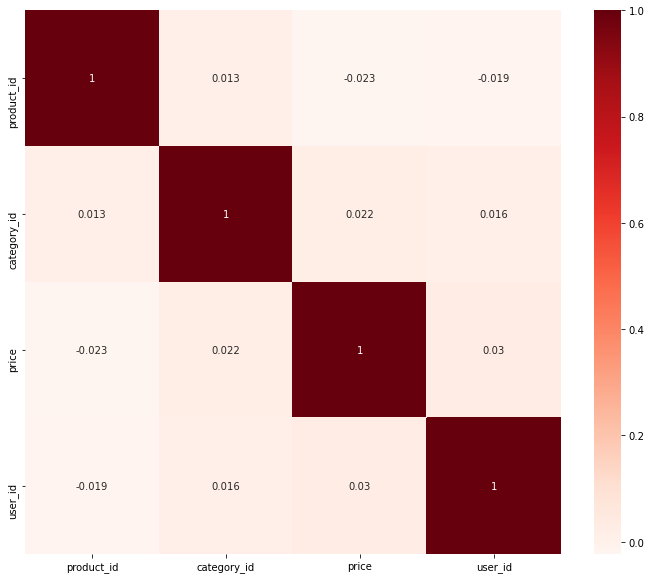

In [49]:
# Default parameter for method = 'pearson'
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 2. Check event distribution

In [18]:
event_count = df["event_type"].value_counts()
event_count

view                1947785
cart                1086637
remove_from_cart     585369
purchase             241849
Name: event_type, dtype: int64

In [19]:
event_label = df.event_type.unique().tolist()
event_label

['cart', 'view', 'remove_from_cart', 'purchase']

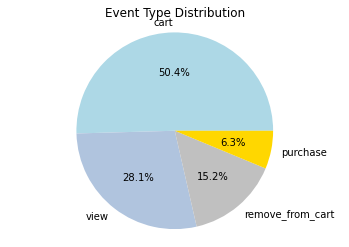

In [20]:
event_color = ['lightblue','lightsteelblue','silver','gold']
plt.pie(event_count, labels=event_label, autopct='%1.1f%%',  colors=event_color)
plt.title('Event Type Distribution')
plt.axis('equal')
plt.show()

#### 3. Check price distribution

In [21]:
# Add class (purchase=1)
df['purchased'] = (df.event_type == 'purchase')*1

<AxesSubplot:xlabel='price'>

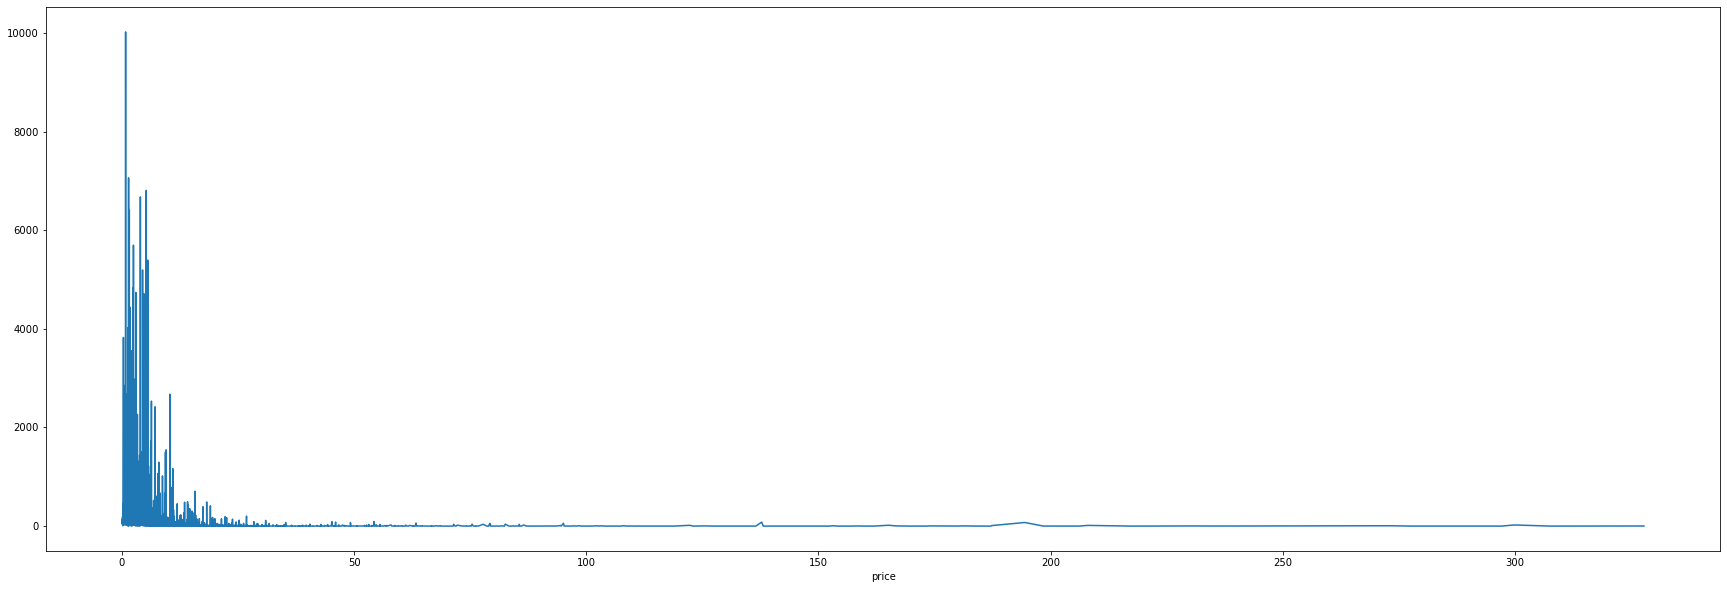

In [22]:
df_price = df.copy()
purchase_by_price = df_price.groupby('price')['purchased'].sum()
purchase_by_price.plot.line(x='price', y='purchased',figsize=(30,10))

#### 4. Check Pengaruh Brand Terhadap Purchase

<AxesSubplot:xlabel='brand'>

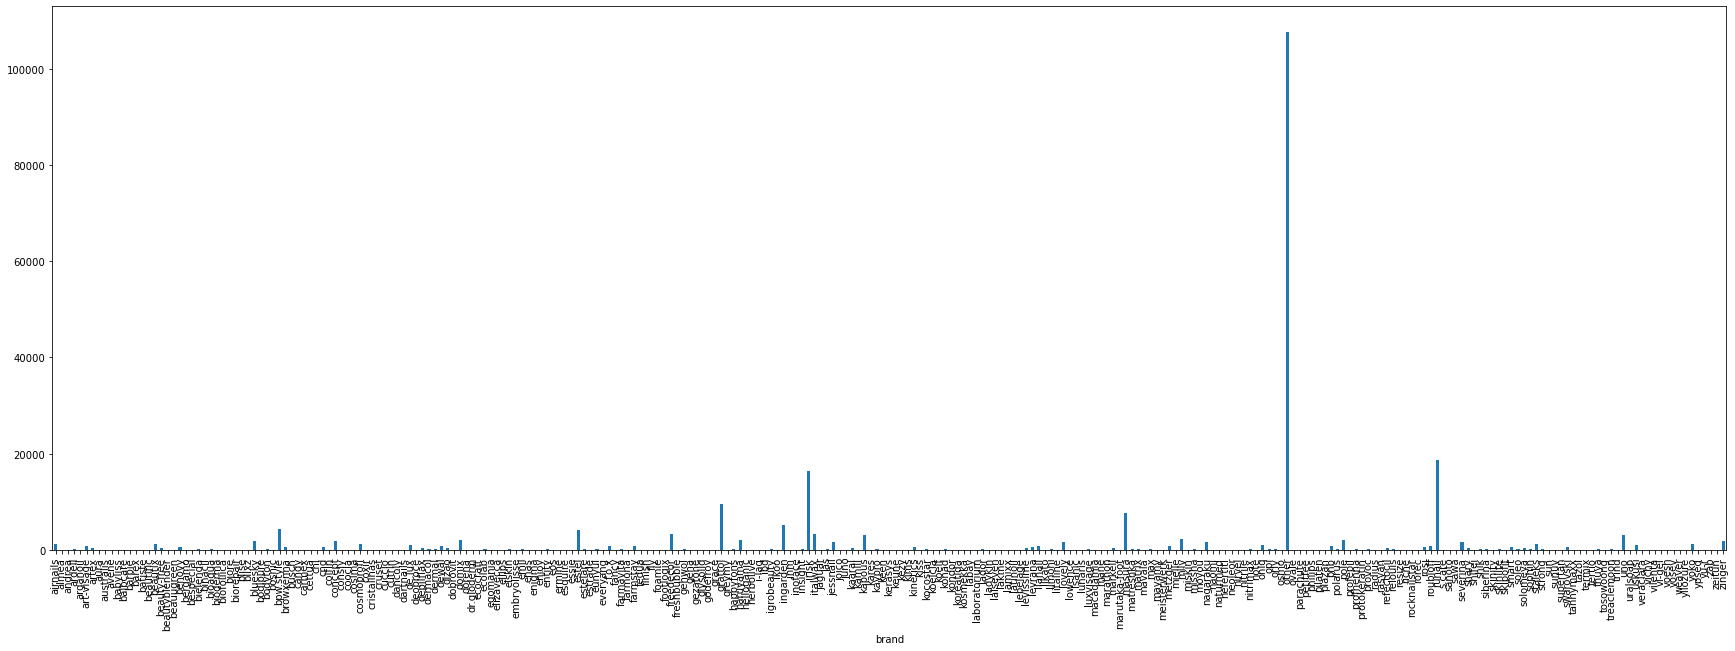

In [15]:
df_brand = df.copy()
purchase_by_brand = df_brand.groupby('brand')['purchased'].sum()
purchase_by_brand.plot.bar(x='brand', y='purchased',figsize=(30,10))

In [30]:
purchase_by_brand.sort_values(ascending=False).head(10)

brand
other        107614
runail        18678
irisk         16383
grattol        9492
masura         7695
ingarden       5120
bpw.style      4262
estel          4112
freedecor      3350
italwax        3285
Name: purchased, dtype: int64

<AxesSubplot:xlabel='brand'>

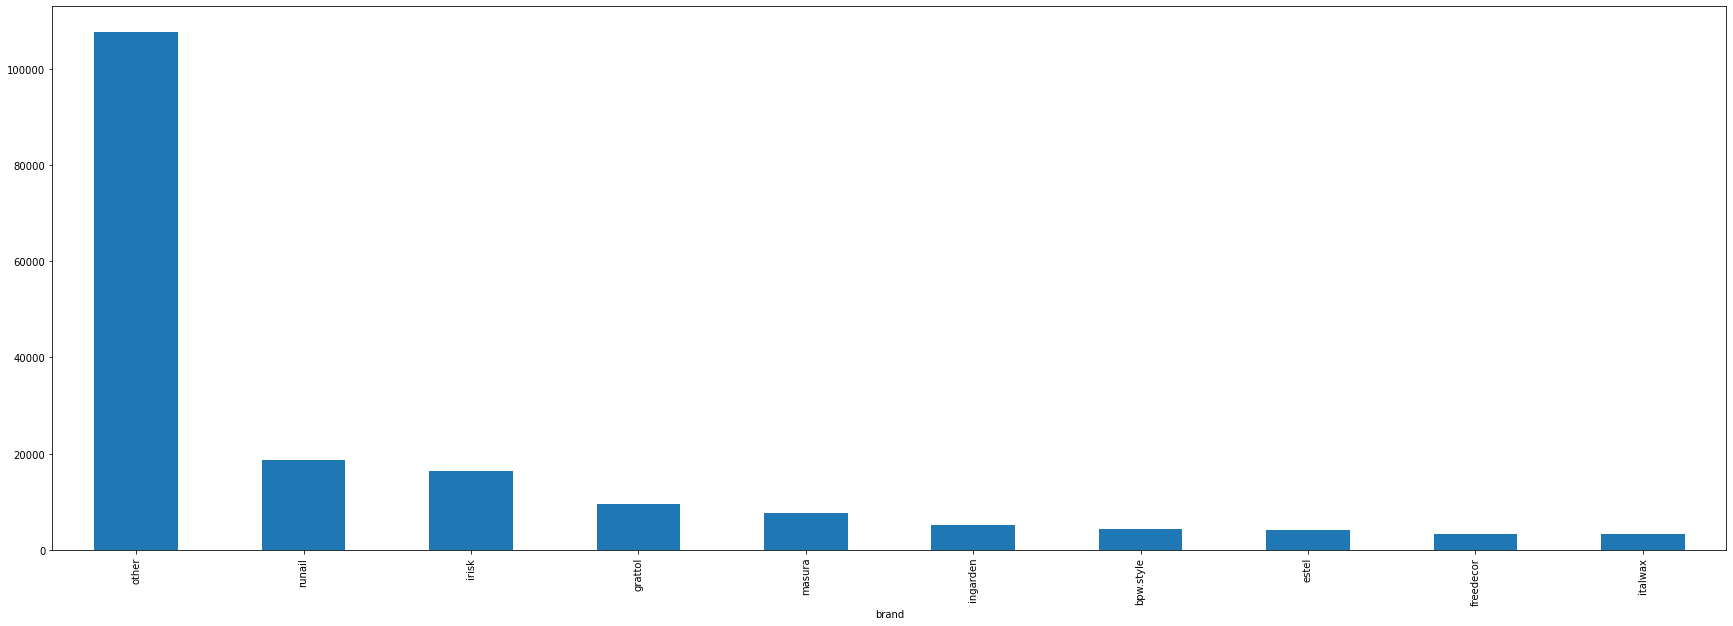

In [29]:
purchase_by_brand.sort_values(ascending=False).head(10).plot.bar(x='brand', y='purchased',figsize=(30,10))

#### 5. Check pengaruh weekday/weekend terhadap transaksi

In [4]:
agg_func = dict()
agg_func['event_type'] = 'count'
agg_func['product_id'] = 'nunique'
agg_func['category_id'] = 'nunique'
agg_func['event_time'] = ['min','max']
agg_func['purchased'] = 'sum'

In [5]:
df_session = df.copy()
df_session = df_session.groupby(['user_session']).agg(agg_func).reset_index()
df_session.columns = ['_'.join(col) if col[1] != '' else ' '.join(col).strip() for col in df_session.columns.values]
df_session

user_session  event_type_count  \
0       000090e1-da13-42b1-a31b-91a9ee5e6a88                 1   
1       0000a4ee-e357-459f-975f-6f8b30f1bdb8                42   
2       0000b84a-f3de-4ab6-84c7-ddb6e410f64d                 1   
3       0000d04d-3516-42ea-bdb9-584e92ce619e                25   
4       0000de26-bd58-42c9-9173-4763c76b398e                 1   
...                                      ...               ...   
928242  ffffca9d-a07f-4432-87b9-50b9564dc9a0                 2   
928243  ffffd3f5-3fdc-45fb-b122-0469960a9834                 2   
928244  ffffdc50-3bbc-4c9e-af33-e6d33b76498a                 4   
928245  ffffdc8c-afd8-428d-8b67-e3df6de19a50                 1   
928246  fffffc08-81e3-4050-9cd6-a5301f79f6f1                11   

        product_id_nunique  category_id_nunique            event_time_min  \
0                        1                    1 2020-02-01 14:58:19+00:00   
1                       37                    8 2020-02-10 16:03:11+00:00   
2                        1                    1 2020-02-26 20:03:10+00:00   
3                       11                    6 2020-02-15 09:07:50+00:00   
4                        1                    1 2020-02-07 13:18:01+00:00   
...                    ...                  ...                       ...   
928242                   1                    1 2020-02-09 20:37:53+00:00   
928243                   1                    1 2020-02-29 18:21:09+00:00   
928244                   4                    1 2020-02-07 10:36:07+00:00   
928245                   1                    1 2020-02-11 12:45:44+00:00   
928246                   7                    3 2020-02-09 12:37:54+00:00   

                  event_time_max  purchased_sum  
0      2020-02-01 14:58:19+00:00              0  
1      2020-02-10 16:08:46+00:00              0  
2      2020-02-26 20:03:10+00:00              0  
3      2020-02-15 09:11:59+00:00              4  
4      2020-02-07 13:18:01+00:00              0  
...                          ...            ...  
928242 2020-02-09 20:37:57+00:00              0  
928243 2020-02-29 19:15:18+00:00              0  
928244 2020-02-07 10:38:22+00:00              0  
928245 2020-02-11 12:45:44+00:00              0  
928246 2020-02-09 12:52:44+00:00              6  

[928247 rows x 7 columns]

<AxesSubplot:xlabel='day_of_week'>

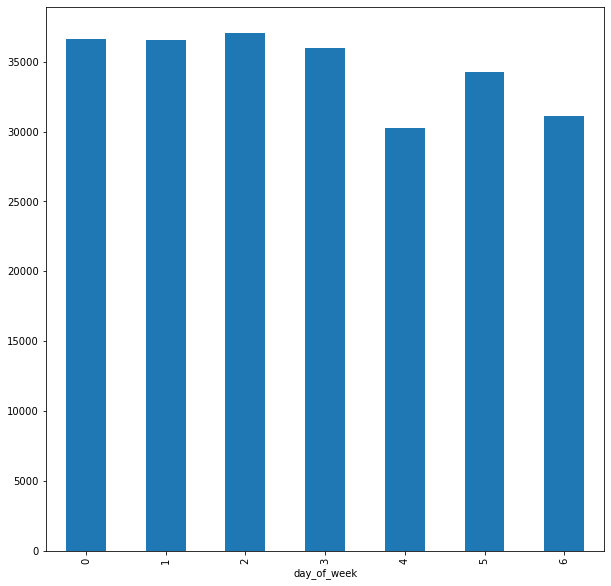

In [6]:
# day of week start from monday(0) to sunday (6)
df_session['day_of_week'] = df_session.event_time_min.dt.dayofweek
purchase_by_day = df_session.groupby('day_of_week')['purchased_sum'].sum()
purchase_by_day.plot.bar(x='day_of_week', y='purchased_sum', figsize=(10,10))

#### 6. Check pengaruh jam dalam hari terhadap transaksi

<AxesSubplot:xlabel='hour'>

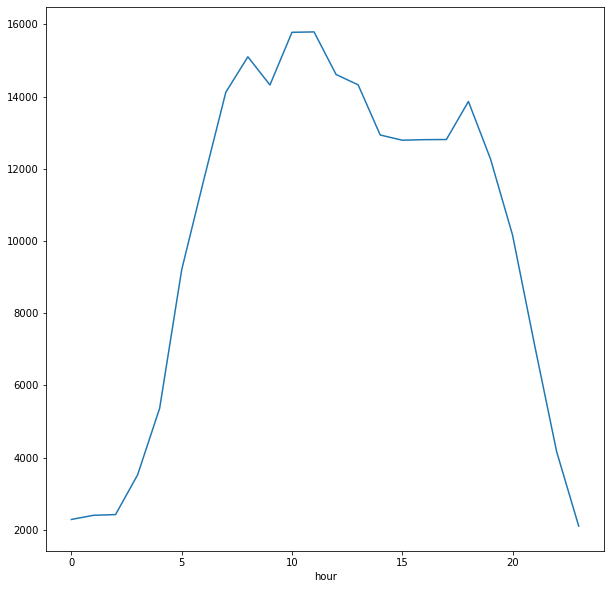

In [7]:
df_session['hour'] = df_session.event_time_min.dt.hour
purchase_by_hour = df_session.groupby('hour')['purchased_sum'].sum()
purchase_by_hour.plot.line(x='hour', y='purchased_sum', figsize=(10,10))

<AxesSubplot:xlabel='hour'>

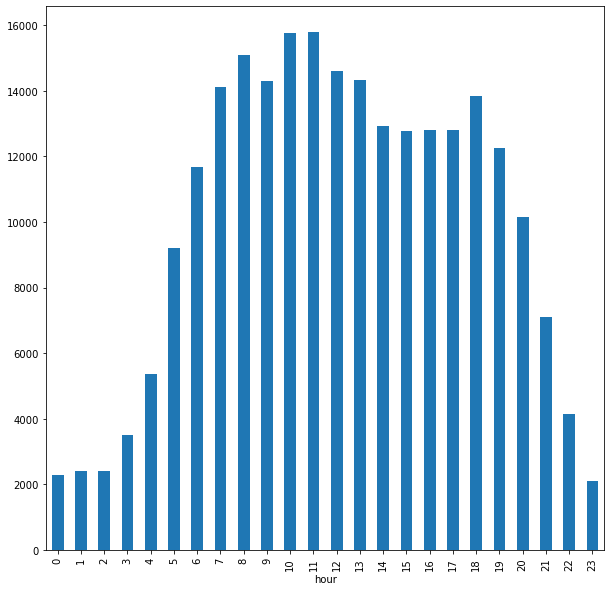

In [33]:
purchase_by_hour.plot.bar(x='hour', y='purchased_sum', figsize=(10,10))

#### 7. Cek pengaruh jumlah item unik pada setiap session terhadap purchase

<AxesSubplot:xlabel='product_id_nunique'>

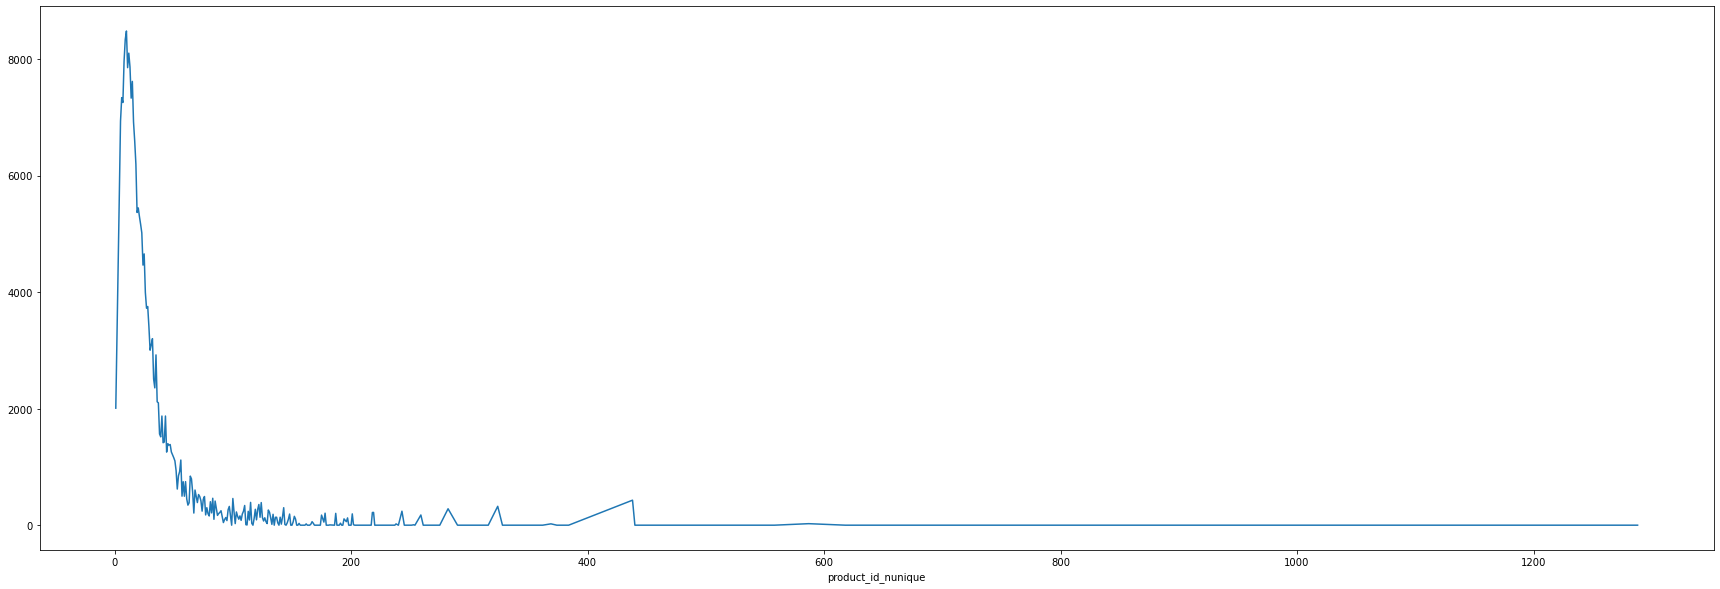

In [34]:
purchase_by_product_id_nunique = df_session.groupby('product_id_nunique')['purchased_sum'].sum()
purchase_by_product_id_nunique.plot.line(x='product_id_nunique', y='purchased_sum',figsize=(30,10))

<AxesSubplot:xlabel='product_id_nunique'>

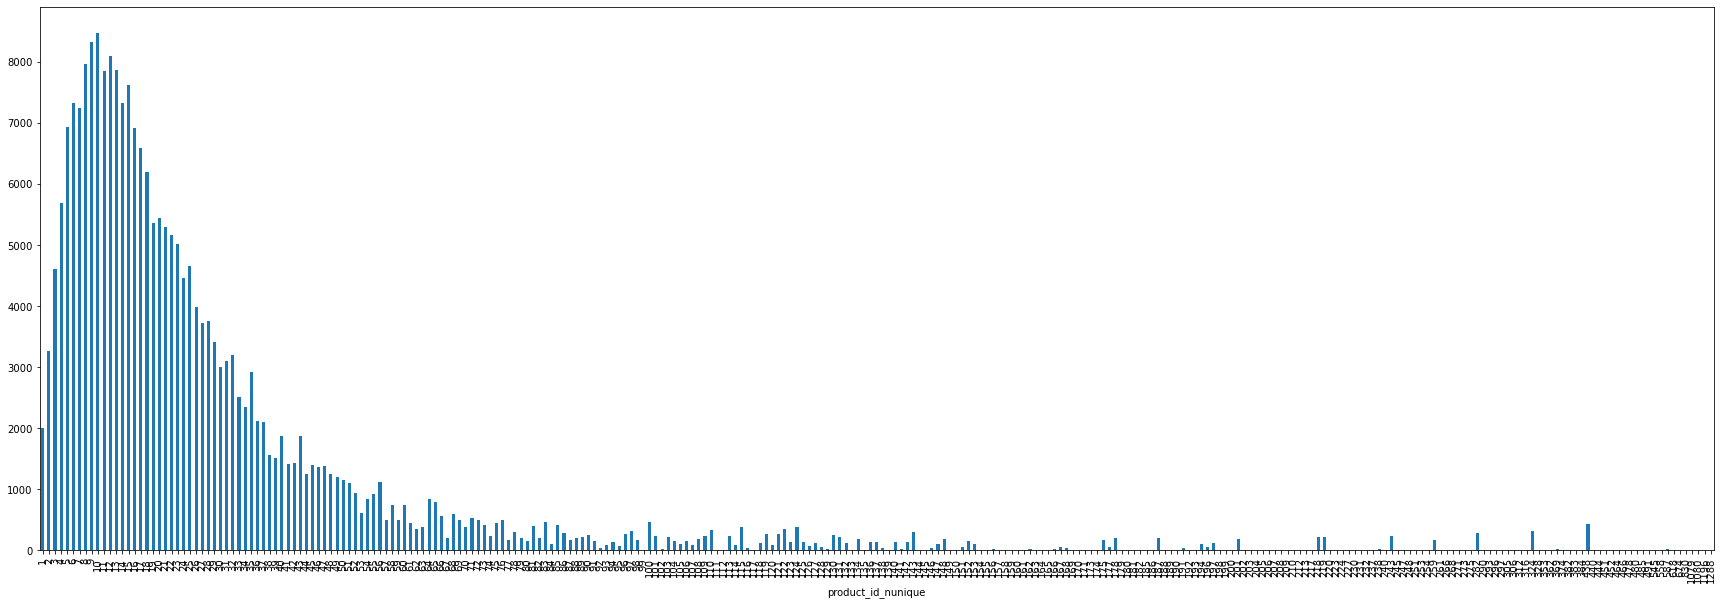

In [35]:
purchase_by_product_id_nunique.plot.bar(x='product_id_nunique', y='purchased_sum',figsize=(30,10))

#### 8. Cek pengaruh jumlah kategori unik pada setiap session terhadap purchase

<AxesSubplot:xlabel='category_id_nunique'>

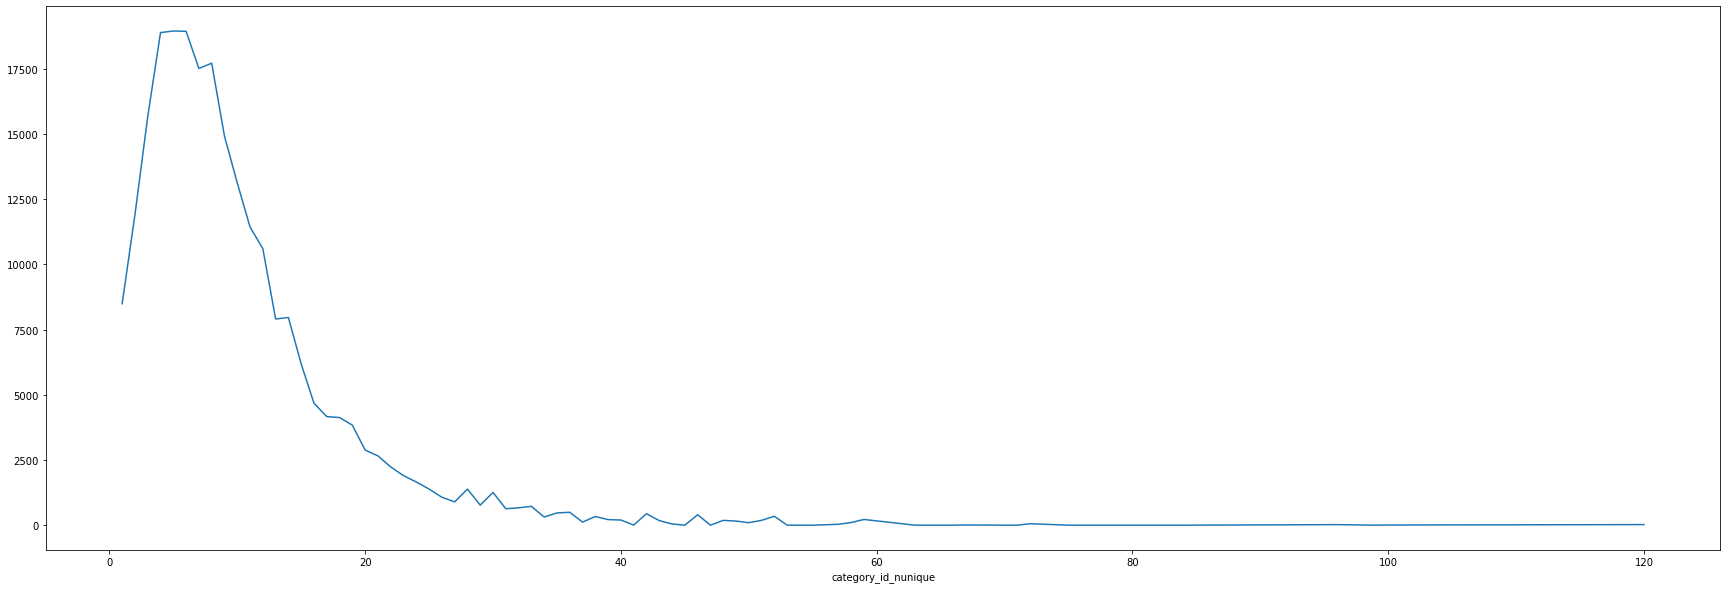

In [36]:
purchase_by_category_id_nunique = df_session.groupby('category_id_nunique')['purchased_sum'].sum()
purchase_by_category_id_nunique.plot.line(x='category_id_nunique', y='purchased_sum',figsize=(30,10))

<AxesSubplot:xlabel='category_id_nunique'>

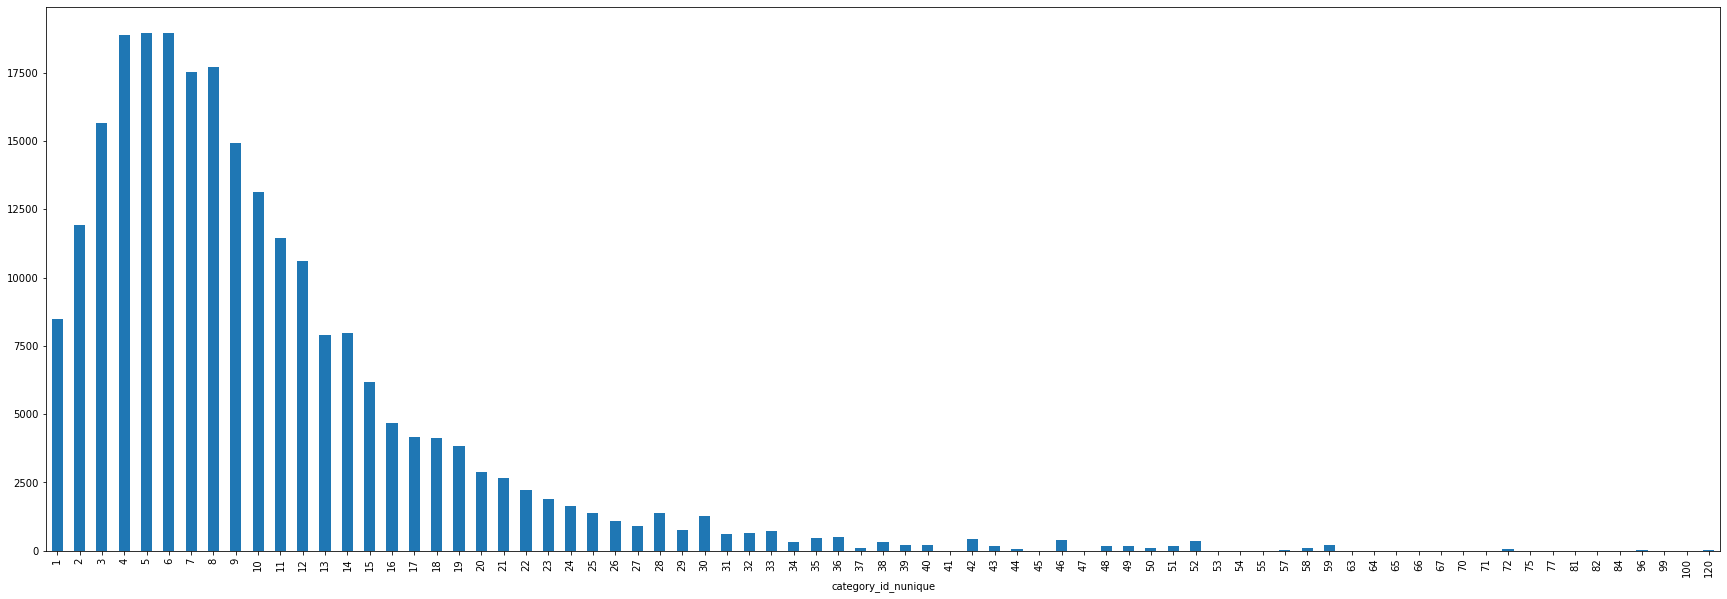

In [37]:
purchase_by_category_id_nunique.plot.bar(x='category_id_nunique', y='purchased_sum',figsize=(30,10))

#### 9. Cek pengaruh durasi setiap session terhadap purchase

<AxesSubplot:xlabel='time_spent'>

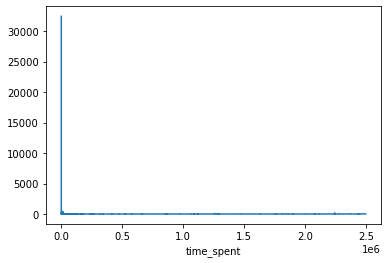

In [8]:
df_session['time_spent'] = (df_session['event_time_max'] - df_session['event_time_min']).dt.total_seconds()
purchase_by_time_spent = df_session.groupby('time_spent')['purchased_sum'].sum()
purchase_by_time_spent.plot.line(x='time_spent', y='purchased_sum')

In [10]:
df_session['time_spent']

0            0.0
1          335.0
2            0.0
3          249.0
4            0.0
           ...  
928242       4.0
928243    3249.0
928244     135.0
928245       0.0
928246     890.0
Name: time_spent, Length: 928247, dtype: float64

#### 10. Check pengaruh jumlah event dalam session terhadap jumlah purchase 

In [9]:
# sort data by user session and the event time 
df_item = df.copy()
df_item = df_item.sort_values(['user_session', 'event_time'], ignore_index=True)
df_item['event_time_before'] = df_item.event_time.shift(periods=1)
df_item

event_time event_type  product_id          category_id  \
0       2020-02-01 14:58:19+00:00       view     5808664  2089259162625114209   
1       2020-02-10 16:03:11+00:00       view     5897532  1487580009286598681   
2       2020-02-10 16:03:21+00:00       view     5897538  1487580009286598681   
3       2020-02-10 16:03:30+00:00       view     5897534  1487580009286598681   
4       2020-02-10 16:03:44+00:00       view     5897536  1487580009286598681   
...                           ...        ...         ...                  ...   
4084331 2020-02-09 12:52:44+00:00   purchase     5785422  1487580007256556476   
4084332 2020-02-09 12:52:44+00:00   purchase     5802162  1487580013069861041   
4084333 2020-02-09 12:52:44+00:00   purchase     5832415  1487580007256556476   
4084334 2020-02-09 12:52:44+00:00   purchase     5846442  2151191071378375538   
4084335 2020-02-09 12:52:44+00:00   purchase     5846446  2151191071378375538   

             brand  price    user_id                          user_session  \
0           ardell   6.37  609093055  000090e1-da13-42b1-a31b-91a9ee5e6a88   
1            other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
2            other   2.86  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
3            other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
4            other   2.86  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
...            ...    ...        ...                                   ...   
4084331      other   3.16  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084332    italwax  23.81  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084333      other   2.38  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084334  browxenna  19.52  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084335  browxenna  19.52  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   

         purchased         event_time_before  
0                0                       NaT  
1                0 2020-02-01 14:58:19+00:00  
2                0 2020-02-10 16:03:11+00:00  
3                0 2020-02-10 16:03:21+00:00  
4                0 2020-02-10 16:03:30+00:00  
...            ...                       ...  
4084331          1 2020-02-09 12:52:44+00:00  
4084332          1 2020-02-09 12:52:44+00:00  
4084333          1 2020-02-09 12:52:44+00:00  
4084334          1 2020-02-09 12:52:44+00:00  
4084335          1 2020-02-09 12:52:44+00:00  

[4084336 rows x 10 columns]

In [10]:
user_session = dict()
def count_event(user_sess):
    if user_sess in user_session:
        user_session[user_sess]+=1
    else:
        user_session[user_sess]=1
    return user_session[user_sess]

In [11]:
# event_sequence = total event in the current user session (include all event type)
df_item['event_sequence'] = df_item.user_session.apply(lambda x: count_event(x))
df_item['event_time_before'].fillna(df['event_time'], inplace=True)
df_item['duration_between_event'] = (df_item['event_time'] - df_item['event_time_before']).dt.total_seconds()
df_item

event_time event_type  product_id          category_id  \
0       2020-02-01 14:58:19+00:00       view     5808664  2089259162625114209   
1       2020-02-10 16:03:11+00:00       view     5897532  1487580009286598681   
2       2020-02-10 16:03:21+00:00       view     5897538  1487580009286598681   
3       2020-02-10 16:03:30+00:00       view     5897534  1487580009286598681   
4       2020-02-10 16:03:44+00:00       view     5897536  1487580009286598681   
...                           ...        ...         ...                  ...   
4084331 2020-02-09 12:52:44+00:00   purchase     5785422  1487580007256556476   
4084332 2020-02-09 12:52:44+00:00   purchase     5802162  1487580013069861041   
4084333 2020-02-09 12:52:44+00:00   purchase     5832415  1487580007256556476   
4084334 2020-02-09 12:52:44+00:00   purchase     5846442  2151191071378375538   
4084335 2020-02-09 12:52:44+00:00   purchase     5846446  2151191071378375538   

             brand  price    user_id                          user_session  \
0           ardell   6.37  609093055  000090e1-da13-42b1-a31b-91a9ee5e6a88   
1            other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
2            other   2.86  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
3            other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
4            other   2.86  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
...            ...    ...        ...                                   ...   
4084331      other   3.16  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084332    italwax  23.81  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084333      other   2.38  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084334  browxenna  19.52  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084335  browxenna  19.52  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   

         purchased         event_time_before  event_sequence  \
0                0 2020-02-01 00:00:01+00:00               1   
1                0 2020-02-01 14:58:19+00:00               1   
2                0 2020-02-10 16:03:11+00:00               2   
3                0 2020-02-10 16:03:21+00:00               3   
4                0 2020-02-10 16:03:30+00:00               4   
...            ...                       ...             ...   
4084331          1 2020-02-09 12:52:44+00:00               7   
4084332          1 2020-02-09 12:52:44+00:00               8   
4084333          1 2020-02-09 12:52:44+00:00               9   
4084334          1 2020-02-09 12:52:44+00:00              10   
4084335          1 2020-02-09 12:52:44+00:00              11   

         duration_between_event  
0                       53898.0  
1                      781492.0  
2                          10.0  
3                           9.0  
4                          14.0  
...                         ...  
4084331                     0.0  
4084332                     0.0  
4084333                     0.0  
4084334                     0.0  
4084335                     0.0  

[4084336 rows x 12 columns]

In [12]:
# if it is the first event of current user_session, vhange duration to 0
def validate_duration(row):
    if row['event_sequence'] == 1:
        return 0
    else:
        return row['duration_between_event']

# aplly validate duration to each row
df_item['duration_between_event'] = df_item.apply(validate_duration, axis = 1)

In [13]:
agg_func = dict()
agg_func['event_sequence'] = 'nunique'
agg_func['duration_between_event'] = 'sum'
agg_func['purchased'] = 'sum'

df_item_copy = df_item.groupby(['user_session', 'product_id']).agg(agg_func).reset_index()
df_item_copy.rename(columns = {'duration_between_event':'long_item_in_sess'}, inplace = True)

In [47]:
df_item_copy

user_session  product_id  event_sequence  \
0        000090e1-da13-42b1-a31b-91a9ee5e6a88     5808664               1   
1        0000a4ee-e357-459f-975f-6f8b30f1bdb8     5885298               1   
2        0000a4ee-e357-459f-975f-6f8b30f1bdb8     5885299               1   
3        0000a4ee-e357-459f-975f-6f8b30f1bdb8     5885300               1   
4        0000a4ee-e357-459f-975f-6f8b30f1bdb8     5885301               1   
...                                       ...         ...             ...   
2773575  fffffc08-81e3-4050-9cd6-a5301f79f6f1     5796874               1   
2773576  fffffc08-81e3-4050-9cd6-a5301f79f6f1     5802162               1   
2773577  fffffc08-81e3-4050-9cd6-a5301f79f6f1     5832415               2   
2773578  fffffc08-81e3-4050-9cd6-a5301f79f6f1     5846442               2   
2773579  fffffc08-81e3-4050-9cd6-a5301f79f6f1     5846446               2   

         long_item_in_sess  purchased  
0                      0.0          0  
1                      4.0          0  
2                      6.0          0  
3                      6.0          0  
4                      4.0          0  
...                    ...        ...  
2773575              483.0          0  
2773576                0.0          1  
2773577               14.0          1  
2773578                0.0          1  
2773579               20.0          1  

[2773580 rows x 5 columns]

<AxesSubplot:xlabel='event_sequence'>

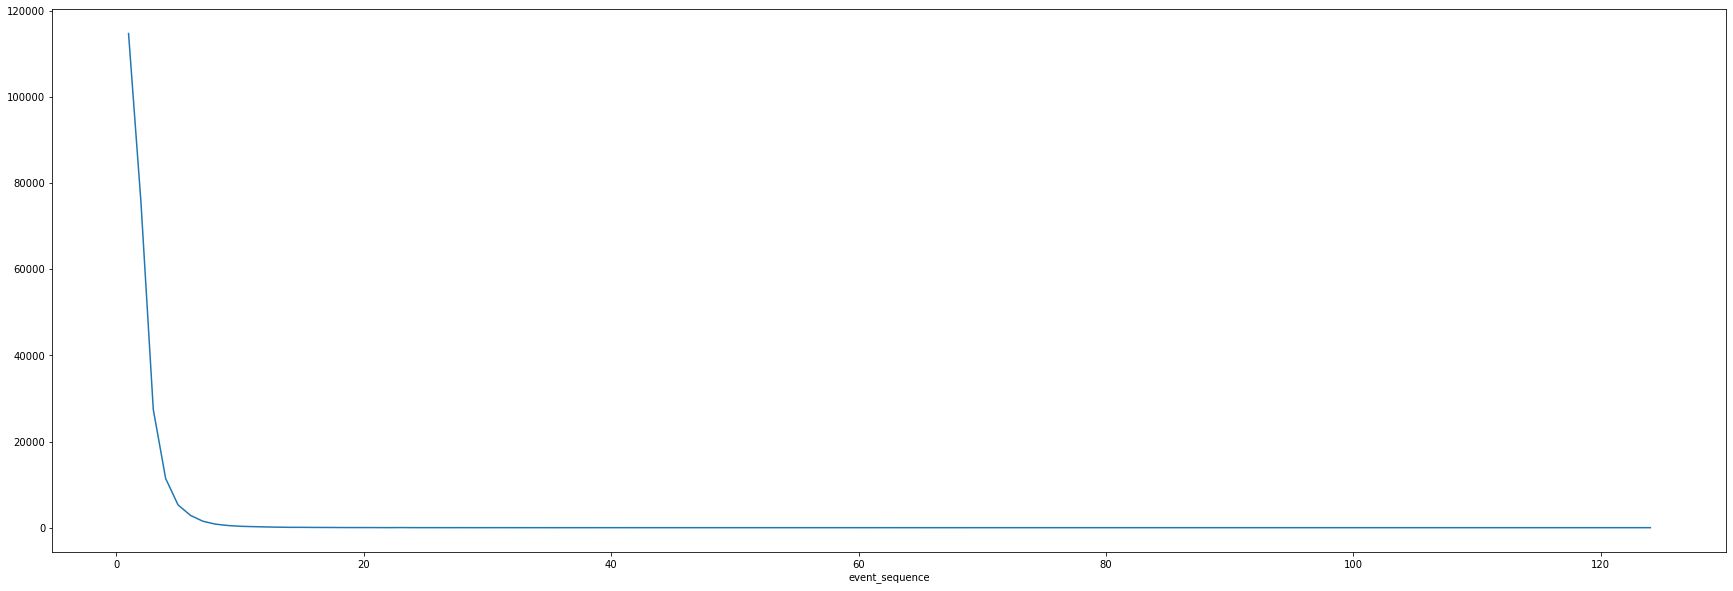

In [48]:
purchase_by_count_event = df_item_copy.groupby('event_sequence')['purchased'].sum()
purchase_by_count_event.plot.line(x='event_sequence', y='purchased',figsize=(30,10))

<AxesSubplot:xlabel='event_sequence'>

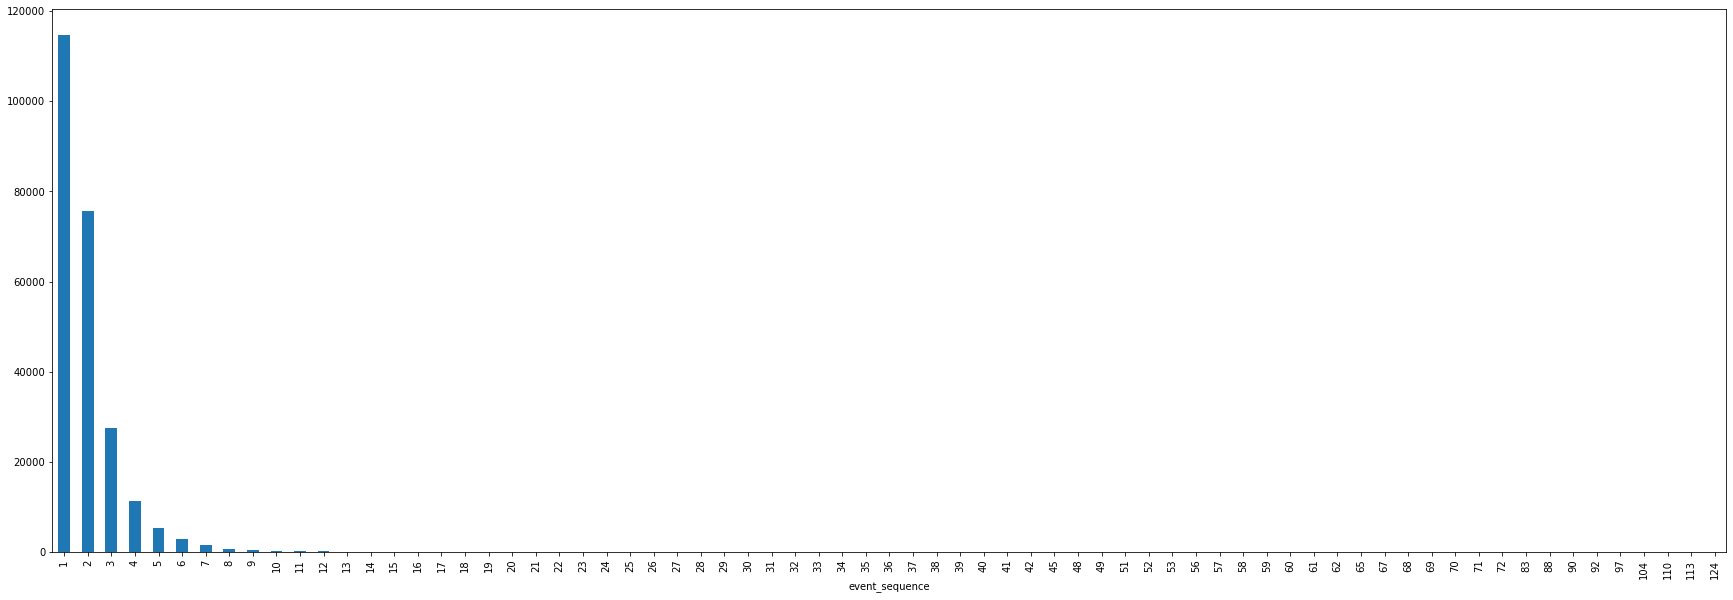

In [49]:
purchase_by_count_event.plot.bar(x='event_sequence', y='purchased',figsize=(30,10))

#### 11. Cek pengaruh durasi setiap item pada setiap session terhadap jumlah purchase

<AxesSubplot:xlabel='long_item_in_sess'>

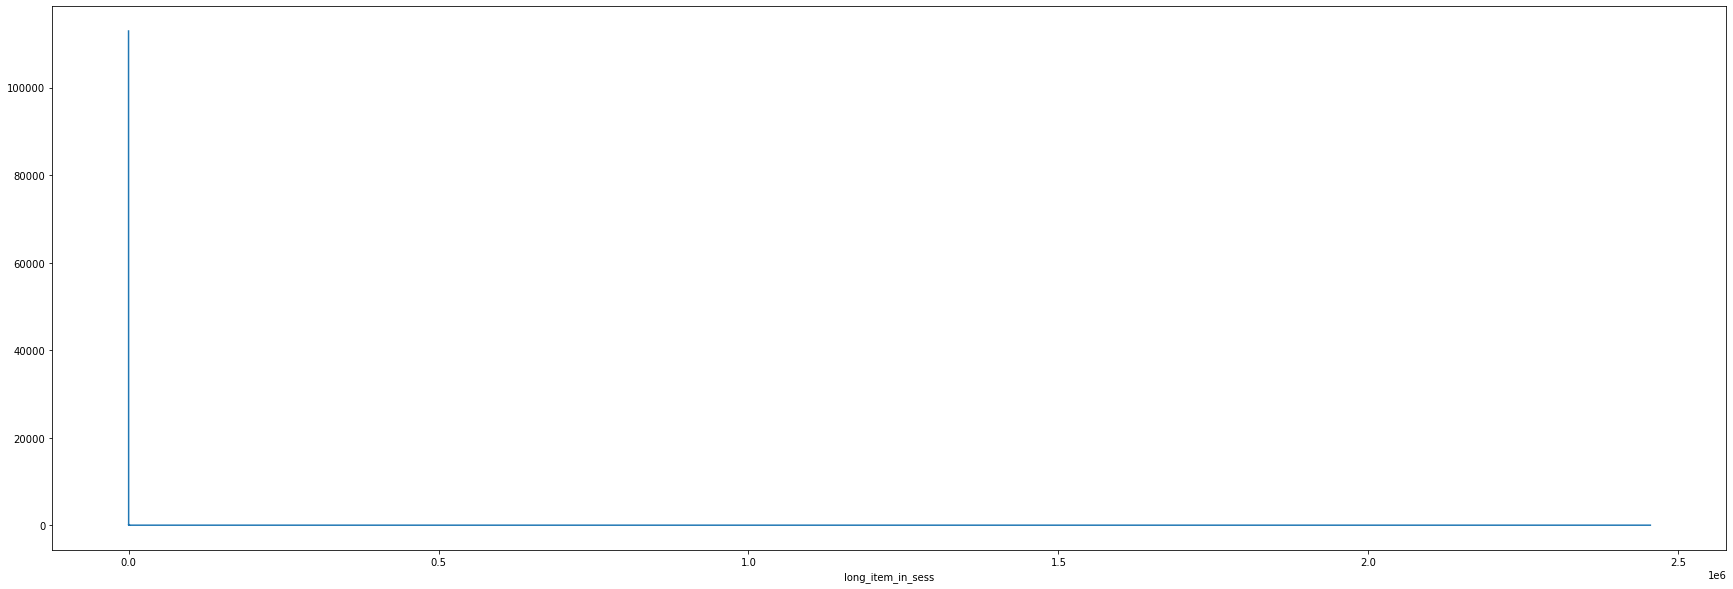

In [50]:
purchase_by_long_item_session = df_item_copy.groupby('long_item_in_sess')['purchased'].sum()
purchase_by_long_item_session.plot.line(x='long_item_in_sess', y='purchased',figsize=(30,10))

## Prepare Data for Eksperimen

In [14]:
df_item = df_item.merge(df_item_copy, on=['user_session', 'product_id'])
df_item

event_time event_type  product_id          category_id  \
0       2020-02-01 14:58:19+00:00       view     5808664  2089259162625114209   
1       2020-02-10 16:03:11+00:00       view     5897532  1487580009286598681   
2       2020-02-10 16:06:30+00:00       view     5897532  1487580009286598681   
3       2020-02-10 16:03:21+00:00       view     5897538  1487580009286598681   
4       2020-02-10 16:03:30+00:00       view     5897534  1487580009286598681   
...                           ...        ...         ...                  ...   
4084331 2020-02-09 12:52:44+00:00   purchase     5785422  1487580007256556476   
4084332 2020-02-09 12:47:54+00:00       cart     5832415  1487580007256556476   
4084333 2020-02-09 12:52:44+00:00   purchase     5832415  1487580007256556476   
4084334 2020-02-09 12:52:44+00:00   purchase     5753487  1487580013069861041   
4084335 2020-02-09 12:52:44+00:00   purchase     5802162  1487580013069861041   

           brand  price    user_id                          user_session  \
0         ardell   6.37  609093055  000090e1-da13-42b1-a31b-91a9ee5e6a88   
1          other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
2          other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
3          other   2.86  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
4          other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
...          ...    ...        ...                                   ...   
4084331    other   3.16  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084332    other   2.38  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084333    other   2.38  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084334  italwax  13.02  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084335  italwax  23.81  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   

         purchased_x         event_time_before  event_sequence_x  \
0                  0 2020-02-01 00:00:01+00:00                 1   
1                  0 2020-02-01 14:58:19+00:00                 1   
2                  0 2020-02-10 16:06:26+00:00                20   
3                  0 2020-02-10 16:03:11+00:00                 2   
4                  0 2020-02-10 16:03:21+00:00                 3   
...              ...                       ...               ...   
4084331            1 2020-02-09 12:52:44+00:00                 7   
4084332            0 2020-02-09 12:47:40+00:00                 5   
4084333            1 2020-02-09 12:52:44+00:00                 9   
4084334            1 2020-02-09 12:47:54+00:00                 6   
4084335            1 2020-02-09 12:52:44+00:00                 8   

         duration_between_event  event_sequence_y  long_item_in_sess  \
0                           0.0                 1                0.0   
1                           0.0                 2                4.0   
2                           4.0                 2                4.0   
3                          10.0                 1               10.0   
4                           9.0                 2               15.0   
...                         ...               ...                ...   
4084331                     0.0                 2               83.0   
4084332                    14.0                 2               14.0   
4084333                     0.0                 2               14.0   
4084334                   290.0                 1              290.0   
4084335                     0.0                 1                0.0   

         purchased_y  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
4084331            1  
4084332            1  
4084333            1  
4084334            1  
4084335            1  

[4084336 rows x 15 columns]

In [15]:
# Combine df item with dfsession on user_session
df_eksperimen = df_item.merge(df_session, on=['user_session'])
df_eksperimen

event_time event_type  product_id          category_id  \
0       2020-02-01 14:58:19+00:00       view     5808664  2089259162625114209   
1       2020-02-10 16:03:11+00:00       view     5897532  1487580009286598681   
2       2020-02-10 16:06:30+00:00       view     5897532  1487580009286598681   
3       2020-02-10 16:03:21+00:00       view     5897538  1487580009286598681   
4       2020-02-10 16:03:30+00:00       view     5897534  1487580009286598681   
...                           ...        ...         ...                  ...   
4084331 2020-02-09 12:52:44+00:00   purchase     5785422  1487580007256556476   
4084332 2020-02-09 12:47:54+00:00       cart     5832415  1487580007256556476   
4084333 2020-02-09 12:52:44+00:00   purchase     5832415  1487580007256556476   
4084334 2020-02-09 12:52:44+00:00   purchase     5753487  1487580013069861041   
4084335 2020-02-09 12:52:44+00:00   purchase     5802162  1487580013069861041   

           brand  price    user_id                          user_session  \
0         ardell   6.37  609093055  000090e1-da13-42b1-a31b-91a9ee5e6a88   
1          other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
2          other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
3          other   2.86  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
4          other   2.16  583884978  0000a4ee-e357-459f-975f-6f8b30f1bdb8   
...          ...    ...        ...                                   ...   
4084331    other   3.16  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084332    other   2.38  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084333    other   2.38  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084334  italwax  13.02  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   
4084335  italwax  23.81  606966882  fffffc08-81e3-4050-9cd6-a5301f79f6f1   

         purchased_x         event_time_before  ...  purchased_y  \
0                  0 2020-02-01 00:00:01+00:00  ...            0   
1                  0 2020-02-01 14:58:19+00:00  ...            0   
2                  0 2020-02-10 16:06:26+00:00  ...            0   
3                  0 2020-02-10 16:03:11+00:00  ...            0   
4                  0 2020-02-10 16:03:21+00:00  ...            0   
...              ...                       ...  ...          ...   
4084331            1 2020-02-09 12:52:44+00:00  ...            1   
4084332            0 2020-02-09 12:47:40+00:00  ...            1   
4084333            1 2020-02-09 12:52:44+00:00  ...            1   
4084334            1 2020-02-09 12:47:54+00:00  ...            1   
4084335            1 2020-02-09 12:52:44+00:00  ...            1   

         event_type_count  product_id_nunique  category_id_nunique  \
0                       1                   1                    1   
1                      42                  37                    8   
2                      42                  37                    8   
3                      42                  37                    8   
4                      42                  37                    8   
...                   ...                 ...                  ...   
4084331                11                   7                    3   
4084332                11                   7                    3   
4084333                11                   7                    3   
4084334                11                   7                    3   
4084335                11                   7                    3   

                   event_time_min            event_time_max  purchased_sum  \
0       2020-02-01 14:58:19+00:00 2020-02-01 14:58:19+00:00              0   
1       2020-02-10 16:03:11+00:00 2020-02-10 16:08:46+00:00              0   
2       2020-02-10 16:03:11+00:00 2020-02-10 16:08:46+00:00              0   
3       2020-02-10 16:03:11+00:00 2020-02-10 16:08:46+00:00              0   
4       2020-02-10 16:03:11+00:00 2020-02-10 16:08:46+00:00              0   
...        

In [20]:
df_eksperimen.columns

Index(['event_time', 'event_type', 'product_id', 'category_id', 'brand',
       'price', 'user_id', 'user_session', 'purchased_x', 'event_time_before',
       'event_sequence_x', 'duration_between_event', 'event_sequence_y',
       'long_item_in_sess', 'purchased_y', 'event_type_count',
       'product_id_nunique', 'category_id_nunique', 'event_time_min',
       'event_time_max', 'purchased_sum', 'day_of_week', 'hour', 'time_spent'],
      dtype='object')

In [16]:
predictors = [cols for cols in df_eksperimen.columns if cols not in ['purchased_x', 'event_time', 'event_type', 'product_id', 'category_id', 'user_id', 'user_session', 'event_time_before', 'event_sequence_y', 'purchased_y', 'event_type_count', 'event_time_min', 'event_time_max', 'purchased_sum', 'long_item_in_sess', 'duration_between_event']]
X = df_eksperimen[predictors]
y = df_eksperimen['purchased_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [18]:
X_train.columns

Index(['brand', 'price', 'event_sequence_x', 'product_id_nunique',
       'category_id_nunique', 'day_of_week', 'hour', 'time_spent'],
      dtype='object')

In [20]:
# check total purchase and not purchase class in testing data
y_test.value_counts()

0    724060
1     48268
Name: purchased_x, dtype: int64

### Sampling Data just for one week

In [17]:
# sort data by user session and the event time 
df_eksperimen2 = df_eksperimen.copy()
df_eksperimen2 = df_eksperimen2.sort_values(['event_time'], ignore_index=True)
df_eksperimen2

event_time event_type  product_id          category_id  \
0       2020-02-01 00:00:01+00:00       cart     5844305  1487580006317032337   
1       2020-02-01 00:00:03+00:00       view     5769925  1487580013841613016   
2       2020-02-01 00:00:08+00:00       view     5817765  1487580008246412266   
3       2020-02-01 00:00:11+00:00       view     5877033  1487580010100293687   
4       2020-02-01 00:00:12+00:00       cart     5814871  1487580008112194531   
...                           ...        ...         ...                  ...   
4084331 2020-02-29 23:59:32+00:00       view     5885416  1487580005092295511   
4084332 2020-02-29 23:59:39+00:00       cart     5550686  1487580008145748965   
4084333 2020-02-29 23:59:45+00:00       view     5850628  1602943681873052386   
4084334 2020-02-29 23:59:54+00:00       view     5716351  1487580010872045658   
4084335 2020-02-29 23:59:59+00:00       view     5927709  1487580013950664926   

           brand  price    user_id                          user_session  \
0          other   2.14  485174092  4be9643a-420b-4c6b-83dd-a15e772fbf7a   
1         kapous   4.22  594621622  a88baf11-9cd0-4362-bde4-1bfeed3f641d   
2         zeitun  11.03  495404942  3a569c8d-d848-4f09-a925-33f673d84c46   
3           milv   3.49  564814969  7feb39e5-bb7b-4b2b-a546-3e3b7c56326e   
4         zinger   2.54  551205603  106a7c7f-7fa1-4463-8bec-0ea7b02191cb   
...          ...    ...        ...                                   ...   
4084331  grattol   6.27  622082947  fb29909b-6ef5-4662-b4ee-288e73e5dc10   
4084332    other   1.11  459705611  05d2add3-01f7-47ee-8364-27341673227f   
4084333  grattol   5.24  622090043  ab7d349f-db5d-4790-8ab1-31e5c894459d   
4084334    irisk   0.79  619841242  18af673b-7fb9-4202-a66d-5c855bc0fd2d   
4084335   de.lux   3.17  621669991  daa3c677-5360-4327-847e-d29658716b99   

         purchased_x         event_time_before  ...  purchased_y  \
0                  0 2020-02-06 21:23:24+00:00  ...            0   
1                  0 2020-02-10 10:48:44+00:00  ...            0   
2                  0 2020-02-07 10:51:00+00:00  ...            0   
3                  0 2020-02-09 18:54:57+00:00  ...            0   
4                  0 2020-02-01 14:00:01+00:00  ...            0   
...              ...                       ...  ...          ...   
4084331            0 2020-02-29 23:58:03+00:00  ...            0   
4084332            0 2020-02-29 23:55:06+00:00  ...            0   
4084333            0 2020-02-29 23:58:43+00:00  ...            0   
4084334            0 2020-02-29 23:59:28+00:00  ...            0   
4084335            0 2020-02-29 23:59:14+00:00  ...            0   

         event_type_count  product_id_nunique  category_id_nunique  \
0                       8                   8                    1   
1                       1                   1                    1   
2                       8                   7                    1   
3                       1                   1                    1   
4                       4                   2                    2   
...                   ...                 ...                  ...   
4084331                44                  36                   20   
4084332                 2                   1                    1   
4084333                 3                   3                    1   
4084334                 2                   2                    1   
4084335                64                  25                    3   

                   event_time_min            event_time_max  purchased_sum  \
0       2020-02-01 00:00:01+00:00 2020-02-01 00:06:34+00:00              0   
1       2020-02-01 00:00:03+00:00 2020-02-01 00:00:03+00:00              0   
2       2020-02-01 00:00:08+00:00 2020-02-01 00:03:45+00:00              0   
3       2020-02-01 00:00:11+00:00 2020-02-01 00:00:11+00:00              0   
4       2020-02-01 00:00:12+00:00 2020-02-01 00:01:25+00:00              0   
...        

In [18]:
start_date = pd.to_datetime('2020-02-01 0:00', utc= True)
end_date = pd.to_datetime('2020-02-08 0:00', utc= True)
df_eksperimen_sample = df_eksperimen2.loc[(df_eksperimen2['event_time'] > start_date) & (df_eksperimen2['event_time'] < end_date)]
df_eksperimen_sample

event_time        event_type  product_id  \
0       2020-02-01 00:00:01+00:00              cart     5844305   
1       2020-02-01 00:00:03+00:00              view     5769925   
2       2020-02-01 00:00:08+00:00              view     5817765   
3       2020-02-01 00:00:11+00:00              view     5877033   
4       2020-02-01 00:00:12+00:00              cart     5814871   
...                           ...               ...         ...   
1045912 2020-02-07 23:59:53+00:00              view     5768049   
1045913 2020-02-07 23:59:54+00:00  remove_from_cart     5925349   
1045914 2020-02-07 23:59:55+00:00  remove_from_cart     5923394   
1045915 2020-02-07 23:59:57+00:00              view     5699074   
1045916 2020-02-07 23:59:59+00:00  remove_from_cart     5802432   

                 category_id     brand  price    user_id  \
0        1487580006317032337     other   2.14  485174092   
1        1487580013841613016    kapous   4.22  594621622   
2        1487580008246412266    zeitun  11.03  495404942   
3        1487580010100293687      milv   3.49  564814969   
4        1487580008112194531    zinger   2.54  551205603   
...                      ...       ...    ...        ...   
1045912  1487580007659209676  ingarden   1.27  479466962   
1045913  1487580007675986893     other   1.43  610226536   
1045914  1487580005511725929     other   3.89  611853362   
1045915  1487580009311764506    zinger   4.13  607545777   
1045916  1487580009286598681     other   0.32  610226536   

                                 user_session  purchased_x  \
0        4be9643a-420b-4c6b-83dd-a15e772fbf7a            0   
1        a88baf11-9cd0-4362-bde4-1bfeed3f641d            0   
2        3a569c8d-d848-4f09-a925-33f673d84c46            0   
3        7feb39e5-bb7b-4b2b-a546-3e3b7c56326e            0   
4        106a7c7f-7fa1-4463-8bec-0ea7b02191cb            0   
...                                       ...          ...   
1045912  660c87de-3bed-4acd-92e8-660d390f65cb            0   
1045913  bc89b6ef-9c3a-4d95-a224-e5eb3b27c729            0   
1045914  07e3b5d8-eb89-4c80-91d2-2cf16efec213            0   
1045915  0ae62c3d-4cdb-42ec-8d04-b34b6790f8d1            0   
1045916  bc89b6ef-9c3a-4d95-a224-e5eb3b27c729            0   

                event_time_before  ...  purchased_y  event_type_count  \
0       2020-02-06 21:23:24+00:00  ...            0                 8   
1       2020-02-10 10:48:44+00:00  ...            0                 1   
2       2020-02-07 10:51:00+00:00  ...            0                 8   
3       2020-02-09 18:54:57+00:00  ...            0                 1   
4       2020-02-01 14:00:01+00:00  ...            0                 4   
...                           ...  ...          ...               ...   
1045912 2020-02-06 17:52:29+00:00  ...            0                 7   
1045913 2020-02-07 23:59:40+00:00  ...            0               114   
1045914 2020-02-07 23:59:50+00:00  ...            0                13   
1045915 2020-02-04 11:25:15+00:00  ...            0                 3   
1045916 2020-02-07 23:59:54+00:00  ...            1               114   

         product_id_nunique  category_id_nunique            event_time_min  \
0                         8                    1 2020-02-01 00:00:01+00:00   
1                         1                    1 2020-02-01 00:00:03+00:00   
2                         7                    1 2020-02-01 00:00:08+00:00   
3                         1                    1 2020-02-01 00:00:11+00:00   
4                         2                    2 2020-02-01 00:00:12+00:00   
...                     ...                  ...                       ...   
1045912                   5                    3 2020-02-07 23:59:53+00:00   
1045913                  49                   19 2020-02-07 22:35:52+00:00   
1045914                   9                    4 2020-02-07 23:54:20+00:00   
1045915                   2                    2 2020-02-07 23:59:57+00:00   
1045916          

In [19]:
predictors = [cols for cols in df_eksperimen_sample.columns if cols not in ['purchased_x', 'event_time', 'event_type', 'product_id', 'category_id', 'user_id', 'user_session', 'event_time_before', 'event_sequence_y', 'purchased_y', 'event_type_count', 'event_time_min', 'event_time_max', 'purchased_sum', 'long_item_in_sess', 'duration_between_event']]
X_sample = df_eksperimen_sample[predictors]
y_sample = df_eksperimen_sample['purchased_x']
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0)
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_train_sample, y_train_sample, test_size=0.2, random_state=0)

# Catboost

### All Data

#### Default Parameter

In [58]:
cat_features = [0,5]

In [59]:
precision_cbc_default_all = []
recall_cbc_default_all = []
f1_score_cbc_default_all = []
for i in range (10):
    cbc_without_tuning = CatBoostClassifier(
        iterations=1000
    )
    cbc_without_tuning.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True,
        plot=True
    )

    y_pred = cbc_without_tuning.predict(data=X_test)
    
    precision_cbc_default_all.append(precision_score(y_test, y_pred, average='binary'))
    recall_cbc_default_all.append(recall_score(y_test, y_pred, average='binary'))
    f1_score_cbc_default_all.append(f1_score(y_test, y_pred, average='binary'))
    
print('Precision cbc default all data :', mean(precision_cbc_default_all))
print('Recall cbc default all data :', mean(recall_cbc_default_all))
print('F1_score cbc default all data :', mean(f1_score_cbc_default_all))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.47s	remaining: 24m 30s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.79s	remaining: 23m 11s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 4.01s	remaining: 22m 13s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 5.26s	remaining: 21m 49s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 6.36s	remaining: 21m 4s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.56s	remaining: 20m 52s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.72s	remaining: 20m 36s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.89s	remaining: 20m 26s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 11.1s	remaining: 20m 21s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 12.4s	remaining: 20m 25s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 13.4s	remaining: 20m 7s
11

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 51s	remaining: 18m 20s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 18s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 17s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 55s	remaining: 18m 16s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 56s	remaining: 18m 15s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 15s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 59s	remaining: 18m 15s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 2m	remaining: 18m 14s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m 1s	remaining: 18m 13s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 2s	remaining: 18m 12s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 4s	remaining: 18m 11s
10

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 40s	remaining: 16m 35s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 41s	remaining: 16m 34s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 42s	remaining: 16m 33s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 43s	remaining: 16m 32s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 44s	remaining: 16m 30s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 46s	remaining: 16m 30s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 47s	remaining: 16m 29s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 48s	remaining: 16m 28s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 50s	remaining: 16m 27s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 51s	remaining: 16m 25s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 30s	remaining: 14m 53s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 31s	remaining: 14m 52s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 33s	remaining: 14m 51s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 34s	remaining: 14m 50s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 35s	remaining: 14m 49s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 36s	remaining: 14m 48s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 38s	remaining: 14m 47s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 39s	remaining: 14m 45s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 40s	remaining: 14m 44s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 41s	remaining: 14m 42s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 20s	remaining: 13m 7s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 21s	remaining: 13m 5s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 23s	remaining: 13m 4s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 24s	remaining: 13m 2s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 25s	remaining: 13m 1s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 26s	remaining: 13m
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 27s	remaining: 12m 59s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 28s	remaining: 12m 57s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 30s	remaining: 12m 56s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 31s	remaining: 12m 55s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 32s	remai

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 11s	remaining: 11m 19s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 12s	remaining: 11m 18s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 14s	remaining: 11m 17s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 15s	remaining: 11m 15s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 16s	remaining: 11m 14s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 17s	remaining: 11m 13s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 19s	remaining: 11m 12s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 20s	remaining: 11m 11s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 21s	remaining: 11m 10s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 23s	remaining: 11m 8s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 2

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m 2s	remaining: 9m 31s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 3s	remaining: 9m 29s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 4s	remaining: 9m 28s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 6s	remaining: 9m 27s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 7s	remaining: 9m 26s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 8s	remaining: 9m 25s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 9s	remaining: 9m 23s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 11s	remaining: 9m 22s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 12s	remaining: 9m 21s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 13s	remaining: 9m 20s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 14s	re

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 53s	remaining: 7m 42s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 54s	remaining: 7m 41s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 56s	remaining: 7m 39s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 57s	remaining: 7m 38s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 58s	remaining: 7m 37s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 13m	remaining: 7m 36s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 13m 1s	remaining: 7m 34s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m 2s	remaining: 7m 33s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 3s	remaining: 7m 32s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 4s	remaining: 7m 31s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 6s	rema

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 44s	remaining: 5m 52s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 46s	remaining: 5m 51s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 47s	remaining: 5m 50s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 48s	remaining: 5m 49s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 49s	remaining: 5m 47s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 51s	remaining: 5m 46s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 52s	remaining: 5m 45s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 53s	remaining: 5m 44s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 54s	remaining: 5m 42s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 56s	remaining: 5m 41s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 33s	remaining: 4m 2s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 35s	remaining: 4m 1s
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 36s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 37s	remaining: 3m 58s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 38s	remaining: 3m 57s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 39s	remaining: 3m 56s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 41s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 42s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 43s	remaining: 3m 52s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 44s	remaining: 3m 51s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 4

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 22s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 23s	remaining: 2m 10s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 24s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 26s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 27s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 28s	remaining: 2m 5s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 29s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 31s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 32s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 34s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 35s	rem

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 14s	remaining: 22.3s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 15s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 16s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 18s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 19s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 20s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 22s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 23s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 24s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 26s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 27s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.26s	remaining: 20m 59s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.5s	remaining: 20m 48s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.73s	remaining: 20m 40s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 5.02s	remaining: 20m 50s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 6.15s	remaining: 20m 24s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.26s	remaining: 20m 3s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.4s	remaining: 19m 51s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.53s	remaining: 19m 42s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.7s	remaining: 19m 33s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.9s	remaining: 19m 35s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 13s	remaining: 19m 27s
11:	l

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 50s	remaining: 18m 11s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 51s	remaining: 18m 10s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 9s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 7s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 6s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 56s	remaining: 18m 6s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 57s	remaining: 18m 6s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 4s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m	remaining: 18m 3s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 1s	remaining: 18m 2s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 2s	remaining: 18m 1s
102:	learn

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 39s	remaining: 16m 32s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 40s	remaining: 16m 31s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 41s	remaining: 16m 29s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 42s	remaining: 16m 28s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 44s	remaining: 16m 27s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 45s	remaining: 16m 26s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 46s	remaining: 16m 25s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 47s	remaining: 16m 24s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 49s	remaining: 16m 23s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 50s	remaining: 16m 22s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 29s	remaining: 14m 49s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 30s	remaining: 14m 48s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 31s	remaining: 14m 47s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 32s	remaining: 14m 46s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 34s	remaining: 14m 45s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 35s	remaining: 14m 44s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 36s	remaining: 14m 43s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 38s	remaining: 14m 42s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 39s	remaining: 14m 40s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 40s	remaining: 14m 39s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 19s	remaining: 13m 4s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 20s	remaining: 13m 2s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 21s	remaining: 13m 1s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 22s	remaining: 12m 59s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 23s	remaining: 12m 58s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 25s	remaining: 12m 57s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 26s	remaining: 12m 56s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 27s	remaining: 12m 54s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 28s	remaining: 12m 53s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 29s	remaining: 12m 52s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 30s

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 9s	remaining: 11m 16s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 10s	remaining: 11m 15s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 11s	remaining: 11m 14s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 12s	remaining: 11m 12s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 14s	remaining: 11m 11s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 15s	remaining: 11m 10s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 16s	remaining: 11m 9s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 17s	remaining: 11m 8s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 19s	remaining: 11m 7s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 20s	remaining: 11m 5s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 21s	r

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m	remaining: 9m 29s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 1s	remaining: 9m 28s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 3s	remaining: 9m 27s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 4s	remaining: 9m 26s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 5s	remaining: 9m 25s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 7s	remaining: 9m 23s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 8s	remaining: 9m 22s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 9s	remaining: 9m 21s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 11s	remaining: 9m 20s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 12s	remaining: 9m 19s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 13s	remain

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 52s	remaining: 7m 41s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 53s	remaining: 7m 40s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 54s	remaining: 7m 39s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 56s	remaining: 7m 37s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 57s	remaining: 7m 36s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 12m 58s	remaining: 7m 35s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 12m 59s	remaining: 7m 34s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m 1s	remaining: 7m 32s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 2s	remaining: 7m 31s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 3s	remaining: 7m 30s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 4s

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 44s	remaining: 5m 52s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 45s	remaining: 5m 51s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 47s	remaining: 5m 50s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 48s	remaining: 5m 48s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 49s	remaining: 5m 47s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 50s	remaining: 5m 46s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 52s	remaining: 5m 45s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 53s	remaining: 5m 44s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 54s	remaining: 5m 42s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 55s	remaining: 5m 41s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 34s	remaining: 4m 2s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 35s	remaining: 4m 1s
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 36s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 37s	remaining: 3m 58s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 38s	remaining: 3m 57s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 40s	remaining: 3m 56s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 41s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 42s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 43s	remaining: 3m 52s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 44s	remaining: 3m 51s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 4

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 23s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 24s	remaining: 2m 11s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 26s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 27s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 28s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 29s	remaining: 2m 6s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 31s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 32s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 33s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 35s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 36s	rem

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 14s	remaining: 22.3s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 16s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 17s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 18s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 19s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 21s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 22s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 23s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 25s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 26s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 27s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.22s	remaining: 20m 14s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.45s	remaining: 20m 20s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.64s	remaining: 20m 11s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.91s	remaining: 20m 21s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 6s	remaining: 19m 53s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.13s	remaining: 19m 40s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.24s	remaining: 19m 28s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.39s	remaining: 19m 24s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.5s	remaining: 19m 17s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.7s	remaining: 19m 20s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 12.8s	remaining: 19m 8s
11:	

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 50s	remaining: 18m 10s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 51s	remaining: 18m 8s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 52s	remaining: 18m 7s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 53s	remaining: 18m 5s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 3s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 56s	remaining: 18m 4s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 57s	remaining: 18m 3s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 3s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m	remaining: 18m 1s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 1s	remaining: 18m
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 2s	remaining: 17m 59s
102:	learn: 0

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 43s	remaining: 16m 50s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 44s	remaining: 16m 49s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 45s	remaining: 16m 48s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 47s	remaining: 16m 47s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 48s	remaining: 16m 46s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 49s	remaining: 16m 45s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 50s	remaining: 16m 44s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 52s	remaining: 16m 43s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 53s	remaining: 16m 42s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 54s	remaining: 16m 41s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 34s	remaining: 15m 4s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 35s	remaining: 15m 3s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 37s	remaining: 15m 2s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 38s	remaining: 15m 1s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 39s	remaining: 15m
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 41s	remaining: 14m 59s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 42s	remaining: 14m 58s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 43s	remaining: 14m 57s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 44s	remaining: 14m 55s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 46s	remaining: 14m 54s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 47s	rema

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 24s	remaining: 13m 14s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 26s	remaining: 13m 12s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 27s	remaining: 13m 11s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 28s	remaining: 13m 10s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 29s	remaining: 13m 8s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 30s	remaining: 13m 7s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 31s	remaining: 13m 6s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 33s	remaining: 13m 4s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 34s	remaining: 13m 3s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 35s	remaining: 13m 2s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 36s	re

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 14s	remaining: 11m 23s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 15s	remaining: 11m 22s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 17s	remaining: 11m 20s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 18s	remaining: 11m 19s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 19s	remaining: 11m 18s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 20s	remaining: 11m 17s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 22s	remaining: 11m 15s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 23s	remaining: 11m 14s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 24s	remaining: 11m 13s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 25s	remaining: 11m 12s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m 5s	remaining: 9m 33s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 6s	remaining: 9m 32s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 7s	remaining: 9m 31s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 9s	remaining: 9m 29s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 10s	remaining: 9m 28s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 11s	remaining: 9m 27s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 12s	remaining: 9m 26s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 14s	remaining: 9m 25s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 15s	remaining: 9m 23s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 16s	remaining: 9m 22s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 17s

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 58s	remaining: 7m 44s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 59s	remaining: 7m 43s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 13m	remaining: 7m 42s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 13m 1s	remaining: 7m 41s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 13m 3s	remaining: 7m 39s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 13m 4s	remaining: 7m 38s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 13m 5s	remaining: 7m 37s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m 6s	remaining: 7m 36s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 8s	remaining: 7m 34s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 8s	remaining: 7m 33s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 10s	remain

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 49s	remaining: 5m 54s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 50s	remaining: 5m 53s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 51s	remaining: 5m 51s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 52s	remaining: 5m 50s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 54s	remaining: 5m 49s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 55s	remaining: 5m 48s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 56s	remaining: 5m 46s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 57s	remaining: 5m 45s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 59s	remaining: 5m 44s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 15m	remaining: 5m 43s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 15m 1s	

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 38s	remaining: 4m 3s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 39s	remaining: 4m 2s
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 40s	remaining: 4m
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 41s	remaining: 3m 59s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 42s	remaining: 3m 58s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 44s	remaining: 3m 57s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 45s	remaining: 3m 55s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 46s	remaining: 3m 54s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 47s	remaining: 3m 53s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 48s	remaining: 3m 52s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 50s	r

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 26s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 27s	remaining: 2m 11s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 28s	remaining: 2m 10s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 30s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 31s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 32s	remaining: 2m 6s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 33s	remaining: 2m 5s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 35s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 36s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 37s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 39s	re

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 17s	remaining: 22.3s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 18s	remaining: 21.1s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 19s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 21s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 22s	remaining: 17.4s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 23s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 25s	remaining: 14.9s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 26s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 27s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 28s	remaining: 11.2s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 30s	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.2s	remaining: 19m 54s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.45s	remaining: 20m 20s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.64s	remaining: 20m 9s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.85s	remaining: 20m 8s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 5.95s	remaining: 19m 43s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.1s	remaining: 19m 36s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.3s	remaining: 19m 37s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.47s	remaining: 19m 34s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.6s	remaining: 19m 28s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.8s	remaining: 19m 32s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 12.9s	remaining: 19m 20s
11:	l

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 51s	remaining: 18m 16s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 15s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 14s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 12s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 11s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 12s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 58s	remaining: 18m 11s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 10s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m 1s	remaining: 18m 9s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 2s	remaining: 18m 7s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 3s	remaining: 18m 6s
1

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 39s	remaining: 16m 33s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 40s	remaining: 16m 32s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 41s	remaining: 16m 30s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 43s	remaining: 16m 29s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 44s	remaining: 16m 28s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 45s	remaining: 16m 27s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 46s	remaining: 16m 26s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 48s	remaining: 16m 25s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 49s	remaining: 16m 25s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 50s	remaining: 16m 24s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 29s	remaining: 14m 50s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 30s	remaining: 14m 49s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 31s	remaining: 14m 48s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 33s	remaining: 14m 47s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 34s	remaining: 14m 46s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 35s	remaining: 14m 45s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 37s	remaining: 14m 44s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 38s	remaining: 14m 43s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 39s	remaining: 14m 41s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 40s	remaining: 14m 40s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 18s	remaining: 13m 3s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 19s	remaining: 13m 2s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 21s	remaining: 13m
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 22s	remaining: 12m 59s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 23s	remaining: 12m 58s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 24s	remaining: 12m 57s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 25s	remaining: 12m 55s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 27s	remaining: 12m 54s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 28s	remaining: 12m 53s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 29s	remaining: 12m 51s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 30s	re

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 10s	remaining: 11m 18s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 11s	remaining: 11m 17s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 13s	remaining: 11m 16s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 14s	remaining: 11m 14s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 15s	remaining: 11m 13s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 16s	remaining: 11m 12s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 18s	remaining: 11m 11s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 19s	remaining: 11m 10s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 20s	remaining: 11m 8s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 22s	remaining: 11m 7s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 23

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m 2s	remaining: 9m 31s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 4s	remaining: 9m 30s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 5s	remaining: 9m 29s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 6s	remaining: 9m 27s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 7s	remaining: 9m 26s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 9s	remaining: 9m 25s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 10s	remaining: 9m 24s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 11s	remaining: 9m 23s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 13s	remaining: 9m 21s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 14s	remaining: 9m 20s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 15s	r

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 54s	remaining: 7m 42s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 55s	remaining: 7m 41s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 56s	remaining: 7m 39s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 57s	remaining: 7m 38s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 59s	remaining: 7m 37s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 13m	remaining: 7m 36s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 13m 1s	remaining: 7m 35s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m 2s	remaining: 7m 33s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 4s	remaining: 7m 32s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 5s	remaining: 7m 31s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 6s	rema

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 44s	remaining: 5m 52s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 46s	remaining: 5m 51s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 47s	remaining: 5m 50s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 48s	remaining: 5m 49s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 49s	remaining: 5m 47s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 51s	remaining: 5m 46s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 52s	remaining: 5m 45s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 53s	remaining: 5m 44s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 55s	remaining: 5m 42s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 56s	remaining: 5m 41s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 33s	remaining: 4m 2s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 35s	remaining: 4m 1s
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 36s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 37s	remaining: 3m 58s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 38s	remaining: 3m 57s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 40s	remaining: 3m 56s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 41s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 42s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 44s	remaining: 3m 52s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 45s	remaining: 3m 51s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 4

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 23s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 24s	remaining: 2m 10s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 25s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 26s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 28s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 29s	remaining: 2m 6s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 30s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 31s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 33s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 34s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 35s	rem

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 14s	remaining: 22.3s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 15s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 16s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 17s	remaining: 18.5s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 19s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 20s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 21s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 23s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 24s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 25s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 26s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.19s	remaining: 19m 49s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.41s	remaining: 20m 3s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.61s	remaining: 20m
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.86s	remaining: 20m 9s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 5.96s	remaining: 19m 46s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.08s	remaining: 19m 32s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.21s	remaining: 19m 25s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.35s	remaining: 19m 19s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.4s	remaining: 19m 8s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.7s	remaining: 19m 16s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 12.8s	remaining: 19m 7s
11:	lear

92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 14s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 12s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 11s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 9s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 10s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 58s	remaining: 18m 9s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 9s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m	remaining: 18m 8s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 2s	remaining: 18m 7s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 3s	remaining: 18m 6s
102:	learn: 0.1487785	test: 0.1499120	best: 0.1499120 (102)	total: 2m 4s	remaining: 18m 5s
103:	le

181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 40s	remaining: 16m 32s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 42s	remaining: 16m 31s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 43s	remaining: 16m 30s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 44s	remaining: 16m 29s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 45s	remaining: 16m 28s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 46s	remaining: 16m 26s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 48s	remaining: 16m 25s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 49s	remaining: 16m 25s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 50s	remaining: 16m 23s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 52s	remaining: 16m 22s
191:	learn: 0.1442404	test: 0.1456266	best: 0.1456266 (191)	total: 3m 

270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 30s	remaining: 14m 49s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 32s	remaining: 14m 48s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 33s	remaining: 14m 47s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 34s	remaining: 14m 46s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 36s	remaining: 14m 45s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 37s	remaining: 14m 44s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 38s	remaining: 14m 43s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 39s	remaining: 14m 41s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 40s	remaining: 14m 40s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 42s	remaining: 14m 39s
280:	learn: 0.1411866	test: 0.1428198	best: 0.1428198 (280)	total: 5m 

359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 21s	remaining: 13m 4s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 22s	remaining: 13m 2s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 23s	remaining: 13m 1s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 24s	remaining: 13m
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 26s	remaining: 12m 59s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 27s	remaining: 12m 57s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 28s	remaining: 12m 56s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 29s	remaining: 12m 55s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 30s	remaining: 12m 53s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 31s	remaining: 12m 52s
369:	learn: 0.1387179	test: 0.1405861	best: 0.1405861 (369)	total: 7m 33s	rem

448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 11s	remaining: 11m 16s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 12s	remaining: 11m 14s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 13s	remaining: 11m 13s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 14s	remaining: 11m 12s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 15s	remaining: 11m 11s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 17s	remaining: 11m 10s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 18s	remaining: 11m 8s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 19s	remaining: 11m 7s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 21s	remaining: 11m 6s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 22s	remaining: 11m 5s
458:	learn: 0.1365618	test: 0.1386301	best: 0.1386301 (458)	total: 9m 23s	

537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m	remaining: 9m 27s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 1s	remaining: 9m 26s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 3s	remaining: 9m 24s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 4s	remaining: 9m 23s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 5s	remaining: 9m 22s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 7s	remaining: 9m 21s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 8s	remaining: 9m 20s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 9s	remaining: 9m 18s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 10s	remaining: 9m 17s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 11s	remaining: 9m 16s
547:	learn: 0.1347216	test: 0.1369377	best: 0.1369377 (547)	total: 11m 13s	remain

626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 51s	remaining: 7m 38s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 52s	remaining: 7m 37s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 54s	remaining: 7m 36s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 55s	remaining: 7m 35s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 12m 56s	remaining: 7m 34s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 12m 57s	remaining: 7m 32s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 12m 59s	remaining: 7m 31s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m	remaining: 7m 30s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 1s	remaining: 7m 29s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 2s	remaining: 7m 27s
636:	learn: 0.1331370	test: 0.1354900	best: 0.1354900 (636)	total: 13m 3s	re

715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 43s	remaining: 5m 50s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 44s	remaining: 5m 49s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 46s	remaining: 5m 48s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 47s	remaining: 5m 46s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 48s	remaining: 5m 45s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 50s	remaining: 5m 44s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 51s	remaining: 5m 43s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 52s	remaining: 5m 41s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 53s	remaining: 5m 40s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m 55s	remaining: 5m 39s
725:	learn: 0.1317820	test: 0.1342831	best: 0.1342831 (725)	total: 14m

804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 32s	remaining: 4m
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 34s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 35s	remaining: 3m 57s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 36s	remaining: 3m 56s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 37s	remaining: 3m 55s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 38s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 40s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 41s	remaining: 3m 51s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 42s	remaining: 3m 50s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 43s	remaining: 3m 49s
814:	learn: 0.1305938	test: 0.1333285	best: 0.1333285 (814)	total: 16m 45s

893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 21s	remaining: 2m 10s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 22s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 24s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 25s	remaining: 2m 6s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 26s	remaining: 2m 5s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 27s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 28s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 30s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 31s	remaining: 2m
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 33s	remaining: 1m 59s
903:	learn: 0.1293426	test: 0.1322466	best: 0.1322466 (903)	total: 18m 34s	remain

982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 16s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 17s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 18s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 19s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 21s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 22s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 23s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 25s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 26s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 27s	remaining: 9.9s
992:	learn: 0.1280815	test: 0.1311132	best: 0.1311132 (992)	total: 20m 28s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.25s	remaining: 20m 43s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.51s	remaining: 20m 52s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.71s	remaining: 20m 33s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.95s	remaining: 20m 31s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 6.05s	remaining: 20m 3s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.18s	remaining: 19m 50s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.37s	remaining: 19m 47s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.5s	remaining: 19m 37s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.6s	remaining: 19m 26s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.9s	remaining: 19m 40s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 13.1s	remaining: 19m 33s
11

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 54s	remaining: 18m 53s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 56s	remaining: 18m 52s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 57s	remaining: 18m 50s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 58s	remaining: 18m 49s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 59s	remaining: 18m 49s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 2m 1s	remaining: 18m 50s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 2m 2s	remaining: 18m 50s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 2m 4s	remaining: 18m 49s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m 5s	remaining: 18m 47s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 6s	remaining: 18m 47s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 7s	remaining: 18m 45s
1

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 45s	remaining: 17m
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 46s	remaining: 16m 59s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 48s	remaining: 16m 57s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 49s	remaining: 16m 56s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 50s	remaining: 16m 55s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 51s	remaining: 16m 54s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 52s	remaining: 16m 52s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 54s	remaining: 16m 52s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 55s	remaining: 16m 50s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 56s	remaining: 16m 49s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 58s	

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 35s	remaining: 15m 5s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 36s	remaining: 15m 4s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 37s	remaining: 15m 3s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 39s	remaining: 15m 2s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 40s	remaining: 15m 1s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 41s	remaining: 15m
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 42s	remaining: 14m 59s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 44s	remaining: 14m 58s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 45s	remaining: 14m 56s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 46s	remaining: 14m 56s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 48s	remai

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 26s	remaining: 13m 17s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 27s	remaining: 13m 16s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 28s	remaining: 13m 14s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 30s	remaining: 13m 13s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 31s	remaining: 13m 11s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 32s	remaining: 13m 10s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 33s	remaining: 13m 9s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 34s	remaining: 13m 7s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 35s	remaining: 13m 6s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 37s	remaining: 13m 4s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 38s	

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 16s	remaining: 11m 26s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 17s	remaining: 11m 24s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 19s	remaining: 11m 23s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 20s	remaining: 11m 21s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 21s	remaining: 11m 20s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 22s	remaining: 11m 19s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 24s	remaining: 11m 18s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 25s	remaining: 11m 17s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 26s	remaining: 11m 15s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 27s	remaining: 11m 14s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m 6s	remaining: 9m 34s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 7s	remaining: 9m 33s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 9s	remaining: 9m 32s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 10s	remaining: 9m 31s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 11s	remaining: 9m 29s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 12s	remaining: 9m 28s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 14s	remaining: 9m 27s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 15s	remaining: 9m 26s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 16s	remaining: 9m 24s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 17s	remaining: 9m 23s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 18

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 57s	remaining: 7m 44s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 58s	remaining: 7m 42s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 59s	remaining: 7m 41s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 13m	remaining: 7m 40s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 13m 1s	remaining: 7m 39s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 13m 3s	remaining: 7m 37s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 13m 4s	remaining: 7m 36s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m 5s	remaining: 7m 35s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 6s	remaining: 7m 34s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 7s	remaining: 7m 32s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 9s	remain

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 48s	remaining: 5m 54s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 50s	remaining: 5m 53s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 51s	remaining: 5m 51s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 52s	remaining: 5m 50s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 53s	remaining: 5m 49s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 55s	remaining: 5m 48s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 56s	remaining: 5m 46s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 57s	remaining: 5m 45s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 59s	remaining: 5m 44s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 15m	remaining: 5m 43s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 15m 1s	

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 38s	remaining: 4m 3s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 39s	remaining: 4m 2s
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 40s	remaining: 4m
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 41s	remaining: 3m 59s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 42s	remaining: 3m 58s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 44s	remaining: 3m 57s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 45s	remaining: 3m 55s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 46s	remaining: 3m 54s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 48s	remaining: 3m 53s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 49s	remaining: 3m 52s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 50s	r

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 26s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 27s	remaining: 2m 11s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 29s	remaining: 2m 10s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 30s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 31s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 33s	remaining: 2m 6s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 34s	remaining: 2m 5s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 35s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 36s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 38s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 39s	re

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 17s	remaining: 22.3s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 19s	remaining: 21.1s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 20s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 21s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 22s	remaining: 17.4s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 24s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 25s	remaining: 14.9s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 26s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 28s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 29s	remaining: 11.2s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 30s	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.19s	remaining: 19m 53s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.46s	remaining: 20m 25s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.68s	remaining: 20m 23s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.91s	remaining: 20m 21s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 6s	remaining: 19m 53s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.21s	remaining: 19m 55s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.39s	remaining: 19m 50s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.61s	remaining: 19m 51s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.7s	remaining: 19m 43s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 12s	remaining: 19m 46s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 13.1s	remaining: 19m 37s
11:	l

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 51s	remaining: 18m 18s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 16s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 15s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 13s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 56s	remaining: 18m 12s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 13s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 58s	remaining: 18m 13s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 2m	remaining: 18m 12s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m 1s	remaining: 18m 10s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 2s	remaining: 18m 9s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 3s	remaining: 18m 8s
102:

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 40s	remaining: 16m 36s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 41s	remaining: 16m 35s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 42s	remaining: 16m 34s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 43s	remaining: 16m 33s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 45s	remaining: 16m 31s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 46s	remaining: 16m 31s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 47s	remaining: 16m 30s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 48s	remaining: 16m 29s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 50s	remaining: 16m 28s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 51s	remaining: 16m 27s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 30s	remaining: 14m 53s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 31s	remaining: 14m 52s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 32s	remaining: 14m 51s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 34s	remaining: 14m 50s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 35s	remaining: 14m 49s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 36s	remaining: 14m 48s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 38s	remaining: 14m 47s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 39s	remaining: 14m 45s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 40s	remaining: 14m 44s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 41s	remaining: 14m 43s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 20s	remaining: 13m 6s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 21s	remaining: 13m 5s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 22s	remaining: 13m 3s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 24s	remaining: 13m 2s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 25s	remaining: 13m 1s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 26s	remaining: 13m
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 27s	remaining: 12m 58s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 28s	remaining: 12m 57s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 29s	remaining: 12m 56s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 31s	remaining: 12m 54s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 32s	remai

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 10s	remaining: 11m 18s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 11s	remaining: 11m 17s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 13s	remaining: 11m 15s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 14s	remaining: 11m 14s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 15s	remaining: 11m 13s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 16s	remaining: 11m 12s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 18s	remaining: 11m 11s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 19s	remaining: 11m 10s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 20s	remaining: 11m 8s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 21s	remaining: 11m 7s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 23

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m 1s	remaining: 9m 29s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 2s	remaining: 9m 28s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 3s	remaining: 9m 27s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 4s	remaining: 9m 26s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 6s	remaining: 9m 25s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 7s	remaining: 9m 23s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 8s	remaining: 9m 22s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 9s	remaining: 9m 21s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 11s	remaining: 9m 20s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 12s	remaining: 9m 18s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 13s	rem

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 52s	remaining: 7m 41s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 53s	remaining: 7m 40s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 54s	remaining: 7m 38s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 56s	remaining: 7m 37s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 57s	remaining: 7m 36s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 12m 58s	remaining: 7m 35s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 12m 59s	remaining: 7m 34s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m	remaining: 7m 32s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 2s	remaining: 7m 31s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 3s	remaining: 7m 30s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 4s	re

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 43s	remaining: 5m 52s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 44s	remaining: 5m 50s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 46s	remaining: 5m 49s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 47s	remaining: 5m 48s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 48s	remaining: 5m 47s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 49s	remaining: 5m 46s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 51s	remaining: 5m 44s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 52s	remaining: 5m 43s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 53s	remaining: 5m 42s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 54s	remaining: 5m 41s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 32s	remaining: 4m 2s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 34s	remaining: 4m
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 35s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 36s	remaining: 3m 58s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 37s	remaining: 3m 57s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 38s	remaining: 3m 55s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 40s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 41s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 42s	remaining: 3m 52s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 43s	remaining: 3m 50s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 45s	

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 22s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 23s	remaining: 2m 10s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 24s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 25s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 27s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 28s	remaining: 2m 5s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 29s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 31s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 32s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 33s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 35s	rem

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 13s	remaining: 22.2s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 14s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 15s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 16s	remaining: 18.5s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 18s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 19s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 20s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 22s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 23s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 24s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 25s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.22s	remaining: 20m 18s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.49s	remaining: 20m 43s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.7s	remaining: 20m 30s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.93s	remaining: 20m 27s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 6s	remaining: 19m 53s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.11s	remaining: 19m 37s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.24s	remaining: 19m 29s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.45s	remaining: 19m 32s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.6s	remaining: 19m 23s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.8s	remaining: 19m 27s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 12.8s	remaining: 19m 14s
11:	

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 50s	remaining: 18m 14s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 13s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 12s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 10s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 8s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 9s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 58s	remaining: 18m 9s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 8s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m	remaining: 18m 6s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 1s	remaining: 18m 5s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 3s	remaining: 18m 4s
102:	lea

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 39s	remaining: 16m 34s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 41s	remaining: 16m 33s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 42s	remaining: 16m 32s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 43s	remaining: 16m 30s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 44s	remaining: 16m 29s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 45s	remaining: 16m 28s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 47s	remaining: 16m 27s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 48s	remaining: 16m 26s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 49s	remaining: 16m 25s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 50s	remaining: 16m 24s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 30s	remaining: 14m 53s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 31s	remaining: 14m 52s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 33s	remaining: 14m 51s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 34s	remaining: 14m 50s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 35s	remaining: 14m 49s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 37s	remaining: 14m 48s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 38s	remaining: 14m 47s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 39s	remaining: 14m 46s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 40s	remaining: 14m 44s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 41s	remaining: 14m 43s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 21s	remaining: 13m 7s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 22s	remaining: 13m 6s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 23s	remaining: 13m 4s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 24s	remaining: 13m 3s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 25s	remaining: 13m 1s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 27s	remaining: 13m 1s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 28s	remaining: 12m 59s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 29s	remaining: 12m 58s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 30s	remaining: 12m 56s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 31s	remaining: 12m 55s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 32s	re

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 10s	remaining: 11m 18s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 12s	remaining: 11m 17s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 13s	remaining: 11m 16s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 14s	remaining: 11m 14s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 15s	remaining: 11m 13s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 17s	remaining: 11m 12s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 18s	remaining: 11m 11s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 19s	remaining: 11m 10s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 20s	remaining: 11m 9s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 22s	remaining: 11m 7s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 23

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m 1s	remaining: 9m 29s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 2s	remaining: 9m 28s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 3s	remaining: 9m 27s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 4s	remaining: 9m 26s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 6s	remaining: 9m 25s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 7s	remaining: 9m 23s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 8s	remaining: 9m 22s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 10s	remaining: 9m 21s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 11s	remaining: 9m 20s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 12s	remaining: 9m 19s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 13s	re

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 52s	remaining: 7m 41s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 53s	remaining: 7m 39s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 54s	remaining: 7m 38s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 55s	remaining: 7m 37s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 57s	remaining: 7m 36s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 12m 58s	remaining: 7m 35s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 12m 59s	remaining: 7m 33s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m	remaining: 7m 32s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 1s	remaining: 7m 31s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 2s	remaining: 7m 30s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 4s	re

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 43s	remaining: 5m 52s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 44s	remaining: 5m 50s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 45s	remaining: 5m 49s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 47s	remaining: 5m 48s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 48s	remaining: 5m 47s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 49s	remaining: 5m 45s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 50s	remaining: 5m 44s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 52s	remaining: 5m 43s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 53s	remaining: 5m 42s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 54s	remaining: 5m 41s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 33s	remaining: 4m 2s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 34s	remaining: 4m
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 35s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 37s	remaining: 3m 58s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 38s	remaining: 3m 57s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 39s	remaining: 3m 55s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 40s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 42s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 43s	remaining: 3m 52s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 44s	remaining: 3m 51s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 45s	

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 23s	remaining: 2m 12s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 25s	remaining: 2m 11s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 26s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 27s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 28s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 30s	remaining: 2m 6s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 31s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 32s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 34s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 35s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 36s	rem

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 15s	remaining: 22.3s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 16s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 18s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 19s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 20s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 22s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 23s	remaining: 14.9s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 24s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 25s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 27s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 28s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.2s	remaining: 19m 58s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.45s	remaining: 20m 22s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.66s	remaining: 20m 16s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.94s	remaining: 20m 29s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 5.99s	remaining: 19m 52s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.12s	remaining: 19m 38s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.24s	remaining: 19m 29s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.39s	remaining: 19m 24s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.5s	remaining: 19m 18s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.8s	remaining: 19m 26s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 12.8s	remaining: 19m 14s
1

91:	learn: 0.1496558	test: 0.1507899	best: 0.1507899 (91)	total: 1m 51s	remaining: 18m 16s
92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 15s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 13s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 12s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 10s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 10s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 58s	remaining: 18m 9s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 9s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m	remaining: 18m 7s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 2s	remaining: 18m 6s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 3s	remaining: 18m 5s
102:	l

180:	learn: 0.1446972	test: 0.1460524	best: 0.1460524 (180)	total: 3m 40s	remaining: 16m 36s
181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 41s	remaining: 16m 35s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 42s	remaining: 16m 33s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 43s	remaining: 16m 32s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 45s	remaining: 16m 31s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 46s	remaining: 16m 30s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 47s	remaining: 16m 29s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 48s	remaining: 16m 28s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 50s	remaining: 16m 27s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 51s	remaining: 16m 26s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 

269:	learn: 0.1415324	test: 0.1431562	best: 0.1431562 (269)	total: 5m 30s	remaining: 14m 53s
270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 31s	remaining: 14m 52s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 33s	remaining: 14m 51s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 34s	remaining: 14m 50s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 35s	remaining: 14m 49s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 37s	remaining: 14m 48s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 38s	remaining: 14m 47s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 39s	remaining: 14m 46s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 40s	remaining: 14m 44s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 41s	remaining: 14m 43s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 

358:	learn: 0.1390380	test: 0.1408942	best: 0.1408942 (358)	total: 7m 20s	remaining: 13m 6s
359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 21s	remaining: 13m 4s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 22s	remaining: 13m 3s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 23s	remaining: 13m 1s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 24s	remaining: 13m
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 26s	remaining: 12m 59s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 27s	remaining: 12m 58s
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 28s	remaining: 12m 56s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 29s	remaining: 12m 55s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 30s	remaining: 12m 54s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 32s	rema

447:	learn: 0.1368032	test: 0.1388708	best: 0.1388708 (447)	total: 9m 10s	remaining: 11m 18s
448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 11s	remaining: 11m 16s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 12s	remaining: 11m 15s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 13s	remaining: 11m 14s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 15s	remaining: 11m 13s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 16s	remaining: 11m 11s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 17s	remaining: 11m 10s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 18s	remaining: 11m 9s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 20s	remaining: 11m 8s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 21s	remaining: 11m 7s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 22s

536:	learn: 0.1348849	test: 0.1370766	best: 0.1370766 (536)	total: 11m	remaining: 9m 29s
537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 1s	remaining: 9m 27s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 2s	remaining: 9m 26s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 3s	remaining: 9m 25s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 5s	remaining: 9m 24s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 6s	remaining: 9m 23s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 7s	remaining: 9m 21s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 8s	remaining: 9m 20s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 10s	remaining: 9m 19s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 11s	remaining: 9m 18s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 12s	remain

625:	learn: 0.1333098	test: 0.1356467	best: 0.1356467 (625)	total: 12m 50s	remaining: 7m 40s
626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 51s	remaining: 7m 39s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 53s	remaining: 7m 38s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 54s	remaining: 7m 36s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 55s	remaining: 7m 35s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 12m 57s	remaining: 7m 34s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 12m 58s	remaining: 7m 33s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 12m 59s	remaining: 7m 31s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m	remaining: 7m 30s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 1s	remaining: 7m 29s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 2s	r

714:	learn: 0.1319738	test: 0.1344713	best: 0.1344713 (714)	total: 14m 41s	remaining: 5m 51s
715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 43s	remaining: 5m 50s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 44s	remaining: 5m 49s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 45s	remaining: 5m 47s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 46s	remaining: 5m 46s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 48s	remaining: 5m 45s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 49s	remaining: 5m 44s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 50s	remaining: 5m 42s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 51s	remaining: 5m 41s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 53s	remaining: 5m 40s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m

803:	learn: 0.1307475	test: 0.1334567	best: 0.1334567 (803)	total: 16m 30s	remaining: 4m 1s
804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 32s	remaining: 4m
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 33s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 34s	remaining: 3m 57s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 35s	remaining: 3m 56s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 36s	remaining: 3m 55s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 38s	remaining: 3m 54s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 39s	remaining: 3m 52s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 40s	remaining: 3m 51s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 41s	remaining: 3m 50s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 42s	

892:	learn: 0.1294809	test: 0.1323605	best: 0.1323605 (892)	total: 18m 19s	remaining: 2m 11s
893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 20s	remaining: 2m 10s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 22s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 23s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 24s	remaining: 2m 6s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 26s	remaining: 2m 5s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 27s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 28s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 29s	remaining: 2m 1s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 31s	remaining: 2m
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 32s	remain

981:	learn: 0.1282292	test: 0.1312536	best: 0.1312536 (981)	total: 20m 10s	remaining: 22.2s
982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 11s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 12s	remaining: 19.7s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 14s	remaining: 18.5s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 15s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 16s	remaining: 16s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 17s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 19s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 20s	remaining: 12.3s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 21s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 22s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.4121348	test: 0.4122377	best: 0.4122377 (0)	total: 1.21s	remaining: 20m 7s
1:	learn: 0.2915147	test: 0.2918315	best: 0.2918315 (1)	total: 2.45s	remaining: 20m 22s
2:	learn: 0.2361027	test: 0.2366278	best: 0.2366278 (2)	total: 3.65s	remaining: 20m 14s
3:	learn: 0.2079049	test: 0.2085208	best: 0.2085208 (3)	total: 4.91s	remaining: 20m 21s
4:	learn: 0.1921265	test: 0.1928251	best: 0.1928251 (4)	total: 5.99s	remaining: 19m 52s
5:	learn: 0.1841900	test: 0.1849632	best: 0.1849632 (5)	total: 7.12s	remaining: 19m 40s
6:	learn: 0.1792205	test: 0.1800527	best: 0.1800527 (6)	total: 8.24s	remaining: 19m 29s
7:	learn: 0.1750259	test: 0.1758938	best: 0.1758938 (7)	total: 9.37s	remaining: 19m 22s
8:	learn: 0.1719935	test: 0.1728592	best: 0.1728592 (8)	total: 10.5s	remaining: 19m 15s
9:	learn: 0.1706115	test: 0.1714708	best: 0.1714708 (9)	total: 11.7s	remaining: 19m 19s
10:	learn: 0.1688331	test: 0.1697469	best: 0.1697469 (10)	total: 12.7s	remaining: 19m 4s
11

92:	learn: 0.1495741	test: 0.1507013	best: 0.1507013 (92)	total: 1m 52s	remaining: 18m 16s
93:	learn: 0.1494873	test: 0.1506192	best: 0.1506192 (93)	total: 1m 53s	remaining: 18m 14s
94:	learn: 0.1494278	test: 0.1505693	best: 0.1505693 (94)	total: 1m 54s	remaining: 18m 13s
95:	learn: 0.1493769	test: 0.1505213	best: 0.1505213 (95)	total: 1m 55s	remaining: 18m 11s
96:	learn: 0.1492499	test: 0.1503854	best: 0.1503854 (96)	total: 1m 57s	remaining: 18m 12s
97:	learn: 0.1491670	test: 0.1503048	best: 0.1503048 (97)	total: 1m 58s	remaining: 18m 11s
98:	learn: 0.1490933	test: 0.1502370	best: 0.1502370 (98)	total: 1m 59s	remaining: 18m 10s
99:	learn: 0.1490420	test: 0.1501953	best: 0.1501953 (99)	total: 2m 1s	remaining: 18m 9s
100:	learn: 0.1489591	test: 0.1501028	best: 0.1501028 (100)	total: 2m 2s	remaining: 18m 8s
101:	learn: 0.1488770	test: 0.1500186	best: 0.1500186 (101)	total: 2m 3s	remaining: 18m 7s
102:	learn: 0.1487785	test: 0.1499120	best: 0.1499120 (102)	total: 2m 4s	remaining: 18m 6s
1

181:	learn: 0.1446598	test: 0.1460239	best: 0.1460239 (181)	total: 3m 41s	remaining: 16m 36s
182:	learn: 0.1446111	test: 0.1459845	best: 0.1459845 (182)	total: 3m 42s	remaining: 16m 34s
183:	learn: 0.1445853	test: 0.1459594	best: 0.1459594 (183)	total: 3m 44s	remaining: 16m 33s
184:	learn: 0.1445387	test: 0.1459101	best: 0.1459101 (184)	total: 3m 45s	remaining: 16m 32s
185:	learn: 0.1445050	test: 0.1458760	best: 0.1458760 (185)	total: 3m 46s	remaining: 16m 31s
186:	learn: 0.1444648	test: 0.1458389	best: 0.1458389 (186)	total: 3m 47s	remaining: 16m 30s
187:	learn: 0.1444309	test: 0.1458082	best: 0.1458082 (187)	total: 3m 49s	remaining: 16m 29s
188:	learn: 0.1444022	test: 0.1457863	best: 0.1457863 (188)	total: 3m 50s	remaining: 16m 29s
189:	learn: 0.1443441	test: 0.1457338	best: 0.1457338 (189)	total: 3m 51s	remaining: 16m 27s
190:	learn: 0.1443208	test: 0.1457120	best: 0.1457120 (190)	total: 3m 53s	remaining: 16m 26s
191:	learn: 0.1442404	test: 0.1456266	best: 0.1456266 (191)	total: 3m 

270:	learn: 0.1414744	test: 0.1431035	best: 0.1431035 (270)	total: 5m 32s	remaining: 14m 53s
271:	learn: 0.1414633	test: 0.1430926	best: 0.1430926 (271)	total: 5m 33s	remaining: 14m 52s
272:	learn: 0.1414279	test: 0.1430596	best: 0.1430596 (272)	total: 5m 34s	remaining: 14m 52s
273:	learn: 0.1414043	test: 0.1430365	best: 0.1430365 (273)	total: 5m 36s	remaining: 14m 51s
274:	learn: 0.1413747	test: 0.1430083	best: 0.1430083 (274)	total: 5m 37s	remaining: 14m 50s
275:	learn: 0.1413291	test: 0.1429545	best: 0.1429545 (275)	total: 5m 38s	remaining: 14m 49s
276:	learn: 0.1412576	test: 0.1428813	best: 0.1428813 (276)	total: 5m 40s	remaining: 14m 47s
277:	learn: 0.1412400	test: 0.1428685	best: 0.1428685 (277)	total: 5m 41s	remaining: 14m 46s
278:	learn: 0.1412240	test: 0.1428547	best: 0.1428547 (278)	total: 5m 42s	remaining: 14m 44s
279:	learn: 0.1411912	test: 0.1428218	best: 0.1428218 (279)	total: 5m 43s	remaining: 14m 43s
280:	learn: 0.1411866	test: 0.1428198	best: 0.1428198 (280)	total: 5m 

359:	learn: 0.1390130	test: 0.1408749	best: 0.1408749 (359)	total: 7m 22s	remaining: 13m 7s
360:	learn: 0.1389738	test: 0.1408365	best: 0.1408365 (360)	total: 7m 23s	remaining: 13m 5s
361:	learn: 0.1389528	test: 0.1408173	best: 0.1408173 (361)	total: 7m 25s	remaining: 13m 4s
362:	learn: 0.1389326	test: 0.1407988	best: 0.1407988 (362)	total: 7m 26s	remaining: 13m 2s
363:	learn: 0.1389113	test: 0.1407809	best: 0.1407809 (363)	total: 7m 27s	remaining: 13m 2s
364:	learn: 0.1388931	test: 0.1407684	best: 0.1407684 (364)	total: 7m 28s	remaining: 13m
365:	learn: 0.1388640	test: 0.1407420	best: 0.1407420 (365)	total: 7m 29s	remaining: 12m 59s
366:	learn: 0.1388399	test: 0.1407170	best: 0.1407170 (366)	total: 7m 30s	remaining: 12m 57s
367:	learn: 0.1388164	test: 0.1406954	best: 0.1406954 (367)	total: 7m 32s	remaining: 12m 56s
368:	learn: 0.1387776	test: 0.1406546	best: 0.1406546 (368)	total: 7m 33s	remaining: 12m 55s
369:	learn: 0.1387179	test: 0.1405861	best: 0.1405861 (369)	total: 7m 34s	remai

448:	learn: 0.1367722	test: 0.1388363	best: 0.1388363 (448)	total: 9m 13s	remaining: 11m 19s
449:	learn: 0.1367515	test: 0.1388148	best: 0.1388148 (449)	total: 9m 14s	remaining: 11m 17s
450:	learn: 0.1367310	test: 0.1388011	best: 0.1388011 (450)	total: 9m 15s	remaining: 11m 16s
451:	learn: 0.1367124	test: 0.1387841	best: 0.1387841 (451)	total: 9m 17s	remaining: 11m 15s
452:	learn: 0.1367000	test: 0.1387768	best: 0.1387768 (452)	total: 9m 18s	remaining: 11m 14s
453:	learn: 0.1366921	test: 0.1387683	best: 0.1387683 (453)	total: 9m 19s	remaining: 11m 12s
454:	learn: 0.1366721	test: 0.1387512	best: 0.1387512 (454)	total: 9m 20s	remaining: 11m 11s
455:	learn: 0.1366580	test: 0.1387368	best: 0.1387368 (455)	total: 9m 22s	remaining: 11m 10s
456:	learn: 0.1366024	test: 0.1386662	best: 0.1386662 (456)	total: 9m 23s	remaining: 11m 9s
457:	learn: 0.1365799	test: 0.1386446	best: 0.1386446 (457)	total: 9m 24s	remaining: 11m 8s
458:	learn: 0.1365618	test: 0.1386301	best: 0.1386301 (458)	total: 9m 25

537:	learn: 0.1348654	test: 0.1370578	best: 0.1370578 (537)	total: 11m 4s	remaining: 9m 30s
538:	learn: 0.1348525	test: 0.1370499	best: 0.1370499 (538)	total: 11m 5s	remaining: 9m 29s
539:	learn: 0.1348395	test: 0.1370380	best: 0.1370380 (539)	total: 11m 6s	remaining: 9m 27s
540:	learn: 0.1348245	test: 0.1370241	best: 0.1370241 (540)	total: 11m 7s	remaining: 9m 26s
541:	learn: 0.1348160	test: 0.1370187	best: 0.1370187 (541)	total: 11m 9s	remaining: 9m 25s
542:	learn: 0.1348042	test: 0.1370101	best: 0.1370101 (542)	total: 11m 10s	remaining: 9m 24s
543:	learn: 0.1347971	test: 0.1370063	best: 0.1370063 (543)	total: 11m 11s	remaining: 9m 23s
544:	learn: 0.1347862	test: 0.1369994	best: 0.1369994 (544)	total: 11m 12s	remaining: 9m 21s
545:	learn: 0.1347703	test: 0.1369866	best: 0.1369866 (545)	total: 11m 14s	remaining: 9m 20s
546:	learn: 0.1347444	test: 0.1369606	best: 0.1369606 (546)	total: 11m 15s	remaining: 9m 19s
547:	learn: 0.1347216	test: 0.1369377	best: 0.1369377 (547)	total: 11m 16s	

626:	learn: 0.1332955	test: 0.1356378	best: 0.1356378 (626)	total: 12m 55s	remaining: 7m 41s
627:	learn: 0.1332854	test: 0.1356294	best: 0.1356294 (627)	total: 12m 56s	remaining: 7m 39s
628:	learn: 0.1332785	test: 0.1356236	best: 0.1356236 (628)	total: 12m 57s	remaining: 7m 38s
629:	learn: 0.1332428	test: 0.1355851	best: 0.1355851 (629)	total: 12m 59s	remaining: 7m 37s
630:	learn: 0.1332221	test: 0.1355637	best: 0.1355637 (630)	total: 13m	remaining: 7m 36s
631:	learn: 0.1332045	test: 0.1355506	best: 0.1355506 (631)	total: 13m 1s	remaining: 7m 35s
632:	learn: 0.1331993	test: 0.1355467	best: 0.1355467 (632)	total: 13m 2s	remaining: 7m 33s
633:	learn: 0.1331857	test: 0.1355349	best: 0.1355349 (633)	total: 13m 4s	remaining: 7m 32s
634:	learn: 0.1331757	test: 0.1355256	best: 0.1355256 (634)	total: 13m 5s	remaining: 7m 31s
635:	learn: 0.1331455	test: 0.1354944	best: 0.1354944 (635)	total: 13m 6s	remaining: 7m 30s
636:	learn: 0.1331370	test: 0.1354900	best: 0.1354900 (636)	total: 13m 7s	remai

715:	learn: 0.1319496	test: 0.1344460	best: 0.1344460 (715)	total: 14m 46s	remaining: 5m 51s
716:	learn: 0.1319406	test: 0.1344399	best: 0.1344399 (716)	total: 14m 48s	remaining: 5m 50s
717:	learn: 0.1319201	test: 0.1344161	best: 0.1344161 (717)	total: 14m 49s	remaining: 5m 49s
718:	learn: 0.1319085	test: 0.1344093	best: 0.1344093 (718)	total: 14m 50s	remaining: 5m 48s
719:	learn: 0.1318989	test: 0.1343984	best: 0.1343984 (719)	total: 14m 51s	remaining: 5m 46s
720:	learn: 0.1318719	test: 0.1343717	best: 0.1343717 (720)	total: 14m 53s	remaining: 5m 45s
721:	learn: 0.1318548	test: 0.1343513	best: 0.1343513 (721)	total: 14m 54s	remaining: 5m 44s
722:	learn: 0.1318303	test: 0.1343301	best: 0.1343301 (722)	total: 14m 55s	remaining: 5m 43s
723:	learn: 0.1318222	test: 0.1343231	best: 0.1343231 (723)	total: 14m 57s	remaining: 5m 41s
724:	learn: 0.1318055	test: 0.1343058	best: 0.1343058 (724)	total: 14m 58s	remaining: 5m 40s
725:	learn: 0.1317820	test: 0.1342831	best: 0.1342831 (725)	total: 14m

804:	learn: 0.1307236	test: 0.1334297	best: 0.1334297 (804)	total: 16m 35s	remaining: 4m 1s
805:	learn: 0.1307062	test: 0.1334168	best: 0.1334168 (805)	total: 16m 37s	remaining: 3m 59s
806:	learn: 0.1306968	test: 0.1334136	best: 0.1334136 (806)	total: 16m 38s	remaining: 3m 58s
807:	learn: 0.1306728	test: 0.1333928	best: 0.1333928 (807)	total: 16m 39s	remaining: 3m 57s
808:	learn: 0.1306635	test: 0.1333880	best: 0.1333880 (808)	total: 16m 40s	remaining: 3m 56s
809:	learn: 0.1306567	test: 0.1333818	best: 0.1333818 (809)	total: 16m 42s	remaining: 3m 55s
810:	learn: 0.1306297	test: 0.1333552	best: 0.1333552 (810)	total: 16m 43s	remaining: 3m 53s
811:	learn: 0.1306120	test: 0.1333399	best: 0.1333399 (811)	total: 16m 44s	remaining: 3m 52s
812:	learn: 0.1306064	test: 0.1333373	best: 0.1333373 (812)	total: 16m 45s	remaining: 3m 51s
813:	learn: 0.1305991	test: 0.1333328	best: 0.1333328 (813)	total: 16m 46s	remaining: 3m 50s
814:	learn: 0.1305938	test: 0.1333285	best: 0.1333285 (814)	total: 16m 

893:	learn: 0.1294768	test: 0.1323578	best: 0.1323578 (893)	total: 18m 24s	remaining: 2m 10s
894:	learn: 0.1294684	test: 0.1323532	best: 0.1323532 (894)	total: 18m 25s	remaining: 2m 9s
895:	learn: 0.1294580	test: 0.1323441	best: 0.1323441 (895)	total: 18m 27s	remaining: 2m 8s
896:	learn: 0.1294387	test: 0.1323241	best: 0.1323241 (896)	total: 18m 28s	remaining: 2m 7s
897:	learn: 0.1294293	test: 0.1323202	best: 0.1323202 (897)	total: 18m 29s	remaining: 2m 6s
898:	learn: 0.1294240	test: 0.1323158	best: 0.1323158 (898)	total: 18m 30s	remaining: 2m 4s
899:	learn: 0.1294044	test: 0.1322926	best: 0.1322926 (899)	total: 18m 32s	remaining: 2m 3s
900:	learn: 0.1293925	test: 0.1322829	best: 0.1322829 (900)	total: 18m 33s	remaining: 2m 2s
901:	learn: 0.1293676	test: 0.1322637	best: 0.1322637 (901)	total: 18m 34s	remaining: 2m 1s
902:	learn: 0.1293519	test: 0.1322540	best: 0.1322540 (902)	total: 18m 36s	remaining: 1m 59s
903:	learn: 0.1293426	test: 0.1322466	best: 0.1322466 (903)	total: 18m 37s	rem

982:	learn: 0.1282253	test: 0.1312478	best: 0.1312478 (982)	total: 20m 15s	remaining: 21s
983:	learn: 0.1281982	test: 0.1312142	best: 0.1312142 (983)	total: 20m 17s	remaining: 19.8s
984:	learn: 0.1281780	test: 0.1311942	best: 0.1311942 (984)	total: 20m 18s	remaining: 18.6s
985:	learn: 0.1281490	test: 0.1311649	best: 0.1311649 (985)	total: 20m 19s	remaining: 17.3s
986:	learn: 0.1281363	test: 0.1311550	best: 0.1311550 (986)	total: 20m 20s	remaining: 16.1s
987:	learn: 0.1281178	test: 0.1311370	best: 0.1311370 (987)	total: 20m 22s	remaining: 14.8s
988:	learn: 0.1281132	test: 0.1311343	best: 0.1311343 (988)	total: 20m 23s	remaining: 13.6s
989:	learn: 0.1281060	test: 0.1311288	best: 0.1311288 (989)	total: 20m 24s	remaining: 12.4s
990:	learn: 0.1280982	test: 0.1311245	best: 0.1311245 (990)	total: 20m 25s	remaining: 11.1s
991:	learn: 0.1280915	test: 0.1311188	best: 0.1311188 (991)	total: 20m 27s	remaining: 9.9s
992:	learn: 0.1280815	test: 0.1311132	best: 0.1311132 (992)	total: 20m 28s	remainin

#### Hypertuned Parameter

In [18]:
cat_features = [0,5]
clf = CatBoostClassifier(loss_function='Logloss',
                        cat_features=cat_features)

params = {
          'learning_rate':[0.01, 0.1, 0.2],
          'iterations':[250,500,1000]
         }

clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1)
clf_grid.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


0:	learn: 0.5503675	total: 1.25s	remaining: 5m 11s
1:	learn: 0.4410282	total: 2.34s	remaining: 4m 50s
2:	learn: 0.3713743	total: 3.57s	remaining: 4m 54s
3:	learn: 0.3247209	total: 4.68s	remaining: 4m 47s
4:	learn: 0.2892994	total: 5.76s	remaining: 4m 42s
5:	learn: 0.2615512	total: 6.65s	remaining: 4m 30s
6:	learn: 0.2435734	total: 7.58s	remaining: 4m 23s
7:	learn: 0.2286277	total: 8.61s	remaining: 4m 20s
8:	learn: 0.2160694	total: 9.64s	remaining: 4m 18s
9:	learn: 0.2076482	total: 10.6s	remaining: 4m 15s
10:	learn: 0.2015873	total: 11.5s	remaining: 4m 9s
11:	learn: 0.1962586	total: 12.6s	remaining: 4m 9s
12:	learn: 0.1914693	total: 13.6s	remaining: 4m 7s
13:	learn: 0.1884998	total: 14.7s	remaining: 4m 7s
14:	learn: 0.1846546	total: 15.7s	remaining: 4m 6s
15:	learn: 0.1823602	total: 16.7s	remaining: 4m 4s
16:	learn: 0.1802962	total: 17.7s	remaining: 4m 2s
17:	learn: 0.1781874	total: 18.9s	remaining: 4m 3s
18:	learn: 0.1766412	total: 20s	remaining: 4m 3s
19:	learn: 0.1754727	total: 21s	r

157:	learn: 0.1511262	total: 2m 47s	remaining: 1m 37s
158:	learn: 0.1510835	total: 2m 48s	remaining: 1m 36s
159:	learn: 0.1510451	total: 2m 49s	remaining: 1m 35s
160:	learn: 0.1510128	total: 2m 50s	remaining: 1m 34s
161:	learn: 0.1509703	total: 2m 51s	remaining: 1m 33s
162:	learn: 0.1509230	total: 2m 53s	remaining: 1m 32s
163:	learn: 0.1508367	total: 2m 54s	remaining: 1m 31s
164:	learn: 0.1507935	total: 2m 55s	remaining: 1m 30s
165:	learn: 0.1507390	total: 2m 56s	remaining: 1m 29s
166:	learn: 0.1507057	total: 2m 57s	remaining: 1m 28s
167:	learn: 0.1506472	total: 2m 58s	remaining: 1m 27s
168:	learn: 0.1505915	total: 2m 59s	remaining: 1m 25s
169:	learn: 0.1505411	total: 3m	remaining: 1m 24s
170:	learn: 0.1505100	total: 3m 1s	remaining: 1m 23s
171:	learn: 0.1504737	total: 3m 2s	remaining: 1m 22s
172:	learn: 0.1504371	total: 3m 3s	remaining: 1m 21s
173:	learn: 0.1503896	total: 3m 4s	remaining: 1m 20s
174:	learn: 0.1503478	total: 3m 5s	remaining: 1m 19s
175:	learn: 0.1503253	total: 3m 7s	re

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000024BF0EEE760>,
             n_jobs=-1,
             param_grid={'iterations': [250, 500, 1000],
                         'learning_rate': [0.1, 0.3]})

In [19]:
clf_grid.best_estimator_.get_params()

{'iterations': 250,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'cat_features': [0, 5]}

In [60]:
precision_cbc_tuned_all = []
recall_cbc_tuned_all = []
f1_score_cbc_tuned_all = []
for i in range (10):
    cbc_tuned = CatBoostClassifier(
        iterations=250,
        learning_rate=0.1
    )
    cbc_tuned.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True,
        plot=True
    )
    y_tuned_pred = cbc_tuned.predict(data=X_test)
    
    precision_cbc_tuned_all.append(precision_score(y_test, y_tuned_pred, average='binary'))
    recall_cbc_tuned_all.append(recall_score(y_test, y_tuned_pred, average='binary'))
    f1_score_cbc_tuned_all.append(f1_score(y_test, y_tuned_pred, average='binary'))

print('Precision cbc tuned all data :', mean(precision_cbc_tuned_all))
print('Recall cbc tuned all data :', mean(recall_cbc_tuned_all))
print('F1_score cbc tuned all data :', mean(f1_score_cbc_tuned_all))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.32s	remaining: 5m 29s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.66s	remaining: 5m 30s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.95s	remaining: 5m 25s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 5.34s	remaining: 5m 28s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.74s	remaining: 5m 30s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 8.19s	remaining: 5m 33s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 9.55s	remaining: 5m 31s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 10.7s	remaining: 5m 22s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 11.9s	remaining: 5m 18s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 13.2s	remaining: 5m 17s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 14.5s	remaining: 5m 14s
11:	learn: 0.1951415	test: 0.1959158	best

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 55s	remaining: 3m 11s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 56s	remaining: 3m 10s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 57s	remaining: 3m 8s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 59s	remaining: 3m 7s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 2m	remaining: 3m 6s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 2m 1s	remaining: 3m 5s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m 2s	remaining: 3m 4s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 3s	remaining: 3m 2s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 5s	remaining: 3m 1s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 6s	remaining: 3m
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 7s	remaining: 2m 58s
104:	learn: 0.1538065	t

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 46s	remaining: 1m 21s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 47s	remaining: 1m 20s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 49s	remaining: 1m 18s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 50s	remaining: 1m 17s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 51s	remaining: 1m 16s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 53s	remaining: 1m 15s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 54s	remaining: 1m 14s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 55s	remaining: 1m 12s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 56s	remaining: 1m 11s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 58s	remaining: 1m 10s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 59s	remain

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.16s	remaining: 4m 49s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.41s	remaining: 4m 58s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.59s	remaining: 4m 55s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.81s	remaining: 4m 55s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.02s	remaining: 4m 55s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.23s	remaining: 4m 54s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.5s	remaining: 4m 55s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.63s	remaining: 4m 51s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.9s	remaining: 4m 52s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.2s	remaining: 4m 52s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.4s	remaining: 4m 51s
11:	learn: 0.1951415	test: 0.1959158	best:

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 54s	remaining: 3m 10s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 55s	remaining: 3m 8s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 56s	remaining: 3m 7s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 6s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 59s	remaining: 3m 4s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 2m	remaining: 3m 3s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m 1s	remaining: 3m 2s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 2s	remaining: 3m 1s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 4s	remaining: 3m
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 5s	remaining: 2m 58s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 6s	remaining: 2m 57s
104:	learn: 0.1538065	

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 44s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 46s	remaining: 1m 19s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 47s	remaining: 1m 18s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 48s	remaining: 1m 17s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 49s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 51s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 52s	remaining: 1m 13s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 53s	remaining: 1m 12s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 54s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 55s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 57s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.19s	remaining: 4m 55s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.45s	remaining: 5m 4s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.58s	remaining: 4m 54s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.85s	remaining: 4m 58s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.08s	remaining: 4m 58s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.29s	remaining: 4m 56s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.53s	remaining: 4m 56s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.59s	remaining: 4m 50s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.8s	remaining: 4m 50s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.1s	remaining: 4m 50s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.3s	remaining: 4m 49s
11:	learn: 0.1951415	test: 0.1959158	best:

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 7s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 6s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m 1s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 3s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 56s
104:	learn: 0.153

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 44s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 46s	remaining: 1m 19s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 47s	remaining: 1m 18s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 48s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 49s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 50s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 52s	remaining: 1m 13s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 53s	remaining: 1m 12s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 54s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 55s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 57s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.2s	remaining: 5m
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.49s	remaining: 5m 9s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.65s	remaining: 5m
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.88s	remaining: 4m 59s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.12s	remaining: 4m 59s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.32s	remaining: 4m 57s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.53s	remaining: 4m 56s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.63s	remaining: 4m 51s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.9s	remaining: 4m 50s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.1s	remaining: 4m 50s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.3s	remaining: 4m 49s
11:	learn: 0.1951415	test: 0.1959158	best: 0.195915

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 7s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 6s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m 1s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 3s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 56s
104:	learn: 0.153

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 43s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 44s	remaining: 1m 19s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 46s	remaining: 1m 17s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 47s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 48s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 49s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 51s	remaining: 1m 12s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 52s	remaining: 1m 11s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 53s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 54s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 56s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.23s	remaining: 5m 5s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.5s	remaining: 5m 9s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.66s	remaining: 5m 1s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.95s	remaining: 5m 4s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.21s	remaining: 5m 4s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.41s	remaining: 5m 1s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.62s	remaining: 4m 59s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.74s	remaining: 4m 54s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 11s	remaining: 4m 55s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.3s	remaining: 4m 54s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.5s	remaining: 4m 52s
11:	learn: 0.1951415	test: 0.1959158	best: 0.19591

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 7s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 5s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m 1s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 3s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 56s
104:	learn: 0.153

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 43s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 44s	remaining: 1m 18s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 45s	remaining: 1m 17s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 47s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 48s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 49s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 50s	remaining: 1m 12s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 51s	remaining: 1m 11s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 53s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 54s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 55s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.18s	remaining: 4m 54s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.41s	remaining: 4m 58s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.6s	remaining: 4m 56s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.84s	remaining: 4m 57s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.07s	remaining: 4m 57s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.28s	remaining: 4m 56s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.51s	remaining: 4m 55s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.63s	remaining: 4m 51s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.9s	remaining: 4m 50s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.1s	remaining: 4m 50s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.3s	remaining: 4m 49s
11:	learn: 0.1951415	test: 0.1959158	best:

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 6s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 5s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 56s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 2s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 55s
104:	learn: 0.153806

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 43s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 44s	remaining: 1m 18s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 45s	remaining: 1m 17s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 46s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 48s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 49s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 50s	remaining: 1m 12s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 51s	remaining: 1m 11s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 52s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 54s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 55s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.17s	remaining: 4m 51s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.42s	remaining: 5m
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.59s	remaining: 4m 55s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.84s	remaining: 4m 57s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.07s	remaining: 4m 57s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.26s	remaining: 4m 55s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.45s	remaining: 4m 53s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.53s	remaining: 4m 48s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.8s	remaining: 4m 47s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12s	remaining: 4m 46s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.2s	remaining: 4m 45s
11:	learn: 0.1951415	test: 0.1959158	best: 0.19

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 6s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 5s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 56s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 2s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 55s
104:	learn: 0.153806

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 43s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 44s	remaining: 1m 18s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 45s	remaining: 1m 17s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 46s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 47s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 49s	remaining: 1m 13s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 50s	remaining: 1m 12s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 51s	remaining: 1m 11s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 52s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 53s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 55s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.19s	remaining: 4m 56s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.48s	remaining: 5m 8s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.65s	remaining: 5m
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.92s	remaining: 5m 2s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.12s	remaining: 4m 59s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.28s	remaining: 4m 56s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.51s	remaining: 4m 55s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.59s	remaining: 4m 50s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.8s	remaining: 4m 50s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.1s	remaining: 4m 50s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.3s	remaining: 4m 49s
11:	learn: 0.1951415	test: 0.1959158	best: 0.19

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 9s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 7s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 56s	remaining: 3m 6s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m 1s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 2s	remaining: 3m
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 3s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 56s
104:	learn: 0.1538065

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 43s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 44s	remaining: 1m 18s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 46s	remaining: 1m 17s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 47s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 48s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 49s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 50s	remaining: 1m 12s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 52s	remaining: 1m 11s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 53s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 54s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 55s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.24s	remaining: 5m 8s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.49s	remaining: 5m 9s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.67s	remaining: 5m 2s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.92s	remaining: 5m 2s
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.13s	remaining: 5m
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.36s	remaining: 4m 59s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.56s	remaining: 4m 57s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.66s	remaining: 4m 52s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.9s	remaining: 4m 52s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.1s	remaining: 4m 50s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.3s	remaining: 4m 49s
11:	learn: 0.1951415	test: 0.1959158	best: 0.1959

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 7s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 5s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m 1s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 3s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 55s
104:	learn: 0.153

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 43s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 44s	remaining: 1m 18s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 45s	remaining: 1m 17s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 46s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 47s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 49s	remaining: 1m 13s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 50s	remaining: 1m 12s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 51s	remaining: 1m 11s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 52s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 53s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 55s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5446981	test: 0.5447200	best: 0.5447200 (0)	total: 1.23s	remaining: 5m 5s
1:	learn: 0.4486111	test: 0.4487143	best: 0.4487143 (1)	total: 2.47s	remaining: 5m 5s
2:	learn: 0.3786419	test: 0.3788860	best: 0.3788860 (2)	total: 3.62s	remaining: 4m 58s
3:	learn: 0.3257515	test: 0.3260664	best: 0.3260664 (3)	total: 4.89s	remaining: 5m
4:	learn: 0.2914454	test: 0.2918349	best: 0.2918349 (4)	total: 6.17s	remaining: 5m 2s
5:	learn: 0.2629759	test: 0.2634197	best: 0.2634197 (5)	total: 7.36s	remaining: 4m 59s
6:	learn: 0.2438965	test: 0.2444240	best: 0.2444240 (6)	total: 8.56s	remaining: 4m 57s
7:	learn: 0.2275415	test: 0.2281282	best: 0.2281282 (7)	total: 9.65s	remaining: 4m 52s
8:	learn: 0.2164456	test: 0.2170988	best: 0.2170988 (8)	total: 10.9s	remaining: 4m 51s
9:	learn: 0.2071096	test: 0.2077869	best: 0.2077869 (9)	total: 12.1s	remaining: 4m 50s
10:	learn: 0.2006031	test: 0.2013295	best: 0.2013295 (10)	total: 13.3s	remaining: 4m 49s
11:	learn: 0.1951415	test: 0.1959158	best: 0.195

93:	learn: 0.1547366	test: 0.1556690	best: 0.1556690 (93)	total: 1m 53s	remaining: 3m 8s
94:	learn: 0.1546637	test: 0.1555964	best: 0.1555964 (94)	total: 1m 54s	remaining: 3m 7s
95:	learn: 0.1545297	test: 0.1554679	best: 0.1554679 (95)	total: 1m 55s	remaining: 3m 6s
96:	learn: 0.1544051	test: 0.1553389	best: 0.1553389 (96)	total: 1m 57s	remaining: 3m 4s
97:	learn: 0.1543158	test: 0.1552533	best: 0.1552533 (97)	total: 1m 58s	remaining: 3m 3s
98:	learn: 0.1542466	test: 0.1551841	best: 0.1551841 (98)	total: 1m 59s	remaining: 3m 2s
99:	learn: 0.1541711	test: 0.1551096	best: 0.1551096 (99)	total: 2m	remaining: 3m 1s
100:	learn: 0.1540779	test: 0.1550191	best: 0.1550191 (100)	total: 2m 1s	remaining: 2m 59s
101:	learn: 0.1540126	test: 0.1549521	best: 0.1549521 (101)	total: 2m 3s	remaining: 2m 58s
102:	learn: 0.1539459	test: 0.1548837	best: 0.1548837 (102)	total: 2m 4s	remaining: 2m 57s
103:	learn: 0.1538834	test: 0.1548201	best: 0.1548201 (103)	total: 2m 5s	remaining: 2m 56s
104:	learn: 0.153

183:	learn: 0.1498323	test: 0.1508444	best: 0.1508444 (183)	total: 3m 44s	remaining: 1m 20s
184:	learn: 0.1497851	test: 0.1507977	best: 0.1507977 (184)	total: 3m 45s	remaining: 1m 19s
185:	learn: 0.1497301	test: 0.1507417	best: 0.1507417 (185)	total: 3m 47s	remaining: 1m 18s
186:	learn: 0.1497122	test: 0.1507272	best: 0.1507272 (186)	total: 3m 48s	remaining: 1m 16s
187:	learn: 0.1496949	test: 0.1507109	best: 0.1507109 (187)	total: 3m 49s	remaining: 1m 15s
188:	learn: 0.1496577	test: 0.1506745	best: 0.1506745 (188)	total: 3m 50s	remaining: 1m 14s
189:	learn: 0.1496262	test: 0.1506420	best: 0.1506420 (189)	total: 3m 52s	remaining: 1m 13s
190:	learn: 0.1495812	test: 0.1505946	best: 0.1505946 (190)	total: 3m 53s	remaining: 1m 12s
191:	learn: 0.1495602	test: 0.1505760	best: 0.1505760 (191)	total: 3m 54s	remaining: 1m 10s
192:	learn: 0.1495369	test: 0.1505544	best: 0.1505544 (192)	total: 3m 55s	remaining: 1m 9s
193:	learn: 0.1494628	test: 0.1504834	best: 0.1504834 (193)	total: 3m 56s	remaini

#### Scale_pos_weight Default Parameter

In [62]:
precision_imbalanced_cbc_default_all = []
recall_imbalanced_cbc_default_all = []
f1_score_imbalanced_cbc_default_all = []
for i in range (10):
    cbc_handle_imbalanced = CatBoostClassifier(
        iterations=1000,
        scale_pos_weight=3.95
    )
    cbc_handle_imbalanced.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True,
        plot=True
    )
    y_pred_imbalanced = cbc_handle_imbalanced.predict(data=X_test)
    
    precision_imbalanced_cbc_default_all.append(precision_score(y_test, y_pred_imbalanced, average='binary'))
    recall_imbalanced_cbc_default_all.append(recall_score(y_test, y_pred_imbalanced, average='binary'))
    f1_score_imbalanced_cbc_default_all.append(f1_score(y_test, y_pred_imbalanced, average='binary'))
    
    
print('Precision cbc handle imbalanced default all data :', mean(precision_imbalanced_cbc_default_all))
print('Recall cbc handle imbalanced default all data :', mean(recall_imbalanced_cbc_default_all))
print('F1_score cbc handle imbalanced default all data :', mean(f1_score_imbalanced_cbc_default_all))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.37s	remaining: 22m 48s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.6s	remaining: 21m 38s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.97s	remaining: 21m 59s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.3s	remaining: 21m 59s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.51s	remaining: 21m 35s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.71s	remaining: 21m 17s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.98s	remaining: 21m 13s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10.3s	remaining: 21m 17s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.6s	remaining: 21m 14s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.8s	remaining: 21m 5s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 14s	remaining: 20m 57s
11:	l

92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 2m 6s	remaining: 20m 29s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 2m 7s	remaining: 20m 25s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 2m 8s	remaining: 20m 23s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m 9s	remaining: 20m 22s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 11s	remaining: 20m 20s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 12s	remaining: 20m 17s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 13s	remaining: 20m 14s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 14s	remaining: 20m 11s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 15s	remaining: 20m 9s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 17s	remaining: 20m 11s
102:	learn: 0.2999174	test: 0.3013627	best: 0.3013627 (102)	total: 2m 18s	remaining: 20m 10

181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 4m 5s	remaining: 18m 24s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 4m 7s	remaining: 18m 23s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 4m 8s	remaining: 18m 22s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 4m 10s	remaining: 18m 21s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 4m 11s	remaining: 18m 20s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 4m 12s	remaining: 18m 18s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 4m 14s	remaining: 18m 17s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 4m 15s	remaining: 18m 15s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m 16s	remaining: 18m 13s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 18s	remaining: 18m 12s
191:	learn: 0.2898318	test: 0.2919189	best: 0.2919189 (191)	total: 4m 19s

270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 6m 8s	remaining: 16m 30s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 6m 9s	remaining: 16m 28s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 6m 10s	remaining: 16m 27s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 6m 12s	remaining: 16m 26s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 6m 13s	remaining: 16m 24s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 6m 14s	remaining: 16m 23s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 6m 16s	remaining: 16m 22s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 6m 17s	remaining: 16m 20s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 6m 18s	remaining: 16m 19s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 6m 20s	remaining: 16m 18s
280:	learn: 0.2826521	test: 0.2852061	best: 0.2852061 (280)	total: 6m 21

359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 8m 8s	remaining: 14m 28s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 8m 9s	remaining: 14m 26s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 8m 11s	remaining: 14m 25s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 8m 12s	remaining: 14m 23s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 8m 13s	remaining: 14m 22s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 8m 15s	remaining: 14m 21s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 8m 16s	remaining: 14m 19s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 8m 17s	remaining: 14m 18s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 8m 19s	remaining: 14m 17s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 8m 20s	remaining: 14m 16s
369:	learn: 0.2766012	test: 0.2795709	best: 0.2795709 (369)	total: 8m 22

448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 10m 7s	remaining: 12m 25s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 10m 8s	remaining: 12m 23s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 10m 10s	remaining: 12m 22s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 10m 11s	remaining: 12m 21s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 10m 12s	remaining: 12m 19s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 10m 14s	remaining: 12m 18s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 10m 15s	remaining: 12m 17s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 10m 16s	remaining: 12m 16s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 10m 18s	remaining: 12m 14s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 10m 19s	remaining: 12m 12s
458:	learn: 0.2722380	test: 0.2758074	best: 0.2758074 (458)	to

536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 12m 3s	remaining: 10m 24s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 12m 5s	remaining: 10m 22s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 12m 6s	remaining: 10m 21s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 12m 7s	remaining: 10m 19s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 12m 8s	remaining: 10m 18s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 12m 10s	remaining: 10m 17s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 12m 11s	remaining: 10m 15s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 12m 13s	remaining: 10m 14s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 12m 14s	remaining: 10m 13s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 12m 15s	remaining: 10m 11s
546:	learn: 0.2682648	test: 0.2722369	best: 0.2722369 (546)	total

625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 59s	remaining: 8m 21s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 14m 1s	remaining: 8m 20s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 14m 2s	remaining: 8m 19s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 14m 3s	remaining: 8m 17s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 14m 5s	remaining: 8m 16s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 14m 6s	remaining: 8m 14s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 14m 7s	remaining: 8m 13s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 14m 8s	remaining: 8m 12s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 14m 10s	remaining: 8m 10s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 14m 11s	remaining: 8m 9s
635:	learn: 0.2644156	test: 0.2688066	best: 0.2688066 (635)	total: 14m 12s	rem

714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 58s	remaining: 6m 22s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 16m	remaining: 6m 20s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 16m 1s	remaining: 6m 19s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 16m 2s	remaining: 6m 18s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 16m 4s	remaining: 6m 16s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 16m 5s	remaining: 6m 15s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 16m 7s	remaining: 6m 14s
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 16m 8s	remaining: 6m 12s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 16m 9s	remaining: 6m 11s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 16m 11s	remaining: 6m 10s
724:	learn: 0.2609801	test: 0.2658780	best: 0.2658780 (724)	total: 16m 12s	remain

803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 56s	remaining: 4m 22s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 57s	remaining: 4m 21s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 58s	remaining: 4m 19s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 59s	remaining: 4m 18s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 18m 1s	remaining: 4m 16s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 18m 2s	remaining: 4m 15s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 18m 4s	remaining: 4m 14s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 18m 5s	remaining: 4m 12s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 18m 6s	remaining: 4m 11s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 18m 8s	remaining: 4m 10s
813:	learn: 0.2578053	test: 0.2631055	best: 0.2631055 (813)	total: 18m 9s	re

892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 50s	remaining: 2m 22s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 52s	remaining: 2m 21s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 53s	remaining: 2m 19s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 54s	remaining: 2m 18s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 56s	remaining: 2m 17s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 57s	remaining: 2m 16s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 58s	remaining: 2m 14s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 20m	remaining: 2m 13s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 20m 1s	remaining: 2m 12s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 20m 2s	remaining: 2m 10s
902:	learn: 0.2549303	test: 0.2606878	best: 0.2606878 (902)	total: 20m 4s	re

981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 48s	remaining: 24s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 49s	remaining: 22.6s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 51s	remaining: 21.3s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 52s	remaining: 20s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 53s	remaining: 18.7s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 54s	remaining: 17.3s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 56s	remaining: 16s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 57s	remaining: 14.7s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 58s	remaining: 13.3s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 22m	remaining: 12s
991:	learn: 0.2523603	test: 0.2585361	best: 0.2585361 (991)	total: 22m 1s	remaining: 10.7s
9

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.39s	remaining: 23m 5s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.63s	remaining: 21m 50s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.99s	remaining: 22m 5s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.31s	remaining: 22m 2s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.51s	remaining: 21m 35s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.69s	remaining: 21m 14s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.91s	remaining: 21m 4s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10.2s	remaining: 21m 5s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.6s	remaining: 21m 13s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.9s	remaining: 21m 15s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 14.1s	remaining: 21m 11s
11:	l

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 58s	remaining: 19m 29s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 59s	remaining: 19m 29s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 2m 1s	remaining: 19m 26s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 2m 2s	remaining: 19m 25s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m 3s	remaining: 19m 25s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 4s	remaining: 19m 23s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 6s	remaining: 19m 21s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 7s	remaining: 19m 19s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 8s	remaining: 19m 16s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 9s	remaining: 19m 15s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 11s	remaining: 19m 16s
102

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 53s	remaining: 17m 35s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 54s	remaining: 17m 34s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 55s	remaining: 17m 32s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 57s	remaining: 17m 31s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 58s	remaining: 17m 30s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 59s	remaining: 17m 29s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 4m 1s	remaining: 17m 28s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 4m 2s	remaining: 17m 27s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 4m 3s	remaining: 17m 26s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m 5s	remaining: 17m 25s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 6s	r

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 53s	remaining: 15m 54s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 54s	remaining: 15m 53s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 55s	remaining: 15m 52s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 57s	remaining: 15m 51s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 58s	remaining: 15m 50s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 59s	remaining: 15m 48s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 6m 1s	remaining: 15m 47s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 6m 2s	remaining: 15m 46s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 6m 4s	remaining: 15m 45s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 6m 5s	remaining: 15m 44s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 6m 6s	r

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 48s	remaining: 13m 56s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 50s	remaining: 13m 55s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 51s	remaining: 13m 54s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 52s	remaining: 13m 53s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 53s	remaining: 13m 51s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 55s	remaining: 13m 50s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 56s	remaining: 13m 48s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 57s	remaining: 13m 47s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 58s	remaining: 13m 45s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 8m	remaining: 13m 44s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 8m 1s	r

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 42s	remaining: 11m 58s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 44s	remaining: 11m 56s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 45s	remaining: 11m 55s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 46s	remaining: 11m 54s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 47s	remaining: 11m 52s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 49s	remaining: 11m 51s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 50s	remaining: 11m 50s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 51s	remaining: 11m 48s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 53s	remaining: 11m 47s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 54s	remaining: 11m 45s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 35s	remaining: 10m 2s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 37s	remaining: 10m
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 38s	remaining: 9m 59s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 39s	remaining: 9m 58s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 40s	remaining: 9m 56s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 42s	remaining: 9m 55s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 43s	remaining: 9m 54s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 44s	remaining: 9m 53s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 46s	remaining: 9m 51s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 47s	remaining: 9m 50s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m 48

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 29s	remaining: 8m 5s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 30s	remaining: 8m 4s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 32s	remaining: 8m 3s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 33s	remaining: 8m 1s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 34s	remaining: 8m
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 35s	remaining: 7m 59s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 37s	remaining: 7m 57s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 38s	remaining: 7m 56s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 39s	remaining: 7m 55s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 40s	remaining: 7m 53s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 42s	rem

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 24s	remaining: 6m 10s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 25s	remaining: 6m 8s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 26s	remaining: 6m 7s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 28s	remaining: 6m 6s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 29s	remaining: 6m 4s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 30s	remaining: 6m 3s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 32s	remaining: 6m 2s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 33s	remaining: 6m 1s
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 34s	remaining: 5m 59s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 35s	remaining: 5m 58s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 37s	re

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 18s	remaining: 4m 14s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 19s	remaining: 4m 13s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 20s	remaining: 4m 12s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 21s	remaining: 4m 10s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 23s	remaining: 4m 9s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 24s	remaining: 4m 8s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 25s	remaining: 4m 6s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 27s	remaining: 4m 5s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 28s	remaining: 4m 4s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 30s	remaining: 4m 3s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 31s	r

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 12s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 13s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 14s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 15s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 17s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 18s	remaining: 2m 13s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 20s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 21s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 22s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 24s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 8s	remaining: 24.6s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 10s	remaining: 23.3s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 11s	remaining: 22s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 12s	remaining: 20.7s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 14s	remaining: 19.4s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 15s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 16s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 17s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 19s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 20s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 22s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.3s	remaining: 21m 42s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.52s	remaining: 20m 55s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.82s	remaining: 21m 10s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.12s	remaining: 21m 15s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.29s	remaining: 20m 51s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.44s	remaining: 20m 33s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.69s	remaining: 20m 33s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10.1s	remaining: 20m 46s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.3s	remaining: 20m 40s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.5s	remaining: 20m 34s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.6s	remaining: 20m 25s
1

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 56s	remaining: 19m 13s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 58s	remaining: 19m 13s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 59s	remaining: 19m 10s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 2m	remaining: 19m 9s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m 1s	remaining: 19m 7s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 3s	remaining: 19m 5s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 4s	remaining: 19m 2s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 5s	remaining: 19m 1s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 6s	remaining: 18m 59s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 7s	remaining: 18m 58s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 9s	remaining: 18m 58s
102:	learn:

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 51s	remaining: 17m 28s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 53s	remaining: 17m 27s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 54s	remaining: 17m 26s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 55s	remaining: 17m 25s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 56s	remaining: 17m 24s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 58s	remaining: 17m 23s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 59s	remaining: 17m 21s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 4m	remaining: 17m 19s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 4m 2s	remaining: 17m 18s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m 3s	remaining: 17m 17s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 4s	rem

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 50s	remaining: 15m 46s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 51s	remaining: 15m 45s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 52s	remaining: 15m 43s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 53s	remaining: 15m 42s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 55s	remaining: 15m 41s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 56s	remaining: 15m 39s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 57s	remaining: 15m 38s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 59s	remaining: 15m 37s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 6m	remaining: 15m 35s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 6m 1s	remaining: 15m 34s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 6m 2s	re

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 44s	remaining: 13m 48s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 45s	remaining: 13m 47s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 46s	remaining: 13m 46s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 48s	remaining: 13m 45s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 49s	remaining: 13m 43s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 50s	remaining: 13m 42s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 51s	remaining: 13m 40s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 53s	remaining: 13m 39s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 54s	remaining: 13m 38s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 55s	remaining: 13m 37s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 38s	remaining: 11m 53s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 40s	remaining: 11m 51s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 41s	remaining: 11m 50s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 42s	remaining: 11m 49s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 43s	remaining: 11m 47s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 44s	remaining: 11m 46s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 46s	remaining: 11m 45s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 47s	remaining: 11m 43s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 48s	remaining: 11m 42s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 50s	remaining: 11m 41s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 31s	remaining: 9m 58s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 32s	remaining: 9m 57s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 34s	remaining: 9m 56s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 35s	remaining: 9m 54s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 36s	remaining: 9m 53s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 38s	remaining: 9m 52s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 39s	remaining: 9m 50s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 40s	remaining: 9m 49s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 42s	remaining: 9m 48s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 43s	remaining: 9m 47s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 26s	remaining: 8m 3s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 27s	remaining: 8m 2s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 28s	remaining: 8m 1s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 30s	remaining: 7m 59s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 31s	remaining: 7m 58s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 32s	remaining: 7m 57s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 33s	remaining: 7m 55s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 34s	remaining: 7m 54s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 36s	remaining: 7m 53s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 37s	remaining: 7m 52s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 39

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 22s	remaining: 6m 9s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 23s	remaining: 6m 8s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 25s	remaining: 6m 6s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 26s	remaining: 6m 5s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 27s	remaining: 6m 4s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 29s	remaining: 6m 3s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 30s	remaining: 6m 1s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 31s	remaining: 6m
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 33s	remaining: 5m 59s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 34s	remaining: 5m 58s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 35s	remain

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 18s	remaining: 4m 14s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 19s	remaining: 4m 13s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 20s	remaining: 4m 12s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 21s	remaining: 4m 10s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 23s	remaining: 4m 9s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 24s	remaining: 4m 8s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 25s	remaining: 4m 6s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 27s	remaining: 4m 5s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 28s	remaining: 4m 4s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 29s	remaining: 4m 3s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 31s	r

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 11s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 13s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 14s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 15s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 17s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 18s	remaining: 2m 13s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 19s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 21s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 22s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 24s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 9s	remaining: 24.6s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 10s	remaining: 23.3s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 11s	remaining: 22s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 13s	remaining: 20.7s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 14s	remaining: 19.4s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 15s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 17s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 18s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 19s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 21s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 22s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.3s	remaining: 21m 39s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.56s	remaining: 21m 17s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.91s	remaining: 21m 40s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.23s	remaining: 21m 41s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.39s	remaining: 21m 11s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.53s	remaining: 20m 48s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.75s	remaining: 20m 41s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10s	remaining: 20m 45s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.3s	remaining: 20m 44s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.5s	remaining: 20m 34s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.7s	remaining: 20m 27s
11:

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 55s	remaining: 19m 4s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 57s	remaining: 19m 3s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 58s	remaining: 19m
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 1m 59s	remaining: 18m 59s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m	remaining: 18m 58s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 2s	remaining: 18m 56s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 3s	remaining: 18m 53s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 51s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 5s	remaining: 18m 49s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 6s	remaining: 18m 48s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 8s	remaining: 18m 48s
102:	learn:

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 49s	remaining: 17m 18s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 50s	remaining: 17m 17s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 52s	remaining: 17m 16s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 53s	remaining: 17m 15s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 54s	remaining: 17m 13s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 56s	remaining: 17m 12s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 57s	remaining: 17m 10s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 58s	remaining: 17m 9s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 3m 59s	remaining: 17m 8s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m	remaining: 17m 7s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 2s	rema

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 45s	remaining: 15m 34s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 46s	remaining: 15m 32s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 48s	remaining: 15m 31s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 49s	remaining: 15m 30s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 50s	remaining: 15m 29s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 51s	remaining: 15m 27s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 53s	remaining: 15m 26s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 54s	remaining: 15m 25s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 56s	remaining: 15m 24s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 57s	remaining: 15m 23s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 5m 

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 40s	remaining: 13m 41s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 41s	remaining: 13m 40s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 42s	remaining: 13m 39s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 44s	remaining: 13m 37s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 45s	remaining: 13m 36s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 46s	remaining: 13m 35s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 47s	remaining: 13m 33s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 49s	remaining: 13m 32s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 50s	remaining: 13m 31s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 51s	remaining: 13m 30s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 34s	remaining: 11m 48s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 36s	remaining: 11m 47s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 37s	remaining: 11m 45s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 38s	remaining: 11m 44s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 39s	remaining: 11m 43s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 41s	remaining: 11m 41s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 42s	remaining: 11m 40s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 43s	remaining: 11m 39s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 45s	remaining: 11m 38s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 46s	remaining: 11m 36s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 28s	remaining: 9m 55s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 29s	remaining: 9m 54s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 30s	remaining: 9m 53s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 32s	remaining: 9m 52s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 33s	remaining: 9m 50s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 34s	remaining: 9m 49s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 36s	remaining: 9m 48s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 37s	remaining: 9m 47s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 38s	remaining: 9m 45s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 40s	remaining: 9m 44s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 23s	remaining: 8m 1s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 24s	remaining: 8m
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 25s	remaining: 7m 59s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 27s	remaining: 7m 58s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 28s	remaining: 7m 56s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 29s	remaining: 7m 55s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 30s	remaining: 7m 54s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 32s	remaining: 7m 52s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 33s	remaining: 7m 51s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 34s	remaining: 7m 50s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 35s	

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 18s	remaining: 6m 8s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 20s	remaining: 6m 6s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 21s	remaining: 6m 5s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 22s	remaining: 6m 4s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 24s	remaining: 6m 2s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 25s	remaining: 6m 1s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 26s	remaining: 6m
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 28s	remaining: 5m 59s
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 29s	remaining: 5m 57s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 30s	remaining: 5m 56s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 31s	remai

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 13s	remaining: 4m 13s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 15s	remaining: 4m 12s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 16s	remaining: 4m 11s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 17s	remaining: 4m 9s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 18s	remaining: 4m 8s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 20s	remaining: 4m 7s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 21s	remaining: 4m 5s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 22s	remaining: 4m 4s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 23s	remaining: 4m 3s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 25s	remaining: 4m 2s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 26s	re

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 6s	remaining: 2m 18s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 8s	remaining: 2m 17s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 9s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 10s	remaining: 2m 14s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 11s	remaining: 2m 13s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 13s	remaining: 2m 12s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 14s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 15s	remaining: 2m 9s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 17s	remaining: 2m 8s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 18s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 20s	r

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 3s	remaining: 24.5s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 4s	remaining: 23.2s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 6s	remaining: 21.9s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 7s	remaining: 20.6s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 8s	remaining: 19.3s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 10s	remaining: 18s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 11s	remaining: 16.7s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 12s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 13s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 15s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 16s	remaining: 1

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.3s	remaining: 21m 41s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.52s	remaining: 20m 58s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.82s	remaining: 21m 8s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.11s	remaining: 21m 12s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.22s	remaining: 20m 38s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.41s	remaining: 20m 27s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.69s	remaining: 20m 33s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10s	remaining: 20m 41s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.3s	remaining: 20m 45s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.5s	remaining: 20m 42s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.7s	remaining: 20m 35s
11:	

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 56s	remaining: 19m 5s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 57s	remaining: 19m 4s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 58s	remaining: 19m 1s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 1m 59s	remaining: 18m 59s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m	remaining: 18m 58s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 2s	remaining: 18m 56s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 3s	remaining: 18m 53s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 52s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 5s	remaining: 18m 49s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 6s	remaining: 18m 48s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 8s	remaining: 18m 48s
102:	lea

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 49s	remaining: 17m 17s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 50s	remaining: 17m 16s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 51s	remaining: 17m 15s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 53s	remaining: 17m 14s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 54s	remaining: 17m 12s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 55s	remaining: 17m 11s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 56s	remaining: 17m 9s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 58s	remaining: 17m 8s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 3m 59s	remaining: 17m 7s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m	remaining: 17m 5s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 1s	remai

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 45s	remaining: 15m 33s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 46s	remaining: 15m 32s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 47s	remaining: 15m 31s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 49s	remaining: 15m 29s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 50s	remaining: 15m 28s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 51s	remaining: 15m 27s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 53s	remaining: 15m 26s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 54s	remaining: 15m 25s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 55s	remaining: 15m 23s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 57s	remaining: 15m 22s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 5m 

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 41s	remaining: 13m 44s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 43s	remaining: 13m 43s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 44s	remaining: 13m 42s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 45s	remaining: 13m 41s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 46s	remaining: 13m 39s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 48s	remaining: 13m 38s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 49s	remaining: 13m 36s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 50s	remaining: 13m 35s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 51s	remaining: 13m 34s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 53s	remaining: 13m 32s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 37s	remaining: 11m 51s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 38s	remaining: 11m 50s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 39s	remaining: 11m 48s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 41s	remaining: 11m 47s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 42s	remaining: 11m 46s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 43s	remaining: 11m 44s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 44s	remaining: 11m 43s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 46s	remaining: 11m 42s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 47s	remaining: 11m 40s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 48s	remaining: 11m 39s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 30s	remaining: 9m 57s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 31s	remaining: 9m 56s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 32s	remaining: 9m 55s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 34s	remaining: 9m 53s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 35s	remaining: 9m 52s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 36s	remaining: 9m 51s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 38s	remaining: 9m 49s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 39s	remaining: 9m 48s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 40s	remaining: 9m 47s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 42s	remaining: 9m 46s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 25s	remaining: 8m 3s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 26s	remaining: 8m 1s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 27s	remaining: 8m
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 29s	remaining: 7m 59s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 30s	remaining: 7m 57s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 31s	remaining: 7m 56s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 32s	remaining: 7m 55s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 34s	remaining: 7m 54s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 35s	remaining: 7m 52s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 36s	remaining: 7m 51s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 37s	r

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 21s	remaining: 6m 8s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 22s	remaining: 6m 7s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 23s	remaining: 6m 6s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 25s	remaining: 6m 5s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 26s	remaining: 6m 3s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 27s	remaining: 6m 2s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 29s	remaining: 6m 1s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 30s	remaining: 6m
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 31s	remaining: 5m 58s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 33s	remaining: 5m 57s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 34s	remain

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 16s	remaining: 4m 14s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 18s	remaining: 4m 13s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 19s	remaining: 4m 11s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 20s	remaining: 4m 10s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 21s	remaining: 4m 9s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 22s	remaining: 4m 7s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 24s	remaining: 4m 6s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 25s	remaining: 4m 5s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 26s	remaining: 4m 3s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 28s	remaining: 4m 2s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 29s	r

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 10s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 11s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 13s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 14s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 15s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 17s	remaining: 2m 12s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 18s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 19s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 21s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 22s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 7s	remaining: 24.5s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 8s	remaining: 23.2s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 9s	remaining: 22s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 11s	remaining: 20.7s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 12s	remaining: 19.4s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 13s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 14s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 16s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 17s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 18s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 20s	remaining:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.31s	remaining: 21m 46s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.52s	remaining: 20m 55s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.82s	remaining: 21m 10s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.1s	remaining: 21m 9s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.29s	remaining: 20m 51s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.46s	remaining: 20m 35s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.71s	remaining: 20m 34s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10s	remaining: 20m 39s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.3s	remaining: 20m 39s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.5s	remaining: 20m 34s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.7s	remaining: 20m 30s
11:	

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 55s	remaining: 18m 59s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 56s	remaining: 18m 59s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 57s	remaining: 18m 56s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 1m 59s	remaining: 18m 55s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m	remaining: 18m 54s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 1s	remaining: 18m 52s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 2s	remaining: 18m 50s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 48s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 5s	remaining: 18m 46s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 6s	remaining: 18m 45s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 7s	remaining: 18m 45s
102:	

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 49s	remaining: 17m 16s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 50s	remaining: 17m 15s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 51s	remaining: 17m 14s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 53s	remaining: 17m 14s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 54s	remaining: 17m 12s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 55s	remaining: 17m 11s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 56s	remaining: 17m 9s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 58s	remaining: 17m 8s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 3m 59s	remaining: 17m 7s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m	remaining: 17m 6s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 2s	remai

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 45s	remaining: 15m 35s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 47s	remaining: 15m 33s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 48s	remaining: 15m 32s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 49s	remaining: 15m 31s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 51s	remaining: 15m 30s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 52s	remaining: 15m 28s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 53s	remaining: 15m 27s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 55s	remaining: 15m 26s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 56s	remaining: 15m 25s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 57s	remaining: 15m 23s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 5m 

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 40s	remaining: 13m 43s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 42s	remaining: 13m 41s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 43s	remaining: 13m 40s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 44s	remaining: 13m 39s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 45s	remaining: 13m 37s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 47s	remaining: 13m 36s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 48s	remaining: 13m 35s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 49s	remaining: 13m 33s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 51s	remaining: 13m 32s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 52s	remaining: 13m 31s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 36s	remaining: 11m 49s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 37s	remaining: 11m 48s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 38s	remaining: 11m 47s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 39s	remaining: 11m 45s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 41s	remaining: 11m 44s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 42s	remaining: 11m 43s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 43s	remaining: 11m 41s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 45s	remaining: 11m 40s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 46s	remaining: 11m 39s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 47s	remaining: 11m 38s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 29s	remaining: 9m 57s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 31s	remaining: 9m 56s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 32s	remaining: 9m 54s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 33s	remaining: 9m 53s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 35s	remaining: 9m 52s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 36s	remaining: 9m 51s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 37s	remaining: 9m 49s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 39s	remaining: 9m 48s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 40s	remaining: 9m 47s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 42s	remaining: 9m 46s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 25s	remaining: 8m 3s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 26s	remaining: 8m 2s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 28s	remaining: 8m
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 29s	remaining: 7m 59s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 30s	remaining: 7m 58s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 31s	remaining: 7m 56s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 33s	remaining: 7m 55s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 34s	remaining: 7m 54s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 35s	remaining: 7m 52s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 36s	remaining: 7m 51s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 38s	r

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 21s	remaining: 6m 8s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 22s	remaining: 6m 7s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 23s	remaining: 6m 6s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 25s	remaining: 6m 5s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 26s	remaining: 6m 3s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 27s	remaining: 6m 2s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 29s	remaining: 6m 1s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 30s	remaining: 6m
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 31s	remaining: 5m 58s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 33s	remaining: 5m 57s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 34s	remain

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 16s	remaining: 4m 14s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 17s	remaining: 4m 13s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 19s	remaining: 4m 11s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 20s	remaining: 4m 10s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 21s	remaining: 4m 9s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 23s	remaining: 4m 7s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 24s	remaining: 4m 6s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 25s	remaining: 4m 5s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 26s	remaining: 4m 3s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 28s	remaining: 4m 2s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 29s	r

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 10s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 12s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 13s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 14s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 15s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 17s	remaining: 2m 12s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 18s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 19s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 21s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 22s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 7s	remaining: 24.5s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 8s	remaining: 23.3s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 10s	remaining: 22s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 11s	remaining: 20.7s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 12s	remaining: 19.4s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 14s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 15s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 16s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 18s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 19s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 20s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.35s	remaining: 22m 34s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.57s	remaining: 21m 22s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.86s	remaining: 21m 23s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.18s	remaining: 21m 28s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.34s	remaining: 21m 1s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.54s	remaining: 20m 49s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.76s	remaining: 20m 42s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10s	remaining: 20m 45s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.3s	remaining: 20m 41s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.5s	remaining: 20m 34s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.7s	remaining: 20m 29s
11:

92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 57s	remaining: 19m 2s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 58s	remaining: 18m 59s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 1m 59s	remaining: 18m 57s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m	remaining: 18m 56s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 1s	remaining: 18m 54s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 2s	remaining: 18m 51s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 49s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 5s	remaining: 18m 47s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 6s	remaining: 18m 45s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 7s	remaining: 18m 46s
102:	learn: 0.2999174	test: 0.3013627	best: 0.3013627 (102)	total: 2m 9s	remaining: 18m 45s
103:	

181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 49s	remaining: 17m 12s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 51s	remaining: 17m 11s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 52s	remaining: 17m 11s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 53s	remaining: 17m 9s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 55s	remaining: 17m 8s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 56s	remaining: 17m 6s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 57s	remaining: 17m 5s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 3m 58s	remaining: 17m 4s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m	remaining: 17m 3s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 1s	remaining: 17m 2s
191:	learn: 0.2898318	test: 0.2919189	best: 0.2919189 (191)	total: 4m 2s	remaining

270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 46s	remaining: 15m 31s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 47s	remaining: 15m 30s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 48s	remaining: 15m 29s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 50s	remaining: 15m 27s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 51s	remaining: 15m 26s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 52s	remaining: 15m 25s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 54s	remaining: 15m 24s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 55s	remaining: 15m 23s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 56s	remaining: 15m 21s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 5m 57s	remaining: 15m 20s
280:	learn: 0.2826521	test: 0.2852061	best: 0.2852061 (280)	total: 5m 

359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 40s	remaining: 13m 38s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 41s	remaining: 13m 37s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 42s	remaining: 13m 35s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 43s	remaining: 13m 34s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 45s	remaining: 13m 32s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 46s	remaining: 13m 31s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 47s	remaining: 13m 30s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 49s	remaining: 13m 28s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 50s	remaining: 13m 27s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 51s	remaining: 13m 26s
369:	learn: 0.2766012	test: 0.2795709	best: 0.2795709 (369)	total: 7m 

448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 35s	remaining: 11m 46s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 36s	remaining: 11m 44s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 37s	remaining: 11m 43s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 39s	remaining: 11m 42s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 40s	remaining: 11m 40s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 41s	remaining: 11m 39s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 42s	remaining: 11m 38s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 44s	remaining: 11m 37s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 45s	remaining: 11m 35s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 46s	remaining: 11m 34s
458:	learn: 0.2722380	test: 0.2758074	best: 0.2758074 (458)	total: 9m 

536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 29s	remaining: 9m 54s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 30s	remaining: 9m 52s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 31s	remaining: 9m 51s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 32s	remaining: 9m 50s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 34s	remaining: 9m 48s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 35s	remaining: 9m 47s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 36s	remaining: 9m 46s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 38s	remaining: 9m 45s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 39s	remaining: 9m 43s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m 40s	remaining: 9m 42s
546:	learn: 0.2682648	test: 0.2722369	best: 0.2722369 (546)	total: 11m

625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 23s	remaining: 8m
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 25s	remaining: 7m 58s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 26s	remaining: 7m 57s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 27s	remaining: 7m 56s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 28s	remaining: 7m 54s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 30s	remaining: 7m 53s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 31s	remaining: 7m 52s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 32s	remaining: 7m 51s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 33s	remaining: 7m 49s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 35s	remaining: 7m 48s
635:	learn: 0.2644156	test: 0.2688066	best: 0.2688066 (635)	total: 13m 36s

714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 19s	remaining: 6m 6s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 20s	remaining: 6m 5s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 21s	remaining: 6m 3s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 23s	remaining: 6m 2s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 24s	remaining: 6m 1s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 26s	remaining: 6m
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 27s	remaining: 5m 58s
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 28s	remaining: 5m 57s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 29s	remaining: 5m 56s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 31s	remaining: 5m 54s
724:	learn: 0.2609801	test: 0.2658780	best: 0.2658780 (724)	total: 15m 32s	rema

803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 14s	remaining: 4m 12s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 15s	remaining: 4m 10s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 16s	remaining: 4m 9s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 18s	remaining: 4m 8s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 19s	remaining: 4m 7s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 21s	remaining: 4m 5s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 22s	remaining: 4m 4s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 23s	remaining: 4m 3s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 25s	remaining: 4m 1s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 26s	remaining: 4m
813:	learn: 0.2578053	test: 0.2631055	best: 0.2631055 (813)	total: 17m 27s	remain

892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 9s	remaining: 2m 17s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 10s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 11s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 12s	remaining: 2m 13s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 14s	remaining: 2m 12s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 15s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 16s	remaining: 2m 9s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 18s	remaining: 2m 8s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 19s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 20s	remaining: 2m 6s
902:	learn: 0.2549303	test: 0.2606878	best: 0.2606878 (902)	total: 19m 22s	

981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 6s	remaining: 23.2s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 7s	remaining: 21.9s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 9s	remaining: 20.6s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 10s	remaining: 19.3s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 11s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 12s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 14s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 15s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 16s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 18s	remaining: 11.6s
991:	learn: 0.2523603	test: 0.2585361	best: 0.2585361 (991)	total: 21m 19s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.34s	remaining: 22m 15s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.61s	remaining: 21m 41s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.93s	remaining: 21m 47s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.28s	remaining: 21m 53s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.42s	remaining: 21m 17s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.62s	remaining: 21m 3s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.83s	remaining: 20m 52s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10.1s	remaining: 20m 57s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.4s	remaining: 20m 58s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.6s	remaining: 20m 51s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.8s	remaining: 20m 44s
1

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 56s	remaining: 19m 6s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 57s	remaining: 19m 6s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 58s	remaining: 19m 3s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 1m 59s	remaining: 19m 2s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m 1s	remaining: 19m 1s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 2s	remaining: 18m 58s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 3s	remaining: 18m 56s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 55s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 5s	remaining: 18m 52s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 7s	remaining: 18m 51s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 8s	remaining: 18m 52s
102:	le

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 50s	remaining: 17m 20s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 51s	remaining: 17m 19s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 52s	remaining: 17m 18s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 53s	remaining: 17m 17s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 55s	remaining: 17m 16s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 56s	remaining: 17m 14s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 57s	remaining: 17m 13s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 58s	remaining: 17m 11s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 4m	remaining: 17m 10s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m 1s	remaining: 17m 9s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 2s	rem

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 47s	remaining: 15m 38s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 48s	remaining: 15m 37s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 49s	remaining: 15m 35s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 51s	remaining: 15m 34s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 52s	remaining: 15m 33s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 53s	remaining: 15m 32s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 54s	remaining: 15m 30s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 56s	remaining: 15m 29s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 57s	remaining: 15m 28s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 58s	remaining: 15m 26s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 6m	

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 42s	remaining: 13m 45s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 43s	remaining: 13m 44s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 45s	remaining: 13m 43s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 46s	remaining: 13m 41s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 47s	remaining: 13m 40s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 48s	remaining: 13m 38s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 49s	remaining: 13m 37s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 51s	remaining: 13m 36s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 52s	remaining: 13m 34s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 53s	remaining: 13m 33s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 37s	remaining: 11m 51s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 39s	remaining: 11m 50s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 40s	remaining: 11m 49s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 41s	remaining: 11m 48s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 42s	remaining: 11m 46s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 44s	remaining: 11m 45s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 45s	remaining: 11m 44s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 46s	remaining: 11m 42s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 48s	remaining: 11m 41s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 49s	remaining: 11m 40s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 31s	remaining: 9m 58s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 33s	remaining: 9m 57s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 34s	remaining: 9m 56s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 35s	remaining: 9m 55s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 37s	remaining: 9m 53s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 38s	remaining: 9m 52s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 39s	remaining: 9m 51s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 41s	remaining: 9m 50s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 42s	remaining: 9m 48s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 43s	remaining: 9m 47s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 27s	remaining: 8m 4s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 28s	remaining: 8m 3s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 30s	remaining: 8m 1s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 31s	remaining: 8m
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 32s	remaining: 7m 59s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 33s	remaining: 7m 57s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 35s	remaining: 7m 56s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 36s	remaining: 7m 55s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 37s	remaining: 7m 54s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 38s	remaining: 7m 52s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 40s	re

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 23s	remaining: 6m 9s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 24s	remaining: 6m 8s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 26s	remaining: 6m 7s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 27s	remaining: 6m 6s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 28s	remaining: 6m 4s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 30s	remaining: 6m 3s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 31s	remaining: 6m 2s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 32s	remaining: 6m
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 34s	remaining: 5m 59s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 35s	remaining: 5m 58s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 36s	remain

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 19s	remaining: 4m 14s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 20s	remaining: 4m 13s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 21s	remaining: 4m 12s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 22s	remaining: 4m 10s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 23s	remaining: 4m 9s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 25s	remaining: 4m 8s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 26s	remaining: 4m 7s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 27s	remaining: 4m 5s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 29s	remaining: 4m 4s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 30s	remaining: 4m 3s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 31s	r

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 12s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 13s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 15s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 16s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 17s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 18s	remaining: 2m 13s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 20s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 21s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 23s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 24s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 9s	remaining: 24.6s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 10s	remaining: 23.3s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 12s	remaining: 22s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 13s	remaining: 20.7s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 14s	remaining: 19.4s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 16s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 17s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 18s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 20s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 21s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 22s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.32s	remaining: 21m 55s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.53s	remaining: 21m 1s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.83s	remaining: 21m 14s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.13s	remaining: 21m 18s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.3s	remaining: 20m 53s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.46s	remaining: 20m 35s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.66s	remaining: 20m 29s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 9.94s	remaining: 20m 32s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.2s	remaining: 20m 29s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.4s	remaining: 20m 23s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.5s	remaining: 20m 17s
11

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 55s	remaining: 19m 3s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 57s	remaining: 19m 3s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 58s	remaining: 19m
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 1m 59s	remaining: 18m 59s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m	remaining: 18m 58s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 2s	remaining: 18m 56s
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 3s	remaining: 18m 53s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 51s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 5s	remaining: 18m 49s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 6s	remaining: 18m 48s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 8s	remaining: 18m 48s
102:	learn:

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 49s	remaining: 17m 19s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 51s	remaining: 17m 18s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 52s	remaining: 17m 17s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 53s	remaining: 17m 16s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 54s	remaining: 17m 15s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 56s	remaining: 17m 14s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 57s	remaining: 17m 12s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 58s	remaining: 17m 11s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 4m	remaining: 17m 9s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m 1s	remaining: 17m 8s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 2s	rema

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 46s	remaining: 15m 37s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 47s	remaining: 15m 35s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 49s	remaining: 15m 34s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 50s	remaining: 15m 33s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 51s	remaining: 15m 31s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 53s	remaining: 15m 30s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 54s	remaining: 15m 29s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 55s	remaining: 15m 28s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 56s	remaining: 15m 27s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 58s	remaining: 15m 25s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 5m 

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 42s	remaining: 13m 44s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 43s	remaining: 13m 43s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 44s	remaining: 13m 42s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 45s	remaining: 13m 41s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 47s	remaining: 13m 39s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 48s	remaining: 13m 38s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 49s	remaining: 13m 36s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 50s	remaining: 13m 35s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 52s	remaining: 13m 34s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 53s	remaining: 13m 33s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 37s	remaining: 11m 51s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 38s	remaining: 11m 50s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 39s	remaining: 11m 48s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 41s	remaining: 11m 47s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 42s	remaining: 11m 46s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 43s	remaining: 11m 44s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 44s	remaining: 11m 43s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 46s	remaining: 11m 42s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 47s	remaining: 11m 40s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 48s	remaining: 11m 39s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 30s	remaining: 9m 57s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 32s	remaining: 9m 56s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 33s	remaining: 9m 55s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 34s	remaining: 9m 54s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 36s	remaining: 9m 52s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 37s	remaining: 9m 51s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 38s	remaining: 9m 50s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 40s	remaining: 9m 49s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 41s	remaining: 9m 47s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 42s	remaining: 9m 46s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 26s	remaining: 8m 3s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 27s	remaining: 8m 2s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 28s	remaining: 8m 1s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 29s	remaining: 7m 59s
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 31s	remaining: 7m 58s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 32s	remaining: 7m 57s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 33s	remaining: 7m 55s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 34s	remaining: 7m 54s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 36s	remaining: 7m 53s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 37s	remaining: 7m 51s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 38

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 21s	remaining: 6m 9s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 22s	remaining: 6m 7s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 23s	remaining: 6m 6s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 25s	remaining: 6m 5s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 26s	remaining: 6m 3s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 27s	remaining: 6m 2s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 29s	remaining: 6m 1s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 30s	remaining: 6m
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 32s	remaining: 5m 58s
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 33s	remaining: 5m 57s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 34s	remain

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 16s	remaining: 4m 14s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 17s	remaining: 4m 12s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 18s	remaining: 4m 11s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 19s	remaining: 4m 10s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 21s	remaining: 4m 9s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 22s	remaining: 4m 7s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 23s	remaining: 4m 6s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 25s	remaining: 4m 5s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 26s	remaining: 4m 3s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 28s	remaining: 4m 2s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 29s	r

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 11s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 13s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 14s	remaining: 2m 16s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 15s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 16s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 18s	remaining: 2m 13s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 19s	remaining: 2m 11s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 21s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 22s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 23s	remaining: 2m 7s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 9s	remaining: 24.6s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 10s	remaining: 23.3s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 12s	remaining: 22s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 13s	remaining: 20.7s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 14s	remaining: 19.4s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 16s	remaining: 18.1s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 17s	remaining: 16.8s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 18s	remaining: 15.5s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 19s	remaining: 14.2s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 21s	remaining: 12.9s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 22s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.221301
0:	learn: 0.5297033	test: 0.5299816	best: 0.5299816 (0)	total: 1.37s	remaining: 22m 48s
1:	learn: 0.4561746	test: 0.4566220	best: 0.4566220 (1)	total: 2.58s	remaining: 21m 27s
2:	learn: 0.4196832	test: 0.4202897	best: 0.4202897 (2)	total: 3.93s	remaining: 21m 46s
3:	learn: 0.4006037	test: 0.4013979	best: 0.4013979 (3)	total: 5.29s	remaining: 21m 57s
4:	learn: 0.3805540	test: 0.3814228	best: 0.3814228 (4)	total: 6.48s	remaining: 21m 29s
5:	learn: 0.3711638	test: 0.3721666	best: 0.3721666 (5)	total: 7.66s	remaining: 21m 9s
6:	learn: 0.3657824	test: 0.3668508	best: 0.3668508 (6)	total: 8.9s	remaining: 21m 3s
7:	learn: 0.3594459	test: 0.3604003	best: 0.3604003 (7)	total: 10.2s	remaining: 21m 2s
8:	learn: 0.3559459	test: 0.3568491	best: 0.3568491 (8)	total: 11.4s	remaining: 20m 55s
9:	learn: 0.3527318	test: 0.3536915	best: 0.3536915 (9)	total: 12.6s	remaining: 20m 49s
10:	learn: 0.3499072	test: 0.3508792	best: 0.3508792 (10)	total: 13.8s	remaining: 20m 42s
11:	

91:	learn: 0.3019114	test: 0.3033000	best: 0.3033000 (91)	total: 1m 56s	remaining: 19m 9s
92:	learn: 0.3017387	test: 0.3031170	best: 0.3031170 (92)	total: 1m 57s	remaining: 19m 8s
93:	learn: 0.3016346	test: 0.3030335	best: 0.3030335 (93)	total: 1m 58s	remaining: 19m 6s
94:	learn: 0.3015173	test: 0.3028950	best: 0.3028950 (94)	total: 2m	remaining: 19m 4s
95:	learn: 0.3012465	test: 0.3026308	best: 0.3026308 (95)	total: 2m 1s	remaining: 19m 3s
96:	learn: 0.3010439	test: 0.3024416	best: 0.3024416 (96)	total: 2m 2s	remaining: 19m
97:	learn: 0.3008612	test: 0.3022715	best: 0.3022715 (97)	total: 2m 3s	remaining: 18m 58s
98:	learn: 0.3007211	test: 0.3021382	best: 0.3021382 (98)	total: 2m 4s	remaining: 18m 57s
99:	learn: 0.3005794	test: 0.3019809	best: 0.3019809 (99)	total: 2m 6s	remaining: 18m 55s
100:	learn: 0.3002885	test: 0.3017114	best: 0.3017114 (100)	total: 2m 7s	remaining: 18m 53s
101:	learn: 0.3000106	test: 0.3014463	best: 0.3014463 (101)	total: 2m 8s	remaining: 18m 54s
102:	learn: 0.2

180:	learn: 0.2907756	test: 0.2927314	best: 0.2927314 (180)	total: 3m 50s	remaining: 17m 22s
181:	learn: 0.2906780	test: 0.2926533	best: 0.2926533 (181)	total: 3m 51s	remaining: 17m 20s
182:	learn: 0.2906089	test: 0.2926106	best: 0.2926106 (182)	total: 3m 52s	remaining: 17m 19s
183:	learn: 0.2905218	test: 0.2925204	best: 0.2925204 (183)	total: 3m 54s	remaining: 17m 18s
184:	learn: 0.2904102	test: 0.2924067	best: 0.2924067 (184)	total: 3m 55s	remaining: 17m 17s
185:	learn: 0.2902967	test: 0.2923202	best: 0.2923202 (185)	total: 3m 56s	remaining: 17m 16s
186:	learn: 0.2902261	test: 0.2922564	best: 0.2922564 (186)	total: 3m 57s	remaining: 17m 14s
187:	learn: 0.2901642	test: 0.2921979	best: 0.2921979 (187)	total: 3m 59s	remaining: 17m 12s
188:	learn: 0.2900325	test: 0.2920932	best: 0.2920932 (188)	total: 4m	remaining: 17m 11s
189:	learn: 0.2899787	test: 0.2920408	best: 0.2920408 (189)	total: 4m 1s	remaining: 17m 10s
190:	learn: 0.2899207	test: 0.2919831	best: 0.2919831 (190)	total: 4m 3s	re

269:	learn: 0.2833847	test: 0.2858076	best: 0.2858076 (269)	total: 5m 46s	remaining: 15m 37s
270:	learn: 0.2833270	test: 0.2857626	best: 0.2857626 (270)	total: 5m 47s	remaining: 15m 35s
271:	learn: 0.2832711	test: 0.2857187	best: 0.2857187 (271)	total: 5m 49s	remaining: 15m 34s
272:	learn: 0.2831791	test: 0.2856481	best: 0.2856481 (272)	total: 5m 50s	remaining: 15m 33s
273:	learn: 0.2831516	test: 0.2856296	best: 0.2856296 (273)	total: 5m 51s	remaining: 15m 31s
274:	learn: 0.2831141	test: 0.2856021	best: 0.2856021 (274)	total: 5m 52s	remaining: 15m 30s
275:	learn: 0.2830657	test: 0.2855704	best: 0.2855704 (275)	total: 5m 54s	remaining: 15m 29s
276:	learn: 0.2830072	test: 0.2855297	best: 0.2855297 (276)	total: 5m 55s	remaining: 15m 28s
277:	learn: 0.2829917	test: 0.2855235	best: 0.2855235 (277)	total: 5m 56s	remaining: 15m 26s
278:	learn: 0.2829703	test: 0.2855021	best: 0.2855021 (278)	total: 5m 58s	remaining: 15m 25s
279:	learn: 0.2828105	test: 0.2853640	best: 0.2853640 (279)	total: 5m 

358:	learn: 0.2772654	test: 0.2801625	best: 0.2801625 (358)	total: 7m 41s	remaining: 13m 44s
359:	learn: 0.2772555	test: 0.2801549	best: 0.2801549 (359)	total: 7m 42s	remaining: 13m 42s
360:	learn: 0.2771748	test: 0.2800656	best: 0.2800656 (360)	total: 7m 44s	remaining: 13m 41s
361:	learn: 0.2771610	test: 0.2800575	best: 0.2800575 (361)	total: 7m 45s	remaining: 13m 40s
362:	learn: 0.2771098	test: 0.2800060	best: 0.2800060 (362)	total: 7m 46s	remaining: 13m 38s
363:	learn: 0.2770707	test: 0.2799779	best: 0.2799779 (363)	total: 7m 47s	remaining: 13m 37s
364:	learn: 0.2769795	test: 0.2798919	best: 0.2798919 (364)	total: 7m 49s	remaining: 13m 36s
365:	learn: 0.2769123	test: 0.2798359	best: 0.2798359 (365)	total: 7m 50s	remaining: 13m 34s
366:	learn: 0.2768098	test: 0.2797492	best: 0.2797492 (366)	total: 7m 51s	remaining: 13m 33s
367:	learn: 0.2767381	test: 0.2796935	best: 0.2796935 (367)	total: 7m 53s	remaining: 13m 32s
368:	learn: 0.2766609	test: 0.2796183	best: 0.2796183 (368)	total: 7m 

447:	learn: 0.2728444	test: 0.2763037	best: 0.2763037 (447)	total: 9m 37s	remaining: 11m 51s
448:	learn: 0.2727653	test: 0.2762351	best: 0.2762351 (448)	total: 9m 38s	remaining: 11m 50s
449:	learn: 0.2727234	test: 0.2762018	best: 0.2762018 (449)	total: 9m 39s	remaining: 11m 48s
450:	learn: 0.2726219	test: 0.2760951	best: 0.2760951 (450)	total: 9m 41s	remaining: 11m 47s
451:	learn: 0.2725824	test: 0.2760532	best: 0.2760532 (451)	total: 9m 42s	remaining: 11m 46s
452:	learn: 0.2725204	test: 0.2760110	best: 0.2760110 (452)	total: 9m 43s	remaining: 11m 44s
453:	learn: 0.2724631	test: 0.2759805	best: 0.2759805 (453)	total: 9m 45s	remaining: 11m 43s
454:	learn: 0.2724345	test: 0.2759662	best: 0.2759662 (454)	total: 9m 46s	remaining: 11m 42s
455:	learn: 0.2724050	test: 0.2759539	best: 0.2759539 (455)	total: 9m 47s	remaining: 11m 41s
456:	learn: 0.2723750	test: 0.2759326	best: 0.2759326 (456)	total: 9m 48s	remaining: 11m 39s
457:	learn: 0.2722886	test: 0.2758545	best: 0.2758545 (457)	total: 9m 

535:	learn: 0.2686494	test: 0.2725518	best: 0.2725518 (535)	total: 11m 31s	remaining: 9m 58s
536:	learn: 0.2685801	test: 0.2724677	best: 0.2724677 (536)	total: 11m 33s	remaining: 9m 57s
537:	learn: 0.2685479	test: 0.2724414	best: 0.2724414 (537)	total: 11m 34s	remaining: 9m 56s
538:	learn: 0.2685225	test: 0.2724210	best: 0.2724210 (538)	total: 11m 35s	remaining: 9m 54s
539:	learn: 0.2684741	test: 0.2723830	best: 0.2723830 (539)	total: 11m 36s	remaining: 9m 53s
540:	learn: 0.2684452	test: 0.2723624	best: 0.2723624 (540)	total: 11m 38s	remaining: 9m 52s
541:	learn: 0.2684183	test: 0.2723443	best: 0.2723443 (541)	total: 11m 39s	remaining: 9m 51s
542:	learn: 0.2683839	test: 0.2723205	best: 0.2723205 (542)	total: 11m 40s	remaining: 9m 49s
543:	learn: 0.2683479	test: 0.2722894	best: 0.2722894 (543)	total: 11m 42s	remaining: 9m 48s
544:	learn: 0.2683213	test: 0.2722792	best: 0.2722792 (544)	total: 11m 43s	remaining: 9m 47s
545:	learn: 0.2683026	test: 0.2722704	best: 0.2722704 (545)	total: 11m

624:	learn: 0.2648564	test: 0.2692213	best: 0.2692213 (624)	total: 13m 27s	remaining: 8m 4s
625:	learn: 0.2648068	test: 0.2691796	best: 0.2691796 (625)	total: 13m 29s	remaining: 8m 3s
626:	learn: 0.2647841	test: 0.2691575	best: 0.2691575 (626)	total: 13m 30s	remaining: 8m 2s
627:	learn: 0.2647356	test: 0.2691150	best: 0.2691150 (627)	total: 13m 31s	remaining: 8m
628:	learn: 0.2646952	test: 0.2690782	best: 0.2690782 (628)	total: 13m 33s	remaining: 7m 59s
629:	learn: 0.2646596	test: 0.2690522	best: 0.2690522 (629)	total: 13m 34s	remaining: 7m 58s
630:	learn: 0.2646354	test: 0.2690214	best: 0.2690214 (630)	total: 13m 35s	remaining: 7m 56s
631:	learn: 0.2646061	test: 0.2689911	best: 0.2689911 (631)	total: 13m 36s	remaining: 7m 55s
632:	learn: 0.2645757	test: 0.2689635	best: 0.2689635 (632)	total: 13m 38s	remaining: 7m 54s
633:	learn: 0.2644900	test: 0.2688735	best: 0.2688735 (633)	total: 13m 39s	remaining: 7m 52s
634:	learn: 0.2644516	test: 0.2688333	best: 0.2688333 (634)	total: 13m 40s	re

713:	learn: 0.2614040	test: 0.2662809	best: 0.2662809 (713)	total: 15m 24s	remaining: 6m 10s
714:	learn: 0.2613255	test: 0.2662024	best: 0.2662024 (714)	total: 15m 25s	remaining: 6m 8s
715:	learn: 0.2612948	test: 0.2661676	best: 0.2661676 (715)	total: 15m 26s	remaining: 6m 7s
716:	learn: 0.2612440	test: 0.2661036	best: 0.2661036 (716)	total: 15m 28s	remaining: 6m 6s
717:	learn: 0.2612351	test: 0.2660953	best: 0.2660953 (717)	total: 15m 29s	remaining: 6m 5s
718:	learn: 0.2612073	test: 0.2660712	best: 0.2660712 (718)	total: 15m 30s	remaining: 6m 3s
719:	learn: 0.2611615	test: 0.2660252	best: 0.2660252 (719)	total: 15m 32s	remaining: 6m 2s
720:	learn: 0.2611131	test: 0.2659720	best: 0.2659720 (720)	total: 15m 33s	remaining: 6m 1s
721:	learn: 0.2610622	test: 0.2659314	best: 0.2659314 (721)	total: 15m 35s	remaining: 6m
722:	learn: 0.2610256	test: 0.2658993	best: 0.2658993 (722)	total: 15m 36s	remaining: 5m 58s
723:	learn: 0.2610126	test: 0.2659015	best: 0.2658993 (722)	total: 15m 37s	remain

802:	learn: 0.2581551	test: 0.2633856	best: 0.2633856 (802)	total: 17m 20s	remaining: 4m 15s
803:	learn: 0.2581332	test: 0.2633733	best: 0.2633733 (803)	total: 17m 22s	remaining: 4m 14s
804:	learn: 0.2581198	test: 0.2633670	best: 0.2633670 (804)	total: 17m 23s	remaining: 4m 12s
805:	learn: 0.2581008	test: 0.2633580	best: 0.2633580 (805)	total: 17m 24s	remaining: 4m 11s
806:	learn: 0.2580814	test: 0.2633500	best: 0.2633500 (806)	total: 17m 26s	remaining: 4m 10s
807:	learn: 0.2579954	test: 0.2632562	best: 0.2632562 (807)	total: 17m 27s	remaining: 4m 8s
808:	learn: 0.2579718	test: 0.2632451	best: 0.2632451 (808)	total: 17m 28s	remaining: 4m 7s
809:	learn: 0.2579260	test: 0.2631988	best: 0.2631988 (809)	total: 17m 30s	remaining: 4m 6s
810:	learn: 0.2578753	test: 0.2631496	best: 0.2631496 (810)	total: 17m 31s	remaining: 4m 5s
811:	learn: 0.2578515	test: 0.2631373	best: 0.2631373 (811)	total: 17m 32s	remaining: 4m 3s
812:	learn: 0.2578251	test: 0.2631156	best: 0.2631156 (812)	total: 17m 34s	

891:	learn: 0.2552273	test: 0.2609266	best: 0.2609266 (891)	total: 19m 15s	remaining: 2m 19s
892:	learn: 0.2552007	test: 0.2608980	best: 0.2608980 (892)	total: 19m 16s	remaining: 2m 18s
893:	learn: 0.2551889	test: 0.2608974	best: 0.2608974 (893)	total: 19m 18s	remaining: 2m 17s
894:	learn: 0.2551687	test: 0.2608830	best: 0.2608830 (894)	total: 19m 19s	remaining: 2m 15s
895:	learn: 0.2551252	test: 0.2608452	best: 0.2608452 (895)	total: 19m 20s	remaining: 2m 14s
896:	learn: 0.2550866	test: 0.2608119	best: 0.2608119 (896)	total: 19m 21s	remaining: 2m 13s
897:	learn: 0.2550423	test: 0.2607812	best: 0.2607812 (897)	total: 19m 23s	remaining: 2m 12s
898:	learn: 0.2550226	test: 0.2607599	best: 0.2607599 (898)	total: 19m 24s	remaining: 2m 10s
899:	learn: 0.2549929	test: 0.2607382	best: 0.2607382 (899)	total: 19m 25s	remaining: 2m 9s
900:	learn: 0.2549743	test: 0.2607272	best: 0.2607272 (900)	total: 19m 27s	remaining: 2m 8s
901:	learn: 0.2549485	test: 0.2607028	best: 0.2607028 (901)	total: 19m 2

980:	learn: 0.2527221	test: 0.2588625	best: 0.2588625 (980)	total: 21m 12s	remaining: 24.6s
981:	learn: 0.2526859	test: 0.2588309	best: 0.2588309 (981)	total: 21m 14s	remaining: 23.4s
982:	learn: 0.2526610	test: 0.2588211	best: 0.2588211 (982)	total: 21m 15s	remaining: 22.1s
983:	learn: 0.2526133	test: 0.2587760	best: 0.2587760 (983)	total: 21m 16s	remaining: 20.8s
984:	learn: 0.2526013	test: 0.2587663	best: 0.2587663 (984)	total: 21m 18s	remaining: 19.5s
985:	learn: 0.2525169	test: 0.2586802	best: 0.2586802 (985)	total: 21m 19s	remaining: 18.2s
986:	learn: 0.2524828	test: 0.2586529	best: 0.2586529 (986)	total: 21m 20s	remaining: 16.9s
987:	learn: 0.2524613	test: 0.2586357	best: 0.2586357 (987)	total: 21m 21s	remaining: 15.6s
988:	learn: 0.2524263	test: 0.2585982	best: 0.2585982 (988)	total: 21m 23s	remaining: 14.3s
989:	learn: 0.2524037	test: 0.2585776	best: 0.2585776 (989)	total: 21m 24s	remaining: 13s
990:	learn: 0.2523956	test: 0.2585687	best: 0.2585687 (990)	total: 21m 26s	remaini

#### Scale_pos_weight Hypertuned Parameter

In [63]:
precision_imbalanced_cbc_tuned_all = []
recall_imbalanced_cbc_tuned_all = []
f1_score_imbalanced_cbc_tuned_all = []
for i in range (10):
    cbc_tuned_imbalanced = CatBoostClassifier(
        iterations=250,
        learning_rate=0.01,
        scale_pos_weight=3.95

    )
    cbc_tuned_imbalanced.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True,
        plot=True
    )
    y_pred_tuned_imbalanced = cbc_tuned_imbalanced.predict(data=X_test)
   
    precision_imbalanced_cbc_tuned_all.append(precision_score(y_test, y_pred_tuned_imbalanced, average='binary'))
    recall_imbalanced_cbc_tuned_all.append(recall_score(y_test, y_pred_tuned_imbalanced, average='binary'))
    f1_score_imbalanced_cbc_tuned_all.append(f1_score(y_test, y_pred_tuned_imbalanced, average='binary'))
    
    
print('Precision cbc handle imbalanced tuned all data :', mean(precision_imbalanced_cbc_tuned_all))
print('Recall cbc handle imbalanced tuned all data :', mean(recall_imbalanced_cbc_tuned_all))
print('F1_score cbc handle imbalanced tuned all data :', mean(f1_score_imbalanced_cbc_tuned_all))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.38s	remaining: 5m 43s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.88s	remaining: 5m 57s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 4.5s	remaining: 6m 10s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.95s	remaining: 6m 6s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 7.52s	remaining: 6m 8s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 8.75s	remaining: 5m 56s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 10.2s	remaining: 5m 54s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 13.1s	remaining: 6m 35s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 19.5s	remaining: 8m 42s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 21.5s	remaining: 8m 35s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 24.2s	remaining: 8m 46s
11:	learn: 0.6024169	test: 0.6025837	best: 0

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 2m 20s	remaining: 3m 53s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 2m 21s	remaining: 3m 51s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 2m 22s	remaining: 3m 49s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 24s	remaining: 3m 47s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 25s	remaining: 3m 45s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 26s	remaining: 3m 43s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 28s	remaining: 3m 41s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 29s	remaining: 3m 40s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 30s	remaining: 3m 38s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 31s	remaining: 3m 36s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 32s	remaining: 3m 34s
10

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 4m 12s	remaining: 1m 30s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 4m 13s	remaining: 1m 29s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 4m 14s	remaining: 1m 27s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 4m 15s	remaining: 1m 26s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 4m 17s	remaining: 1m 24s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 4m 18s	remaining: 1m 23s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 4m 19s	remaining: 1m 21s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 4m 20s	remaining: 1m 20s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 4m 22s	remaining: 1m 19s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m 23s	remaining: 1m 17s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 24s	remain

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.31s	remaining: 5m 27s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.65s	remaining: 5m 28s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.9s	remaining: 5m 21s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.06s	remaining: 5m 11s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.37s	remaining: 5m 12s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.55s	remaining: 5m 6s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.78s	remaining: 5m 4s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10.1s	remaining: 5m 5s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.3s	remaining: 5m 1s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.5s	remaining: 5m
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.7s	remaining: 4m 58s
11:	learn: 0.6024169	test: 0.6025837	best: 0.60258

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 15s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 13s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 2m	remaining: 3m 12s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 1s	remaining: 3m 11s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 2s	remaining: 3m 10s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 8s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 5s	remaining: 3m 7s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 6s	remaining: 3m 6s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 4s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 3s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 9s	remaining: 3m 2s
104:	learn: 0.390089

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 49s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 51s	remaining: 1m 21s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 52s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 53s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 54s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 56s	remaining: 1m 16s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 57s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 58s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 59s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m 1s	remaining: 1m 11s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 2s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.31s	remaining: 5m 26s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.63s	remaining: 5m 25s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.94s	remaining: 5m 24s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.13s	remaining: 5m 15s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.45s	remaining: 5m 16s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.66s	remaining: 5m 11s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.88s	remaining: 5m 8s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10.2s	remaining: 5m 7s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.3s	remaining: 5m 2s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.6s	remaining: 5m 2s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.8s	remaining: 4m 59s
11:	learn: 0.6024169	test: 0.6025837	best: 0.

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 56s	remaining: 3m 14s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 12s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 1m 59s	remaining: 3m 11s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m	remaining: 3m 10s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 1s	remaining: 3m 9s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 7s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 4s	remaining: 3m 6s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 5s	remaining: 3m 5s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 6s	remaining: 3m 3s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 2s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 9s	remaining: 3m 1s
104:	learn: 0.390089

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 48s	remaining: 1m 21s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 49s	remaining: 1m 20s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 50s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 52s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 53s	remaining: 1m 16s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 54s	remaining: 1m 15s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 56s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 57s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 58s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 3m 59s	remaining: 1m 10s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 1s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.29s	remaining: 5m 21s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.57s	remaining: 5m 18s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.85s	remaining: 5m 16s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.04s	remaining: 5m 9s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.34s	remaining: 5m 10s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.53s	remaining: 5m 6s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.7s	remaining: 5m 1s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 9.98s	remaining: 5m 1s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.2s	remaining: 4m 59s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.5s	remaining: 4m 59s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.7s	remaining: 4m 58s
11:	learn: 0.6024169	test: 0.6025837	best: 0.6

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 14s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 13s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 1m 59s	remaining: 3m 11s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m	remaining: 3m 10s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 2s	remaining: 3m 9s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 8s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 4s	remaining: 3m 6s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 5s	remaining: 3m 5s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 4s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 3s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 9s	remaining: 3m 1s
104:	learn: 0.390089

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 48s	remaining: 1m 21s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 49s	remaining: 1m 20s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 51s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 52s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 53s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 54s	remaining: 1m 15s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 56s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 57s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 58s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 3m 59s	remaining: 1m 10s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 1s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.34s	remaining: 5m 33s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.62s	remaining: 5m 25s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.92s	remaining: 5m 22s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.13s	remaining: 5m 15s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.45s	remaining: 5m 16s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.6s	remaining: 5m 9s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.79s	remaining: 5m 5s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10.1s	remaining: 5m 4s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.2s	remaining: 4m 59s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.4s	remaining: 4m 58s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.6s	remaining: 4m 55s
11:	learn: 0.6024169	test: 0.6025837	best: 0.

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 15s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 59s	remaining: 3m 14s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 2m	remaining: 3m 13s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 1s	remaining: 3m 11s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 3s	remaining: 3m 10s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 4s	remaining: 3m 9s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 5s	remaining: 3m 8s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 6s	remaining: 3m 6s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 5s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 9s	remaining: 3m 4s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 10s	remaining: 3m 2s
104:	learn: 0.39008

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 49s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 50s	remaining: 1m 21s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 52s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 53s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 54s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 56s	remaining: 1m 16s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 57s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 58s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 59s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m 1s	remaining: 1m 11s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 2s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.32s	remaining: 5m 29s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.64s	remaining: 5m 27s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.94s	remaining: 5m 24s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.14s	remaining: 5m 16s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.42s	remaining: 5m 14s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.56s	remaining: 5m 7s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.76s	remaining: 5m 4s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10s	remaining: 5m 3s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.3s	remaining: 5m 1s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.6s	remaining: 5m 2s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.8s	remaining: 4m 59s
11:	learn: 0.6024169	test: 0.6025837	best: 0.602

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 14s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 13s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 1m 59s	remaining: 3m 12s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 1s	remaining: 3m 10s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 2s	remaining: 3m 9s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 8s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 4s	remaining: 3m 7s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 6s	remaining: 3m 5s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 4s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 3s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 9s	remaining: 3m 1s
104:	learn: 0.390

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 49s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 50s	remaining: 1m 21s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 51s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 53s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 54s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 55s	remaining: 1m 16s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 57s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 58s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 59s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m	remaining: 1m 11s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 2s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.3s	remaining: 5m 23s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.68s	remaining: 5m 31s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.96s	remaining: 5m 26s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.15s	remaining: 5m 16s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.48s	remaining: 5m 17s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.68s	remaining: 5m 12s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.9s	remaining: 5m 9s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10.2s	remaining: 5m 8s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.4s	remaining: 5m 4s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.7s	remaining: 5m 4s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.9s	remaining: 5m 1s
11:	learn: 0.6024169	test: 0.6025837	best: 0.602

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 15s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 14s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 2m	remaining: 3m 12s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 1s	remaining: 3m 11s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 2s	remaining: 3m 10s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 9s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 5s	remaining: 3m 7s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 6s	remaining: 3m 6s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 5s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 3s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 10s	remaining: 3m 2s
104:	learn: 0.39008

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 49s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 50s	remaining: 1m 20s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 51s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 52s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 54s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 55s	remaining: 1m 16s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 56s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 58s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 59s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m	remaining: 1m 11s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 1s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.3s	remaining: 5m 24s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.62s	remaining: 5m 24s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.91s	remaining: 5m 21s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.09s	remaining: 5m 13s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.39s	remaining: 5m 13s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.53s	remaining: 5m 6s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.72s	remaining: 5m 2s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10s	remaining: 5m 3s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.2s	remaining: 4m 59s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.5s	remaining: 4m 59s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.6s	remaining: 4m 56s
11:	learn: 0.6024169	test: 0.6025837	best: 0.60

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 15s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 13s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 2m	remaining: 3m 12s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 1s	remaining: 3m 11s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 2s	remaining: 3m 10s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 8s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 5s	remaining: 3m 7s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 6s	remaining: 3m 6s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 4s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 3s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 9s	remaining: 3m 2s
104:	learn: 0.390089

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 48s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 50s	remaining: 1m 20s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 51s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 52s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 53s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 55s	remaining: 1m 15s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 56s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 57s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 58s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m	remaining: 1m 10s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 1s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.35s	remaining: 5m 36s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.63s	remaining: 5m 26s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.91s	remaining: 5m 21s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.11s	remaining: 5m 14s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.38s	remaining: 5m 12s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.52s	remaining: 5m 5s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.72s	remaining: 5m 2s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10s	remaining: 5m 2s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.2s	remaining: 4m 59s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.5s	remaining: 4m 59s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.7s	remaining: 4m 56s
11:	learn: 0.6024169	test: 0.6025837	best: 0.6

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 57s	remaining: 3m 14s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 58s	remaining: 3m 13s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 1m 59s	remaining: 3m 12s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 1s	remaining: 3m 11s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 2s	remaining: 3m 9s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 3s	remaining: 3m 8s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 5s	remaining: 3m 7s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 6s	remaining: 3m 6s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 7s	remaining: 3m 4s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 8s	remaining: 3m 3s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 9s	remaining: 3m 2s
104:	learn: 0.390

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 49s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 50s	remaining: 1m 21s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 51s	remaining: 1m 19s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 53s	remaining: 1m 18s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 54s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 55s	remaining: 1m 16s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 56s	remaining: 1m 14s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 3m 58s	remaining: 1m 13s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 3m 59s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m	remaining: 1m 11s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 1s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838392	test: 0.6838545	best: 0.6838545 (0)	total: 1.3s	remaining: 5m 24s
1:	learn: 0.6749269	test: 0.6749483	best: 0.6749483 (1)	total: 2.63s	remaining: 5m 25s
2:	learn: 0.6665117	test: 0.6665480	best: 0.6665480 (2)	total: 3.93s	remaining: 5m 23s
3:	learn: 0.6583101	test: 0.6583611	best: 0.6583611 (3)	total: 5.08s	remaining: 5m 12s
4:	learn: 0.6504209	test: 0.6504861	best: 0.6504861 (4)	total: 6.39s	remaining: 5m 12s
5:	learn: 0.6430375	test: 0.6431141	best: 0.6431141 (5)	total: 7.56s	remaining: 5m 7s
6:	learn: 0.6357207	test: 0.6358131	best: 0.6358131 (6)	total: 8.77s	remaining: 5m 4s
7:	learn: 0.6284847	test: 0.6285930	best: 0.6285930 (7)	total: 10s	remaining: 5m 3s
8:	learn: 0.6217733	test: 0.6218981	best: 0.6218981 (8)	total: 11.2s	remaining: 4m 59s
9:	learn: 0.6152361	test: 0.6153751	best: 0.6153751 (9)	total: 12.5s	remaining: 4m 59s
10:	learn: 0.6084507	test: 0.6086026	best: 0.6086026 (10)	total: 13.7s	remaining: 4m 57s
11:	learn: 0.6024169	test: 0.6025837	best: 0.60

93:	learn: 0.3974116	test: 0.3982246	best: 0.3982246 (93)	total: 1m 58s	remaining: 3m 16s
94:	learn: 0.3965506	test: 0.3973686	best: 0.3973686 (94)	total: 1m 59s	remaining: 3m 15s
95:	learn: 0.3958815	test: 0.3967059	best: 0.3967059 (95)	total: 2m 1s	remaining: 3m 14s
96:	learn: 0.3952316	test: 0.3960601	best: 0.3960601 (96)	total: 2m 2s	remaining: 3m 12s
97:	learn: 0.3943800	test: 0.3952123	best: 0.3952123 (97)	total: 2m 3s	remaining: 3m 11s
98:	learn: 0.3937662	test: 0.3946005	best: 0.3946005 (98)	total: 2m 4s	remaining: 3m 10s
99:	learn: 0.3931636	test: 0.3940077	best: 0.3940077 (99)	total: 2m 6s	remaining: 3m 9s
100:	learn: 0.3926044	test: 0.3934522	best: 0.3934522 (100)	total: 2m 7s	remaining: 3m 7s
101:	learn: 0.3920359	test: 0.3928876	best: 0.3928876 (101)	total: 2m 8s	remaining: 3m 6s
102:	learn: 0.3911764	test: 0.3920295	best: 0.3920295 (102)	total: 2m 9s	remaining: 3m 5s
103:	learn: 0.3906157	test: 0.3914723	best: 0.3914723 (103)	total: 2m 10s	remaining: 3m 3s
104:	learn: 0.3

183:	learn: 0.3604434	test: 0.3614867	best: 0.3614867 (183)	total: 3m 51s	remaining: 1m 22s
184:	learn: 0.3601369	test: 0.3611822	best: 0.3611822 (184)	total: 3m 52s	remaining: 1m 21s
185:	learn: 0.3598685	test: 0.3609123	best: 0.3609123 (185)	total: 3m 53s	remaining: 1m 20s
186:	learn: 0.3596826	test: 0.3607290	best: 0.3607290 (186)	total: 3m 55s	remaining: 1m 19s
187:	learn: 0.3594162	test: 0.3604634	best: 0.3604634 (187)	total: 3m 56s	remaining: 1m 17s
188:	learn: 0.3591755	test: 0.3602219	best: 0.3602219 (188)	total: 3m 57s	remaining: 1m 16s
189:	learn: 0.3589341	test: 0.3599818	best: 0.3599818 (189)	total: 3m 59s	remaining: 1m 15s
190:	learn: 0.3587565	test: 0.3598053	best: 0.3598053 (190)	total: 4m	remaining: 1m 14s
191:	learn: 0.3585276	test: 0.3595744	best: 0.3595744 (191)	total: 4m 1s	remaining: 1m 12s
192:	learn: 0.3583540	test: 0.3594035	best: 0.3594035 (192)	total: 4m 2s	remaining: 1m 11s
193:	learn: 0.3580569	test: 0.3591033	best: 0.3591033 (193)	total: 4m 4s	remaining: 1m

### One Week Data

#### Default Parameter

In [64]:
precision_cbc_default_week = []
recall_cbc_default_week = []
f1_score_cbc_default_week = []
for i in range (10):
    cbc_without_tuning_sample = CatBoostClassifier(
        iterations=1000
    )
    cbc_without_tuning_sample.fit(
        X_train_sample, y_train_sample,
        cat_features=cat_features,
        eval_set=(X_val_sample, y_val_sample),
        use_best_model=True,
        plot=True
    )
    y_pred_sample = cbc_without_tuning_sample.predict(data=X_test_sample)
    
    precision_cbc_default_week.append(precision_score(y_test_sample, y_pred_sample, average='binary'))
    recall_cbc_default_week.append(recall_score(y_test_sample, y_pred_sample, average='binary'))
    f1_score_cbc_default_week.append(f1_score(y_test_sample, y_pred_sample, average='binary'))
    
    
print('Precision cbc default one week data :', mean(precision_cbc_default_week))
print('Recall cbc default one week data :', mean(recall_cbc_default_week))
print('F1_score cbc default one week data :', mean(f1_score_cbc_default_week))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 322ms	remaining: 5m 22s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 646ms	remaining: 5m 22s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 1.04s	remaining: 5m 47s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.42s	remaining: 5m 52s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.75s	remaining: 5m 47s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 2.13s	remaining: 5m 52s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.47s	remaining: 5m 49s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.82s	remaining: 5m 49s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.19s	remaining: 5m 51s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.53s	remaining: 5m 49s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.88s	remaining: 5m 48s
11:	learn: 

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 32.9s	remaining: 5m 17s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 33.3s	remaining: 5m 17s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 33.7s	remaining: 5m 17s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 34.1s	remaining: 5m 17s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 34.4s	remaining: 5m 16s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 34.8s	remaining: 5m 16s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 35.2s	remaining: 5m 16s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 35.5s	remaining: 5m 15s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 35.8s	remaining: 5m 15s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 36.1s	remaining: 5m 14s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 36.5s	remaining: 5m 14s
104:	learn: 0

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 4s	remaining: 4m 42s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 4s	remaining: 4m 42s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 4s	remaining: 4m 41s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 5s	remaining: 4m 41s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 5s	remaining: 4m 40s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 5s	remaining: 4m 40s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 6s	remaining: 4m 40s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 6s	remaining: 4m 39s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 6s	remaining: 4m 39s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 7s	remaining: 4m 39s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 7s	remaining: 4m 38s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 34s	remaining: 4m 10s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 35s	remaining: 4m 9s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 35s	remaining: 4m 9s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 35s	remaining: 4m 9s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 36s	remaining: 4m 8s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 36s	remaining: 4m 8s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 36s	remaining: 4m 8s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 37s	remaining: 4m 7s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 37s	remaining: 4m 7s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 38s	remaining: 4m 7s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 38s	remaining: 4m 6

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 5s	remaining: 3m 39s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 6s	remaining: 3m 38s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 6s	remaining: 3m 38s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 6s	remaining: 3m 38s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 7s	remaining: 3m 37s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 7s	remaining: 3m 37s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 7s	remaining: 3m 37s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 8s	remaining: 3m 36s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 8s	remaining: 3m 36s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 8s	remaining: 3m 35s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 9s	remaining: 3m 35s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 36s	remaining: 3m 8s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 37s	remaining: 3m 7s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 37s	remaining: 3m 7s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 38s	remaining: 3m 7s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 38s	remaining: 3m 6s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 38s	remaining: 3m 6s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 39s	remaining: 3m 6s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 39s	remaining: 3m 5s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 39s	remaining: 3m 5s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 40s	remaining: 3m 5s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 40s	remaining: 3m 4s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 8s	remaining: 2m 36s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 8s	remaining: 2m 36s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 8s	remaining: 2m 36s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 9s	remaining: 2m 35s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 9s	remaining: 2m 35s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 9s	remaining: 2m 35s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 10s	remaining: 2m 34s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 10s	remaining: 2m 34s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 10s	remaining: 2m 34s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 11s	remaining: 2m 33s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 11s	remaining: 2

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 39s	remaining: 2m 5s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 39s	remaining: 2m 5s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 39s	remaining: 2m 5s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 40s	remaining: 2m 4s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 40s	remaining: 2m 4s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 40s	remaining: 2m 4s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 41s	remaining: 2m 3s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 41s	remaining: 2m 3s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 41s	remaining: 2m 3s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 42s	remaining: 2m 2s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 42s	remaining: 2m 2s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 10s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 11s	remaining: 1m 34s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 11s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 12s	remaining: 1m 33s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 12s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 13s	remaining: 1m 32s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 13s	remaining: 1m 31s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 13s	remain

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 41s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 42s	remaining: 1m 3s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 42s	remaining: 1m 3s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 42s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 43s	remaining: 1m 2s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 43s	remaining: 1m 2s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 43s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 44s	remaining: 1m 1s
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 44s	remaining: 1m 1s
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 44s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 45s	remaining: 1m
825:	

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 13s	remaining: 32.5s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 13s	remaining: 32.2s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 14s	remaining: 31.8s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 14s	remaining: 31.5s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 14s	remaining: 31.1s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 15s	remaining: 30.8s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 15s	remaining: 30.5s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 15s	remaining: 30.1s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 16s	remaining: 29.8s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 16s	remaining: 29.4s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 16s	remaining: 29.1s

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 45s	remaining: 1.04s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 45s	remaining: 693ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 46s	remaining: 346ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 46s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 310ms	remaining: 5m 10s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 621ms	remaining: 5m 9s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 995ms	remaining: 5m 30s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.36s	remaining: 5m 37s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.7s	remaining: 5m 38s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 2.04s	remaining: 5m 37s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.37s	remaining: 5m 36s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.75s	remaining: 5m 40s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.08s	remaining: 5m 39s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.43s	remaining: 5m 39s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.77s	remaining: 5m 39s
11:	learn: 0.

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 31.9s	remaining: 5m 7s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.2s	remaining: 5m 7s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.6s	remaining: 5m 7s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 33s	remaining: 5m 6s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.3s	remaining: 5m 6s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 33.6s	remaining: 5m 6s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 34s	remaining: 5m 6s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.4s	remaining: 5m 6s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 34.7s	remaining: 5m 5s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 35s	remaining: 5m 5s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.4s	remaining: 5m 5s
104:	learn: 0.1430860	test: 0.

185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 38s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 37s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 37s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 37s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 4s	remaining: 4m 36s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 36s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 35s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 5s	remaining: 4m 35s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 35s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 34s
195:	learn: 0.1350023	test: 0.1355085	best: 0.1355085 (195)	total: 1m 6s	remaining: 4m 34s

275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 34s	remaining: 4m 6s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 34s	remaining: 4m 5s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 5s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 5s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 35s	remaining: 4m 4s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 4s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 36s	remaining: 4m 3s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 3s
285:	learn: 0.1297385	test: 0.1307642	best: 0.1307642 (285)	total: 1m 37s	remaining: 4m 3s

365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 4s	remaining: 3m 36s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 35s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 5s	remaining: 3m 35s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 5s	remaining: 3m 35s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 34s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 6s	remaining: 3m 34s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 6s	remaining: 3m 34s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 7s	remaining: 3m 33s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 7s	remaining: 3m 33s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 7s	remaining: 3m 32s
375:	learn: 0.1251211	test: 0.1266257	best: 0.1266257 (375)	total: 2m 8s	remaining: 3m 32s

455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 35s	remaining: 3m 4s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 36s	remaining: 3m 4s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 36s	remaining: 3m 4s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 37s	remaining: 3m 3s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 37s	remaining: 3m 3s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 38s	remaining: 3m 2s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 38s	remaining: 3m 2s
465:	learn: 0.1215597	test: 0.1236417	best: 0.1236417 (465)	total: 2m 38s	remaining: 3m 2s

545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 6s	remaining: 2m 34s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 6s	remaining: 2m 34s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 7s	remaining: 2m 34s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 7s	remaining: 2m 33s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 7s	remaining: 2m 33s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 7s	remaining: 2m 33s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 8s	remaining: 2m 32s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 8s	remaining: 2m 32s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 8s	remaining: 2m 32s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 9s	remaining: 2m 31s
555:	learn: 0.1183200	test: 0.1208801	best: 0.1208801 (555)	total: 3m 9s	remaining: 2m 31s

635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 37s	remaining: 2m 4s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 37s	remaining: 2m 3s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 37s	remaining: 2m 3s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 38s	remaining: 2m 3s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 38s	remaining: 2m 2s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 38s	remaining: 2m 2s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 39s	remaining: 2m 2s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 39s	remaining: 2m 1s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 39s	remaining: 2m 1s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 40s	remaining: 2m 1s
645:	learn: 0.1156863	test: 0.1187400	best: 0.1187400 (645)	total: 3m 40s	remaining: 2m
64

725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 8s	remaining: 1m 33s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 8s	remaining: 1m 33s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 9s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 9s	remaining: 1m 32s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 9s	remaining: 1m 32s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 10s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 10s	remaining: 1m 31s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 10s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 11s	remaining: 1m 30s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 11s	remaining: 1m 30s
735:	learn: 0.1130876	test: 0.1165709	best: 0.1165709 (735)	total: 4m 11s	remaining: 

815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 39s	remaining: 1m 2s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 39s	remaining: 1m 2s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 39s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 40s	remaining: 1m 1s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 40s	remaining: 1m 1s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 40s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 41s	remaining: 1m
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 41s	remaining: 1m
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 41s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 42s	remaining: 59.9s
825:	learn: 0.1107429	test: 0.1147104	best: 0.1147104 (825)	total: 4m 42s	remaining: 59.5s
826:	lea

906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 10s	remaining: 31.8s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 10s	remaining: 31.5s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 11s	remaining: 31.1s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 11s	remaining: 30.8s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 11s	remaining: 30.4s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 12s	remaining: 30.1s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 12s	remaining: 29.8s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 12s	remaining: 29.4s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 13s	remaining: 29.1s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 13s	remaining: 28.8s
916:	learn: 0.1085487	test: 0.1128968	best: 0.1128968 (916)	total: 5m 13s	remaining: 28.4s

997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 41s	remaining: 685ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 42s	remaining: 342ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 42s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 308ms	remaining: 5m 7s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 610ms	remaining: 5m 4s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 953ms	remaining: 5m 16s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.32s	remaining: 5m 28s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.64s	remaining: 5m 27s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 1.99s	remaining: 5m 28s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.33s	remaining: 5m 30s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.7s	remaining: 5m 34s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.03s	remaining: 5m 33s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.38s	remaining: 5m 34s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.73s	remaining: 5m 35s
11:	learn: 0.1

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 32s	remaining: 5m 8s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.4s	remaining: 5m 8s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.7s	remaining: 5m 7s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 33.1s	remaining: 5m 7s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.4s	remaining: 5m 7s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 33.7s	remaining: 5m 6s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 34.1s	remaining: 5m 6s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.4s	remaining: 5m 6s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 34.7s	remaining: 5m 5s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 35.1s	remaining: 5m 5s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.4s	remaining: 5m 5s
104:	learn: 0.1430860	test

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 3s	remaining: 4m 37s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 37s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 37s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 36s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 36s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 4s	remaining: 4m 35s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 35s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 35s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 5s	remaining: 4m 35s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 34s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 34s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 33s	remaining: 4m 6s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 33s	remaining: 4m 6s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 34s	remaining: 4m 5s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 5s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 5s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 35s	remaining: 4m 5s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 36s	remaining: 4m 4s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 4s	remaining: 3m 36s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 5s	remaining: 3m 36s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 5s	remaining: 3m 36s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 6s	remaining: 3m 35s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 6s	remaining: 3m 35s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 7s	remaining: 3m 34s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 7s	remaining: 3m 33s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 8s	remaining: 3m 33s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 35s	remaining: 3m 5s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 35s	remaining: 3m 5s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 36s	remaining: 3m 4s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 36s	remaining: 3m 4s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 37s	remaining: 3m 3s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 37s	remaining: 3m 3s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 38s	remaining: 3m 2s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 38s	remaining: 3m 2s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 6s	remaining: 2m 35s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 6s	remaining: 2m 35s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 6s	remaining: 2m 34s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 7s	remaining: 2m 34s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 7s	remaining: 2m 33s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 7s	remaining: 2m 33s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 8s	remaining: 2m 33s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 8s	remaining: 2m 32s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 8s	remaining: 2m 32s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 9s	remaining: 2m 32s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 9s	remaining: 2m 31s

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 36s	remaining: 2m 4s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 37s	remaining: 2m 4s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 37s	remaining: 2m 4s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 38s	remaining: 2m 3s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 38s	remaining: 2m 3s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 38s	remaining: 2m 2s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 38s	remaining: 2m 2s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 39s	remaining: 2m 2s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 39s	remaining: 2m 1s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 40s	remaining: 2m 1s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 40s	remaining: 2m 1s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 7s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 8s	remaining: 1m 33s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 8s	remaining: 1m 33s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 8s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 9s	remaining: 1m 32s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 9s	remaining: 1m 32s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 9s	remaining: 1m 31s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 10s	remaining: 1m 31s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 10s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 10s	remaining: 1m 30s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 11s	remaining: 1m

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 38s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 38s	remaining: 1m 2s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 39s	remaining: 1m 2s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 39s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 40s	remaining: 1m 1s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 40s	remaining: 1m 1s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 40s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 41s	remaining: 1m
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 41s	remaining: 1m
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 41s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 42s	remaining: 59.8s
825:	lea

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 10s	remaining: 32.2s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 10s	remaining: 31.8s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 10s	remaining: 31.5s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 11s	remaining: 31.1s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 11s	remaining: 30.8s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 11s	remaining: 30.5s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 12s	remaining: 30.1s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 12s	remaining: 29.8s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 12s	remaining: 29.4s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 13s	remaining: 29.1s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 13s	remaining: 28.8s

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 41s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 42s	remaining: 686ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 42s	remaining: 343ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 42s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 310ms	remaining: 5m 10s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 624ms	remaining: 5m 11s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 986ms	remaining: 5m 27s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.34s	remaining: 5m 34s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.66s	remaining: 5m 31s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 2.02s	remaining: 5m 34s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.34s	remaining: 5m 32s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.69s	remaining: 5m 33s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.01s	remaining: 5m 31s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.33s	remaining: 5m 29s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.67s	remaining: 5m 29s
11:	learn: 

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 31.6s	remaining: 5m 4s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32s	remaining: 5m 4s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.3s	remaining: 5m 4s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 32.7s	remaining: 5m 4s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33s	remaining: 5m 3s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 33.4s	remaining: 5m 3s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 33.7s	remaining: 5m 3s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.1s	remaining: 5m 3s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 34.4s	remaining: 5m 3s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 34.7s	remaining: 5m 2s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.1s	remaining: 5m 2s
104:	learn: 0.1430860	test: 

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 3s	remaining: 4m 37s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 37s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 36s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 36s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 36s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 4s	remaining: 4m 36s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 35s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 35s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 5s	remaining: 4m 35s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 35s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 34s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 33s	remaining: 4m 7s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 34s	remaining: 4m 6s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 34s	remaining: 4m 6s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 5s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 5s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 35s	remaining: 4m 5s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 4s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 36s	remaining: 4m 4s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 3s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 4s	remaining: 3m 36s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 4s	remaining: 3m 36s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 35s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 5s	remaining: 3m 35s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 5s	remaining: 3m 35s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 34s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 6s	remaining: 3m 34s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 6s	remaining: 3m 34s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 7s	remaining: 3m 33s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 7s	remaining: 3m 33s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 7s	remaining: 3m 33s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 35s	remaining: 3m 5s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 35s	remaining: 3m 5s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 36s	remaining: 3m 4s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 36s	remaining: 3m 4s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 37s	remaining: 3m 3s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 37s	remaining: 3m 3s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 38s	remaining: 3m 2s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 38s	remaining: 3m 2s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 6s	remaining: 2m 35s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 6s	remaining: 2m 35s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 6s	remaining: 2m 34s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 7s	remaining: 2m 34s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 7s	remaining: 2m 34s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 7s	remaining: 2m 33s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 8s	remaining: 2m 33s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 8s	remaining: 2m 32s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 8s	remaining: 2m 32s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 9s	remaining: 2m 32s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 9s	remaining: 2m 31s

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 36s	remaining: 2m 4s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 37s	remaining: 2m 4s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 37s	remaining: 2m 4s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 37s	remaining: 2m 3s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 38s	remaining: 2m 3s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 38s	remaining: 2m 3s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 38s	remaining: 2m 2s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 39s	remaining: 2m 2s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 39s	remaining: 2m 1s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 39s	remaining: 2m 1s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 40s	remaining: 2m 1s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 7s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 8s	remaining: 1m 33s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 8s	remaining: 1m 33s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 8s	remaining: 1m 32s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 9s	remaining: 1m 32s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 9s	remaining: 1m 32s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 9s	remaining: 1m 31s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 10s	remaining: 1m 31s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 10s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 10s	remaining: 1m 30s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 11s	remaining: 1m

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 38s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 39s	remaining: 1m 2s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 39s	remaining: 1m 2s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 39s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 40s	remaining: 1m 1s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 40s	remaining: 1m 1s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 40s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 41s	remaining: 1m
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 41s	remaining: 1m
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 41s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 42s	remaining: 59.9s
825:	lea

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 10s	remaining: 32.2s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 10s	remaining: 31.8s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 10s	remaining: 31.5s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 11s	remaining: 31.1s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 11s	remaining: 30.8s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 11s	remaining: 30.5s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 12s	remaining: 30.1s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 12s	remaining: 29.8s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 12s	remaining: 29.4s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 13s	remaining: 29.1s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 13s	remaining: 28.8s

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 41s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 41s	remaining: 685ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 42s	remaining: 342ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 42s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 310ms	remaining: 5m 9s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 621ms	remaining: 5m 9s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 971ms	remaining: 5m 22s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.32s	remaining: 5m 29s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.66s	remaining: 5m 30s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 1.99s	remaining: 5m 30s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.35s	remaining: 5m 33s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.7s	remaining: 5m 34s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.04s	remaining: 5m 34s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.39s	remaining: 5m 35s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.74s	remaining: 5m 35s
11:	learn: 0.1

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 32.2s	remaining: 5m 10s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.5s	remaining: 5m 9s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.9s	remaining: 5m 9s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 33.3s	remaining: 5m 9s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.6s	remaining: 5m 9s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 34s	remaining: 5m 9s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 34.3s	remaining: 5m 8s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.6s	remaining: 5m 8s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 35s	remaining: 5m 7s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 35.3s	remaining: 5m 7s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.6s	remaining: 5m 7s
104:	learn: 0.1430860	test:

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 3s	remaining: 4m 38s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 38s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 4s	remaining: 4m 38s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 37s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 37s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 5s	remaining: 4m 37s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 36s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 36s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 6s	remaining: 4m 36s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 35s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 35s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 34s	remaining: 4m 8s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 35s	remaining: 4m 7s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 36s	remaining: 4m 6s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 37s	remaining: 4m 5s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 5s	remaining: 3m 37s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 6s	remaining: 3m 36s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 6s	remaining: 3m 36s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 7s	remaining: 3m 35s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 7s	remaining: 3m 35s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 8s	remaining: 3m 34s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 36s	remaining: 3m 7s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 36s	remaining: 3m 6s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 37s	remaining: 3m 5s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 37s	remaining: 3m 5s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 38s	remaining: 3m 4s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 38s	remaining: 3m 4s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 39s	remaining: 3m 3s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 6s	remaining: 2m 36s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 7s	remaining: 2m 35s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 10s	remaining: 2m 32s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 10s	remaining: 2m 3

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 39s	remaining: 2m 4s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 10s	remaining: 1m 34s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 11s	remaining: 1m 33s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 12s	remaining: 1m 32s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 13s	remaining: 1m 31s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 13s	remaini

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 40s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 41s	remaining: 1m 3s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 41s	remaining: 1m 3s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 41s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 42s	remaining: 1m 2s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 42s	remaining: 1m 2s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 43s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 43s	remaining: 1m 1s
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 43s	remaining: 1m 1s
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 44s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 44s	remaining: 1m
825:	

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 13s	remaining: 32.1s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 13s	remaining: 31.8s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 14s	remaining: 31.1s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 14s	remaining: 30.7s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 14s	remaining: 30.4s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 15s	remaining: 30s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 15s	remaining: 29.7s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 16s	remaining: 29s
916

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 44s	remaining: 1.04s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 44s	remaining: 691ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 45s	remaining: 346ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 346ms	remaining: 5m 45s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 644ms	remaining: 5m 21s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 986ms	remaining: 5m 27s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.32s	remaining: 5m 27s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.66s	remaining: 5m 29s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 1.99s	remaining: 5m 29s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.32s	remaining: 5m 29s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.69s	remaining: 5m 33s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.02s	remaining: 5m 33s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.39s	remaining: 5m 35s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.72s	remaining: 5m 34s
11:	learn: 

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 31.6s	remaining: 5m 4s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32s	remaining: 5m 4s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.3s	remaining: 5m 4s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 32.7s	remaining: 5m 4s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.1s	remaining: 5m 4s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 33.4s	remaining: 5m 4s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 33.7s	remaining: 5m 3s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.1s	remaining: 5m 3s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 34.4s	remaining: 5m 3s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 34.8s	remaining: 5m 2s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.1s	remaining: 5m 2s
104:	learn: 0.1430860	test

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 2s	remaining: 4m 36s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 35s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 35s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 3s	remaining: 4m 35s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 34s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 4s	remaining: 4m 34s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 4s	remaining: 4m 34s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 33s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 5s	remaining: 4m 33s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 5s	remaining: 4m 33s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 32s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 33s	remaining: 4m 6s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 33s	remaining: 4m 5s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 5s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 34s	remaining: 4m 4s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 34s	remaining: 4m 4s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 34s	remaining: 4m 4s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 35s	remaining: 4m 3s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 35s	remaining: 4m 3s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 3s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 36s	remaining: 4m 2s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 36s	remaining: 4m 2s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 3s	remaining: 3m 35s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 4s	remaining: 3m 35s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 4s	remaining: 3m 35s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 5s	remaining: 3m 34s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 5s	remaining: 3m 34s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 5s	remaining: 3m 34s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 6s	remaining: 3m 33s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 6s	remaining: 3m 33s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 6s	remaining: 3m 33s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 7s	remaining: 3m 32s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 7s	remaining: 3m 32s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 34s	remaining: 3m 5s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 35s	remaining: 3m 4s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 35s	remaining: 3m 4s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 36s	remaining: 3m 3s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 37s	remaining: 3m 3s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 37s	remaining: 3m 2s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 37s	remaining: 3m 2s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 38s	remaining: 3m 2s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 5s	remaining: 2m 35s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 6s	remaining: 2m 34s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 6s	remaining: 2m 34s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 6s	remaining: 2m 34s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 7s	remaining: 2m 33s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 7s	remaining: 2m 33s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 7s	remaining: 2m 32s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 8s	remaining: 2m 32s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 8s	remaining: 2m 32s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 8s	remaining: 2m 31s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 9s	remaining: 2m 31s

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 36s	remaining: 2m 4s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 37s	remaining: 2m 4s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 37s	remaining: 2m 3s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 37s	remaining: 2m 3s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 38s	remaining: 2m 3s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 38s	remaining: 2m 2s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 38s	remaining: 2m 2s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 39s	remaining: 2m 2s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 39s	remaining: 2m 1s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 39s	remaining: 2m 1s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 40s	remaining: 2m 1s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 7s	remaining: 1m 33s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 8s	remaining: 1m 33s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 8s	remaining: 1m 33s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 8s	remaining: 1m 32s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 9s	remaining: 1m 32s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 9s	remaining: 1m 32s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 9s	remaining: 1m 31s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 10s	remaining: 1m 31s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 10s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 10s	remaining: 1m 30s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 11s	remaining: 1m

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 38s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 39s	remaining: 1m 2s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 39s	remaining: 1m 2s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 39s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 40s	remaining: 1m 1s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 40s	remaining: 1m 1s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 40s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 41s	remaining: 1m
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 41s	remaining: 1m
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 41s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 42s	remaining: 59.8s
825:	lea

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 10s	remaining: 32.2s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 10s	remaining: 31.8s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 10s	remaining: 31.5s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 11s	remaining: 31.2s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 11s	remaining: 30.8s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 11s	remaining: 30.5s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 12s	remaining: 30.1s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 12s	remaining: 29.8s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 12s	remaining: 29.4s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 13s	remaining: 29.1s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 13s	remaining: 28.8s

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 41s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 41s	remaining: 685ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 42s	remaining: 343ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 42s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 300ms	remaining: 4m 59s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 624ms	remaining: 5m 11s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 993ms	remaining: 5m 30s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.32s	remaining: 5m 29s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.66s	remaining: 5m 30s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 2s	remaining: 5m 30s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.33s	remaining: 5m 30s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.69s	remaining: 5m 33s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.02s	remaining: 5m 33s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.37s	remaining: 5m 33s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.71s	remaining: 5m 33s
11:	learn: 0.1

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 31.9s	remaining: 5m 7s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.3s	remaining: 5m 7s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.7s	remaining: 5m 7s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 33s	remaining: 5m 7s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.3s	remaining: 5m 6s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 33.7s	remaining: 5m 6s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 34.1s	remaining: 5m 6s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.5s	remaining: 5m 6s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 34.8s	remaining: 5m 6s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 35.1s	remaining: 5m 5s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.4s	remaining: 5m 5s
104:	learn: 0.1430860	test

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 3s	remaining: 4m 38s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 38s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 38s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 37s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 37s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 5s	remaining: 4m 37s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 36s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 36s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 6s	remaining: 4m 36s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 36s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 35s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 34s	remaining: 4m 8s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 34s	remaining: 4m 8s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 35s	remaining: 4m 7s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 36s	remaining: 4m 6s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 37s	remaining: 4m 5s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 5s	remaining: 3m 37s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 37s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 6s	remaining: 3m 36s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 6s	remaining: 3m 36s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 36s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 7s	remaining: 3m 35s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 7s	remaining: 3m 35s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 7s	remaining: 3m 35s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 8s	remaining: 3m 34s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 36s	remaining: 3m 6s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 36s	remaining: 3m 6s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 37s	remaining: 3m 5s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 37s	remaining: 3m 5s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 38s	remaining: 3m 4s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 38s	remaining: 3m 4s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 39s	remaining: 3m 3s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 6s	remaining: 2m 36s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 7s	remaining: 2m 35s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 7s	remaining: 2m 35s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 8s	remaining: 2m 33s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 9s	remaining: 2m 32s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 10s	remaining: 2m 32

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 37s	remaining: 2m 5s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 38s	remaining: 2m 4s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 38s	remaining: 2m 4s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 38s	remaining: 2m 4s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 39s	remaining: 2m 3s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 39s	remaining: 2m 3s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 39s	remaining: 2m 3s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 40s	remaining: 2m 2s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 40s	remaining: 2m 2s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 40s	remaining: 2m 2s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 41s	remaining: 2m 1s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 9s	remaining: 1m 34s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 9s	remaining: 1m 33s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 10s	remaining: 1m 33s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 10s	remaining: 1m 32s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 11s	remaining: 1m 32s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 11s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 12s	remaining

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 39s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 40s	remaining: 1m 2s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 40s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 41s	remaining: 1m 1s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 42s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 42s	remaining: 1m
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 43s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 11s	remaining: 32.3s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 11s	remaining: 32s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 12s	remaining: 31.6s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 12s	remaining: 31.3s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 12s	remaining: 30.9s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 13s	remaining: 30.6s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 13s	remaining: 30.2s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 13s	remaining: 29.9s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 14s	remaining: 29.6s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 14s	remaining: 29.2s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 14s	remaining: 28.9s
9

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 42s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 43s	remaining: 688ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 43s	remaining: 344ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 43s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 312ms	remaining: 5m 11s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 645ms	remaining: 5m 21s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 984ms	remaining: 5m 26s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.36s	remaining: 5m 38s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.68s	remaining: 5m 33s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 2.04s	remaining: 5m 37s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.38s	remaining: 5m 37s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.72s	remaining: 5m 37s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.04s	remaining: 5m 35s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.4s	remaining: 5m 37s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.72s	remaining: 5m 34s
11:	learn: 0

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 32.3s	remaining: 5m 11s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.7s	remaining: 5m 11s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 33s	remaining: 5m 10s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 33.4s	remaining: 5m 10s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.7s	remaining: 5m 10s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 34.1s	remaining: 5m 10s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 34.4s	remaining: 5m 9s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.7s	remaining: 5m 9s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 35.1s	remaining: 5m 8s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 35.4s	remaining: 5m 8s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.7s	remaining: 5m 7s
104:	learn: 0.143086

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 3s	remaining: 4m 40s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 39s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 4s	remaining: 4m 39s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 39s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 38s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 5s	remaining: 4m 38s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 38s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 37s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 6s	remaining: 4m 37s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 36s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 36s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 34s	remaining: 4m 9s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 34s	remaining: 4m 8s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 35s	remaining: 4m 8s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 35s	remaining: 4m 8s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 7s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 36s	remaining: 4m 7s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 36s	remaining: 4m 7s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 6s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 37s	remaining: 4m 6s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 37s	remaining: 4m 6s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 5s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 5s	remaining: 3m 38s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 6s	remaining: 3m 37s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 6s	remaining: 3m 37s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 6s	remaining: 3m 36s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 7s	remaining: 3m 36s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 7s	remaining: 3m 36s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 7s	remaining: 3m 35s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 8s	remaining: 3m 35s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 8s	remaining: 3m 35s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 36s	remaining: 3m 7s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 37s	remaining: 3m 7s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 37s	remaining: 3m 7s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 37s	remaining: 3m 6s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 38s	remaining: 3m 6s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 38s	remaining: 3m 6s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 38s	remaining: 3m 5s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 39s	remaining: 3m 5s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 39s	remaining: 3m 5s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 39s	remaining: 3m 4s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 40s	remaining: 3m 4s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 8s	remaining: 2m 37s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 8s	remaining: 2m 36s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 8s	remaining: 2m 36s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 9s	remaining: 2m 36s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 9s	remaining: 2m 35s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 9s	remaining: 2m 35s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 10s	remaining: 2m 34s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 10s	remaining: 2m 34s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 10s	remaining: 2m 34s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 11s	remaining: 2m 33s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 11s	remaining: 2

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 39s	remaining: 2m 5s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 39s	remaining: 2m 5s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 40s	remaining: 2m 4s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 40s	remaining: 2m 4s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 41s	remaining: 2m 3s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 41s	remaining: 2m 3s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 42s	remaining: 2m 2s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 10s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 11s	remaining: 1m 34s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 11s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 12s	remaining: 1m 33s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 12s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 13s	remaining: 1m 32s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 13s	remaining: 1m 31s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 13s	remain

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 41s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 41s	remaining: 1m 3s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 41s	remaining: 1m 3s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 42s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 42s	remaining: 1m 2s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 42s	remaining: 1m 2s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 43s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 43s	remaining: 1m 1s
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 43s	remaining: 1m 1s
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 44s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 44s	remaining: 1m
825:	

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 13s	remaining: 32.1s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 13s	remaining: 31.8s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 14s	remaining: 31.1s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 14s	remaining: 30.7s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 14s	remaining: 30.4s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 15s	remaining: 30s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 15s	remaining: 29.7s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 16s	remaining: 29s
916

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 44s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 44s	remaining: 691ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 44s	remaining: 345ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 313ms	remaining: 5m 13s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 629ms	remaining: 5m 13s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 1.01s	remaining: 5m 36s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.36s	remaining: 5m 39s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.68s	remaining: 5m 34s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 2.01s	remaining: 5m 32s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.33s	remaining: 5m 31s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.65s	remaining: 5m 28s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3s	remaining: 5m 30s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.33s	remaining: 5m 29s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.67s	remaining: 5m 30s
11:	learn: 0.1

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 31.8s	remaining: 5m 6s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.2s	remaining: 5m 6s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.5s	remaining: 5m 5s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 32.8s	remaining: 5m 5s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.2s	remaining: 5m 5s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 33.5s	remaining: 5m 5s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 33.9s	remaining: 5m 4s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.2s	remaining: 5m 4s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 34.5s	remaining: 5m 4s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 34.9s	remaining: 5m 3s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.2s	remaining: 5m 3s
104:	learn: 0.1430860	te

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 2s	remaining: 4m 37s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 36s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 36s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 3s	remaining: 4m 35s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 35s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 4s	remaining: 4m 35s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 4s	remaining: 4m 34s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 34s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 5s	remaining: 4m 34s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 5s	remaining: 4m 33s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 33s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 33s	remaining: 4m 6s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 33s	remaining: 4m 6s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 34s	remaining: 4m 5s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 34s	remaining: 4m 5s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 4s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 35s	remaining: 4m 4s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 35s	remaining: 4m 4s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 36s	remaining: 4m 3s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 3s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 4s	remaining: 3m 36s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 4s	remaining: 3m 36s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 35s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 5s	remaining: 3m 35s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 5s	remaining: 3m 35s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 34s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 6s	remaining: 3m 34s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 6s	remaining: 3m 34s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 7s	remaining: 3m 33s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 7s	remaining: 3m 33s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 7s	remaining: 3m 33s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 35s	remaining: 3m 5s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 35s	remaining: 3m 4s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 36s	remaining: 3m 4s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 36s	remaining: 3m 4s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 37s	remaining: 3m 3s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 37s	remaining: 3m 2s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 38s	remaining: 3m 2s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 38s	remaining: 3m 2s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 5s	remaining: 2m 35s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 6s	remaining: 2m 34s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 6s	remaining: 2m 34s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 6s	remaining: 2m 34s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 7s	remaining: 2m 33s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 7s	remaining: 2m 33s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 7s	remaining: 2m 33s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 8s	remaining: 2m 32s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 8s	remaining: 2m 32s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 8s	remaining: 2m 32s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 9s	remaining: 2m 31s

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 36s	remaining: 2m 4s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 37s	remaining: 2m 4s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 37s	remaining: 2m 3s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 37s	remaining: 2m 3s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 38s	remaining: 2m 3s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 38s	remaining: 2m 2s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 38s	remaining: 2m 2s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 39s	remaining: 2m 2s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 39s	remaining: 2m 1s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 39s	remaining: 2m 1s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 40s	remaining: 2m 1s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 7s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 8s	remaining: 1m 33s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 8s	remaining: 1m 33s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 9s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 9s	remaining: 1m 32s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 9s	remaining: 1m 32s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 10s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 10s	remaining: 1m 31s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 10s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 11s	remaining: 1m 31s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 11s	remaining: 1

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 39s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 39s	remaining: 1m 3s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 39s	remaining: 1m 2s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 40s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 40s	remaining: 1m 2s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 40s	remaining: 1m 1s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 41s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 41s	remaining: 1m
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 41s	remaining: 1m
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 42s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 42s	remaining: 60s
825:	learn

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 10s	remaining: 32.2s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 11s	remaining: 31.9s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 11s	remaining: 31.5s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 11s	remaining: 31.2s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 12s	remaining: 30.9s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 12s	remaining: 30.5s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 12s	remaining: 30.2s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 13s	remaining: 29.8s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 13s	remaining: 29.5s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 13s	remaining: 29.2s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 14s	remaining: 28.8s

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 42s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 42s	remaining: 687ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 43s	remaining: 343ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 43s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.4870357	test: 0.4868537	best: 0.4868537 (0)	total: 315ms	remaining: 5m 14s
1:	learn: 0.3690627	test: 0.3687582	best: 0.3687582 (1)	total: 618ms	remaining: 5m 8s
2:	learn: 0.3002360	test: 0.2998713	best: 0.2998713 (2)	total: 953ms	remaining: 5m 16s
3:	learn: 0.2533434	test: 0.2529979	best: 0.2529979 (3)	total: 1.31s	remaining: 5m 26s
4:	learn: 0.2239561	test: 0.2236250	best: 0.2236250 (4)	total: 1.62s	remaining: 5m 22s
5:	learn: 0.2075078	test: 0.2072511	best: 0.2072511 (5)	total: 1.97s	remaining: 5m 26s
6:	learn: 0.1963449	test: 0.1960926	best: 0.1960926 (6)	total: 2.31s	remaining: 5m 27s
7:	learn: 0.1876060	test: 0.1873110	best: 0.1873110 (7)	total: 2.67s	remaining: 5m 31s
8:	learn: 0.1824886	test: 0.1822430	best: 0.1822430 (8)	total: 3.02s	remaining: 5m 32s
9:	learn: 0.1778758	test: 0.1776260	best: 0.1776260 (9)	total: 3.38s	remaining: 5m 34s
10:	learn: 0.1748298	test: 0.1746279	best: 0.1746279 (10)	total: 3.72s	remaining: 5m 34s
11:	learn: 0

93:	learn: 0.1444256	test: 0.1445055	best: 0.1445055 (93)	total: 32.2s	remaining: 5m 10s
94:	learn: 0.1442806	test: 0.1443724	best: 0.1443724 (94)	total: 32.6s	remaining: 5m 10s
95:	learn: 0.1441995	test: 0.1442999	best: 0.1442999 (95)	total: 32.9s	remaining: 5m 10s
96:	learn: 0.1441089	test: 0.1442102	best: 0.1442102 (96)	total: 33.3s	remaining: 5m 10s
97:	learn: 0.1439210	test: 0.1440560	best: 0.1440560 (97)	total: 33.7s	remaining: 5m 9s
98:	learn: 0.1438131	test: 0.1439515	best: 0.1439515 (98)	total: 34s	remaining: 5m 9s
99:	learn: 0.1436667	test: 0.1438239	best: 0.1438239 (99)	total: 34.4s	remaining: 5m 9s
100:	learn: 0.1435124	test: 0.1436805	best: 0.1436805 (100)	total: 34.7s	remaining: 5m 8s
101:	learn: 0.1434403	test: 0.1436059	best: 0.1436059 (101)	total: 35s	remaining: 5m 8s
102:	learn: 0.1433044	test: 0.1434881	best: 0.1434881 (102)	total: 35.4s	remaining: 5m 7s
103:	learn: 0.1432171	test: 0.1433860	best: 0.1433860 (103)	total: 35.7s	remaining: 5m 7s
104:	learn: 0.1430860	te

184:	learn: 0.1359444	test: 0.1364158	best: 0.1364158 (184)	total: 1m 3s	remaining: 4m 38s
185:	learn: 0.1358735	test: 0.1363437	best: 0.1363437 (185)	total: 1m 3s	remaining: 4m 38s
186:	learn: 0.1358336	test: 0.1363009	best: 0.1363009 (186)	total: 1m 3s	remaining: 4m 38s
187:	learn: 0.1357338	test: 0.1362009	best: 0.1362009 (187)	total: 1m 4s	remaining: 4m 37s
188:	learn: 0.1356917	test: 0.1361606	best: 0.1361606 (188)	total: 1m 4s	remaining: 4m 37s
189:	learn: 0.1355516	test: 0.1360650	best: 0.1360650 (189)	total: 1m 4s	remaining: 4m 36s
190:	learn: 0.1354588	test: 0.1359640	best: 0.1359640 (190)	total: 1m 5s	remaining: 4m 36s
191:	learn: 0.1353618	test: 0.1358679	best: 0.1358679 (191)	total: 1m 5s	remaining: 4m 36s
192:	learn: 0.1353013	test: 0.1357959	best: 0.1357959 (192)	total: 1m 5s	remaining: 4m 35s
193:	learn: 0.1351682	test: 0.1356715	best: 0.1356715 (193)	total: 1m 6s	remaining: 4m 35s
194:	learn: 0.1351028	test: 0.1356092	best: 0.1356092 (194)	total: 1m 6s	remaining: 4m 35s

274:	learn: 0.1303847	test: 0.1313880	best: 0.1313880 (274)	total: 1m 33s	remaining: 4m 7s
275:	learn: 0.1303299	test: 0.1313274	best: 0.1313274 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1302827	test: 0.1312647	best: 0.1312647 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1301976	test: 0.1311901	best: 0.1311901 (277)	total: 1m 34s	remaining: 4m 6s
278:	learn: 0.1301527	test: 0.1311420	best: 0.1311420 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1301200	test: 0.1311205	best: 0.1311205 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1300424	test: 0.1310378	best: 0.1310378 (280)	total: 1m 36s	remaining: 4m 5s
281:	learn: 0.1299834	test: 0.1309850	best: 0.1309850 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1299232	test: 0.1309318	best: 0.1309318 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1298686	test: 0.1308849	best: 0.1308849 (283)	total: 1m 37s	remaining: 4m 4s
284:	learn: 0.1297895	test: 0.1308078	best: 0.1308078 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1257046	test: 0.1271734	best: 0.1271734 (364)	total: 2m 4s	remaining: 3m 37s
365:	learn: 0.1256237	test: 0.1271137	best: 0.1271137 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1255828	test: 0.1270583	best: 0.1270583 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1255109	test: 0.1269886	best: 0.1269886 (367)	total: 2m 6s	remaining: 3m 36s
368:	learn: 0.1254660	test: 0.1269424	best: 0.1269424 (368)	total: 2m 6s	remaining: 3m 36s
369:	learn: 0.1254504	test: 0.1269263	best: 0.1269263 (369)	total: 2m 6s	remaining: 3m 36s
370:	learn: 0.1254176	test: 0.1269104	best: 0.1269104 (370)	total: 2m 7s	remaining: 3m 35s
371:	learn: 0.1253586	test: 0.1268640	best: 0.1268640 (371)	total: 2m 7s	remaining: 3m 35s
372:	learn: 0.1253116	test: 0.1268163	best: 0.1268163 (372)	total: 2m 8s	remaining: 3m 35s
373:	learn: 0.1252191	test: 0.1267341	best: 0.1267341 (373)	total: 2m 8s	remaining: 3m 35s
374:	learn: 0.1251674	test: 0.1266709	best: 0.1266709 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1218858	test: 0.1239014	best: 0.1239014 (454)	total: 2m 36s	remaining: 3m 7s
455:	learn: 0.1218435	test: 0.1238630	best: 0.1238630 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1218165	test: 0.1238331	best: 0.1238331 (456)	total: 2m 37s	remaining: 3m 6s
457:	learn: 0.1217878	test: 0.1238176	best: 0.1238176 (457)	total: 2m 37s	remaining: 3m 6s
458:	learn: 0.1217108	test: 0.1237439	best: 0.1237439 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1217019	test: 0.1237372	best: 0.1237372 (459)	total: 2m 38s	remaining: 3m 5s
460:	learn: 0.1216863	test: 0.1237297	best: 0.1237297 (460)	total: 2m 38s	remaining: 3m 5s
461:	learn: 0.1216764	test: 0.1237204	best: 0.1237204 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1216587	test: 0.1237178	best: 0.1237178 (462)	total: 2m 39s	remaining: 3m 4s
463:	learn: 0.1216188	test: 0.1236855	best: 0.1236855 (463)	total: 2m 39s	remaining: 3m 4s
464:	learn: 0.1215942	test: 0.1236655	best: 0.1236655 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1186116	test: 0.1210892	best: 0.1210892 (544)	total: 3m 7s	remaining: 2m 36s
545:	learn: 0.1185907	test: 0.1210827	best: 0.1210827 (545)	total: 3m 7s	remaining: 2m 36s
546:	learn: 0.1185611	test: 0.1210654	best: 0.1210654 (546)	total: 3m 8s	remaining: 2m 35s
547:	learn: 0.1184908	test: 0.1209968	best: 0.1209968 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1184667	test: 0.1209835	best: 0.1209835 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1184586	test: 0.1209825	best: 0.1209825 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1184347	test: 0.1209669	best: 0.1209669 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1183961	test: 0.1209430	best: 0.1209430 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1183793	test: 0.1209248	best: 0.1209248 (552)	total: 3m 10s	remaining: 2m 33s
553:	learn: 0.1183580	test: 0.1209098	best: 0.1209098 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1183346	test: 0.1208936	best: 0.1208936 (554)	total: 3m 10s	remaining: 2m 

634:	learn: 0.1159821	test: 0.1189949	best: 0.1189949 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1159277	test: 0.1189457	best: 0.1189457 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1159068	test: 0.1189407	best: 0.1189407 (636)	total: 3m 39s	remaining: 2m 4s
637:	learn: 0.1158693	test: 0.1188993	best: 0.1188993 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1158495	test: 0.1188882	best: 0.1188882 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1158365	test: 0.1188836	best: 0.1188836 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1158232	test: 0.1188814	best: 0.1188814 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1158180	test: 0.1188763	best: 0.1188763 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1157849	test: 0.1188481	best: 0.1188481 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1157725	test: 0.1188408	best: 0.1188408 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1157443	test: 0.1188093	best: 0.1188093 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1134035	test: 0.1168348	best: 0.1168348 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1133621	test: 0.1168139	best: 0.1168139 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1133345	test: 0.1167951	best: 0.1167951 (726)	total: 4m 10s	remaining: 1m 34s
727:	learn: 0.1133032	test: 0.1167740	best: 0.1167740 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1132808	test: 0.1167460	best: 0.1167460 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1132561	test: 0.1167170	best: 0.1167170 (729)	total: 4m 11s	remaining: 1m 33s
730:	learn: 0.1132350	test: 0.1167029	best: 0.1167029 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1132093	test: 0.1166904	best: 0.1166904 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1131723	test: 0.1166490	best: 0.1166490 (732)	total: 4m 12s	remaining: 1m 31s
733:	learn: 0.1131396	test: 0.1166189	best: 0.1166189 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1131241	test: 0.1166060	best: 0.1166060 (734)	total: 4m 13s	remaini

814:	learn: 0.1110239	test: 0.1149308	best: 0.1149308 (814)	total: 4m 41s	remaining: 1m 3s
815:	learn: 0.1110120	test: 0.1149315	best: 0.1149308 (814)	total: 4m 41s	remaining: 1m 3s
816:	learn: 0.1109584	test: 0.1148913	best: 0.1148913 (816)	total: 4m 41s	remaining: 1m 3s
817:	learn: 0.1109442	test: 0.1148788	best: 0.1148788 (817)	total: 4m 42s	remaining: 1m 2s
818:	learn: 0.1108892	test: 0.1148206	best: 0.1148206 (818)	total: 4m 42s	remaining: 1m 2s
819:	learn: 0.1108679	test: 0.1148015	best: 0.1148015 (819)	total: 4m 42s	remaining: 1m 2s
820:	learn: 0.1108517	test: 0.1147919	best: 0.1147919 (820)	total: 4m 43s	remaining: 1m 1s
821:	learn: 0.1108424	test: 0.1147902	best: 0.1147902 (821)	total: 4m 43s	remaining: 1m 1s
822:	learn: 0.1108136	test: 0.1147778	best: 0.1147778 (822)	total: 4m 43s	remaining: 1m 1s
823:	learn: 0.1107992	test: 0.1147621	best: 0.1147621 (823)	total: 4m 44s	remaining: 1m
824:	learn: 0.1107721	test: 0.1147405	best: 0.1147405 (824)	total: 4m 44s	remaining: 1m
825:	

905:	learn: 0.1087561	test: 0.1130218	best: 0.1130218 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1087222	test: 0.1129843	best: 0.1129843 (906)	total: 5m 12s	remaining: 32.1s
907:	learn: 0.1087166	test: 0.1129828	best: 0.1129828 (907)	total: 5m 13s	remaining: 31.7s
908:	learn: 0.1087047	test: 0.1129737	best: 0.1129737 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1087000	test: 0.1129729	best: 0.1129729 (909)	total: 5m 13s	remaining: 31s
910:	learn: 0.1086730	test: 0.1129588	best: 0.1129588 (910)	total: 5m 14s	remaining: 30.7s
911:	learn: 0.1086562	test: 0.1129478	best: 0.1129478 (911)	total: 5m 14s	remaining: 30.3s
912:	learn: 0.1086443	test: 0.1129369	best: 0.1129369 (912)	total: 5m 14s	remaining: 30s
913:	learn: 0.1086240	test: 0.1129333	best: 0.1129333 (913)	total: 5m 15s	remaining: 29.7s
914:	learn: 0.1086009	test: 0.1129265	best: 0.1129265 (914)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1085801	test: 0.1129193	best: 0.1129193 (915)	total: 5m 15s	remaining: 29s
916:	

996:	learn: 0.1066857	test: 0.1114884	best: 0.1114884 (996)	total: 5m 43s	remaining: 1.03s
997:	learn: 0.1066666	test: 0.1114679	best: 0.1114679 (997)	total: 5m 44s	remaining: 690ms
998:	learn: 0.1066440	test: 0.1114493	best: 0.1114493 (998)	total: 5m 44s	remaining: 345ms
999:	learn: 0.1066191	test: 0.1114253	best: 0.1114253 (999)	total: 5m 44s	remaining: 0us

bestTest = 0.1114252706
bestIteration = 999

Precision cbc default one week data : 0.9002276961291658
Recall cbc default one week data : 0.3524882476900632
F1_score cbc default one week data : 0.50661075193663


#### Hypertuned Parameter

In [22]:
cat_features = [0,5]
clf = CatBoostClassifier(loss_function='Logloss',
                        cat_features=cat_features)

params = {
          'learning_rate':[0.01, 0.1, 0.2],
          'iterations':[250,500,1000]
         }

clf_grid_sample = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1)
clf_grid_sample.fit(X_train_sample, y_train_sample)

0:	learn: 0.4533060	total: 437ms	remaining: 7m 17s
1:	learn: 0.3271071	total: 728ms	remaining: 6m 3s
2:	learn: 0.2579796	total: 1.02s	remaining: 5m 39s
3:	learn: 0.2260678	total: 1.31s	remaining: 5m 25s
4:	learn: 0.2036948	total: 1.6s	remaining: 5m 18s
5:	learn: 0.1917375	total: 1.9s	remaining: 5m 14s
6:	learn: 0.1841991	total: 2.2s	remaining: 5m 11s
7:	learn: 0.1796894	total: 2.52s	remaining: 5m 12s
8:	learn: 0.1757359	total: 2.83s	remaining: 5m 11s
9:	learn: 0.1733298	total: 3.1s	remaining: 5m 6s
10:	learn: 0.1715770	total: 3.39s	remaining: 5m 4s
11:	learn: 0.1697489	total: 3.69s	remaining: 5m 3s
12:	learn: 0.1679632	total: 4s	remaining: 5m 3s
13:	learn: 0.1666751	total: 4.31s	remaining: 5m 3s
14:	learn: 0.1655151	total: 4.59s	remaining: 5m 1s
15:	learn: 0.1646629	total: 4.89s	remaining: 5m
16:	learn: 0.1639993	total: 5.18s	remaining: 4m 59s
17:	learn: 0.1627308	total: 5.46s	remaining: 4m 58s
18:	learn: 0.1617064	total: 5.77s	remaining: 4m 57s
19:	learn: 0.1609247	total: 6.1s	remaini

158:	learn: 0.1348226	total: 48.8s	remaining: 4m 18s
159:	learn: 0.1346963	total: 49.1s	remaining: 4m 17s
160:	learn: 0.1346302	total: 49.4s	remaining: 4m 17s
161:	learn: 0.1344990	total: 49.7s	remaining: 4m 16s
162:	learn: 0.1344025	total: 49.9s	remaining: 4m 16s
163:	learn: 0.1343210	total: 50.3s	remaining: 4m 16s
164:	learn: 0.1342900	total: 50.5s	remaining: 4m 15s
165:	learn: 0.1341770	total: 50.8s	remaining: 4m 15s
166:	learn: 0.1341261	total: 51.1s	remaining: 4m 15s
167:	learn: 0.1340846	total: 51.4s	remaining: 4m 14s
168:	learn: 0.1340018	total: 51.8s	remaining: 4m 14s
169:	learn: 0.1338597	total: 52.1s	remaining: 4m 14s
170:	learn: 0.1337002	total: 52.4s	remaining: 4m 14s
171:	learn: 0.1336117	total: 52.7s	remaining: 4m 13s
172:	learn: 0.1335075	total: 53s	remaining: 4m 13s
173:	learn: 0.1334159	total: 53.3s	remaining: 4m 13s
174:	learn: 0.1333245	total: 53.7s	remaining: 4m 12s
175:	learn: 0.1332630	total: 53.9s	remaining: 4m 12s
176:	learn: 0.1331946	total: 54.3s	remaining: 4m

313:	learn: 0.1244406	total: 1m 37s	remaining: 3m 32s
314:	learn: 0.1243767	total: 1m 37s	remaining: 3m 32s
315:	learn: 0.1242590	total: 1m 38s	remaining: 3m 32s
316:	learn: 0.1242072	total: 1m 38s	remaining: 3m 31s
317:	learn: 0.1241788	total: 1m 38s	remaining: 3m 31s
318:	learn: 0.1241244	total: 1m 38s	remaining: 3m 31s
319:	learn: 0.1240589	total: 1m 39s	remaining: 3m 30s
320:	learn: 0.1240006	total: 1m 39s	remaining: 3m 30s
321:	learn: 0.1239832	total: 1m 39s	remaining: 3m 30s
322:	learn: 0.1239525	total: 1m 40s	remaining: 3m 29s
323:	learn: 0.1239168	total: 1m 40s	remaining: 3m 29s
324:	learn: 0.1238545	total: 1m 40s	remaining: 3m 29s
325:	learn: 0.1238141	total: 1m 41s	remaining: 3m 29s
326:	learn: 0.1237139	total: 1m 41s	remaining: 3m 28s
327:	learn: 0.1236340	total: 1m 41s	remaining: 3m 28s
328:	learn: 0.1235418	total: 1m 42s	remaining: 3m 28s
329:	learn: 0.1234509	total: 1m 42s	remaining: 3m 27s
330:	learn: 0.1234146	total: 1m 42s	remaining: 3m 27s
331:	learn: 0.1233767	total:

467:	learn: 0.1173589	total: 2m 24s	remaining: 2m 44s
468:	learn: 0.1173007	total: 2m 24s	remaining: 2m 43s
469:	learn: 0.1172361	total: 2m 25s	remaining: 2m 43s
470:	learn: 0.1171978	total: 2m 25s	remaining: 2m 43s
471:	learn: 0.1171630	total: 2m 25s	remaining: 2m 43s
472:	learn: 0.1171239	total: 2m 26s	remaining: 2m 42s
473:	learn: 0.1170559	total: 2m 26s	remaining: 2m 42s
474:	learn: 0.1169757	total: 2m 26s	remaining: 2m 42s
475:	learn: 0.1169179	total: 2m 26s	remaining: 2m 41s
476:	learn: 0.1169122	total: 2m 27s	remaining: 2m 41s
477:	learn: 0.1168984	total: 2m 27s	remaining: 2m 41s
478:	learn: 0.1168764	total: 2m 27s	remaining: 2m 40s
479:	learn: 0.1168580	total: 2m 28s	remaining: 2m 40s
480:	learn: 0.1167991	total: 2m 28s	remaining: 2m 40s
481:	learn: 0.1167554	total: 2m 28s	remaining: 2m 39s
482:	learn: 0.1167036	total: 2m 29s	remaining: 2m 39s
483:	learn: 0.1166577	total: 2m 29s	remaining: 2m 39s
484:	learn: 0.1166369	total: 2m 29s	remaining: 2m 39s
485:	learn: 0.1166232	total:

621:	learn: 0.1120040	total: 3m 12s	remaining: 1m 56s
622:	learn: 0.1119805	total: 3m 12s	remaining: 1m 56s
623:	learn: 0.1119706	total: 3m 12s	remaining: 1m 56s
624:	learn: 0.1118966	total: 3m 12s	remaining: 1m 55s
625:	learn: 0.1118637	total: 3m 13s	remaining: 1m 55s
626:	learn: 0.1118342	total: 3m 13s	remaining: 1m 55s
627:	learn: 0.1118210	total: 3m 13s	remaining: 1m 54s
628:	learn: 0.1117933	total: 3m 14s	remaining: 1m 54s
629:	learn: 0.1117801	total: 3m 14s	remaining: 1m 54s
630:	learn: 0.1117794	total: 3m 14s	remaining: 1m 53s
631:	learn: 0.1117387	total: 3m 14s	remaining: 1m 53s
632:	learn: 0.1116903	total: 3m 15s	remaining: 1m 53s
633:	learn: 0.1116329	total: 3m 15s	remaining: 1m 52s
634:	learn: 0.1116053	total: 3m 15s	remaining: 1m 52s
635:	learn: 0.1115635	total: 3m 16s	remaining: 1m 52s
636:	learn: 0.1115393	total: 3m 16s	remaining: 1m 51s
637:	learn: 0.1115044	total: 3m 16s	remaining: 1m 51s
638:	learn: 0.1114537	total: 3m 17s	remaining: 1m 51s
639:	learn: 0.1113946	total:

773:	learn: 0.1071830	total: 3m 58s	remaining: 1m 9s
774:	learn: 0.1071348	total: 3m 59s	remaining: 1m 9s
775:	learn: 0.1071019	total: 3m 59s	remaining: 1m 9s
776:	learn: 0.1070810	total: 3m 59s	remaining: 1m 8s
777:	learn: 0.1070504	total: 3m 59s	remaining: 1m 8s
778:	learn: 0.1069862	total: 4m	remaining: 1m 8s
779:	learn: 0.1069468	total: 4m	remaining: 1m 7s
780:	learn: 0.1069237	total: 4m	remaining: 1m 7s
781:	learn: 0.1068987	total: 4m 1s	remaining: 1m 7s
782:	learn: 0.1068848	total: 4m 1s	remaining: 1m 6s
783:	learn: 0.1068719	total: 4m 1s	remaining: 1m 6s
784:	learn: 0.1068440	total: 4m 2s	remaining: 1m 6s
785:	learn: 0.1067779	total: 4m 2s	remaining: 1m 6s
786:	learn: 0.1067469	total: 4m 2s	remaining: 1m 5s
787:	learn: 0.1067005	total: 4m 3s	remaining: 1m 5s
788:	learn: 0.1066907	total: 4m 3s	remaining: 1m 5s
789:	learn: 0.1066457	total: 4m 3s	remaining: 1m 4s
790:	learn: 0.1066230	total: 4m 3s	remaining: 1m 4s
791:	learn: 0.1065518	total: 4m 4s	remaining: 1m 4s
792:	learn: 0.10

930:	learn: 0.1029837	total: 4m 47s	remaining: 21.3s
931:	learn: 0.1029591	total: 4m 47s	remaining: 21s
932:	learn: 0.1029454	total: 4m 48s	remaining: 20.7s
933:	learn: 0.1029342	total: 4m 48s	remaining: 20.4s
934:	learn: 0.1028944	total: 4m 48s	remaining: 20.1s
935:	learn: 0.1028591	total: 4m 48s	remaining: 19.8s
936:	learn: 0.1028343	total: 4m 49s	remaining: 19.4s
937:	learn: 0.1028022	total: 4m 49s	remaining: 19.1s
938:	learn: 0.1027753	total: 4m 49s	remaining: 18.8s
939:	learn: 0.1027517	total: 4m 50s	remaining: 18.5s
940:	learn: 0.1027038	total: 4m 50s	remaining: 18.2s
941:	learn: 0.1026797	total: 4m 50s	remaining: 17.9s
942:	learn: 0.1026468	total: 4m 51s	remaining: 17.6s
943:	learn: 0.1026010	total: 4m 51s	remaining: 17.3s
944:	learn: 0.1025726	total: 4m 51s	remaining: 17s
945:	learn: 0.1025579	total: 4m 52s	remaining: 16.7s
946:	learn: 0.1025281	total: 4m 52s	remaining: 16.4s
947:	learn: 0.1025024	total: 4m 52s	remaining: 16.1s
948:	learn: 0.1024673	total: 4m 53s	remaining: 15.

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002920762E0A0>,
             n_jobs=-1,
             param_grid={'iterations': [250, 500, 1000],
                         'learning_rate': [0.01, 0.1, 0.2]})

In [24]:
clf_grid_sample.best_estimator_.get_params()

{'iterations': 1000,
 'learning_rate': 0.2,
 'loss_function': 'Logloss',
 'cat_features': [0, 5]}

In [65]:
precision_cbc_tuned_week = []
recall_cbc_tuned_week = []
f1_score_cbc_tuned_week = []
for i in range (10):
    cbc_tuned_sample = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.2
    )
    cbc_tuned_sample.fit(
        X_train_sample, y_train_sample,
        cat_features=cat_features,
        eval_set=(X_val_sample, y_val_sample),
        use_best_model=True,
        plot=True
    )
    y_pred_sample_tuned = cbc_tuned_sample.predict(data=X_test_sample)
    
    precision_cbc_tuned_week.append(precision_score(y_test_sample, y_pred_sample_tuned, average='binary'))
    recall_cbc_tuned_week.append(recall_score(y_test_sample, y_pred_sample_tuned, average='binary'))
    f1_score_cbc_tuned_week.append(f1_score(y_test_sample, y_pred_sample_tuned, average='binary'))

print('Precision cbc tuned one week data :', mean(precision_cbc_tuned_week))
print('Recall cbc tuned one week data :', mean(recall_cbc_tuned_week))
print('F1_score cbc tuned one week data :', mean(f1_score_cbc_tuned_week))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 320ms	remaining: 5m 19s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 639ms	remaining: 5m 18s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 1.02s	remaining: 5m 38s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.37s	remaining: 5m 40s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.72s	remaining: 5m 42s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 2.08s	remaining: 5m 45s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.47s	remaining: 5m 50s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.83s	remaining: 5m 51s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3.17s	remaining: 5m 49s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.55s	remaining: 5m 51s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.92s	remaining: 5m 52s
11:	learn: 0.1664828	test: 0.1661503	best

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32.9s	remaining: 5m 17s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 33.2s	remaining: 5m 16s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 33.6s	remaining: 5m 16s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.9s	remaining: 5m 15s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 34.3s	remaining: 5m 15s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 34.6s	remaining: 5m 15s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 35s	remaining: 5m 14s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 35.3s	remaining: 5m 14s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 35.6s	remaining: 5m 13s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 36s	remaining: 5m 13s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 36.3s	remaining: 5m 12s
104:	learn: 0.140

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 4s	remaining: 4m 42s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 4s	remaining: 4m 42s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 4s	remaining: 4m 41s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 5s	remaining: 4m 41s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 5s	remaining: 4m 40s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 5s	remaining: 4m 40s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 6s	remaining: 4m 40s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 6s	remaining: 4m 39s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 6s	remaining: 4m 39s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 7s	remaining: 4m 38s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 7s	remaining: 4m 38s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 9s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 35s	remaining: 4m 9s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 35s	remaining: 4m 9s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 8s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 36s	remaining: 4m 8s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 36s	remaining: 4m 8s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 7s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 37s	remaining: 4m 7s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 37s	remaining: 4m 7s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 7s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 38s	remaining: 4m 6s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 5s	remaining: 3m 38s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 6s	remaining: 3m 38s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 6s	remaining: 3m 38s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 6s	remaining: 3m 37s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 7s	remaining: 3m 37s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 7s	remaining: 3m 37s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 7s	remaining: 3m 36s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 8s	remaining: 3m 36s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 8s	remaining: 3m 35s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 8s	remaining: 3m 35s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 9s	remaining: 3m 35s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 36s	remaining: 3m 7s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 37s	remaining: 3m 6s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 37s	remaining: 3m 6s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 38s	remaining: 3m 5s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 38s	remaining: 3m 5s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 39s	remaining: 3m 4s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 39s	remaining: 3m 4s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 7s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 36s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 8s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 9s	remaining: 2m 35s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 9s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 10s	remaining: 2m 34s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 10s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 11s	remaining: 2m

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 39s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 39s	remaining: 2m 5s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 40s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 41s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 42s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 10s	remaining: 1m 34s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 11s	remaining: 1m 33s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 12s	remaining: 1m 32s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 13s	remaini

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 40s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 41s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 42s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 42s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 43s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 12s	remaining: 32s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.7s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 13s	remaining: 31s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 13s	remaining: 30.7s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 14s	remaining: 30.3s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 14s	remaining: 30s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 15s	remaining: 28.9s
916:	

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 44s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 44s	remaining: 691ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 45s	remaining: 345ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 313ms	remaining: 5m 12s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 636ms	remaining: 5m 17s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 1s	remaining: 5m 33s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.36s	remaining: 5m 38s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.69s	remaining: 5m 35s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 2.03s	remaining: 5m 36s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.36s	remaining: 5m 35s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.7s	remaining: 5m 34s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3.04s	remaining: 5m 35s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.39s	remaining: 5m 35s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.75s	remaining: 5m 37s
11:	learn: 0.1664828	test: 0.1661503	best: 0.

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32.2s	remaining: 5m 10s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.6s	remaining: 5m 10s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.9s	remaining: 5m 10s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.3s	remaining: 5m 9s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.6s	remaining: 5m 9s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 34s	remaining: 5m 9s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34.3s	remaining: 5m 8s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.6s	remaining: 5m 8s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 35s	remaining: 5m 7s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.3s	remaining: 5m 7s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.6s	remaining: 5m 6s
104:	learn: 0.1406455	tes

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 38s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 37s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 3s	remaining: 4m 37s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 37s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 36s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 4s	remaining: 4m 36s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 35s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 35s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 5s	remaining: 4m 34s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 34s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 34s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 33s	remaining: 4m 7s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 34s	remaining: 4m 6s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 5s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 5s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 35s	remaining: 4m 5s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 36s	remaining: 4m 4s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 4s	remaining: 3m 37s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 5s	remaining: 3m 36s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 35s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 6s	remaining: 3m 35s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 34s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 7s	remaining: 3m 34s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 33s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 35s	remaining: 3m 6s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 35s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 36s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 37s	remaining: 3m 4s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 37s	remaining: 3m 4s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 38s	remaining: 3m 3s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 38s	remaining: 3m 3s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 38s	remaining: 3m 2s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 6s	remaining: 2m 35s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 6s	remaining: 2m 35s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 7s	remaining: 2m 34s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 7s	remaining: 2m 34s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 8s	remaining: 2m 33s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 8s	remaining: 2m 33s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 9s	remaining: 2m 32s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 32

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 37s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 4s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 38s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 38s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 3s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 39s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 39s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 2s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 40s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 40s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 1s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 8s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 8s	remaining: 1m 33s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 9s	remaining: 1m 33s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 9s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 10s	remaining: 1m 32s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 10s	remaining: 1m 32s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 10s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 11s	remaining: 1m 31s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 11s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 11s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 12s	remaining:

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 39s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 39s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 40s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 41s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 41s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 42s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 42s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 11s	remaining: 32.3s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 11s	remaining: 32s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.6s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 12s	remaining: 31.3s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 12s	remaining: 30.9s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 13s	remaining: 30.6s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 13s	remaining: 30.3s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 13s	remaining: 29.9s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.2s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 14s	remaining: 28.9s
9

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 42s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 43s	remaining: 688ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 43s	remaining: 344ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 43s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 305ms	remaining: 5m 4s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 625ms	remaining: 5m 11s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 949ms	remaining: 5m 15s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.29s	remaining: 5m 21s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.62s	remaining: 5m 22s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 1.97s	remaining: 5m 26s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.31s	remaining: 5m 27s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.66s	remaining: 5m 29s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3s	remaining: 5m 30s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.34s	remaining: 5m 30s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.7s	remaining: 5m 32s
11:	learn: 0.1664828	test: 0.1661503	best: 0.1

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32s	remaining: 5m 8s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.4s	remaining: 5m 8s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.7s	remaining: 5m 8s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.1s	remaining: 5m 8s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.4s	remaining: 5m 7s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 33.8s	remaining: 5m 7s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34.1s	remaining: 5m 7s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.5s	remaining: 5m 7s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 34.8s	remaining: 5m 6s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.2s	remaining: 5m 6s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.5s	remaining: 5m 5s
104:	learn: 0.1406455	test

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 38s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 38s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 3s	remaining: 4m 37s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 37s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 36s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 4s	remaining: 4m 36s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 36s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 35s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 5s	remaining: 4m 35s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 35s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 34s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 8s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 7s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 6s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 5s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 5s	remaining: 3m 37s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 5s	remaining: 3m 37s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 6s	remaining: 3m 36s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 36s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 6s	remaining: 3m 36s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 7s	remaining: 3m 35s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 35s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 7s	remaining: 3m 35s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 8s	remaining: 3m 34s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 35s	remaining: 3m 6s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 6s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 37s	remaining: 3m 4s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 37s	remaining: 3m 4s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 38s	remaining: 3m 3s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 38s	remaining: 3m 3s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 6s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 35s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 3

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 39s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 9s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 10s	remaining: 1m 33s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 10s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 11s	remaining: 1m 32s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 11s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 12s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 12s	remainin

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 40s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 41s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 42s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 42s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 43s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 11s	remaining: 32.3s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 12s	remaining: 32s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.7s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 12s	remaining: 31.3s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 13s	remaining: 31s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 13s	remaining: 30.6s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 13s	remaining: 30.3s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 14s	remaining: 29.9s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.2s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 15s	remaining: 28.9s
916

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 43s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 43s	remaining: 689ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 44s	remaining: 345ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 44s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 311ms	remaining: 5m 10s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 615ms	remaining: 5m 6s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 961ms	remaining: 5m 19s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.31s	remaining: 5m 25s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.63s	remaining: 5m 24s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 1.98s	remaining: 5m 27s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.31s	remaining: 5m 28s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.66s	remaining: 5m 29s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3s	remaining: 5m 30s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.34s	remaining: 5m 31s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.68s	remaining: 5m 31s
11:	learn: 0.1664828	test: 0.1661503	best: 0.

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32s	remaining: 5m 8s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.4s	remaining: 5m 8s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.7s	remaining: 5m 8s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.1s	remaining: 5m 7s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.4s	remaining: 5m 7s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 33.7s	remaining: 5m 7s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34.1s	remaining: 5m 6s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.4s	remaining: 5m 6s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 34.8s	remaining: 5m 6s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.1s	remaining: 5m 5s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.5s	remaining: 5m 5s
104:	learn: 0.1406455	test

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 39s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 39s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 4s	remaining: 4m 38s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 38s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 38s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 5s	remaining: 4m 37s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 37s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 36s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 6s	remaining: 4m 36s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 35s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 35s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 8s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 6s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 5s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 4s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 5s	remaining: 3m 37s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 6s	remaining: 3m 36s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 36s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 7s	remaining: 3m 35s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 35s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 8s	remaining: 3m 34s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 35s	remaining: 3m 6s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 37s	remaining: 3m 4s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 37s	remaining: 3m 4s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 38s	remaining: 3m 3s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 38s	remaining: 3m 3s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 7s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 35s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 3

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 38s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 9s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 9s	remaining: 1m 33s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 10s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 10s	remaining: 1m 32s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 11s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 11s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 12s	remaining

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 39s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 40s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 41s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 41s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 42s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 42s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 11s	remaining: 32.3s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 11s	remaining: 32s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.6s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 12s	remaining: 31.3s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 12s	remaining: 30.9s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 13s	remaining: 30.6s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 13s	remaining: 30.2s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 13s	remaining: 29.9s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.2s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 14s	remaining: 28.9s
9

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 42s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 43s	remaining: 688ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 43s	remaining: 344ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 43s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 320ms	remaining: 5m 20s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 640ms	remaining: 5m 19s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 990ms	remaining: 5m 29s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.34s	remaining: 5m 33s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.66s	remaining: 5m 29s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 2s	remaining: 5m 32s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.33s	remaining: 5m 30s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.67s	remaining: 5m 31s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3.02s	remaining: 5m 31s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.36s	remaining: 5m 32s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.71s	remaining: 5m 34s
11:	learn: 0.1664828	test: 0.1661503	best: 0

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32.5s	remaining: 5m 12s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.8s	remaining: 5m 12s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 33.2s	remaining: 5m 12s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.5s	remaining: 5m 11s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.8s	remaining: 5m 11s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 34.2s	remaining: 5m 11s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34.5s	remaining: 5m 10s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.9s	remaining: 5m 10s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 35.2s	remaining: 5m 9s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.6s	remaining: 5m 9s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.9s	remaining: 5m 8s
104:	learn: 0.14

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 41s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 4s	remaining: 4m 41s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 4s	remaining: 4m 40s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 40s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 5s	remaining: 4m 39s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 5s	remaining: 4m 39s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 38s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 6s	remaining: 4m 38s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 6s	remaining: 4m 38s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 37s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 7s	remaining: 4m 37s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 10s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 35s	remaining: 4m 10s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 35s	remaining: 4m 9s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 9s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 36s	remaining: 4m 8s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 36s	remaining: 4m 8s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 8s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 37s	remaining: 4m 7s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 37s	remaining: 4m 7s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 38s	remaining: 4m 7s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 38s	remaining: 4m 

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 6s	remaining: 3m 39s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 6s	remaining: 3m 38s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 6s	remaining: 3m 38s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 7s	remaining: 3m 38s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 7s	remaining: 3m 37s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 7s	remaining: 3m 37s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 8s	remaining: 3m 37s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 8s	remaining: 3m 36s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 8s	remaining: 3m 36s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 9s	remaining: 3m 36s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 9s	remaining: 3m 35s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 37s	remaining: 3m 8s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 37s	remaining: 3m 8s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 38s	remaining: 3m 7s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 38s	remaining: 3m 7s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 38s	remaining: 3m 7s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 39s	remaining: 3m 6s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 39s	remaining: 3m 6s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 39s	remaining: 3m 6s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 40s	remaining: 3m 5s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 40s	remaining: 3m 5s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 40s	remaining: 3m 5s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 8s	remaining: 2m 37s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 9s	remaining: 2m 37s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 9s	remaining: 2m 36s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 9s	remaining: 2m 36s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 10s	remaining: 2m 36s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 10s	remaining: 2m 35s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 10s	remaining: 2m 35s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 11s	remaining: 2m 35s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 11s	remaining: 2m 34s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 11s	remaining: 2m 34s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 12s	remaining:

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 40s	remaining: 2m 6s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 40s	remaining: 2m 6s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 40s	remaining: 2m 5s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 41s	remaining: 2m 5s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 41s	remaining: 2m 5s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 41s	remaining: 2m 4s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 42s	remaining: 2m 4s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 42s	remaining: 2m 4s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 42s	remaining: 2m 3s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 43s	remaining: 2m 3s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 43s	remaining: 2m 3s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 11s	remaining: 1m 35s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 11s	remaining: 1m 35s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 12s	remaining: 1m 34s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 12s	remaining: 1m 34s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 12s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 13s	remaining: 1m 33s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 13s	remaining: 1m 33s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 13s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 14s	remaining: 1m 32s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 14s	remaining: 1m 32s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 14s	remain

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 42s	remaining: 1m 4s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 42s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 43s	remaining: 1m 3s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 43s	remaining: 1m 3s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 43s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 44s	remaining: 1m 2s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 44s	remaining: 1m 2s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 45s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 45s	remaining: 1m 1s
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 45s	remaining: 1m 1s
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 46s	remaining: 1m
82

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 14s	remaining: 32.6s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 14s	remaining: 32.3s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 15s	remaining: 31.9s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 15s	remaining: 31.6s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 15s	remaining: 31.2s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 16s	remaining: 30.9s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 16s	remaining: 30.5s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 16s	remaining: 30.2s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 17s	remaining: 29.8s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 17s	remaining: 29.5s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 17s	remaining: 29.1s

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 46s	remaining: 1.04s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 46s	remaining: 695ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 46s	remaining: 347ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 47s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 308ms	remaining: 5m 7s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 644ms	remaining: 5m 21s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 1s	remaining: 5m 33s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.35s	remaining: 5m 37s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.68s	remaining: 5m 33s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 2.03s	remaining: 5m 35s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.36s	remaining: 5m 35s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.71s	remaining: 5m 35s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3.03s	remaining: 5m 33s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.37s	remaining: 5m 33s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.71s	remaining: 5m 33s
11:	learn: 0.1664828	test: 0.1661503	best: 0.

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32.2s	remaining: 5m 10s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.6s	remaining: 5m 10s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.9s	remaining: 5m 10s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.3s	remaining: 5m 9s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.6s	remaining: 5m 9s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 34s	remaining: 5m 9s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34.3s	remaining: 5m 8s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.7s	remaining: 5m 8s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 35s	remaining: 5m 8s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.3s	remaining: 5m 7s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.6s	remaining: 5m 6s
104:	learn: 0.1406455	tes

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 40s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 39s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 4s	remaining: 4m 39s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 39s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 38s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 5s	remaining: 4m 38s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 37s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 37s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 6s	remaining: 4m 36s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 36s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 36s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 9s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 8s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 35s	remaining: 4m 8s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 8s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 7s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 36s	remaining: 4m 7s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 7s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 6s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 37s	remaining: 4m 6s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 6s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 5s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 5s	remaining: 3m 38s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 38s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 6s	remaining: 3m 37s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 6s	remaining: 3m 37s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 37s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 7s	remaining: 3m 36s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 7s	remaining: 3m 36s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 36s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 8s	remaining: 3m 35s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 8s	remaining: 3m 35s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 36s	remaining: 3m 7s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 6s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 37s	remaining: 3m 6s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 37s	remaining: 3m 5s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 38s	remaining: 3m 5s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 39s	remaining: 3m 4s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 39s	remaining: 3m 4s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 7s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 36s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 8s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 8s	remaining: 2m 35s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 9s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 34s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 10s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 39s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 9s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 10s	remaining: 1m 34s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 11s	remaining: 1m 32s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 12s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 13s	remainin

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 40s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 41s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 42s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 42s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 43s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 12s	remaining: 32s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.7s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 13s	remaining: 31s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 14s	remaining: 30.7s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 14s	remaining: 30.3s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 14s	remaining: 30s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 15s	remaining: 28.9s
916:	

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 44s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 44s	remaining: 690ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 44s	remaining: 345ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 305ms	remaining: 5m 5s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 627ms	remaining: 5m 12s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 959ms	remaining: 5m 18s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.29s	remaining: 5m 20s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.62s	remaining: 5m 22s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 1.96s	remaining: 5m 24s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.3s	remaining: 5m 26s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.63s	remaining: 5m 26s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 2.96s	remaining: 5m 25s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.29s	remaining: 5m 26s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.67s	remaining: 5m 30s
11:	learn: 0.1664828	test: 0.1661503	best: 

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 31.8s	remaining: 5m 6s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.2s	remaining: 5m 6s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.5s	remaining: 5m 6s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 32.9s	remaining: 5m 5s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.2s	remaining: 5m 5s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 33.6s	remaining: 5m 5s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 33.9s	remaining: 5m 5s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.3s	remaining: 5m 4s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 34.6s	remaining: 5m 4s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 34.9s	remaining: 5m 3s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.2s	remaining: 5m 3s
104:	learn: 0.1406455	te

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 2s	remaining: 4m 36s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 36s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 3s	remaining: 4m 36s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 3s	remaining: 4m 36s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 35s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 4s	remaining: 4m 35s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 4s	remaining: 4m 34s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 34s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 5s	remaining: 4m 34s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 5s	remaining: 4m 33s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 33s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 33s	remaining: 4m 7s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 34s	remaining: 4m 6s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 5s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 35s	remaining: 4m 5s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 4s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 4s	remaining: 3m 37s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 36s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 5s	remaining: 3m 36s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 35s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 6s	remaining: 3m 35s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 34s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 7s	remaining: 3m 34s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 33s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 35s	remaining: 3m 5s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 35s	remaining: 3m 5s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 4s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 36s	remaining: 3m 4s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 37s	remaining: 3m 3s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 37s	remaining: 3m 3s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 37s	remaining: 3m 3s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 38s	remaining: 3m 2s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 38s	remaining: 3m 2s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 6s	remaining: 2m 35s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 6s	remaining: 2m 35s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 7s	remaining: 2m 34s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 7s	remaining: 2m 34s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 8s	remaining: 2m 33s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 9s	remaining: 2m 32s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 32

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 38s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 39s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 40s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 9s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 10s	remaining: 1m 33s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 10s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 11s	remaining: 1m 32s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 12s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 13s	remainin

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 40s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 41s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 42s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 42s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 43s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 12s	remaining: 32s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.7s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 13s	remaining: 31s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 13s	remaining: 30.7s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 14s	remaining: 30.3s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 14s	remaining: 30s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 15s	remaining: 28.9s
916:	

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 43s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 44s	remaining: 690ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 44s	remaining: 345ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 343ms	remaining: 5m 42s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 675ms	remaining: 5m 36s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 1.04s	remaining: 5m 45s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.43s	remaining: 5m 54s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.78s	remaining: 5m 55s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 2.14s	remaining: 5m 54s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.51s	remaining: 5m 56s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.89s	remaining: 5m 58s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3.21s	remaining: 5m 53s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.55s	remaining: 5m 51s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.92s	remaining: 5m 52s
11:	learn: 0.1664828	test: 0.1661503	best

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 32.1s	remaining: 5m 9s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.5s	remaining: 5m 9s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.8s	remaining: 5m 9s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 33.2s	remaining: 5m 8s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.5s	remaining: 5m 8s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 33.8s	remaining: 5m 7s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34.2s	remaining: 5m 7s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.6s	remaining: 5m 7s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 34.9s	remaining: 5m 7s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.2s	remaining: 5m 6s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.6s	remaining: 5m 6s
104:	learn: 0.1406455	te

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 39s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 39s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 4s	remaining: 4m 38s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 38s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 38s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 5s	remaining: 4m 37s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 37s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 36s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 6s	remaining: 4m 36s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 36s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 35s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 8s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 7s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 6s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 6s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 5s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 5s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 4s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 4s	remaining: 3m 37s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 5s	remaining: 3m 36s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 35s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 6s	remaining: 3m 35s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 34s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 8s	remaining: 3m 34s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 33s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 35s	remaining: 3m 6s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 37s	remaining: 3m 4s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 37s	remaining: 3m 4s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 38s	remaining: 3m 3s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 38s	remaining: 3m 3s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 6s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 35s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 7s	remaining: 2m 34s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 8s	remaining: 2m 33s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 9s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 9s	remaining: 2m 32s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 32

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 37s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 4s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 38s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 38s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 3s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 39s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 2s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 40s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 1s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 8s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 9s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 9s	remaining: 1m 33s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 10s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 10s	remaining: 1m 32s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 11s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 11s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 12s	remaining

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 39s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 40s	remaining: 1m 2s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 40s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 41s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 41s	remaining: 1m 1s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 41s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 42s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 42s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 42s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 11s	remaining: 32.3s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 11s	remaining: 31.9s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 11s	remaining: 31.6s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 12s	remaining: 31.2s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 12s	remaining: 30.9s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 12s	remaining: 30.6s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 13s	remaining: 30.2s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 13s	remaining: 29.9s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 13s	remaining: 29.5s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 14s	remaining: 29.2s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 14s	remaining: 28.8s

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 42s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 42s	remaining: 687ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 43s	remaining: 344ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 43s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 298ms	remaining: 4m 57s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 602ms	remaining: 5m
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 957ms	remaining: 5m 18s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.3s	remaining: 5m 23s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.61s	remaining: 5m 21s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 1.97s	remaining: 5m 26s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.29s	remaining: 5m 25s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.62s	remaining: 5m 25s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 2.96s	remaining: 5m 26s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.3s	remaining: 5m 27s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.67s	remaining: 5m 29s
11:	learn: 0.1664828	test: 0.1661503	best: 0.16

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 31.8s	remaining: 5m 6s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.2s	remaining: 5m 6s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.5s	remaining: 5m 5s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 32.8s	remaining: 5m 5s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.2s	remaining: 5m 5s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 33.5s	remaining: 5m 4s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 33.9s	remaining: 5m 4s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.2s	remaining: 5m 4s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 34.6s	remaining: 5m 4s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 34.9s	remaining: 5m 4s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.2s	remaining: 5m 3s
104:	learn: 0.1406455	te

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 2s	remaining: 4m 37s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 36s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 3s	remaining: 4m 36s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 3s	remaining: 4m 35s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 35s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 4s	remaining: 4m 35s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 4s	remaining: 4m 34s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 34s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 5s	remaining: 4m 33s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 5s	remaining: 4m 33s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 33s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 33s	remaining: 4m 6s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 33s	remaining: 4m 6s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 34s	remaining: 4m 5s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 34s	remaining: 4m 5s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 5s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 35s	remaining: 4m 4s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 35s	remaining: 4m 4s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 4s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 36s	remaining: 4m 3s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 3s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 4s	remaining: 3m 37s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 37s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 5s	remaining: 3m 36s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 5s	remaining: 3m 36s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 35s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 6s	remaining: 3m 35s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 6s	remaining: 3m 35s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 34s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 7s	remaining: 3m 34s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 7s	remaining: 3m 34s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 33s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 35s	remaining: 3m 6s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 6s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 36s	remaining: 3m 5s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 37s	remaining: 3m 5s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 37s	remaining: 3m 4s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 38s	remaining: 3m 3s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 39s	remaining: 3m 3s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 7s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 36s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 7s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 8s	remaining: 2m 34s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 8s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 33s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 10s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 10s	remaining: 2m 

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 38s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 39s	remaining: 2m 4s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 39s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 40s	remaining: 2m 3s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 40s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 41s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 9s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 10s	remaining: 1m 34s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 10s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 11s	remaining: 1m 33s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 11s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 12s	remaining: 1m 31s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 13s	remaini

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 40s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 3s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 41s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 42s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 42s	remaining: 1m 2s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 42s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 43s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 43s	remaining: 1m
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 43s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 44s	remaining: 1m
825:	lea

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 12s	remaining: 32.4s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 12s	remaining: 32.1s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 12s	remaining: 31.7s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 13s	remaining: 31.4s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 13s	remaining: 31s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 14s	remaining: 30.7s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 14s	remaining: 30.3s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 14s	remaining: 30s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.6s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.3s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 15s	remaining: 28.9s
916

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 44s	remaining: 1.03s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 44s	remaining: 691ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 45s	remaining: 345ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4448218	test: 0.4446060	best: 0.4446060 (0)	total: 300ms	remaining: 4m 59s
1:	learn: 0.3238422	test: 0.3235223	best: 0.3235223 (1)	total: 600ms	remaining: 4m 59s
2:	learn: 0.2573254	test: 0.2569309	best: 0.2569309 (2)	total: 961ms	remaining: 5m 19s
3:	learn: 0.2253911	test: 0.2249965	best: 0.2249965 (3)	total: 1.29s	remaining: 5m 22s
4:	learn: 0.2045155	test: 0.2041593	best: 0.2041593 (4)	total: 1.62s	remaining: 5m 21s
5:	learn: 0.1926798	test: 0.1923477	best: 0.1923477 (5)	total: 1.98s	remaining: 5m 28s
6:	learn: 0.1825183	test: 0.1821042	best: 0.1821042 (6)	total: 2.33s	remaining: 5m 30s
7:	learn: 0.1774114	test: 0.1770707	best: 0.1770707 (7)	total: 2.66s	remaining: 5m 30s
8:	learn: 0.1742278	test: 0.1738564	best: 0.1738564 (8)	total: 3.01s	remaining: 5m 31s
9:	learn: 0.1699055	test: 0.1695461	best: 0.1695461 (9)	total: 3.34s	remaining: 5m 30s
10:	learn: 0.1684160	test: 0.1680540	best: 0.1680540 (10)	total: 3.69s	remaining: 5m 31s
11:	learn: 0.1664828	test: 0.1661503	best

93:	learn: 0.1421414	test: 0.1421152	best: 0.1421152 (93)	total: 31.9s	remaining: 5m 7s
94:	learn: 0.1420142	test: 0.1419843	best: 0.1419843 (94)	total: 32.3s	remaining: 5m 7s
95:	learn: 0.1418764	test: 0.1418658	best: 0.1418658 (95)	total: 32.6s	remaining: 5m 7s
96:	learn: 0.1416709	test: 0.1416491	best: 0.1416491 (96)	total: 32.9s	remaining: 5m 6s
97:	learn: 0.1415482	test: 0.1414911	best: 0.1414911 (97)	total: 33.3s	remaining: 5m 6s
98:	learn: 0.1414225	test: 0.1413561	best: 0.1413561 (98)	total: 33.7s	remaining: 5m 6s
99:	learn: 0.1413167	test: 0.1412781	best: 0.1412781 (99)	total: 34s	remaining: 5m 6s
100:	learn: 0.1411114	test: 0.1410581	best: 0.1410581 (100)	total: 34.4s	remaining: 5m 5s
101:	learn: 0.1410279	test: 0.1410028	best: 0.1410028 (101)	total: 34.7s	remaining: 5m 5s
102:	learn: 0.1409182	test: 0.1408909	best: 0.1408909 (102)	total: 35.1s	remaining: 5m 5s
103:	learn: 0.1408255	test: 0.1408022	best: 0.1408022 (103)	total: 35.4s	remaining: 5m 5s
104:	learn: 0.1406455	test

184:	learn: 0.1327205	test: 0.1333976	best: 0.1333976 (184)	total: 1m 3s	remaining: 4m 39s
185:	learn: 0.1326535	test: 0.1333380	best: 0.1333380 (185)	total: 1m 3s	remaining: 4m 39s
186:	learn: 0.1325734	test: 0.1332924	best: 0.1332924 (186)	total: 1m 4s	remaining: 4m 38s
187:	learn: 0.1325269	test: 0.1332445	best: 0.1332445 (187)	total: 1m 4s	remaining: 4m 38s
188:	learn: 0.1324141	test: 0.1331544	best: 0.1331544 (188)	total: 1m 4s	remaining: 4m 38s
189:	learn: 0.1323751	test: 0.1331111	best: 0.1331111 (189)	total: 1m 5s	remaining: 4m 37s
190:	learn: 0.1323023	test: 0.1330652	best: 0.1330652 (190)	total: 1m 5s	remaining: 4m 37s
191:	learn: 0.1322277	test: 0.1329912	best: 0.1329912 (191)	total: 1m 5s	remaining: 4m 37s
192:	learn: 0.1321126	test: 0.1328895	best: 0.1328895 (192)	total: 1m 6s	remaining: 4m 36s
193:	learn: 0.1320572	test: 0.1328502	best: 0.1328502 (193)	total: 1m 6s	remaining: 4m 36s
194:	learn: 0.1319906	test: 0.1328076	best: 0.1328076 (194)	total: 1m 6s	remaining: 4m 35s

274:	learn: 0.1270605	test: 0.1284729	best: 0.1284729 (274)	total: 1m 34s	remaining: 4m 8s
275:	learn: 0.1270279	test: 0.1284445	best: 0.1284445 (275)	total: 1m 34s	remaining: 4m 7s
276:	learn: 0.1269980	test: 0.1284194	best: 0.1284194 (276)	total: 1m 34s	remaining: 4m 7s
277:	learn: 0.1269477	test: 0.1283751	best: 0.1283751 (277)	total: 1m 35s	remaining: 4m 7s
278:	learn: 0.1268655	test: 0.1282881	best: 0.1282881 (278)	total: 1m 35s	remaining: 4m 7s
279:	learn: 0.1267539	test: 0.1281981	best: 0.1281981 (279)	total: 1m 35s	remaining: 4m 6s
280:	learn: 0.1267105	test: 0.1281693	best: 0.1281693 (280)	total: 1m 36s	remaining: 4m 6s
281:	learn: 0.1265894	test: 0.1280558	best: 0.1280558 (281)	total: 1m 36s	remaining: 4m 6s
282:	learn: 0.1265644	test: 0.1280343	best: 0.1280343 (282)	total: 1m 36s	remaining: 4m 5s
283:	learn: 0.1264741	test: 0.1279363	best: 0.1279363 (283)	total: 1m 37s	remaining: 4m 5s
284:	learn: 0.1264481	test: 0.1279198	best: 0.1279198 (284)	total: 1m 37s	remaining: 4m 5s

364:	learn: 0.1219635	test: 0.1242163	best: 0.1242163 (364)	total: 2m 5s	remaining: 3m 38s
365:	learn: 0.1219093	test: 0.1241817	best: 0.1241817 (365)	total: 2m 5s	remaining: 3m 38s
366:	learn: 0.1218423	test: 0.1241244	best: 0.1241244 (366)	total: 2m 6s	remaining: 3m 37s
367:	learn: 0.1218100	test: 0.1240944	best: 0.1240944 (367)	total: 2m 6s	remaining: 3m 37s
368:	learn: 0.1217810	test: 0.1240608	best: 0.1240608 (368)	total: 2m 6s	remaining: 3m 37s
369:	learn: 0.1217459	test: 0.1240357	best: 0.1240357 (369)	total: 2m 7s	remaining: 3m 36s
370:	learn: 0.1217104	test: 0.1240022	best: 0.1240022 (370)	total: 2m 7s	remaining: 3m 36s
371:	learn: 0.1216848	test: 0.1239837	best: 0.1239837 (371)	total: 2m 7s	remaining: 3m 36s
372:	learn: 0.1216470	test: 0.1239473	best: 0.1239473 (372)	total: 2m 8s	remaining: 3m 35s
373:	learn: 0.1216103	test: 0.1239139	best: 0.1239139 (373)	total: 2m 8s	remaining: 3m 35s
374:	learn: 0.1215722	test: 0.1238930	best: 0.1238930 (374)	total: 2m 8s	remaining: 3m 34s

454:	learn: 0.1181282	test: 0.1208284	best: 0.1208284 (454)	total: 2m 36s	remaining: 3m 7s
455:	learn: 0.1180970	test: 0.1208101	best: 0.1208101 (455)	total: 2m 36s	remaining: 3m 6s
456:	learn: 0.1180561	test: 0.1207694	best: 0.1207694 (456)	total: 2m 37s	remaining: 3m 6s
457:	learn: 0.1180414	test: 0.1207698	best: 0.1207694 (456)	total: 2m 37s	remaining: 3m 6s
458:	learn: 0.1179860	test: 0.1207348	best: 0.1207348 (458)	total: 2m 37s	remaining: 3m 5s
459:	learn: 0.1179479	test: 0.1207029	best: 0.1207029 (459)	total: 2m 38s	remaining: 3m 5s
460:	learn: 0.1178932	test: 0.1206358	best: 0.1206358 (460)	total: 2m 38s	remaining: 3m 5s
461:	learn: 0.1178262	test: 0.1205848	best: 0.1205848 (461)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.1177967	test: 0.1205593	best: 0.1205593 (462)	total: 2m 39s	remaining: 3m 4s
463:	learn: 0.1177599	test: 0.1205267	best: 0.1205267 (463)	total: 2m 39s	remaining: 3m 4s
464:	learn: 0.1177141	test: 0.1204936	best: 0.1204936 (464)	total: 2m 39s	remaining: 3m 3s

544:	learn: 0.1144593	test: 0.1177176	best: 0.1177176 (544)	total: 3m 7s	remaining: 2m 36s
545:	learn: 0.1144295	test: 0.1176866	best: 0.1176866 (545)	total: 3m 7s	remaining: 2m 36s
546:	learn: 0.1144152	test: 0.1176771	best: 0.1176771 (546)	total: 3m 8s	remaining: 2m 35s
547:	learn: 0.1143317	test: 0.1176050	best: 0.1176050 (547)	total: 3m 8s	remaining: 2m 35s
548:	learn: 0.1142440	test: 0.1175322	best: 0.1175322 (548)	total: 3m 8s	remaining: 2m 35s
549:	learn: 0.1142173	test: 0.1175133	best: 0.1175133 (549)	total: 3m 9s	remaining: 2m 34s
550:	learn: 0.1141704	test: 0.1174726	best: 0.1174726 (550)	total: 3m 9s	remaining: 2m 34s
551:	learn: 0.1141575	test: 0.1174653	best: 0.1174653 (551)	total: 3m 9s	remaining: 2m 34s
552:	learn: 0.1141238	test: 0.1174346	best: 0.1174346 (552)	total: 3m 10s	remaining: 2m 33s
553:	learn: 0.1140577	test: 0.1173705	best: 0.1173705 (553)	total: 3m 10s	remaining: 2m 33s
554:	learn: 0.1140162	test: 0.1173325	best: 0.1173325 (554)	total: 3m 11s	remaining: 2m 

634:	learn: 0.1114177	test: 0.1152187	best: 0.1152187 (634)	total: 3m 38s	remaining: 2m 5s
635:	learn: 0.1113683	test: 0.1151703	best: 0.1151703 (635)	total: 3m 39s	remaining: 2m 5s
636:	learn: 0.1113359	test: 0.1151439	best: 0.1151439 (636)	total: 3m 39s	remaining: 2m 5s
637:	learn: 0.1113187	test: 0.1151302	best: 0.1151302 (637)	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.1113061	test: 0.1151246	best: 0.1151246 (638)	total: 3m 40s	remaining: 2m 4s
639:	learn: 0.1112854	test: 0.1151039	best: 0.1151039 (639)	total: 3m 40s	remaining: 2m 4s
640:	learn: 0.1112805	test: 0.1150983	best: 0.1150983 (640)	total: 3m 41s	remaining: 2m 3s
641:	learn: 0.1112667	test: 0.1150897	best: 0.1150897 (641)	total: 3m 41s	remaining: 2m 3s
642:	learn: 0.1112638	test: 0.1150856	best: 0.1150856 (642)	total: 3m 41s	remaining: 2m 3s
643:	learn: 0.1112382	test: 0.1150640	best: 0.1150640 (643)	total: 3m 42s	remaining: 2m 2s
644:	learn: 0.1111797	test: 0.1150091	best: 0.1150091 (644)	total: 3m 42s	remaining: 2m 2s

724:	learn: 0.1085449	test: 0.1129206	best: 0.1129206 (724)	total: 4m 10s	remaining: 1m 34s
725:	learn: 0.1085068	test: 0.1128841	best: 0.1128841 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1084735	test: 0.1128473	best: 0.1128473 (726)	total: 4m 11s	remaining: 1m 34s
727:	learn: 0.1084188	test: 0.1127919	best: 0.1127919 (727)	total: 4m 11s	remaining: 1m 33s
728:	learn: 0.1084002	test: 0.1127755	best: 0.1127755 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1083776	test: 0.1127589	best: 0.1127589 (729)	total: 4m 12s	remaining: 1m 33s
730:	learn: 0.1083262	test: 0.1127260	best: 0.1127260 (730)	total: 4m 12s	remaining: 1m 32s
731:	learn: 0.1083127	test: 0.1127145	best: 0.1127145 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1082992	test: 0.1127047	best: 0.1127047 (732)	total: 4m 13s	remaining: 1m 32s
733:	learn: 0.1082573	test: 0.1126781	best: 0.1126781 (733)	total: 4m 13s	remaining: 1m 31s
734:	learn: 0.1082304	test: 0.1126539	best: 0.1126539 (734)	total: 4m 13s	remain

814:	learn: 0.1060379	test: 0.1108428	best: 0.1108428 (814)	total: 4m 41s	remaining: 1m 3s
815:	learn: 0.1060271	test: 0.1108330	best: 0.1108330 (815)	total: 4m 41s	remaining: 1m 3s
816:	learn: 0.1060160	test: 0.1108334	best: 0.1108330 (815)	total: 4m 42s	remaining: 1m 3s
817:	learn: 0.1059796	test: 0.1107948	best: 0.1107948 (817)	total: 4m 42s	remaining: 1m 2s
818:	learn: 0.1059351	test: 0.1107737	best: 0.1107737 (818)	total: 4m 42s	remaining: 1m 2s
819:	learn: 0.1058957	test: 0.1107356	best: 0.1107356 (819)	total: 4m 43s	remaining: 1m 2s
820:	learn: 0.1058633	test: 0.1107021	best: 0.1107021 (820)	total: 4m 43s	remaining: 1m 1s
821:	learn: 0.1058204	test: 0.1106645	best: 0.1106645 (821)	total: 4m 43s	remaining: 1m 1s
822:	learn: 0.1057956	test: 0.1106506	best: 0.1106506 (822)	total: 4m 44s	remaining: 1m 1s
823:	learn: 0.1057797	test: 0.1106503	best: 0.1106503 (823)	total: 4m 44s	remaining: 1m
824:	learn: 0.1057631	test: 0.1106508	best: 0.1106503 (823)	total: 4m 44s	remaining: 1m
825:	

905:	learn: 0.1037530	test: 0.1091497	best: 0.1091497 (905)	total: 5m 13s	remaining: 32.5s
906:	learn: 0.1037415	test: 0.1091456	best: 0.1091456 (906)	total: 5m 13s	remaining: 32.1s
907:	learn: 0.1037293	test: 0.1091341	best: 0.1091341 (907)	total: 5m 13s	remaining: 31.8s
908:	learn: 0.1037135	test: 0.1091197	best: 0.1091197 (908)	total: 5m 14s	remaining: 31.4s
909:	learn: 0.1036951	test: 0.1091184	best: 0.1091184 (909)	total: 5m 14s	remaining: 31.1s
910:	learn: 0.1036745	test: 0.1090976	best: 0.1090976 (910)	total: 5m 14s	remaining: 30.8s
911:	learn: 0.1036540	test: 0.1090920	best: 0.1090920 (911)	total: 5m 15s	remaining: 30.4s
912:	learn: 0.1036535	test: 0.1090913	best: 0.1090913 (912)	total: 5m 15s	remaining: 30.1s
913:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 15s	remaining: 29.7s
914:	learn: 0.1036463	test: 0.1090897	best: 0.1090897 (913)	total: 5m 16s	remaining: 29.4s
915:	learn: 0.1036014	test: 0.1090360	best: 0.1090360 (915)	total: 5m 16s	remaining: 29s
9

996:	learn: 0.1015024	test: 0.1072710	best: 0.1072710 (996)	total: 5m 44s	remaining: 1.04s
997:	learn: 0.1014649	test: 0.1072333	best: 0.1072333 (997)	total: 5m 45s	remaining: 692ms
998:	learn: 0.1014520	test: 0.1072229	best: 0.1072229 (998)	total: 5m 45s	remaining: 346ms
999:	learn: 0.1014446	test: 0.1072223	best: 0.1072223 (999)	total: 5m 45s	remaining: 0us

bestTest = 0.1072223153
bestIteration = 999

Precision cbc tuned one week data : 0.91
Recall cbc tuned one week data : 0.39090614362133247
F1_score cbc tuned one week data : 0.5468874021997959


#### Scale_pos_weight Default Parameter

In [66]:
precision_imbalanced_cbc_default_week = []
recall_imbalanced_cbc_default_week = []
f1_score_imbalanced_cbc_default_week = []
for i in range (10):
    cbc_without_tuning_sample_imbalanced = CatBoostClassifier(
        iterations=1000,
        scale_pos_weight=3.95
    )
    cbc_without_tuning_sample_imbalanced.fit(
        X_train_sample, y_train_sample,
        cat_features=cat_features,
        eval_set=(X_val_sample, y_val_sample),
        use_best_model=True,
        plot=True
    )
    y_pred_imbalanced_sample = cbc_without_tuning_sample_imbalanced.predict(data=X_test_sample)
   
    precision_imbalanced_cbc_default_week.append(precision_score(y_test_sample, y_pred_imbalanced_sample, average='binary'))
    recall_imbalanced_cbc_default_week.append(recall_score(y_test_sample, y_pred_imbalanced_sample, average='binary'))
    f1_score_imbalanced_cbc_default_week.append(f1_score(y_test_sample, y_pred_imbalanced_sample, average='binary'))
    
print('Precision cbc handle imbalanced default one week data :', mean(precision_imbalanced_cbc_default_week))
print('Recall cbc handle imbalanced default one week data :', mean(recall_imbalanced_cbc_default_week))
print('F1_score cbc handle imbalanced default one week data :', mean(f1_score_imbalanced_cbc_default_week))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 345ms	remaining: 5m 44s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 701ms	remaining: 5m 49s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.13s	remaining: 6m 16s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.51s	remaining: 6m 17s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.91s	remaining: 6m 20s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.29s	remaining: 6m 19s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.69s	remaining: 6m 22s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 3.09s	remaining: 6m 23s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.47s	remaining: 6m 22s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.81s	remaining: 6m 16s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 4.19s	remaining: 6m 16s
11:	learn: 

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 35.3s	remaining: 5m 40s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 35.7s	remaining: 5m 40s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 36.1s	remaining: 5m 40s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 36.5s	remaining: 5m 40s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 36.9s	remaining: 5m 39s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 37.2s	remaining: 5m 38s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 37.6s	remaining: 5m 38s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 38s	remaining: 5m 38s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 38.3s	remaining: 5m 37s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 38.7s	remaining: 5m 37s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 39.1s	remaining: 5m 36s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 8s	remaining: 5m 1s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 8s	remaining: 5m
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 9s	remaining: 5m
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 9s	remaining: 5m
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 9s	remaining: 4m 59s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 10s	remaining: 4m 58s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 10s	remaining: 4m 58s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 10s	remaining: 4m 58s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 11s	remaining: 4m 57s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 11s	remaining: 4m 56s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 11s	remaining: 4m 56s
195:	l

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 41s	remaining: 4m 26s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 41s	remaining: 4m 26s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 41s	remaining: 4m 25s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 42s	remaining: 4m 25s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 42s	remaining: 4m 25s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 42s	remaining: 4m 24s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 43s	remaining: 4m 24s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 43s	remaining: 4m 23s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 44s	remaining: 4m 23s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 44s	remaining: 4m 23s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 44s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 13s	remaining: 3m 52s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 14s	remaining: 3m 52s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 14s	remaining: 3m 51s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 14s	remaining: 3m 51s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 15s	remaining: 3m 51s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 15s	remaining: 3m 50s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 15s	remaining: 3m 50s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 16s	remaining: 3m 50s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 16s	remaining: 3m 49s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 16s	remaining: 3m 49s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 17s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 46s	remaining: 3m 19s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 46s	remaining: 3m 19s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 47s	remaining: 3m 18s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 47s	remaining: 3m 18s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 47s	remaining: 3m 17s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 48s	remaining: 3m 17s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 48s	remaining: 3m 17s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 48s	remaining: 3m 16s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 49s	remaining: 3m 16s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 49s	remaining: 3m 16s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 50s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 19s	remaining: 2m 46s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 19s	remaining: 2m 46s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 20s	remaining: 2m 45s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 20s	remaining: 2m 45s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 20s	remaining: 2m 45s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 21s	remaining: 2m 44s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 21s	remaining: 2m 44s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 21s	remaining: 2m 43s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 22s	remaining: 2m 43s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 22s	remaining: 2m 43s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 23s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 52s	remaining: 2m 13s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 52s	remaining: 2m 13s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 53s	remaining: 2m 12s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 53s	remaining: 2m 12s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 53s	remaining: 2m 12s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 54s	remaining: 2m 11s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 54s	remaining: 2m 11s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 54s	remaining: 2m 10s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 55s	remaining: 2m 10s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 55s	remaining: 2m 10s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 55s	remain

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 25s	remaining: 1m 40s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 25s	remaining: 1m 40s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 25s	remaining: 1m 39s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 26s	remaining: 1m 39s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 26s	remaining: 1m 39s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 27s	remaining: 1m 38s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 27s	remaining: 1m 38s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 27s	remaining: 1m 38s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 28s	remaining: 1m 37s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 28s	remaining: 1m 37s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 28s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 58s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 58s	remaining: 1m 7s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 58s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 59s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 59s	remaining: 1m 6s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 59s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 5m	remaining: 1m 5s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 5m	remaining: 1m 5s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 5m 1s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 5m 1s	remaining: 1m 4s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 5m 1s	remaining: 1m 4s
825:	learn

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 31s	remaining: 34.4s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 32s	remaining: 34.1s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 32s	remaining: 33.7s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 32s	remaining: 33.3s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 33s	remaining: 33s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 33s	remaining: 32.6s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 34s	remaining: 32.2s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 34s	remaining: 31.9s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 34s	remaining: 31.5s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 35s	remaining: 31.1s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 35s	remaining: 30.8s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 5s	remaining: 1.1s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 5s	remaining: 733ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 6s	remaining: 367ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 6s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 333ms	remaining: 5m 32s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 661ms	remaining: 5m 29s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 995ms	remaining: 5m 30s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.39s	remaining: 5m 46s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.76s	remaining: 5m 49s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.13s	remaining: 5m 53s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.5s	remaining: 5m 54s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.87s	remaining: 5m 55s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.2s	remaining: 5m 52s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.53s	remaining: 5m 49s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.89s	remaining: 5m 50s
11:	learn: 0.

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.1s	remaining: 5m 25s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.5s	remaining: 5m 25s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 34.9s	remaining: 5m 24s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.2s	remaining: 5m 24s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.6s	remaining: 5m 23s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 35.9s	remaining: 5m 22s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.2s	remaining: 5m 22s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 6s	remaining: 4m 51s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 51s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 7s	remaining: 4m 50s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 50s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 49s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 8s	remaining: 4m 49s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 49s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 48s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 9s	remaining: 4m 48s

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 19s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 18s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 40s	remaining: 4m 18s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 17s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 41s	remaining: 4m 17s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 10s	remaining: 3m 47s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 11s	remaining: 3m 47s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 11s	remaining: 3m 47s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 12s	remaining: 3m 46s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 12s	remaining: 3m 46s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 12s	remaining: 3m 46s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 13s	remaining: 3m 45s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 13s	remaining: 3m 45s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 13s	remaining: 3m 44s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 14s	remaining: 3m 44s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 14s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 43s	remaining: 3m 15s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 43s	remaining: 3m 15s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 44s	remaining: 3m 14s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 45s	remaining: 3m 14s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 45s	remaining: 3m 14s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 45s	remaining: 3m 13s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 46s	remaining: 3m 13s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 46s	remaining: 3m 13s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 46s	remaining: 3m 12s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 47s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 16s	remaining: 2m 43s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 16s	remaining: 2m 43s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 16s	remaining: 2m 43s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 17s	remaining: 2m 42s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 17s	remaining: 2m 42s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 18s	remaining: 2m 41s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 18s	remaining: 2m 41s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 19s	remaining: 2m 40s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 19s	remaining: 2m 40s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 19s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 49s	remaining: 2m 11s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 49s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 49s	remaining: 2m 10s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 50s	remaining: 2m 10s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 50s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 50s	remaining: 2m 9s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 51s	remaining: 2m 9s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 51s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 51s	remaining: 2m 8s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 52s	remaining: 2m 8s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 52s	remaining: 

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 21s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 22s	remaining: 1m 38s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 22s	remaining: 1m 38s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 22s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 23s	remaining: 1m 37s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 23s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 23s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 24s	remaining: 1m 36s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 24s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 25s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 25s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 54s	remaining: 1m 6s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 54s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 55s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 55s	remaining: 1m 5s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 55s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 56s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 56s	remaining: 1m 4s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 57s	remaining: 1m 3s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 57s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 58s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 28s	remaining: 34s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 28s	remaining: 33.7s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 28s	remaining: 33.3s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 29s	remaining: 32.9s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 29s	remaining: 32.2s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 30s	remaining: 31.5s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 30s	remaining: 31.1s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 31s	remaining: 30.4s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 1s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 2s	remaining: 726ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 2s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 337ms	remaining: 5m 36s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 682ms	remaining: 5m 40s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.02s	remaining: 5m 38s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.42s	remaining: 5m 52s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.76s	remaining: 5m 50s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.14s	remaining: 5m 54s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.52s	remaining: 5m 57s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.87s	remaining: 5m 56s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.23s	remaining: 5m 56s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.54s	remaining: 5m 50s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.91s	remaining: 5m 51s
11:	learn: 

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.2s	remaining: 5m 25s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.5s	remaining: 5m 25s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 34.9s	remaining: 5m 25s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.2s	remaining: 5m 24s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.6s	remaining: 5m 23s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.3s	remaining: 5m 23s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.7s	remaining: 5m 22s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 51s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 50s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 50s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 8s	remaining: 4m 49s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 49s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 48s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 9s	remaining: 4m 48s

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 40s	remaining: 4m 18s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 42s	remaining: 4m 17s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 11s	remaining: 3m 48s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 13s	remaining: 3m 47s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 45s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 15s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 47s	remaining: 3m 13s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 47s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 19s	remaining: 2m 42s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 20s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 53s	remaining: 2m 8s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 53s	remaining

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 23s	remaining: 1m 39s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 24s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 26s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 57s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 58s	remaining: 1m 5s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 30s	remaining: 32.7s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 33s	remaining: 30.5s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 3s	remaining: 728ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 3s	remaining: 364ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 348ms	remaining: 5m 47s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 686ms	remaining: 5m 42s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.01s	remaining: 5m 34s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.4s	remaining: 5m 47s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.77s	remaining: 5m 52s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.11s	remaining: 5m 49s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.47s	remaining: 5m 50s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.85s	remaining: 5m 53s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.19s	remaining: 5m 51s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.55s	remaining: 5m 51s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.93s	remaining: 5m 53s
11:	learn: 0

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.2s	remaining: 5m 25s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.5s	remaining: 5m 25s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 34.9s	remaining: 5m 24s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.2s	remaining: 5m 24s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.6s	remaining: 5m 23s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.3s	remaining: 5m 23s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.4s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 6s	remaining: 4m 51s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 6s	remaining: 4m 51s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 50s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 7s	remaining: 4m 50s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 7s	remaining: 4m 49s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 49s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 8s	remaining: 4m 49s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 48s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 47s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 9s	remaining: 4m 47s

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 38s	remaining: 4m 19s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 39s	remaining: 4m 18s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 18s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 40s	remaining: 4m 17s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 17s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 41s	remaining: 4m 16s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 11s	remaining: 3m 49s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 12s	remaining: 3m 48s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 15s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 45s	remaining: 3m 16s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 45s	remaining: 3m 16s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 46s	remaining: 3m 15s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 47s	remaining: 3m 14s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 48s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 17s	remaining: 2m 45s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 18s	remaining: 2m 44s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 19s	remaining: 2m 43s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 20s	remaining: 2m 42s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 20s	remaining: 2m 42s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 21s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 53s	remaining: 2m 9s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 53s	remaining

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 23s	remaining: 1m 39s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 26s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 56s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 58s	remaining: 1m 4s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 30s	remaining: 33.4s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 30s	remaining: 32.7s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 32s	remaining: 30.5s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 3s	remaining: 728ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 3s	remaining: 364ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 335ms	remaining: 5m 34s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 677ms	remaining: 5m 37s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.01s	remaining: 5m 37s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.4s	remaining: 5m 47s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.76s	remaining: 5m 49s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.12s	remaining: 5m 50s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.46s	remaining: 5m 48s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.87s	remaining: 5m 55s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.21s	remaining: 5m 53s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.54s	remaining: 5m 50s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.9s	remaining: 5m 51s
11:	learn: 0.

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 34.1s	remaining: 5m 28s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.4s	remaining: 5m 27s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.8s	remaining: 5m 27s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 35.2s	remaining: 5m 27s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.5s	remaining: 5m 26s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.8s	remaining: 5m 26s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 36.2s	remaining: 5m 25s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.5s	remaining: 5m 25s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.9s	remaining: 5m 24s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37.3s	remaining: 5m 24s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.6s	remaining: 5m 24s
104:	learn: 0

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 54s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 7s	remaining: 4m 54s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 53s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 53s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 8s	remaining: 4m 53s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 52s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 52s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 9s	remaining: 4m 51s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 51s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 10s	remaining: 4m 50

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 39s	remaining: 4m 21s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 21s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 20s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 40s	remaining: 4m 20s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 40s	remaining: 4m 19s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 41s	remaining: 4m 19s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 42s	remaining: 4m 18s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 42s	remaining: 4m 18s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 11s	remaining: 3m 49s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 15s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 45s	remaining: 3m 16s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 45s	remaining: 3m 16s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 46s	remaining: 3m 15s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 47s	remaining: 3m 14s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 48s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 17s	remaining: 2m 45s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 18s	remaining: 2m 44s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 18s	remaining: 2m 44s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 19s	remaining: 2m 43s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 20s	remaining: 2m 42s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 20s	remaining: 2m 42s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 20s	remaining: 2m 42s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 21s	remaining: 2m 41s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 21s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 52s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 53s	remaining: 2m 9s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 53s	remaining

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 23s	remaining: 1m 39s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 26s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 56s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 58s	remaining: 1m 4s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 30s	remaining: 32.7s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 32s	remaining: 31.6s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 33s	remaining: 30.5s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 3s	remaining: 729ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 4s	remaining: 364ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 351ms	remaining: 5m 50s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 698ms	remaining: 5m 48s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.04s	remaining: 5m 45s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.4s	remaining: 5m 49s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.75s	remaining: 5m 47s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.1s	remaining: 5m 47s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.47s	remaining: 5m 50s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.83s	remaining: 5m 51s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.13s	remaining: 5m 45s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.46s	remaining: 5m 42s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.83s	remaining: 5m 44s
11:	learn: 0.

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.1s	remaining: 5m 25s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.5s	remaining: 5m 24s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 34.9s	remaining: 5m 24s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.2s	remaining: 5m 23s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.5s	remaining: 5m 23s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 35.9s	remaining: 5m 22s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.2s	remaining: 5m 22s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.6s	remaining: 5m 21s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 36.9s	remaining: 5m 21s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.3s	remaining: 5m 21s
104:	learn: 0

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 6s	remaining: 4m 51s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 51s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 7s	remaining: 4m 50s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 50s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 49s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 8s	remaining: 4m 49s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 49s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 48s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 9s	remaining: 4m 47s

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 19s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 39s	remaining: 4m 18s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 18s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 40s	remaining: 4m 17s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 17s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 41s	remaining: 4m 16s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 11s	remaining: 3m 47s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 11s	remaining: 3m 47s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 12s	remaining: 3m 46s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 46s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 13s	remaining: 3m 45s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 45s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 14s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 43s	remaining: 3m 16s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 44s	remaining: 3m 15s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 44s	remaining: 3m 15s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 45s	remaining: 3m 14s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 45s	remaining: 3m 14s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 45s	remaining: 3m 13s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 46s	remaining: 3m 13s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 46s	remaining: 3m 13s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 46s	remaining: 3m 12s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 47s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 16s	remaining: 2m 43s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 16s	remaining: 2m 43s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 17s	remaining: 2m 42s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 17s	remaining: 2m 42s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 18s	remaining: 2m 41s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 18s	remaining: 2m 41s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 19s	remaining: 2m 40s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 19s	remaining: 2m 40s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 19s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 48s	remaining: 2m 11s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 49s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 49s	remaining: 2m 10s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 49s	remaining: 2m 10s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 50s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 50s	remaining: 2m 9s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 50s	remaining: 2m 9s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 51s	remaining: 2m 8s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 51s	remaining: 2m 8s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 51s	remaining: 2m 8s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 52s	remaining: 

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 21s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 21s	remaining: 1m 38s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 22s	remaining: 1m 38s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 22s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 22s	remaining: 1m 37s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 23s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 23s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 24s	remaining: 1m 36s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 24s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 24s	remaining: 1m 35s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 25s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 54s	remaining: 1m 6s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 55s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 55s	remaining: 1m 5s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 56s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 56s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 57s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 58s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 58s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 28s	remaining: 33.7s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 29s	remaining: 33.3s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 29s	remaining: 33s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 30s	remaining: 31.5s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 31s	remaining: 30.4s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 1s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 2s	remaining: 726ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 2s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 330ms	remaining: 5m 29s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 658ms	remaining: 5m 28s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.01s	remaining: 5m 35s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.37s	remaining: 5m 41s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.73s	remaining: 5m 44s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.1s	remaining: 5m 48s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.46s	remaining: 5m 48s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.86s	remaining: 5m 54s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.24s	remaining: 5m 56s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.57s	remaining: 5m 53s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.93s	remaining: 5m 53s
11:	learn: 0

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.6s	remaining: 5m 24s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34s	remaining: 5m 23s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.4s	remaining: 5m 23s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 34.8s	remaining: 5m 23s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.1s	remaining: 5m 23s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.4s	remaining: 5m 22s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 35.8s	remaining: 5m 22s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.2s	remaining: 5m 22s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.5s	remaining: 5m 21s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 36.9s	remaining: 5m 21s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.3s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 50s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 50s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 8s	remaining: 4m 50s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 49s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 49s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 9s	remaining: 4m 48s

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 19s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 18s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 40s	remaining: 4m 18s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 17s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 41s	remaining: 4m 17s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 11s	remaining: 3m 48s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 47s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 12s	remaining: 3m 47s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 46s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 13s	remaining: 3m 45s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 45s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 14s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 46s	remaining: 3m 14s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 47s	remaining: 3m 13s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 47s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 16s	remaining: 2m 44s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 17s	remaining: 2m 43s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 18s	remaining: 2m 42s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 19s	remaining: 2m 41s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 19s	remaining: 2m 41s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 20s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 49s	remaining: 2m 11s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 49s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 50s	remaining: 2m 10s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 50s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 51s	remaining: 2m 9s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 51s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 52s	remaining: 2m 8s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 52s	remaining: 2m 8s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 53s	remaining:

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 22s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 23s	remaining: 1m 38s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 23s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 24s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 24s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 25s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 26s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 55s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 56s	remaining: 1m 5s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 56s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 58s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 58s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 29s	remaining: 33.7s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 29s	remaining: 33.4s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 29s	remaining: 33s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 30s	remaining: 32.6s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 32s	remaining: 30.5s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 2s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 2s	remaining: 727ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 3s	remaining: 364ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 3s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 342ms	remaining: 5m 41s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 695ms	remaining: 5m 47s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.06s	remaining: 5m 51s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.44s	remaining: 5m 59s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.8s	remaining: 5m 59s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.16s	remaining: 5m 57s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.51s	remaining: 5m 56s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.87s	remaining: 5m 55s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.19s	remaining: 5m 51s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.53s	remaining: 5m 49s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.88s	remaining: 5m 49s
11:	learn: 0

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.2s	remaining: 5m 25s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.6s	remaining: 5m 25s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 35s	remaining: 5m 25s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.3s	remaining: 5m 25s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.7s	remaining: 5m 24s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 36s	remaining: 5m 24s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.4s	remaining: 5m 24s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.8s	remaining: 5m 23s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37.2s	remaining: 5m 23s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.5s	remaining: 5m 23s
104:	learn: 0.288

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 54s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 7s	remaining: 4m 54s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 53s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 53s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 8s	remaining: 4m 52s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 52s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 51s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 9s	remaining: 4m 51s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 51s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 10s	remaining: 4m 50

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 39s	remaining: 4m 22s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 21s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 40s	remaining: 4m 21s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 40s	remaining: 4m 20s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 20s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 41s	remaining: 4m 20s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 41s	remaining: 4m 19s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 19s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 42s	remaining: 4m 19s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 42s	remaining: 4m 18s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 43s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 12s	remaining: 3m 49s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 49s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 48s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 15s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 45s	remaining: 3m 17s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 45s	remaining: 3m 17s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 46s	remaining: 3m 16s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 47s	remaining: 3m 16s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 47s	remaining: 3m 15s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 48s	remaining: 3m 14s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 48s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 18s	remaining: 2m 45s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 18s	remaining: 2m 45s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 19s	remaining: 2m 44s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 19s	remaining: 2m 44s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 20s	remaining: 2m 43s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 20s	remaining: 2m 43s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 20s	remaining: 2m 42s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 21s	remaining: 2m 42s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 21s	remaining: 2m 42s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 21s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 51s	remaining: 2m 12s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 51s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 52s	remaining: 2m 11s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 52s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 53s	remaining: 2m 10s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 53s	remaining: 2m 10s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 54s	remaining: 2m 9s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 54s	remainin

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 23s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 24s	remaining: 1m 39s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 24s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 25s	remaining: 1m 38s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 26s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 26s	remaining: 1m 37s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 27s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 56s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 57s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 57s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 58s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 58s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 58s	remaining: 1m 5s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 59s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 59s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 59s	remaining: 1m 4s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 5m	remaining: 1m 3s
825

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 30s	remaining: 33.9s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 31s	remaining: 32.8s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 32s	remaining: 31.7s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 33s	remaining: 30.9s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 33s	remaining: 30.6s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 3s	remaining: 729ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 4s	remaining: 365ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 341ms	remaining: 5m 40s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 692ms	remaining: 5m 45s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1.03s	remaining: 5m 41s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.38s	remaining: 5m 43s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.76s	remaining: 5m 49s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.12s	remaining: 5m 50s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.48s	remaining: 5m 52s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.85s	remaining: 5m 54s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.19s	remaining: 5m 51s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.54s	remaining: 5m 50s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.92s	remaining: 5m 52s
11:	learn: 

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.2s	remaining: 5m 25s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 34.5s	remaining: 5m 25s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 34.9s	remaining: 5m 24s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.2s	remaining: 5m 24s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 35.6s	remaining: 5m 23s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.3s	remaining: 5m 22s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 6s	remaining: 4m 53s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 7s	remaining: 4m 52s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 50s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 8s	remaining: 4m 50s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 8s	remaining: 4m 50s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 49s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 9s	remaining: 4m 49s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 39s	remaining: 4m 21s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 21s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 39s	remaining: 4m 20s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 40s	remaining: 4m 20s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 20s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 41s	remaining: 4m 19s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 41s	remaining: 4m 19s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 41s	remaining: 4m 19s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 42s	remaining: 4m 18s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 42s	remaining: 4m 18s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 42s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 12s	remaining: 3m 48s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 13s	remaining: 3m 47s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 15s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 46s	remaining: 3m 14s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 47s	remaining: 3m 13s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 47s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 18s	remaining: 2m 43s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 19s	remaining: 2m 42s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 19s	remaining: 2m 42s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 20s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 49s	remaining: 2m 12s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 53s	remaining: 2m 8s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 53s	remaining

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 23s	remaining: 1m 39s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 24s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 26s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 56s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 57s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 57s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 58s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 58s	remaining: 1m 5s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 59s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 30s	remaining: 33.9s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 31s	remaining: 33.1s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 31s	remaining: 32.8s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 32s	remaining: 32s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 32s	remaining: 31.7s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 33s	remaining: 31s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 33s	remaining: 30.6s
916

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 4s	remaining: 730ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 4s	remaining: 365ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 5s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.158071
0:	learn: 0.5723473	test: 0.5718131	best: 0.5718131 (0)	total: 335ms	remaining: 5m 35s
1:	learn: 0.4964799	test: 0.4957740	best: 0.4957740 (1)	total: 669ms	remaining: 5m 33s
2:	learn: 0.4515594	test: 0.4508504	best: 0.4508504 (2)	total: 1s	remaining: 5m 33s
3:	learn: 0.4203531	test: 0.4195548	best: 0.4195548 (3)	total: 1.37s	remaining: 5m 40s
4:	learn: 0.4024508	test: 0.4016258	best: 0.4016258 (4)	total: 1.73s	remaining: 5m 44s
5:	learn: 0.3883939	test: 0.3873444	best: 0.3873444 (5)	total: 2.06s	remaining: 5m 40s
6:	learn: 0.3800588	test: 0.3790050	best: 0.3790050 (6)	total: 2.41s	remaining: 5m 42s
7:	learn: 0.3696220	test: 0.3684060	best: 0.3684060 (7)	total: 2.79s	remaining: 5m 46s
8:	learn: 0.3643050	test: 0.3630161	best: 0.3630161 (8)	total: 3.13s	remaining: 5m 44s
9:	learn: 0.3596744	test: 0.3584398	best: 0.3584398 (9)	total: 3.48s	remaining: 5m 44s
10:	learn: 0.3547481	test: 0.3534299	best: 0.3534299 (10)	total: 3.87s	remaining: 5m 48s
11:	learn: 0.3

93:	learn: 0.2916068	test: 0.2908379	best: 0.2908379 (93)	total: 34.5s	remaining: 5m 32s
94:	learn: 0.2913649	test: 0.2906019	best: 0.2906019 (94)	total: 34.8s	remaining: 5m 31s
95:	learn: 0.2910386	test: 0.2902580	best: 0.2902580 (95)	total: 35.2s	remaining: 5m 31s
96:	learn: 0.2907598	test: 0.2899825	best: 0.2899825 (96)	total: 35.5s	remaining: 5m 30s
97:	learn: 0.2905098	test: 0.2897513	best: 0.2897513 (97)	total: 35.9s	remaining: 5m 30s
98:	learn: 0.2902666	test: 0.2894712	best: 0.2894712 (98)	total: 36.2s	remaining: 5m 29s
99:	learn: 0.2899520	test: 0.2891538	best: 0.2891538 (99)	total: 36.6s	remaining: 5m 29s
100:	learn: 0.2897614	test: 0.2889691	best: 0.2889691 (100)	total: 36.9s	remaining: 5m 28s
101:	learn: 0.2895416	test: 0.2887427	best: 0.2887427 (101)	total: 37.3s	remaining: 5m 28s
102:	learn: 0.2890418	test: 0.2882577	best: 0.2882577 (102)	total: 37.7s	remaining: 5m 28s
103:	learn: 0.2887042	test: 0.2879796	best: 0.2879796 (103)	total: 38s	remaining: 5m 27s
104:	learn: 0.2

184:	learn: 0.2708172	test: 0.2717186	best: 0.2717186 (184)	total: 1m 7s	remaining: 4m 55s
185:	learn: 0.2705529	test: 0.2714120	best: 0.2714120 (185)	total: 1m 7s	remaining: 4m 55s
186:	learn: 0.2704334	test: 0.2712828	best: 0.2712828 (186)	total: 1m 7s	remaining: 4m 54s
187:	learn: 0.2701718	test: 0.2709987	best: 0.2709987 (187)	total: 1m 8s	remaining: 4m 54s
188:	learn: 0.2700754	test: 0.2709203	best: 0.2709203 (188)	total: 1m 8s	remaining: 4m 53s
189:	learn: 0.2699017	test: 0.2707697	best: 0.2707697 (189)	total: 1m 8s	remaining: 4m 53s
190:	learn: 0.2697780	test: 0.2706366	best: 0.2706366 (190)	total: 1m 9s	remaining: 4m 52s
191:	learn: 0.2696326	test: 0.2704790	best: 0.2704790 (191)	total: 1m 9s	remaining: 4m 52s
192:	learn: 0.2695081	test: 0.2703880	best: 0.2703880 (192)	total: 1m 9s	remaining: 4m 52s
193:	learn: 0.2693564	test: 0.2702603	best: 0.2702603 (193)	total: 1m 10s	remaining: 4m 51s
194:	learn: 0.2692388	test: 0.2701975	best: 0.2701975 (194)	total: 1m 10s	remaining: 4m 5

274:	learn: 0.2573589	test: 0.2594945	best: 0.2594945 (274)	total: 1m 39s	remaining: 4m 22s
275:	learn: 0.2572453	test: 0.2593747	best: 0.2593747 (275)	total: 1m 39s	remaining: 4m 22s
276:	learn: 0.2571641	test: 0.2593119	best: 0.2593119 (276)	total: 1m 40s	remaining: 4m 21s
277:	learn: 0.2570570	test: 0.2592119	best: 0.2592119 (277)	total: 1m 40s	remaining: 4m 21s
278:	learn: 0.2568746	test: 0.2590500	best: 0.2590500 (278)	total: 1m 40s	remaining: 4m 20s
279:	learn: 0.2567877	test: 0.2589474	best: 0.2589474 (279)	total: 1m 41s	remaining: 4m 20s
280:	learn: 0.2566241	test: 0.2588205	best: 0.2588205 (280)	total: 1m 41s	remaining: 4m 20s
281:	learn: 0.2564630	test: 0.2586853	best: 0.2586853 (281)	total: 1m 42s	remaining: 4m 19s
282:	learn: 0.2562235	test: 0.2584735	best: 0.2584735 (282)	total: 1m 42s	remaining: 4m 19s
283:	learn: 0.2560362	test: 0.2582565	best: 0.2582565 (283)	total: 1m 42s	remaining: 4m 19s
284:	learn: 0.2559031	test: 0.2581213	best: 0.2581213 (284)	total: 1m 43s	remain

364:	learn: 0.2469664	test: 0.2501578	best: 0.2501578 (364)	total: 2m 12s	remaining: 3m 49s
365:	learn: 0.2468687	test: 0.2500888	best: 0.2500888 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2467407	test: 0.2500013	best: 0.2500013 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2465670	test: 0.2498737	best: 0.2498737 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.2464394	test: 0.2497230	best: 0.2497230 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2463628	test: 0.2496678	best: 0.2496678 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2463065	test: 0.2496207	best: 0.2496207 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2461372	test: 0.2495285	best: 0.2495285 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2460395	test: 0.2494473	best: 0.2494473 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2458540	test: 0.2493017	best: 0.2493017 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2458150	test: 0.2492854	best: 0.2492854 (374)	total: 2m 15s	remain

454:	learn: 0.2385974	test: 0.2429822	best: 0.2429822 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2385146	test: 0.2429208	best: 0.2429208 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2384104	test: 0.2428071	best: 0.2428071 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2383026	test: 0.2427224	best: 0.2427224 (457)	total: 2m 45s	remaining: 3m 16s
458:	learn: 0.2382334	test: 0.2426667	best: 0.2426667 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2381491	test: 0.2426111	best: 0.2426111 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2380244	test: 0.2425119	best: 0.2425119 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2380055	test: 0.2424895	best: 0.2424895 (461)	total: 2m 47s	remaining: 3m 14s
462:	learn: 0.2379028	test: 0.2423800	best: 0.2423800 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2378168	test: 0.2423129	best: 0.2423129 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2377424	test: 0.2422301	best: 0.2422301 (464)	total: 2m 48s	remain

544:	learn: 0.2310580	test: 0.2366635	best: 0.2366635 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2309733	test: 0.2365797	best: 0.2365797 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2308945	test: 0.2365390	best: 0.2365390 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2308495	test: 0.2365155	best: 0.2365155 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2307499	test: 0.2364356	best: 0.2364356 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2306942	test: 0.2363839	best: 0.2363839 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2306469	test: 0.2363507	best: 0.2363507 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2306029	test: 0.2362993	best: 0.2362993 (551)	total: 3m 20s	remaining: 2m 42s
552:	learn: 0.2305509	test: 0.2362527	best: 0.2362527 (552)	total: 3m 20s	remaining: 2m 42s
553:	learn: 0.2304462	test: 0.2361758	best: 0.2361758 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2302841	test: 0.2360231	best: 0.2360231 (554)	total: 3m 21s	remain

634:	learn: 0.2244238	test: 0.2312785	best: 0.2312785 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2243720	test: 0.2312416	best: 0.2312416 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2243262	test: 0.2312225	best: 0.2312225 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2242462	test: 0.2311523	best: 0.2311523 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2241818	test: 0.2310906	best: 0.2310906 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2240835	test: 0.2309799	best: 0.2309799 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2239973	test: 0.2309150	best: 0.2309150 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2239465	test: 0.2308745	best: 0.2308745 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2238570	test: 0.2307921	best: 0.2307921 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2237678	test: 0.2307187	best: 0.2307187 (643)	total: 3m 53s	remaining: 2m 9s
644:	learn: 0.2236661	test: 0.2306416	best: 0.2306416 (644)	total: 3m 53s	remaining

724:	learn: 0.2182546	test: 0.2257713	best: 0.2257713 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2181412	test: 0.2256467	best: 0.2256467 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2181060	test: 0.2256411	best: 0.2256411 (726)	total: 4m 23s	remaining: 1m 38s
727:	learn: 0.2180570	test: 0.2256081	best: 0.2256081 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2179539	test: 0.2255063	best: 0.2255063 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2179284	test: 0.2254871	best: 0.2254871 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2178723	test: 0.2254471	best: 0.2254471 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2177876	test: 0.2253688	best: 0.2253688 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2177572	test: 0.2253458	best: 0.2253458 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2176985	test: 0.2253096	best: 0.2253096 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2176017	test: 0.2252225	best: 0.2252225 (734)	total: 4m 26s	remain

814:	learn: 0.2126811	test: 0.2209822	best: 0.2209822 (814)	total: 4m 56s	remaining: 1m 7s
815:	learn: 0.2126011	test: 0.2209190	best: 0.2209190 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2124859	test: 0.2208272	best: 0.2208272 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2124202	test: 0.2207872	best: 0.2207872 (817)	total: 4m 57s	remaining: 1m 6s
818:	learn: 0.2123711	test: 0.2207517	best: 0.2207517 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2123127	test: 0.2207041	best: 0.2207041 (819)	total: 4m 58s	remaining: 1m 5s
820:	learn: 0.2122723	test: 0.2206860	best: 0.2206860 (820)	total: 4m 58s	remaining: 1m 5s
821:	learn: 0.2122139	test: 0.2206227	best: 0.2206227 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2120919	test: 0.2205427	best: 0.2205427 (822)	total: 4m 59s	remaining: 1m 4s
823:	learn: 0.2120002	test: 0.2204591	best: 0.2204591 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2119738	test: 0.2204426	best: 0.2204426 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.2075595	test: 0.2168633	best: 0.2168633 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.2075068	test: 0.2168090	best: 0.2168090 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.2074128	test: 0.2166998	best: 0.2166998 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.2073725	test: 0.2166570	best: 0.2166570 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.2073377	test: 0.2166243	best: 0.2166243 (909)	total: 5m 31s	remaining: 32.7s
910:	learn: 0.2073159	test: 0.2166134	best: 0.2166134 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.2073066	test: 0.2166127	best: 0.2166127 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.2072621	test: 0.2165842	best: 0.2165842 (912)	total: 5m 32s	remaining: 31.6s
913:	learn: 0.2072322	test: 0.2165529	best: 0.2165529 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.2072013	test: 0.2165134	best: 0.2165134 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.2071223	test: 0.2164662	best: 0.2164662 (915)	total: 5m 33s	remaining: 30.6s
9

996:	learn: 0.2027944	test: 0.2131052	best: 0.2130953 (995)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.2027311	test: 0.2130394	best: 0.2130394 (997)	total: 6m 3s	remaining: 729ms
998:	learn: 0.2026641	test: 0.2129776	best: 0.2129776 (998)	total: 6m 4s	remaining: 364ms
999:	learn: 0.2026452	test: 0.2129476	best: 0.2129476 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2129476133
bestIteration = 999

Precision cbc handle imbalanced default one week data : 0.5586183769282361
Recall cbc handle imbalanced default one week data : 0.6750688928513535
F1_score cbc handle imbalanced default one week data : 0.6113476218438051


#### Scale_pos_weight Hypertuned Parameter

In [67]:
precision_imbalanced_cbc_tuned_week = []
recall_imbalanced_cbc_tuned_week = []
f1_score_imbalanced_cbc_tuned_week = []
for i in range (10):
    cbc_tuned_sample_imbalanced = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.2,
        scale_pos_weight=3.95
    )
    cbc_tuned_sample_imbalanced.fit(
        X_train_sample, y_train_sample,
        cat_features=cat_features,
        eval_set=(X_val_sample, y_val_sample),
        use_best_model=True,
        plot=True
    )
    y_pred_tuned_sample_imbalanced = cbc_tuned_sample_imbalanced.predict(data=X_test_sample)
    
    precision_imbalanced_cbc_tuned_week.append(precision_score(y_test_sample, y_pred_tuned_sample_imbalanced, average='binary'))
    recall_imbalanced_cbc_tuned_week.append(recall_score(y_test_sample, y_pred_tuned_sample_imbalanced, average='binary'))
    f1_score_imbalanced_cbc_tuned_week.append(f1_score(y_test_sample, y_pred_tuned_sample_imbalanced, average='binary'))
    
    
print('Precision cbc handle imbalanced tuned one week data :', mean(precision_imbalanced_cbc_tuned_week))
print('Recall cbc handle imbalanced tuned one week data :', mean(recall_imbalanced_cbc_tuned_week))
print('F1_score cbc handle imbalanced tuned one week data :', mean(f1_score_imbalanced_cbc_tuned_week))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 344ms	remaining: 5m 43s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 699ms	remaining: 5m 48s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.06s	remaining: 5m 52s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.45s	remaining: 6m 1s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.79s	remaining: 5m 56s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.2s	remaining: 6m 3s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.64s	remaining: 6m 14s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 3.05s	remaining: 6m 17s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.42s	remaining: 6m 16s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.79s	remaining: 6m 15s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 4.17s	remaining: 6m 15s
11:	learn: 0.3424924	test: 0.3411629	best: 0

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 34.5s	remaining: 5m 32s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.8s	remaining: 5m 31s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 35.2s	remaining: 5m 31s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 35.5s	remaining: 5m 30s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.9s	remaining: 5m 29s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 36.2s	remaining: 5m 29s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 36.6s	remaining: 5m 29s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.9s	remaining: 5m 28s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 37.4s	remaining: 5m 29s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37.7s	remaining: 5m 28s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 38.1s	remaining: 5m 28s
104:	learn: 0

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 7s	remaining: 4m 55s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 7s	remaining: 4m 55s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 54s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 8s	remaining: 4m 54s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 8s	remaining: 4m 54s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 53s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 9s	remaining: 4m 53s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 53s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 52s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 10s	remaining: 4m 52s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 5

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 39s	remaining: 4m 22s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 22s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 40s	remaining: 4m 21s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 40s	remaining: 4m 21s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 20s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 41s	remaining: 4m 20s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 20s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 42s	remaining: 4m 19s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 42s	remaining: 4m 19s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 19s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 43s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 12s	remaining: 3m 50s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 13s	remaining: 3m 49s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 13s	remaining: 3m 49s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 14s	remaining: 3m 48s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 14s	remaining: 3m 48s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 15s	remaining: 3m 47s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 16s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 47s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 48s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 42s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 21s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 11s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 52s	remaining: 2m 9s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining:

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 22s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 23s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 23s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 24s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 24s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 25s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 25s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 5s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 56s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 58s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 28s	remaining: 33.7s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 29s	remaining: 33.4s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 29s	remaining: 33s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 32s	remaining: 30.5s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 1s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 2s	remaining: 726ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 2s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 334ms	remaining: 5m 33s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 660ms	remaining: 5m 29s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 993ms	remaining: 5m 30s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.39s	remaining: 5m 46s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.76s	remaining: 5m 50s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.15s	remaining: 5m 56s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.51s	remaining: 5m 56s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.87s	remaining: 5m 56s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.22s	remaining: 5m 54s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.6s	remaining: 5m 56s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.96s	remaining: 5m 56s
11:	learn: 0.3424924	test: 0.3411629	best:

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.7s	remaining: 5m 24s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.1s	remaining: 5m 24s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.4s	remaining: 5m 24s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.8s	remaining: 5m 24s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.1s	remaining: 5m 23s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.5s	remaining: 5m 23s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.2s	remaining: 5m 22s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37s	remaining: 5m 21s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.3s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 50s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 50s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 49s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 40s	remaining: 4m 18s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 17s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 11s	remaining: 3m 48s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 12s	remaining: 3m 47s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 46s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 45s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 14s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 45s	remaining: 3m 14s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 13s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 47s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 16s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 43s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 17s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 42s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 18s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 41s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 19s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 19s	remaining: 2m 40s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 20s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 11s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 49s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 49s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 10s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 50s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 51s	remaining: 2m 9s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 51s	remaining: 2m 9s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 51s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 52s	remaining: 2m 8s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 52s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 52s	remaining: 

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 21s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 22s	remaining: 1m 38s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 22s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 22s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 23s	remaining: 1m 37s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 23s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 23s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 24s	remaining: 1m 36s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 24s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 24s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 25s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 54s	remaining: 1m 6s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 55s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 55s	remaining: 1m 5s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 56s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 56s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 56s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 57s	remaining: 1m 3s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 57s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 58s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 27s	remaining: 34s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 28s	remaining: 33.6s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 28s	remaining: 33.3s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 28s	remaining: 32.9s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 29s	remaining: 32.2s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 29s	remaining: 31.8s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 30s	remaining: 31.5s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 30s	remaining: 31.1s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 31s	remaining: 30.7s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 31s	remaining: 30.4s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 1s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 1s	remaining: 725ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 2s	remaining: 362ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 2s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 335ms	remaining: 5m 35s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 677ms	remaining: 5m 37s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.02s	remaining: 5m 39s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.37s	remaining: 5m 40s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.69s	remaining: 5m 36s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.05s	remaining: 5m 40s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.42s	remaining: 5m 43s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.79s	remaining: 5m 45s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.14s	remaining: 5m 45s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.51s	remaining: 5m 47s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.85s	remaining: 5m 46s
11:	learn: 0.3424924	test: 0.3411629	best

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.7s	remaining: 5m 25s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.1s	remaining: 5m 24s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.5s	remaining: 5m 24s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.8s	remaining: 5m 24s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.2s	remaining: 5m 23s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.6s	remaining: 5m 23s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.3s	remaining: 5m 23s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.7s	remaining: 5m 22s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.4s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 53s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 53s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 52s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 8s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 51s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 51s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 18s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 17s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 48s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 47s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 14s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 48s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 16s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 41s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 19s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 20s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 10s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 51s	remaining: 2m 9s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining:

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 23s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 24s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 25s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 26s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 6s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 58s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 28s	remaining: 33.7s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 29s	remaining: 33.4s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 29s	remaining: 33s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 31s	remaining: 31.5s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 32s	remaining: 30.5s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 1s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 2s	remaining: 726ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 3s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 333ms	remaining: 5m 33s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 656ms	remaining: 5m 27s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1s	remaining: 5m 33s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.4s	remaining: 5m 48s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.72s	remaining: 5m 43s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.09s	remaining: 5m 46s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.44s	remaining: 5m 46s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.82s	remaining: 5m 49s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.17s	remaining: 5m 49s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.56s	remaining: 5m 52s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.92s	remaining: 5m 52s
11:	learn: 0.3424924	test: 0.3411629	best: 0.

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.1s	remaining: 5m 24s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.5s	remaining: 5m 24s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.8s	remaining: 5m 24s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.2s	remaining: 5m 23s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.5s	remaining: 5m 23s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.2s	remaining: 5m 22s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.4s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 53s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 7s	remaining: 4m 53s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 52s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 8s	remaining: 4m 52s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 51s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 51s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 50

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 20s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 40s	remaining: 4m 19s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 19s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 18s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 41s	remaining: 4m 18s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 17s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 12s	remaining: 3m 49s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 49s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 46s	remaining: 3m 16s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 47s	remaining: 3m 15s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 48s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 42s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 21s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 52s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 9s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 23s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 24s	remaining: 1m 39s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 24s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 25s	remaining: 1m 38s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 26s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 26s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 56s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 57s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 57s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 57s	remaining: 1m 6s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 58s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 58s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 58s	remaining: 1m 5s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 59s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 59s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 59s	remaining: 1m 4s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 5m	remaining: 1m 3s
825

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 31s	remaining: 32.7s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 32s	remaining: 31.7s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 33s	remaining: 30.6s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 3s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 3s	remaining: 728ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 3s	remaining: 364ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 340ms	remaining: 5m 39s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 675ms	remaining: 5m 36s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.02s	remaining: 5m 40s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.4s	remaining: 5m 47s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.74s	remaining: 5m 47s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.14s	remaining: 5m 53s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.51s	remaining: 5m 55s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.88s	remaining: 5m 57s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.23s	remaining: 5m 55s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.62s	remaining: 5m 57s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.97s	remaining: 5m 57s
11:	learn: 0.3424924	test: 0.3411629	best:

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.7s	remaining: 5m 24s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.1s	remaining: 5m 24s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.5s	remaining: 5m 24s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.9s	remaining: 5m 24s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.1s	remaining: 5m 23s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.5s	remaining: 5m 23s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 35.9s	remaining: 5m 23s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.3s	remaining: 5m 22s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.4s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 53s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 52s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 51s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 50s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 18s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 17s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 11s	remaining: 3m 49s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 48s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 47s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 13s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 47s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 41s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 19s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 20s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 11s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 49s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 10s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 51s	remaining: 2m 9s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 52s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining:

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 22s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 22s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 23s	remaining: 1m 37s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 24s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 24s	remaining: 1m 36s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 24s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 25s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 25s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 55s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 5s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 56s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 58s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 58s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 28s	remaining: 33.7s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 29s	remaining: 33.3s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 29s	remaining: 33s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 30s	remaining: 31.5s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 32s	remaining: 30.4s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 2s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 2s	remaining: 727ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 3s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 352ms	remaining: 5m 51s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 700ms	remaining: 5m 49s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.04s	remaining: 5m 44s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.4s	remaining: 5m 48s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.74s	remaining: 5m 46s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.1s	remaining: 5m 48s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.46s	remaining: 5m 49s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.82s	remaining: 5m 50s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.18s	remaining: 5m 49s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.56s	remaining: 5m 52s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.93s	remaining: 5m 53s
11:	learn: 0.3424924	test: 0.3411629	best: 

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.7s	remaining: 5m 25s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.1s	remaining: 5m 24s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.4s	remaining: 5m 24s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.8s	remaining: 5m 23s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.1s	remaining: 5m 23s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.5s	remaining: 5m 23s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 35.9s	remaining: 5m 22s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.2s	remaining: 5m 22s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.6s	remaining: 5m 22s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37s	remaining: 5m 21s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.3s	remaining: 5m 21s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 50s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 50s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 49s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 18s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 40s	remaining: 4m 18s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 17s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 17s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 11s	remaining: 3m 48s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 11s	remaining: 3m 48s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 47s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 12s	remaining: 3m 47s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 12s	remaining: 3m 47s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 46s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 13s	remaining: 3m 46s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 13s	remaining: 3m 46s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 45s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 14s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 16s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 44s	remaining: 3m 16s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 44s	remaining: 3m 15s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 15s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 45s	remaining: 3m 15s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 45s	remaining: 3m 14s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 46s	remaining: 3m 14s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 46s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 13s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 47s	remaining: 3m 13s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 47s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 16s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 16s	remaining: 2m 43s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 17s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 42s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 18s	remaining: 2m 41s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 41s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 19s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 19s	remaining: 2m 40s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 20s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 11s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 49s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 49s	remaining: 2m 10s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 10s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 50s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 50s	remaining: 2m 9s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 51s	remaining: 2m 9s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 51s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 51s	remaining: 2m 8s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 52s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 52s	remaining: 

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 21s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 22s	remaining: 1m 38s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 22s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 22s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 23s	remaining: 1m 37s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 23s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 23s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 23s	remaining: 1m 36s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 24s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 24s	remaining: 1m 35s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 24s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 6s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 55s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 55s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 5s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 56s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 56s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 57s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 57s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 58s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 58s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 27s	remaining: 34s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 28s	remaining: 33.7s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 28s	remaining: 33.3s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 28s	remaining: 32.9s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 29s	remaining: 32.6s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 29s	remaining: 32.2s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 30s	remaining: 31.5s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 30s	remaining: 31.1s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 31s	remaining: 30.4s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 1s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 1s	remaining: 724ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 1s	remaining: 362ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 2s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 340ms	remaining: 5m 40s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 683ms	remaining: 5m 40s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.04s	remaining: 5m 46s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.44s	remaining: 5m 57s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.77s	remaining: 5m 51s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.16s	remaining: 5m 57s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.52s	remaining: 5m 57s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.88s	remaining: 5m 57s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.23s	remaining: 5m 55s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.58s	remaining: 5m 54s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.93s	remaining: 5m 53s
11:	learn: 0.3424924	test: 0.3411629	best

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.8s	remaining: 5m 26s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.2s	remaining: 5m 25s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.5s	remaining: 5m 25s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.9s	remaining: 5m 25s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.2s	remaining: 5m 24s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.6s	remaining: 5m 24s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 36s	remaining: 5m 23s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.4s	remaining: 5m 23s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.7s	remaining: 5m 23s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37.1s	remaining: 5m 22s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 52s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 51s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 7s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 50s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 50s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 49s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 39s	remaining: 4m 21s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 20s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 40s	remaining: 4m 20s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 19s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 19s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 41s	remaining: 4m 18s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 18s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 11s	remaining: 3m 49s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 16s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 47s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 48s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 42s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 21s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 52s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 9s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 23s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 23s	remaining: 1m 39s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 24s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 26s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 6s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 58s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 29s	remaining: 33.4s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 30s	remaining: 33s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 30s	remaining: 32.7s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 32s	remaining: 30.5s
916

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 2s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 3s	remaining: 728ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 3s	remaining: 364ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 3s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 332ms	remaining: 5m 31s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 665ms	remaining: 5m 31s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 990ms	remaining: 5m 29s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.39s	remaining: 5m 46s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.73s	remaining: 5m 44s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.1s	remaining: 5m 48s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.46s	remaining: 5m 48s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.84s	remaining: 5m 52s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.18s	remaining: 5m 50s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.6s	remaining: 5m 56s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.97s	remaining: 5m 57s
11:	learn: 0.3424924	test: 0.3411629	best: 

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.9s	remaining: 5m 26s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.2s	remaining: 5m 26s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.6s	remaining: 5m 25s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 35s	remaining: 5m 25s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.3s	remaining: 5m 24s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.7s	remaining: 5m 24s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 36s	remaining: 5m 24s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.4s	remaining: 5m 23s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.7s	remaining: 5m 23s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37.1s	remaining: 5m 23s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.281

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 53s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 52s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 52s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 8s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 51s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 51s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 39s	remaining: 4m 21s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 39s	remaining: 4m 20s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 40s	remaining: 4m 20s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 40s	remaining: 4m 19s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 19s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 18s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 42s	remaining: 4m 18s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 18s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 42s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 11s	remaining: 3m 49s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 12s	remaining: 3m 48s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 45s	remaining: 3m 16s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 45s	remaining: 3m 16s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 46s	remaining: 3m 15s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 46s	remaining: 3m 15s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 47s	remaining: 3m 14s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 48s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 17s	remaining: 2m 43s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 18s	remaining: 2m 42s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 19s	remaining: 2m 42s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 20s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 11s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 23s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 24s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 25s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 26s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 6s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 57s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 29s	remaining: 33.7s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 29s	remaining: 33.4s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 29s	remaining: 33s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 30s	remaining: 32.6s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 30s	remaining: 31.9s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 31s	remaining: 30.8s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 32s	remaining: 30.5s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 2s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 2s	remaining: 727ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 3s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 323ms	remaining: 5m 22s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 676ms	remaining: 5m 37s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.03s	remaining: 5m 44s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.39s	remaining: 5m 47s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.73s	remaining: 5m 44s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.09s	remaining: 5m 46s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.48s	remaining: 5m 51s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.87s	remaining: 5m 55s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.21s	remaining: 5m 53s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.6s	remaining: 5m 56s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.96s	remaining: 5m 56s
11:	learn: 0.3424924	test: 0.3411629	best:

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 33.8s	remaining: 5m 25s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 34.1s	remaining: 5m 25s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 34.5s	remaining: 5m 24s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 34.9s	remaining: 5m 24s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 35.2s	remaining: 5m 24s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 35.6s	remaining: 5m 24s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 36s	remaining: 5m 23s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 36.3s	remaining: 5m 23s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 36.7s	remaining: 5m 22s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.281

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 6s	remaining: 4m 53s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 6s	remaining: 4m 53s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 7s	remaining: 4m 52s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 7s	remaining: 4m 52s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 8s	remaining: 4m 51s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 8s	remaining: 4m 51s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 8s	remaining: 4m 51s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 9s	remaining: 4m 50s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 9s	remaining: 4m 50s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 9s	remaining: 4m 50s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 10s	remaining: 4m 49

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 39s	remaining: 4m 22s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 39s	remaining: 4m 21s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 40s	remaining: 4m 21s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 40s	remaining: 4m 21s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 40s	remaining: 4m 20s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 41s	remaining: 4m 20s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 41s	remaining: 4m 20s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 41s	remaining: 4m 19s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 42s	remaining: 4m 19s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 42s	remaining: 4m 18s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 43s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 12s	remaining: 3m 50s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 13s	remaining: 3m 49s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 13s	remaining: 3m 49s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 14s	remaining: 3m 48s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 14s	remaining: 3m 48s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 14s	remaining: 3m 47s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 15s	remaining: 3m 47s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 15s	remaining: 3m 46s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 15s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 44s	remaining: 3m 17s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 45s	remaining: 3m 16s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 46s	remaining: 3m 16s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 46s	remaining: 3m 15s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 47s	remaining: 3m 15s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 47s	remaining: 3m 14s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 48s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 44s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 17s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 18s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 20s	remaining: 2m 42s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 20s	remaining: 2m 41s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 21s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 49s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 11s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 50s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 50s	remaining: 2m 11s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 51s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 52s	remaining: 2m 9s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 52s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 8s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining:

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 22s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 23s	remaining: 1m 38s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 23s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 24s	remaining: 1m 37s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 24s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 25s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 26s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 55s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 56s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 56s	remaining: 1m 6s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 57s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 58s	remaining: 1m 4s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 58s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 28s	remaining: 34.1s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 29s	remaining: 33.4s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 30s	remaining: 33s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 30s	remaining: 32.7s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 30s	remaining: 32.3s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 31s	remaining: 31.6s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 31s	remaining: 31.2s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 32s	remaining: 30.5s
916

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 2s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 2s	remaining: 727ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 2s	remaining: 363ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 3s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5467490	test: 0.5460731	best: 0.5460731 (0)	total: 352ms	remaining: 5m 51s
1:	learn: 0.4655474	test: 0.4646475	best: 0.4646475 (1)	total: 686ms	remaining: 5m 42s
2:	learn: 0.4231646	test: 0.4221319	best: 0.4221319 (2)	total: 1.02s	remaining: 5m 40s
3:	learn: 0.4004163	test: 0.3994060	best: 0.3994060 (3)	total: 1.36s	remaining: 5m 38s
4:	learn: 0.3867295	test: 0.3859188	best: 0.3859188 (4)	total: 1.7s	remaining: 5m 39s
5:	learn: 0.3747329	test: 0.3738343	best: 0.3738343 (5)	total: 2.06s	remaining: 5m 40s
6:	learn: 0.3659936	test: 0.3650667	best: 0.3650667 (6)	total: 2.43s	remaining: 5m 44s
7:	learn: 0.3603256	test: 0.3591114	best: 0.3591114 (7)	total: 2.79s	remaining: 5m 46s
8:	learn: 0.3547818	test: 0.3535803	best: 0.3535803 (8)	total: 3.17s	remaining: 5m 48s
9:	learn: 0.3512111	test: 0.3499483	best: 0.3499483 (9)	total: 3.55s	remaining: 5m 51s
10:	learn: 0.3456380	test: 0.3442004	best: 0.3442004 (10)	total: 3.89s	remaining: 5m 50s
11:	learn: 0.3424924	test: 0.3411629	best:

93:	learn: 0.2848959	test: 0.2840322	best: 0.2840322 (93)	total: 34.7s	remaining: 5m 34s
94:	learn: 0.2846144	test: 0.2837676	best: 0.2837676 (94)	total: 35s	remaining: 5m 33s
95:	learn: 0.2841818	test: 0.2833327	best: 0.2833327 (95)	total: 35.4s	remaining: 5m 33s
96:	learn: 0.2839110	test: 0.2830914	best: 0.2830914 (96)	total: 35.8s	remaining: 5m 33s
97:	learn: 0.2836229	test: 0.2828292	best: 0.2828292 (97)	total: 36.1s	remaining: 5m 32s
98:	learn: 0.2832491	test: 0.2824861	best: 0.2824861 (98)	total: 36.5s	remaining: 5m 31s
99:	learn: 0.2827873	test: 0.2821464	best: 0.2821464 (99)	total: 36.8s	remaining: 5m 31s
100:	learn: 0.2825921	test: 0.2819149	best: 0.2819149 (100)	total: 37.2s	remaining: 5m 31s
101:	learn: 0.2823354	test: 0.2817343	best: 0.2817343 (101)	total: 37.6s	remaining: 5m 30s
102:	learn: 0.2821043	test: 0.2815466	best: 0.2815466 (102)	total: 37.9s	remaining: 5m 30s
103:	learn: 0.2818589	test: 0.2813043	best: 0.2813043 (103)	total: 38.2s	remaining: 5m 29s
104:	learn: 0.2

184:	learn: 0.2634085	test: 0.2651055	best: 0.2651055 (184)	total: 1m 7s	remaining: 4m 57s
185:	learn: 0.2633555	test: 0.2650793	best: 0.2650793 (185)	total: 1m 7s	remaining: 4m 57s
186:	learn: 0.2631298	test: 0.2649179	best: 0.2649179 (186)	total: 1m 8s	remaining: 4m 56s
187:	learn: 0.2629471	test: 0.2647731	best: 0.2647731 (187)	total: 1m 8s	remaining: 4m 56s
188:	learn: 0.2627998	test: 0.2646709	best: 0.2646709 (188)	total: 1m 9s	remaining: 4m 56s
189:	learn: 0.2626310	test: 0.2644901	best: 0.2644901 (189)	total: 1m 9s	remaining: 4m 55s
190:	learn: 0.2623496	test: 0.2641493	best: 0.2641493 (190)	total: 1m 9s	remaining: 4m 55s
191:	learn: 0.2619997	test: 0.2638841	best: 0.2638841 (191)	total: 1m 10s	remaining: 4m 55s
192:	learn: 0.2617796	test: 0.2637241	best: 0.2637241 (192)	total: 1m 10s	remaining: 4m 54s
193:	learn: 0.2615783	test: 0.2635527	best: 0.2635527 (193)	total: 1m 10s	remaining: 4m 54s
194:	learn: 0.2614258	test: 0.2634517	best: 0.2634517 (194)	total: 1m 11s	remaining: 4m

274:	learn: 0.2498425	test: 0.2532741	best: 0.2532741 (274)	total: 1m 39s	remaining: 4m 23s
275:	learn: 0.2497360	test: 0.2531458	best: 0.2531458 (275)	total: 1m 40s	remaining: 4m 23s
276:	learn: 0.2496965	test: 0.2531079	best: 0.2531079 (276)	total: 1m 40s	remaining: 4m 22s
277:	learn: 0.2494374	test: 0.2529201	best: 0.2529201 (277)	total: 1m 41s	remaining: 4m 22s
278:	learn: 0.2492512	test: 0.2527122	best: 0.2527122 (278)	total: 1m 41s	remaining: 4m 21s
279:	learn: 0.2491792	test: 0.2526588	best: 0.2526588 (279)	total: 1m 41s	remaining: 4m 21s
280:	learn: 0.2489123	test: 0.2525073	best: 0.2525073 (280)	total: 1m 42s	remaining: 4m 21s
281:	learn: 0.2488479	test: 0.2524382	best: 0.2524382 (281)	total: 1m 42s	remaining: 4m 20s
282:	learn: 0.2486330	test: 0.2522530	best: 0.2522530 (282)	total: 1m 42s	remaining: 4m 20s
283:	learn: 0.2485187	test: 0.2521304	best: 0.2521304 (283)	total: 1m 43s	remaining: 4m 20s
284:	learn: 0.2483590	test: 0.2519916	best: 0.2519916 (284)	total: 1m 43s	remain

364:	learn: 0.2383254	test: 0.2434588	best: 0.2434588 (364)	total: 2m 12s	remaining: 3m 50s
365:	learn: 0.2381606	test: 0.2433245	best: 0.2433245 (365)	total: 2m 12s	remaining: 3m 50s
366:	learn: 0.2380280	test: 0.2432682	best: 0.2432682 (366)	total: 2m 13s	remaining: 3m 49s
367:	learn: 0.2379098	test: 0.2431919	best: 0.2431919 (367)	total: 2m 13s	remaining: 3m 49s
368:	learn: 0.2378203	test: 0.2431733	best: 0.2431733 (368)	total: 2m 13s	remaining: 3m 49s
369:	learn: 0.2377908	test: 0.2431644	best: 0.2431644 (369)	total: 2m 14s	remaining: 3m 48s
370:	learn: 0.2376905	test: 0.2430639	best: 0.2430639 (370)	total: 2m 14s	remaining: 3m 48s
371:	learn: 0.2376054	test: 0.2429898	best: 0.2429898 (371)	total: 2m 15s	remaining: 3m 48s
372:	learn: 0.2374885	test: 0.2429029	best: 0.2429029 (372)	total: 2m 15s	remaining: 3m 47s
373:	learn: 0.2374198	test: 0.2428480	best: 0.2428480 (373)	total: 2m 15s	remaining: 3m 47s
374:	learn: 0.2372606	test: 0.2426860	best: 0.2426860 (374)	total: 2m 16s	remain

454:	learn: 0.2291705	test: 0.2358318	best: 0.2358318 (454)	total: 2m 45s	remaining: 3m 18s
455:	learn: 0.2291408	test: 0.2358177	best: 0.2358177 (455)	total: 2m 45s	remaining: 3m 17s
456:	learn: 0.2289599	test: 0.2356578	best: 0.2356578 (456)	total: 2m 46s	remaining: 3m 17s
457:	learn: 0.2288417	test: 0.2355624	best: 0.2355624 (457)	total: 2m 46s	remaining: 3m 17s
458:	learn: 0.2287486	test: 0.2355083	best: 0.2355083 (458)	total: 2m 46s	remaining: 3m 16s
459:	learn: 0.2287017	test: 0.2354880	best: 0.2354880 (459)	total: 2m 47s	remaining: 3m 16s
460:	learn: 0.2286279	test: 0.2354563	best: 0.2354563 (460)	total: 2m 47s	remaining: 3m 15s
461:	learn: 0.2285522	test: 0.2354122	best: 0.2354122 (461)	total: 2m 47s	remaining: 3m 15s
462:	learn: 0.2284820	test: 0.2353636	best: 0.2353636 (462)	total: 2m 48s	remaining: 3m 15s
463:	learn: 0.2284333	test: 0.2352978	best: 0.2352978 (463)	total: 2m 48s	remaining: 3m 14s
464:	learn: 0.2283212	test: 0.2352236	best: 0.2352236 (464)	total: 2m 49s	remain

544:	learn: 0.2207144	test: 0.2283469	best: 0.2283469 (544)	total: 3m 17s	remaining: 2m 45s
545:	learn: 0.2206667	test: 0.2282890	best: 0.2282890 (545)	total: 3m 18s	remaining: 2m 44s
546:	learn: 0.2206230	test: 0.2282272	best: 0.2282272 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.2205362	test: 0.2281709	best: 0.2281709 (547)	total: 3m 18s	remaining: 2m 43s
548:	learn: 0.2204711	test: 0.2281093	best: 0.2281093 (548)	total: 3m 19s	remaining: 2m 43s
549:	learn: 0.2203987	test: 0.2280067	best: 0.2280067 (549)	total: 3m 19s	remaining: 2m 43s
550:	learn: 0.2203308	test: 0.2279345	best: 0.2279345 (550)	total: 3m 19s	remaining: 2m 42s
551:	learn: 0.2202470	test: 0.2278647	best: 0.2278647 (551)	total: 3m 20s	remaining: 2m 42s
552:	learn: 0.2201455	test: 0.2277671	best: 0.2277671 (552)	total: 3m 20s	remaining: 2m 42s
553:	learn: 0.2200326	test: 0.2276528	best: 0.2276528 (553)	total: 3m 20s	remaining: 2m 41s
554:	learn: 0.2199674	test: 0.2276278	best: 0.2276278 (554)	total: 3m 21s	remain

634:	learn: 0.2137040	test: 0.2220769	best: 0.2220769 (634)	total: 3m 50s	remaining: 2m 12s
635:	learn: 0.2136082	test: 0.2219952	best: 0.2219952 (635)	total: 3m 50s	remaining: 2m 12s
636:	learn: 0.2134736	test: 0.2218472	best: 0.2218472 (636)	total: 3m 51s	remaining: 2m 11s
637:	learn: 0.2134225	test: 0.2218272	best: 0.2218272 (637)	total: 3m 51s	remaining: 2m 11s
638:	learn: 0.2133082	test: 0.2217367	best: 0.2217367 (638)	total: 3m 51s	remaining: 2m 10s
639:	learn: 0.2132197	test: 0.2216730	best: 0.2216730 (639)	total: 3m 52s	remaining: 2m 10s
640:	learn: 0.2131603	test: 0.2216529	best: 0.2216529 (640)	total: 3m 52s	remaining: 2m 10s
641:	learn: 0.2131053	test: 0.2216420	best: 0.2216420 (641)	total: 3m 52s	remaining: 2m 9s
642:	learn: 0.2130878	test: 0.2216246	best: 0.2216246 (642)	total: 3m 53s	remaining: 2m 9s
643:	learn: 0.2129808	test: 0.2215167	best: 0.2215167 (643)	total: 3m 53s	remaining: 2m 9s
644:	learn: 0.2129016	test: 0.2214710	best: 0.2214710 (644)	total: 3m 53s	remaining

724:	learn: 0.2080286	test: 0.2176515	best: 0.2176515 (724)	total: 4m 23s	remaining: 1m 39s
725:	learn: 0.2079550	test: 0.2176135	best: 0.2176135 (725)	total: 4m 23s	remaining: 1m 39s
726:	learn: 0.2078890	test: 0.2175526	best: 0.2175526 (726)	total: 4m 24s	remaining: 1m 39s
727:	learn: 0.2078532	test: 0.2175247	best: 0.2175247 (727)	total: 4m 24s	remaining: 1m 38s
728:	learn: 0.2076864	test: 0.2173388	best: 0.2173388 (728)	total: 4m 24s	remaining: 1m 38s
729:	learn: 0.2075880	test: 0.2172619	best: 0.2172619 (729)	total: 4m 25s	remaining: 1m 38s
730:	learn: 0.2075252	test: 0.2172305	best: 0.2172305 (730)	total: 4m 25s	remaining: 1m 37s
731:	learn: 0.2074304	test: 0.2171630	best: 0.2171630 (731)	total: 4m 25s	remaining: 1m 37s
732:	learn: 0.2073470	test: 0.2171061	best: 0.2171061 (732)	total: 4m 26s	remaining: 1m 36s
733:	learn: 0.2073281	test: 0.2171060	best: 0.2171060 (733)	total: 4m 26s	remaining: 1m 36s
734:	learn: 0.2072744	test: 0.2170631	best: 0.2170631 (734)	total: 4m 26s	remain

814:	learn: 0.2020885	test: 0.2127819	best: 0.2127819 (814)	total: 4m 56s	remaining: 1m 7s
815:	learn: 0.2019965	test: 0.2126953	best: 0.2126953 (815)	total: 4m 56s	remaining: 1m 6s
816:	learn: 0.2019912	test: 0.2126942	best: 0.2126942 (816)	total: 4m 57s	remaining: 1m 6s
817:	learn: 0.2019731	test: 0.2126847	best: 0.2126847 (817)	total: 4m 57s	remaining: 1m 6s
818:	learn: 0.2019340	test: 0.2126391	best: 0.2126391 (818)	total: 4m 57s	remaining: 1m 5s
819:	learn: 0.2018954	test: 0.2125904	best: 0.2125904 (819)	total: 4m 58s	remaining: 1m 5s
820:	learn: 0.2018764	test: 0.2125797	best: 0.2125797 (820)	total: 4m 58s	remaining: 1m 5s
821:	learn: 0.2018214	test: 0.2125564	best: 0.2125564 (821)	total: 4m 58s	remaining: 1m 4s
822:	learn: 0.2017790	test: 0.2125538	best: 0.2125538 (822)	total: 4m 59s	remaining: 1m 4s
823:	learn: 0.2017399	test: 0.2125429	best: 0.2125429 (823)	total: 4m 59s	remaining: 1m 3s
824:	learn: 0.2016474	test: 0.2124806	best: 0.2124806 (824)	total: 4m 59s	remaining: 1m 3s

905:	learn: 0.1971230	test: 0.2089304	best: 0.2089304 (905)	total: 5m 29s	remaining: 34.2s
906:	learn: 0.1970847	test: 0.2088874	best: 0.2088874 (906)	total: 5m 29s	remaining: 33.8s
907:	learn: 0.1970210	test: 0.2088156	best: 0.2088156 (907)	total: 5m 30s	remaining: 33.5s
908:	learn: 0.1969875	test: 0.2087901	best: 0.2087901 (908)	total: 5m 30s	remaining: 33.1s
909:	learn: 0.1969197	test: 0.2087223	best: 0.2087223 (909)	total: 5m 30s	remaining: 32.7s
910:	learn: 0.1968446	test: 0.2086441	best: 0.2086441 (910)	total: 5m 31s	remaining: 32.4s
911:	learn: 0.1968210	test: 0.2086418	best: 0.2086418 (911)	total: 5m 31s	remaining: 32s
912:	learn: 0.1967543	test: 0.2085905	best: 0.2085905 (912)	total: 5m 32s	remaining: 31.6s
913:	learn: 0.1967117	test: 0.2085462	best: 0.2085462 (913)	total: 5m 32s	remaining: 31.3s
914:	learn: 0.1966639	test: 0.2085196	best: 0.2085196 (914)	total: 5m 32s	remaining: 30.9s
915:	learn: 0.1966292	test: 0.2084901	best: 0.2084901 (915)	total: 5m 33s	remaining: 30.6s
9

996:	learn: 0.1923157	test: 0.2048773	best: 0.2048773 (996)	total: 6m 2s	remaining: 1.09s
997:	learn: 0.1922560	test: 0.2048163	best: 0.2048163 (997)	total: 6m 3s	remaining: 728ms
998:	learn: 0.1921522	test: 0.2047254	best: 0.2047254 (998)	total: 6m 3s	remaining: 364ms
999:	learn: 0.1920392	test: 0.2046152	best: 0.2046152 (999)	total: 6m 4s	remaining: 0us

bestTest = 0.2046152223
bestIteration = 999

Precision cbc handle imbalanced tuned one week data : 0.5759510686920285
Recall cbc handle imbalanced tuned one week data : 0.6945209920570595
F1_score cbc handle imbalanced tuned one week data : 0.6297031158142269


# Gradient Boosting

In [20]:
X_gb = X.copy()
y_gb = y.copy()

ohe = OneHotEncoder(handle_unknown='error')
ohe.fit(X_gb[['day_of_week']])
ohe_df = pd.DataFrame(ohe.transform(X_gb[['day_of_week']]).toarray(),columns=ohe.get_feature_names(['day_of_week']))
ohe_df.head()

day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
0            0.0            0.0            0.0            0.0            0.0   
1            1.0            0.0            0.0            0.0            0.0   
2            1.0            0.0            0.0            0.0            0.0   
3            1.0            0.0            0.0            0.0            0.0   
4            1.0            0.0            0.0            0.0            0.0   

   day_of_week_5  day_of_week_6  
0            1.0            0.0  
1            0.0            0.0  
2            0.0            0.0  
3            0.0            0.0  
4            0.0            0.0

In [21]:
X_gb = pd.concat([X_gb.drop(['day_of_week'], axis=1), ohe_df],axis=1)

In [22]:
le = preprocessing.LabelEncoder()
X_gb['brand'] = le.fit_transform(X_gb['brand'])
X_gb

brand  price  event_sequence_x  product_id_nunique  \
0            3   6.37                 1                   1   
1          198   2.16                 1                  37   
2          198   2.16                20                  37   
3          198   2.86                 2                  37   
4          198   2.16                 3                  37   
...        ...    ...               ...                 ...   
4084331    198   3.16                 7                   7   
4084332    198   2.38                 5                   7   
4084333    198   2.38                 9                   7   
4084334    122  13.02                 6                   7   
4084335    122  23.81                 8                   7   

         category_id_nunique  hour  time_spent  day_of_week_0  day_of_week_1  \
0                          1    14         0.0            0.0            0.0   
1                          8    16       335.0            1.0            0.0   
2                          8    16       335.0            1.0            0.0   
3                          8    16       335.0            1.0            0.0   
4                          8    16       335.0            1.0            0.0   
...                      ...   ...         ...            ...            ...   
4084331                    3    12       890.0            0.0            0.0   
4084332                    3    12       890.0            0.0            0.0   
4084333                    3    12       890.0            0.0            0.0   
4084334                    3    12       890.0            0.0            0.0   
4084335                    3    12       890.0            0.0            0.0   

         day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  \
0                  0.0            0.0            0.0            1.0   
1                  0.0            0.0            0.0            0.0   
2                  0.0            0.0            0.0            0.0   
3                  0.0            0.0            0.0            0.0   
4                  0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
4084331            0.0            0.0            0.0            0.0   
4084332            0.0            0.0            0.0            0.0   
4084333            0.0            0.0            0.0            0.0   
4084334            0.0            0.0            0.0            0.0   
4084335            0.0            0.0            0.0            0.0   

         day_of_week_6  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
4084331            1.0  
4084332            1.0  
4084333            1.0  
4084334            1.0  
4084335            1.0  

[4084336 rows x 14 columns]

In [23]:
# Split data to train, validation, and testing data
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb, y_gb, test_size=0.2, random_state=0)
X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(X_train_gb, y_train_gb, test_size=0.2, random_state=0)

### All Data

#### Without Parameter Tuning

In [45]:
precision_gbc_default_all = []
recall_gbc_default_all = []
f1_score_gbc_default_all = []
for i in range (10):
    gbc = GradientBoostingClassifier(
    n_estimators=200,
    verbose=10)

    gbc.fit(X_train_gb, y_train_gb)
    y_pred_gb = gbc.predict(X_test_gb)
    precision_gbc_default_all.append(precision_score(y_test_gb, y_pred_gb, average='binary'))
    recall_gbc_default_all.append(recall_score(y_test_gb, y_pred_gb, average='binary'))
    f1_score_gbc_default_all.append(f1_score(y_test_gb, y_pred_gb, average='binary'))
    
    
print('Precision gbc default all data :', mean(precision_gbc_default_all))
print('Recall gbc default all data :', mean(recall_gbc_default_all))
print('F1_score gbc default all data :', mean(f1_score_gbc_default_all))

      Iter       Train Loss   Remaining Time 
         1           0.4248           13.67m
         2           0.4160           13.36m
         3           0.4088           13.27m
         4           0.4031           13.18m
         5           0.3982           13.10m
         6           0.3941           13.01m
         7           0.3891           12.93m
         8           0.3858           12.83m
         9           0.3819           12.74m
        10           0.3783           12.68m
        11           0.3754           12.62m
        12           0.3729           12.56m
        13           0.3703           12.48m
        14           0.3684           12.42m
        15           0.3664           12.36m
        16           0.3642           12.29m
        17           0.3622           12.22m
        18           0.3606           12.14m
        19           0.3589           12.08m
        20           0.3574           12.02m
        21           0.3562           11.94m
        2

       183           0.3113            1.12m
       184           0.3112            1.06m
       185           0.3112           59.48s
       186           0.3111           55.52s
       187           0.3110           51.55s
       188           0.3109           47.58s
       189           0.3108           43.61s
       190           0.3108           39.64s
       191           0.3107           35.68s
       192           0.3107           31.71s
       193           0.3106           27.74s
       194           0.3106           23.78s
       195           0.3105           19.81s
       196           0.3104           15.85s
       197           0.3104           11.89s
       198           0.3103            7.92s
       199           0.3101            3.96s
       200           0.3101            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4248           13.36m
         2           0.4160           13.25m
         3           0.4088           13.19m
         

       165           0.3131            2.32m
       166           0.3130            2.25m
       167           0.3129            2.18m
       168           0.3127            2.12m
       169           0.3127            2.05m
       170           0.3126            1.98m
       171           0.3125            1.92m
       172           0.3124            1.85m
       173           0.3123            1.79m
       174           0.3122            1.72m
       175           0.3120            1.65m
       176           0.3120            1.59m
       177           0.3119            1.52m
       178           0.3117            1.46m
       179           0.3116            1.39m
       180           0.3116            1.32m
       181           0.3114            1.26m
       182           0.3113            1.19m
       183           0.3113            1.12m
       184           0.3112            1.06m
       185           0.3112           59.51s
       186           0.3111           55.54s
       187

       147           0.3147            3.54m
       148           0.3146            3.47m
       149           0.3146            3.40m
       150           0.3145            3.33m
       151           0.3144            3.27m
       152           0.3143            3.20m
       153           0.3142            3.13m
       154           0.3141            3.07m
       155           0.3140            3.00m
       156           0.3139            2.93m
       157           0.3138            2.87m
       158           0.3137            2.80m
       159           0.3137            2.73m
       160           0.3136            2.67m
       161           0.3135            2.60m
       162           0.3134            2.53m
       163           0.3133            2.47m
       164           0.3132            2.40m
       165           0.3131            2.33m
       166           0.3130            2.27m
       167           0.3129            2.20m
       168           0.3127            2.13m
       169

       129           0.3164            4.69m
       130           0.3163            4.63m
       131           0.3162            4.56m
       132           0.3162            4.49m
       133           0.3161            4.43m
       134           0.3158            4.36m
       135           0.3157            4.30m
       136           0.3156            4.23m
       137           0.3156            4.16m
       138           0.3154            4.10m
       139           0.3153            4.03m
       140           0.3152            3.96m
       141           0.3152            3.89m
       142           0.3151            3.83m
       143           0.3150            3.76m
       144           0.3149            3.70m
       145           0.3149            3.63m
       146           0.3148            3.56m
       147           0.3147            3.50m
       148           0.3146            3.43m
       149           0.3146            3.37m
       150           0.3145            3.30m
       151

       111           0.3185            6.06m
       112           0.3184            5.99m
       113           0.3183            5.92m
       114           0.3182            5.85m
       115           0.3181            5.78m
       116           0.3179            5.71m
       117           0.3178            5.64m
       118           0.3178            5.57m
       119           0.3177            5.50m
       120           0.3175            5.44m
       121           0.3174            5.37m
       122           0.3173            5.30m
       123           0.3171            5.23m
       124           0.3169            5.16m
       125           0.3168            5.09m
       126           0.3167            5.02m
       127           0.3166            4.95m
       128           0.3165            4.88m
       129           0.3164            4.82m
       130           0.3163            4.75m
       131           0.3162            4.68m
       132           0.3162            4.61m
       133

        93           0.3216            7.00m
        94           0.3215            6.94m
        95           0.3212            6.87m
        96           0.3210            6.80m
        97           0.3209            6.74m
        98           0.3207            6.67m
        99           0.3204            6.60m
       100           0.3204            6.54m
       101           0.3201            6.47m
       102           0.3200            6.41m
       103           0.3199            6.34m
       104           0.3197            6.27m
       105           0.3193            6.21m
       106           0.3192            6.14m
       107           0.3191            6.08m
       108           0.3189            6.01m
       109           0.3188            5.95m
       110           0.3187            5.88m
       111           0.3185            5.81m
       112           0.3184            5.75m
       113           0.3183            5.68m
       114           0.3182            5.62m
       115

        75           0.3259            8.19m
        76           0.3253            8.13m
        77           0.3251            8.06m
        78           0.3248            8.00m
        79           0.3247            7.93m
        80           0.3245            7.86m
        81           0.3244            7.79m
        82           0.3242            7.73m
        83           0.3240            7.66m
        84           0.3236            7.59m
        85           0.3233            7.53m
        86           0.3232            7.46m
        87           0.3227            7.39m
        88           0.3225            7.33m
        89           0.3224            7.26m
        90           0.3222            7.20m
        91           0.3221            7.13m
        92           0.3219            7.06m
        93           0.3216            6.99m
        94           0.3215            6.93m
        95           0.3212            6.86m
        96           0.3210            6.80m
        97

        57           0.3313            9.41m
        58           0.3310            9.34m
        59           0.3307            9.27m
        60           0.3303            9.21m
        61           0.3301            9.14m
        62           0.3298            9.07m
        63           0.3296            9.00m
        64           0.3289            8.93m
        65           0.3286            8.86m
        66           0.3284            8.80m
        67           0.3279            8.73m
        68           0.3277            8.67m
        69           0.3275            8.60m
        70           0.3273            8.53m
        71           0.3268            8.47m
        72           0.3264            8.40m
        73           0.3263            8.33m
        74           0.3260            8.27m
        75           0.3259            8.20m
        76           0.3253            8.14m
        77           0.3251            8.07m
        78           0.3248            8.00m
        79

        39           0.3397           10.59m
        40           0.3391           10.53m
        41           0.3387           10.46m
        42           0.3382           10.40m
        43           0.3378           10.33m
        44           0.3374           10.26m
        45           0.3369           10.19m
        46           0.3362           10.12m
        47           0.3357           10.06m
        48           0.3354           10.00m
        49           0.3349            9.93m
        50           0.3345            9.86m
        51           0.3343            9.80m
        52           0.3333            9.73m
        53           0.3328            9.66m
        54           0.3324            9.59m
        55           0.3321            9.53m
        56           0.3317            9.47m
        57           0.3313            9.40m
        58           0.3310            9.34m
        59           0.3307            9.27m
        60           0.3303            9.20m
        61

        21           0.3562           11.87m
        22           0.3550           11.79m
        23           0.3535           11.74m
        24           0.3521           11.67m
        25           0.3508           11.61m
        26           0.3500           11.54m
        27           0.3493           11.46m
        28           0.3476           11.39m
        29           0.3470           11.31m
        30           0.3462           11.24m
        31           0.3455           11.17m
        32           0.3449           11.11m
        33           0.3435           11.04m
        34           0.3428           10.98m
        35           0.3423           10.91m
        36           0.3417           10.84m
        37           0.3411           10.76m
        38           0.3404           10.70m
        39           0.3397           10.63m
        40           0.3391           10.57m
        41           0.3387           10.50m
        42           0.3382           10.43m
        43

#### Hypertuning Parameter

In [46]:
precision_gbc_tuned_all = []
recall_gbc_tuned_all = []
f1_score_gbc_tuned_all = []
for i in range (10):
    gbc_tuned = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators=250, verbose=1)
    gbc_tuned.fit(X_train_gb, y_train_gb)
    y_pred_gb = gbc_tuned.predict(X_test_gb)
    
    precision_gbc_tuned_all.append(precision_score(y_test_gb, y_pred_gb, average='binary'))
    recall_gbc_tuned_all.append(recall_score(y_test_gb, y_pred_gb, average='binary'))
    f1_score_gbc_tuned_all.append(f1_score(y_test_gb, y_pred_gb, average='binary'))

print('Precision gbc tuned all data :', mean(precision_gbc_tuned_all))
print('Recall gbc tuned all data :', mean(recall_gbc_tuned_all))
print('F1_score gbc tuned all data :', mean(f1_score_gbc_tuned_all))

      Iter       Train Loss   Remaining Time 
         1           0.4196           27.92m
         2           0.4062           27.56m
         3           0.3956           27.41m
         4           0.3868           27.23m
         5           0.3795           27.07m
         6           0.3729           26.95m
         7           0.3677           26.80m
         8           0.3630           26.70m
         9           0.3590           26.55m
        10           0.3555           26.43m
        20           0.3329           25.29m
        30           0.3220           24.14m
        40           0.3155           23.06m
        50           0.3110           21.89m
        60           0.3080           20.71m
        70           0.3055           19.58m
        80           0.3031           18.44m
        90           0.3012           17.32m
       100           0.2994           16.21m
       200           0.2887            5.34m
      Iter       Train Loss   Remaining Time 
        

        50           0.3110           21.94m
        60           0.3080           20.78m
        70           0.3055           19.63m
        80           0.3031           18.48m
        90           0.3012           17.36m
       100           0.2994           16.24m
       200           0.2887            5.35m
      Iter       Train Loss   Remaining Time 
         1           0.4196           27.48m
         2           0.4062           27.33m
         3           0.3956           27.27m
         4           0.3868           27.13m
         5           0.3795           27.00m
         6           0.3729           26.93m
         7           0.3677           26.74m
         8           0.3630           26.69m
         9           0.3590           26.57m
        10           0.3555           26.45m
        20           0.3329           25.33m
        30           0.3220           24.20m
        40           0.3155           23.11m
        50           0.3110           21.93m
        6

### SMOTE Oversampling

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm_train_gb, y_sm_train_gb = smote.fit_resample(X_train_gb, y_train_gb)

#### Default GBC

In [47]:
precision_smote_gbc_default_all = []
recall_smote_gbc_default_all = []
f1_score_smote_gbc_default_all = []
for i in range (10):
    gbc_sm= GradientBoostingClassifier(n_estimators=200, verbose=1)
    gbc_sm.fit(X_sm_train_gb, y_sm_train_gb)
    y_sm_pred_gb = gbc_sm.predict(X_test_gb)
    
    precision_smote_gbc_default_all.append(precision_score(y_test_gb, y_sm_pred_gb, average='binary'))
    recall_smote_gbc_default_all.append(recall_score(y_test_gb, y_sm_pred_gb, average='binary'))
    f1_score_smote_gbc_default_all.append(f1_score(y_test_gb, y_sm_pred_gb, average='binary'))

print('Precision smote gbc default all data :', mean(precision_smote_gbc_default_all))
print('Recall smote gbc default all data :', mean(recall_smote_gbc_default_all))
print('F1_score smote gbc default all data :', mean(f1_score_smote_gbc_default_all))

      Iter       Train Loss   Remaining Time 
         1           1.3352           35.25m
         2           1.2944           34.82m
         3           1.2593           34.60m
         4           1.2309           34.43m
         5           1.2024           34.33m
         6           1.1817           34.13m
         7           1.1603           34.03m
         8           1.1449           33.86m
         9           1.1282           33.75m
        10           1.1126           33.61m
        20           1.0047           31.95m
        30           0.9221           30.21m
        40           0.8674           28.42m
        50           0.8248           26.66m
        60           0.7956           24.88m
        70           0.7697           23.12m
        80           0.7500           21.33m
        90           0.7313           19.56m
       100           0.7187           17.78m
       200           0.6408            0.00s
      Iter       Train Loss   Remaining Time 
        

        50           0.8248           26.92m
        60           0.7956           25.13m
        70           0.7697           23.34m
        80           0.7500           21.54m
        90           0.7313           19.74m
       100           0.7187           17.95m
       200           0.6408            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3352           35.25m
         2           1.2944           34.88m
         3           1.2593           34.91m
         4           1.2309           34.57m
         5           1.2024           34.45m
         6           1.1817           34.31m
         7           1.1603           34.21m
         8           1.1449           34.03m
         9           1.1282           33.88m
        10           1.1126           33.72m
        20           1.0047           32.02m
        30           0.9221           30.31m
        40           0.8674           28.56m
        50           0.8248           26.79m
        6

#### Hypertuned GBC

In [31]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[100,250],
    "max_depth":[1,3,5],
    "learning_rate":[0.1,1,10]
}
cv = GridSearchCV(gbc,parameters,cv=5,scoring='roc_auc', n_jobs=-1)
cv.fit(X_val_gb,y_val_gb)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1, 10], 'max_depth': [1, 3, 5],
                         'n_estimators': [100, 250]},
             scoring='roc_auc')

In [32]:
cv.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

In [48]:
precision_smote_gbc_tuned_all = []
recall_smote_gbc_tuned_all = []
f1_score_smote_gbc_tuned_all = []
for i in range (10):
    gbc_sm_tuned = GradientBoostingClassifier(
        learning_rate= 0.1,
        max_depth= 5,
        n_estimators=250,
        verbose=1
    )

    gbc_sm_tuned.fit(X_sm_train_gb, y_sm_train_gb)
    y_sm_pred_gb_tuned = gbc_sm_tuned.predict(X_test_gb)
    
    precision_smote_gbc_tuned_all.append(precision_score(y_test_gb, y_sm_pred_gb_tuned, average='binary'))
    recall_smote_gbc_tuned_all.append(recall_score(y_test_gb, y_sm_pred_gb_tuned, average='binary'))
    f1_score_smote_gbc_tuned_all.append(f1_score(y_test_gb, y_sm_pred_gb_tuned, average='binary'))

print('Precision smote gbc tuned all data :', mean(precision_smote_gbc_tuned_all))
print('Recall smote gbc tuned all data :', mean(recall_smote_gbc_tuned_all))
print('F1_score smote gbc tuned all data :', mean(f1_score_smote_gbc_tuned_all))

      Iter       Train Loss   Remaining Time 
         1           1.3238           75.25m
         2           1.2725           75.26m
         3           1.2316           75.01m
         4           1.1926           74.68m
         5           1.1599           74.44m
         6           1.1302           74.09m
         7           1.1000           73.88m
         8           1.0788           73.48m
         9           1.0586           73.24m
        10           1.0381           72.88m
        20           0.8928           69.78m
        30           0.8008           66.59m
        40           0.7434           63.55m
        50           0.7099           60.60m
        60           0.6819           57.61m
        70           0.6602           54.62m
        80           0.6431           51.64m
        90           0.6287           48.60m
       100           0.6151           45.58m
       200           0.5401           15.23m
      Iter       Train Loss   Remaining Time 
        

        50           0.7099           57.79m
        60           0.6819           54.90m
        70           0.6602           52.09m
        80           0.6431           49.21m
        90           0.6287           46.33m
       100           0.6151           43.44m
       200           0.5401           14.51m
      Iter       Train Loss   Remaining Time 
         1           1.3238           72.09m
         2           1.2725           71.75m
         3           1.2316           71.43m
         4           1.1926           71.11m
         5           1.1599           71.08m
         6           1.1302           70.69m
         7           1.1000           70.40m
         8           1.0788           70.08m
         9           1.0586           69.75m
        10           1.0381           69.41m
        20           0.8928           66.65m
        30           0.8008           63.67m
        40           0.7434           60.79m
        50           0.7099           57.89m
        6

### One Week Data

In [49]:
X_gb_sample = X_sample.copy()
y_gb_sample = y_sample.copy()

ohe = OneHotEncoder(handle_unknown='error')
ohe.fit(X_gb_sample[['day_of_week']])
ohe_df = pd.DataFrame(ohe.transform(X_gb_sample[['day_of_week']]).toarray(),columns=ohe.get_feature_names(['day_of_week']))
ohe_df.head()

day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   day_of_week_5  day_of_week_6  
0            1.0            0.0  
1            1.0            0.0  
2            1.0            0.0  
3            1.0            0.0  
4            1.0            0.0

In [50]:
X_gb_sample = pd.concat([X_gb_sample.drop(['day_of_week'], axis=1), ohe_df],axis=1)
le = preprocessing.LabelEncoder()
X_gb_sample['brand'] = le.fit_transform(X_gb_sample['brand'])
X_gb_sample

brand  price  event_sequence_x  product_id_nunique  \
0          188   2.14                 1                   8   
1          121   4.22                 1                   1   
2          253  11.03                 1                   7   
3          171   3.49                 1                   1   
4          254   2.54                 1                   2   
...        ...    ...               ...                 ...   
1045912    108   1.27                 1                   5   
1045913    188   1.43                90                  49   
1045914    188   3.89                 9                   9   
1045915    254   4.13                 1                   2   
1045916    188   0.32                91                  49   

         category_id_nunique  hour  time_spent  day_of_week_0  day_of_week_1  \
0                          1     0       393.0            0.0            0.0   
1                          1     0         0.0            0.0            0.0   
2                          1     0       217.0            0.0            0.0   
3                          1     0         0.0            0.0            0.0   
4                          2     0        73.0            0.0            0.0   
...                      ...   ...         ...            ...            ...   
1045912                    3    23      3739.0            0.0            0.0   
1045913                   19    22      5616.0            0.0            0.0   
1045914                    4    23       371.0            0.0            0.0   
1045915                    2    23        82.0            0.0            0.0   
1045916                   19    22      5616.0            0.0            0.0   

         day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  \
0                  0.0            0.0            0.0            1.0   
1                  0.0            0.0            0.0            1.0   
2                  0.0            0.0            0.0            1.0   
3                  0.0            0.0            0.0            1.0   
4                  0.0            0.0            0.0            1.0   
...                ...            ...            ...            ...   
1045912            0.0            0.0            1.0            0.0   
1045913            0.0            0.0            1.0            0.0   
1045914            0.0            0.0            1.0            0.0   
1045915            0.0            0.0            1.0            0.0   
1045916            0.0            0.0            1.0            0.0   

         day_of_week_6  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
1045912            0.0  
1045913            0.0  
1045914            0.0  
1045915            0.0  
1045916            0.0  

[1045917 rows x 14 columns]

In [51]:
# Split data to train, validation, and testing data
X_train_gb_sample, X_test_gb_sample, y_train_gb_sample, y_test_gb_sample = train_test_split(X_gb_sample, y_gb_sample, test_size=0.2, random_state=0)
X_train_gb_sample, X_val_gb_sample, y_train_gb_sample, y_val_gb_sample = train_test_split(X_train_gb_sample, y_train_gb_sample, test_size=0.2, random_state=0)

#### Default gbc one week

In [53]:
precision_gbc_default_week = []
recall_gbc_default_week = []
f1_score_gbc_default_week = []
for i in range (10):
    gbc_sample = GradientBoostingClassifier(
    n_estimators=200,
    verbose=1)

    gbc_sample.fit(X_train_gb_sample, y_train_gb_sample)
    y_pred_gb_sample = gbc_sample.predict(X_test_gb_sample)
    
    precision_gbc_default_week.append(precision_score(y_test_gb_sample, y_pred_gb_sample, average='binary'))
    recall_gbc_default_week.append(recall_score(y_test_gb_sample, y_pred_gb_sample, average='binary'))
    f1_score_gbc_default_week.append(f1_score(y_test_gb_sample, y_pred_gb_sample, average='binary'))
    
    
print('Precision gbc default one week data :', mean(precision_gbc_default_week))
print('Recall gbc default one week data :', mean(recall_gbc_default_week))
print('F1_score gbc default one week data :', mean(f1_score_gbc_default_week))

      Iter       Train Loss   Remaining Time 
         1           0.4219            2.71m
         2           0.4114            2.71m
         3           0.4038            2.75m
         4           0.3979            2.73m
         5           0.3930            2.72m
         6           0.3877            2.69m
         7           0.3840            2.68m
         8           0.3801            2.67m
         9           0.3769            2.66m
        10           0.3734            2.64m
        20           0.3514            2.51m
        30           0.3397            2.35m
        40           0.3324            2.20m
        50           0.3268            2.06m
        60           0.3221            1.92m
        70           0.3185            1.77m
        80           0.3160            1.64m
        90           0.3136            1.50m
       100           0.3116            1.36m
       200           0.2993            0.00s
      Iter       Train Loss   Remaining Time 
        

        50           0.3268            2.04m
        60           0.3221            1.91m
        70           0.3185            1.77m
        80           0.3160            1.63m
        90           0.3136            1.49m
       100           0.3116            1.35m
       200           0.2993            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4219            2.73m
         2           0.4114            2.73m
         3           0.4038            2.72m
         4           0.3979            2.71m
         5           0.3930            2.69m
         6           0.3877            2.68m
         7           0.3840            2.67m
         8           0.3801            2.65m
         9           0.3769            2.63m
        10           0.3734            2.62m
        20           0.3514            2.47m
        30           0.3397            2.32m
        40           0.3324            2.19m
        50           0.3268            2.05m
        6

#### Hypertuned Parameter Week

In [54]:
precision_gbc_tuned_week = []
recall_gbc_tuned_week = []
f1_score_gbc_tuned_week = []
for i in range (10):
    gbc_tuned_sample = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators=250, verbose=1)
    gbc_tuned_sample.fit(X_train_gb_sample, y_train_gb_sample)
    y_pred_gb_sample = gbc_tuned_sample.predict(X_test_gb_sample)
    
    precision_gbc_tuned_week.append(precision_score(y_test_gb_sample, y_pred_gb_sample, average='binary'))
    recall_gbc_tuned_week.append(recall_score(y_test_gb_sample, y_pred_gb_sample, average='binary'))
    f1_score_gbc_tuned_week.append(f1_score(y_test_gb_sample, y_pred_gb_sample, average='binary'))

print('Precision gbc tuned one week data :', mean(precision_gbc_tuned_week))
print('Recall gbc tuned one week data :', mean(recall_gbc_tuned_week))
print('F1_score gbc tuned one week data :', mean(f1_score_gbc_tuned_week))

      Iter       Train Loss   Remaining Time 
         1           0.4162            5.68m
         2           0.4027            5.65m
         3           0.3918            5.65m
         4           0.3822            5.65m
         5           0.3741            5.63m
         6           0.3678            5.60m
         7           0.3625            5.56m
         8           0.3576            5.52m
         9           0.3534            5.50m
        10           0.3496            5.47m
        20           0.3246            5.24m
        30           0.3117            5.00m
        40           0.3037            4.74m
        50           0.2980            4.50m
        60           0.2941            4.25m
        70           0.2901            4.02m
        80           0.2867            3.79m
        90           0.2834            3.56m
       100           0.2809            3.33m
       200           0.2633            1.09m
      Iter       Train Loss   Remaining Time 
        

        50           0.2980            4.47m
        60           0.2941            4.23m
        70           0.2901            4.00m
        80           0.2867            3.76m
        90           0.2834            3.50m
       100           0.2809            3.25m
       200           0.2633            1.03m
      Iter       Train Loss   Remaining Time 
         1           0.4162            5.64m
         2           0.4027            5.60m
         3           0.3918            5.61m
         4           0.3822            5.63m
         5           0.3741            5.62m
         6           0.3678            5.60m
         7           0.3625            5.56m
         8           0.3576            5.53m
         9           0.3534            5.51m
        10           0.3496            5.48m
        20           0.3246            5.23m
        30           0.3117            4.98m
        40           0.3037            4.72m
        50           0.2980            4.48m
        6

### SMOTE Oversampling

In [55]:
smote = SMOTE(sampling_strategy='minority')
X_sm_train_gb_sample, y_sm_train_gb_sample = smote.fit_resample(X_train_gb_sample, y_train_gb_sample)

#### Default SMOTE GBC Week

In [56]:
precision_smote_gbc_default_week = []
recall_smote_gbc_default_week = []
f1_score_smote_gbc_default_week = []
for i in range (10):
    gbc_sm_sample = GradientBoostingClassifier(
    n_estimators=200,
    verbose=1)

    gbc_sm_sample.fit(X_sm_train_gb_sample, y_sm_train_gb_sample)
    y_sm_pred_gb_sample = gbc_sm_sample.predict(X_test_gb_sample)
    
    precision_smote_gbc_default_week.append(precision_score(y_test_gb_sample, y_sm_pred_gb_sample, average='binary'))
    recall_smote_gbc_default_week.append(recall_score(y_test_gb_sample, y_sm_pred_gb_sample, average='binary'))
    f1_score_smote_gbc_default_week.append(f1_score(y_test_gb_sample, y_sm_pred_gb_sample, average='binary'))
    
    
print('Precision smote gbc default one week data :', mean(precision_smote_gbc_default_week))
print('Recall smote gbc default one week data :', mean(recall_smote_gbc_default_week))
print('F1_score smote gbc default one week data :', mean(f1_score_smote_gbc_default_week))

      Iter       Train Loss   Remaining Time 
         1           1.3341            7.43m
         2           1.2914            7.29m
         3           1.2545            7.26m
         4           1.2247            7.21m
         5           1.1949            7.20m
         6           1.1732            7.17m
         7           1.1517            7.13m
         8           1.1318            7.09m
         9           1.1158            7.05m
        10           1.1008            7.02m
        20           1.0040            6.66m
        30           0.9195            6.30m
        40           0.8609            5.93m
        50           0.8199            5.56m
        60           0.7902            5.20m
        70           0.7655            4.83m
        80           0.7453            4.46m
        90           0.7272            4.09m
       100           0.7140            3.71m
       200           0.6269            0.00s
      Iter       Train Loss   Remaining Time 
        

        50           0.8199            5.27m
        60           0.7902            4.92m
        70           0.7655            4.54m
        80           0.7453            4.13m
        90           0.7272            3.73m
       100           0.7140            3.36m
       200           0.6269            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3341            6.91m
         2           1.2914            6.84m
         3           1.2545            6.81m
         4           1.2247            6.76m
         5           1.1949            6.77m
         6           1.1732            6.74m
         7           1.1517            6.71m
         8           1.1318            6.70m
         9           1.1158            6.66m
        10           1.1008            6.63m
        20           1.0040            6.32m
        30           0.9195            5.97m
        40           0.8609            5.62m
        50           0.8199            5.27m
        6

#### Hypertuned SMOTE GBC Week

In [36]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[100,250],
    "max_depth":[1,3,5],
    "learning_rate":[0.1,1,10]
}
cv = GridSearchCV(gbc,parameters,cv=5,scoring='roc_auc', n_jobs=-1)
cv.fit(X_val_gb_sample,y_val_gb_sample)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1, 10], 'max_depth': [1, 3, 5],
                         'n_estimators': [100, 250]},
             scoring='roc_auc')

In [37]:
cv.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

In [57]:
precision_smote_gbc_tuned_week = []
recall_smote_gbc_tuned_week = []
f1_score_smote_gbc_tuned_week = []
for i in range (10):
    gbc_sm_tuned_sample = GradientBoostingClassifier(
        learning_rate= 0.1,
        max_depth= 5,
        n_estimators=250,
        verbose=1
    )

    gbc_sm_tuned_sample.fit(X_sm_train_gb_sample, y_sm_train_gb_sample)
    y_sm_tuned_pred_gb_sample = gbc_sm_tuned_sample.predict(X_test_gb_sample)
    
    precision_smote_gbc_tuned_week.append(precision_score(y_test_gb_sample, y_sm_tuned_pred_gb_sample, average='binary'))
    recall_smote_gbc_tuned_week.append(recall_score(y_test_gb_sample, y_sm_tuned_pred_gb_sample, average='binary'))
    f1_score_smote_gbc_tuned_week.append(f1_score(y_test_gb_sample, y_sm_tuned_pred_gb_sample, average='binary'))

print('Precision smote gbc tuned one week data :', mean(precision_smote_gbc_tuned_week))
print('Recall smote gbc tuned one week data :', mean(recall_smote_gbc_tuned_week))
print('F1_score smote gbc tuned one week data :', mean(f1_score_smote_gbc_tuned_week))

      Iter       Train Loss   Remaining Time 
         1           1.3226           14.20m
         2           1.2709           14.11m
         3           1.2246           14.15m
         4           1.1842           14.13m
         5           1.1524           14.07m
         6           1.1225           13.98m
         7           1.0952           13.93m
         8           1.0724           13.86m
         9           1.0525           13.78m
        10           1.0293           13.75m
        20           0.8840           13.23m
        30           0.7903           12.64m
        40           0.7327           12.07m
        50           0.6931           11.50m
        60           0.6614           10.91m
        70           0.6376           10.34m
        80           0.6177            9.77m
        90           0.6047            9.19m
       100           0.5921            8.61m
       200           0.5016            2.72m
      Iter       Train Loss   Remaining Time 
        

        50           0.6931           11.47m
        60           0.6614           10.89m
        70           0.6376           10.32m
        80           0.6177            9.74m
        90           0.6047            9.17m
       100           0.5921            8.59m
       200           0.5016            2.82m
      Iter       Train Loss   Remaining Time 
         1           1.3226           14.25m
         2           1.2709           14.15m
         3           1.2246           14.15m
         4           1.1842           14.11m
         5           1.1524           14.01m
         6           1.1225           13.96m
         7           1.0952           13.92m
         8           1.0724           13.83m
         9           1.0525           13.77m
        10           1.0293           13.75m
        20           0.8840           13.24m
        30           0.7903           12.64m
        40           0.7327           12.04m
        50           0.6931           11.48m
        6